In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor,\
    AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader
import optuna

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history, AdaBoost_creator 
from library.XGBoost import XGBoost_creator
from library.LightGBM import LightGBM_creator
from library.CatBoost import CatBoost_creator
from library.RandomForest import RandomForest_creator
from library.ExtraTrees import ExtraTrees_creator
from library.NeuralNetwork import RunhistSet, NeuralNetworkC, trainingC
from library.StackingCV_Scheme3 import optimize_base, stratified_data, runall_LR, runall_RidgeR, stackingCV_creator, \
     vif, correlation_plot, rank_importance, LR

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

Using cpu device.


'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### Load Hyperparameters

In [2]:
# load hyperparameters of all base learners in a dictionary
def load_hyper(num_set, date, model_list, iter_list, filename, mode, TPE_multi) :
    
    sampler = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
    allset_dict = {}
    for i, model in enumerate(model_list):
        allset_dict[model] = dict()
        with open(f'hyperparameter/{date}/{filename}_{model}{mode}_{sampler}_{iter_list[i]}.data', 'rb') as f:
            allset_dict[model] = pickle.load(f)
        
    return allset_dict

### Transform Data by Base Learners

In [3]:
# input training data to the base learners and output the outcome
def transform_train(train_data, mode, base_param, cv, add_origin = False):
    
    model_list = list(base_param.keys())
    set_list = list(base_param[model_list[0]].keys())
    set_dict = {}
    for i in tqdm(set_list):

        train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train_data[i], cv = cv)
        all_cv = pd.DataFrame()
        for j in tqdm(range(cv)):

            model_predict = valid_x_dict[j].copy().reset_index(drop = True) if add_origin else pd.DataFrame()
            if mode == 'C':          
                if 'NeuralNetwork' in model_list:
                    temp_train = RunhistSet(train_x_dict[j], train_y_dict[j])
                    temp_valid = RunhistSet(valid_x_dict[j], valid_y_dict[j])
                    train_loader = DataLoader(temp_train, 
                                              batch_size = base_param['NeuralNetwork'][i]['batch_size'], 
                                              shuffle = True)
                    valid_loader = DataLoader(temp_valid, batch_size = len(valid_x_dict[j]), shuffle = False)
                    nn_model = NeuralNetworkC(dim = train_x_dict[j].shape[1])
                    optimizer = torch.optim.Adam(nn_model.parameters(), 
                                                 lr = base_param['NeuralNetwork'][i]['learning_rate'], 
                                                 weight_decay = base_param['NeuralNetwork'][i]['weight_decay'])
                    criterion = nn.CrossEntropyLoss(
                        weight = torch.tensor([1-base_param['NeuralNetwork'][i]['bad_weight'], 
                                               base_param['NeuralNetwork'][i]['bad_weight']])).to('cpu')
                    network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                              early_stop = 10)
                    for x, y in valid_loader:
                        output = network(x)
                        predict_y = output.data[:, 1]
                    predict = pd.DataFrame({'N': predict_y.numpy()})
                    model_predict = pd.concat([model_predict, predict], axis = 1)
                
                if 'XGBoost' in model_list:                     
                    clf = XGBClassifier(**base_param['XGBoost'][i], use_label_encoder = False, n_jobs = -1)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:                        
                    clf = LGBMClassifier(**base_param['LightGBM'][i])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    clf = CatBoostClassifier(**base_param['CatBoost'][i])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeClassifier(
                            max_depth = base_param['AdaBoost'][i]['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param['AdaBoost'][i][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    clf = AdaBoostClassifier(**boost_param)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    clf = RandomForestClassifier(**base_param['RandomForest'][i])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    clf = ExtraTreesClassifier(**base_param['ExtraTrees'][i])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            elif mode == 'R':

                if 'XGBoost' in model_list:
                    reg = XGBRegressor(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    reg = LGBMRegressor(**base_param[i]['LightGBM'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    reg = CatBoostRegressor(**base_param[i]['CatBoost'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeRegressor(
                            max_depth = base_param[i]['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    reg = AdaBoostRegressor(**boost_param)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    reg = RandomForestRegressor(**base_param[i]['RandomForest'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    reg = ExtraTreesRegressor(**base_param[i]['ExtraTrees'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            test_label = valid_y_dict[j].reset_index(drop = True)
            done_cv = pd.concat([model_predict, test_label], axis = 1)
            all_cv = pd.concat([all_cv, done_cv], axis = 0)

        set_dict[i] = all_cv
    
    return set_dict


# input testing data to the base learners and output the outcome
def transform_test(train_data, test_data, mode, base_param, add_origin = False):
    
    model_list = list(base_param.keys())
    set_list = list(base_param[model_list[0]].keys())
    test_dict = {}
    for i in tqdm(set_list):
        
        train_x, train_y, test_x, test_y = label_divide(train_data[i], test_data, train_only = False)
        model_predict = test_x.copy().reset_index(drop = True) if add_origin else pd.DataFrame()
        if mode == 'C':

            if 'NeuralNetwork' in model_list:
                temp_train = RunhistSet(train_x, train_y)
                temp_test = RunhistSet(test_x, test_y)
                train_loader = DataLoader(temp_train, 
                                          batch_size = base_param['NeuralNetwork'][i]['batch_size'], 
                                          shuffle = True)
                test_loader = DataLoader(temp_test, batch_size = len(test_x), shuffle = False)
                nn_model = NeuralNetworkC(dim = train_x.shape[1])
                optimizer = torch.optim.Adam(nn_model.parameters(), 
                                             lr = base_param['NeuralNetwork'][i]['learning_rate'], 
                                             weight_decay = base_param['NeuralNetwork'][i]['weight_decay'])
                criterion = nn.CrossEntropyLoss(
                    weight = torch.tensor([1-base_param['NeuralNetwork'][i]['bad_weight'], 
                                           base_param['NeuralNetwork'][i]['bad_weight']])).to('cpu')
                network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                          early_stop = 10)
                for X, Y in test_loader:
                    X, Y = X.float(), Y.long()
                    output = network(X)
                    predict_y = output.data[:, 1]
                predict = pd.DataFrame({'N': predict_y.numpy()})
                model_predict = pd.concat([model_predict, predict], axis = 1)
            
            if 'XGBoost' in model_list:
                clf = XGBClassifier(**base_param['XGBoost'][i], use_label_encoder = False, n_jobs = -1)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'X': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                clf = LGBMClassifier(**base_param['LightGBM'][i])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'L': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                clf = CatBoostClassifier(**base_param['CatBoost'][i])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'C': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeClassifier(
                        max_depth = base_param['AdaBoost'][i]['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param['AdaBoost'][i][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                clf = AdaBoostClassifier(**boost_param)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'A': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                clf = RandomForestClassifier(**base_param['RandomForest'][i])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'R': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                clf = ExtraTreesClassifier(**base_param['ExtraTrees'][i])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'E': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        elif mode == 'R':

            if 'XGBoost' in model_list:
                reg = XGBRegressor(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'X': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                reg = LGBMRegressor(**base_param[i]['LightGBM'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'L': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                reg = CatBoostRegressor(**base_param[i]['CatBoost'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'C': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeRegressor(
                        max_depth = base_param[i]['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                reg = AdaBoostRegressor(**boost_param)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'A': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                reg = RandomForestRegressor(**base_param[i]['RandomForest'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'R': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                reg = ExtraTreesRegressor(**base_param[i]['ExtraTrees'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'E': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        model_done = pd.concat([model_predict, test_y], axis = 1)
        test_dict[i] = model_done
        
    return test_dict

### Optuna

In [4]:
def stackingcv1_creator(train_data, mode, learner = 'LogisticRegression', num_valid = 5):
    return stackingCV_creator(train_data = train_data, mode = mode, learner = learner, num_valid = num_valid)

### Full Experiment

In [6]:
def full_stackingcv1(train_month, times):
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    # do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # optimization for each month of data
        base_param = optimize_base(train_data = {'all': all_train}, 
                                   mode = 'C', 
                                   TPE_multi = False, 
                                   base_list = ['LightGBM', 'NeuralNetwork', 'XGBoost'],
                                   iter_dict = {'LightGBM': 25, 'NeuralNetwork': 10, 'XGBoost': 25},
                                   filename = f'runhist_array_m2m4_m5_3criteria_scheme1-{i}')
        
        # data transformation
        trans_train = transform_train(all_train, mode = 'C', base_param = base_param['all'], cv = 5, add_origin = False)
        trans_test = transform_test(all_train, all_test, mode = 'C', base_param = base_param['all'], add_origin = False)
        trans_train_x, trans_train_y = train_set(trans_train)
        trans_test_x, trans_test_y = train_set(trans_test) 
        trans_train['set0'] = {}
        
        # searching for hyperparameters
        best_param, _ = all_optuna(all_data = trans_train, 
                                   mode = 'C', 
                                   TPE_multi = False, 
                                   n_iter = 10,
                                   filename = f'runhist_array_m2m4_m5_3criteria_StackingCV1-{i}',
                                   creator = stackingcv1_creator)
        
        # store the probability predicted by the classifier 
        for j in best_param.keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table, _ = LR(trans_train_x[j], trans_test_x[j], trans_train_y[j], trans_test_y[j], best_param[j], 
                          return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param.keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## 

### For a Run

#### Load Data

In [15]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1372, 88)  balance ratio: 1.01
Dimension of dataset 7 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2230, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

#### Hyperparmeters for All The Base Learners

In [16]:
##### loading hyperparameters of all base learners #####
hyper_info = {
    'num_set': 10,
    'date': '20220308',
    'model_list': ['XGBoost', 'NeuralNetwork', 'LightGBM'],
    'iter_list': [25, 10, 25],
    'filename': 'runhist_array_m2m4_m5_3criteria',
    'TPE_multi': False
}

base_paramC = load_hyper(**hyper_info, mode = 'C')

In [12]:
##### or optimize the datasets of whole by optuna ##### 
target_iter = dict(zip(hyper_info['model_list'], hyper_info['iter_list']))

base_paramC = optimize_base(train_data = {'all': run_train}, 
                                mode = 'C', 
                                TPE_multi = False, 
                                base_list = hyper_info['model_list'], 
                                iter_dict = target_iter,
                                filename = 'runhist_array_m2m4_m5_3criteria')
base_paramC = base_paramC['all']

  0%|          | 0/1 [00:00<?, ?it/s]


Starting for XGBoost:



  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-08 17:53:09,766] A new study created in memory with name: no-name-9a03b3f8-2f3d-4436-87b3-0b7a7299f5c2


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9718875502008032 
Recall: 0.9465449804432855 
Aging Rate: 0.4869621903520209
Precision: 0.9696169088507266 
Recall: 0.9569752281616688 
Aging Rate: 0.4934810951760104
Precision: 0.9646596858638743 
Recall: 0.9608865710560626 
Aging Rate: 0.4980443285528031
[I 2022-04-08 17:53:12,457] Trial 0 finished with value: 0.9616909673554809 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 18, 'learning_rate': 0.17500000000000002, 'reg_alpha': 9.161250691384433, 'reg_lambda': 0.05079701892238806}. Best is trial 0 with value: 0.9616909673554809.
Precision: 0.9637305699481865 
Recall: 0.970013037809648 
Aging Rate: 0.5032594524119948
Precision: 0.9621903520208605 
Recall: 0.9621903520208605 
Aging Rate: 0.5
Precision: 0.9535483870967741 
Recall: 0.9634941329856584 
Aging Rate: 0.5052151238591917
[I 2022-04-08 17:53:17,176] Trial 1 finished with value: 0.9625158036341306 and parameters: {'eval_

Precision: 0.9844961240310077 
Recall: 0.9934810951760105 
Aging Rate: 0.5045632333767927
Precision: 0.9883268482490273 
Recall: 0.9934810951760105 
Aging Rate: 0.5026075619295959
Precision: 0.9869621903520208 
Recall: 0.9869621903520208 
Aging Rate: 0.5
[I 2022-04-08 17:53:56,787] Trial 13 finished with value: 0.9889425539995688 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.325, 'reg_alpha': 3.1341292995616223, 'reg_lambda': 0.3955140891970089}. Best is trial 11 with value: 0.9930521346500871.
Precision: 0.9869451697127938 
Recall: 0.9856584093872229 
Aging Rate: 0.49934810951760106
Precision: 0.9908616187989556 
Recall: 0.9895697522816167 
Aging Rate: 0.49934810951760106
Precision: 0.9882352941176471 
Recall: 0.9856584093872229 
Aging Rate: 0.49869621903520206
[I 2022-04-08 17:53:59,352] Trial 14 finished with value: 0.9878206012545583 and parameters: {'eval_metric'

[I 2022-04-08 17:54:21,887] A new study created in memory with name: no-name-cd627ba2-97ef-44d3-9485-c98f6e35419d


Precision: 0.983225806451613 
Recall: 0.9934810951760105 
Aging Rate: 0.5052151238591917
[I 2022-04-08 17:54:21,772] Trial 24 finished with value: 0.9889269084979234 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 3.1263289484093892, 'reg_lambda': 0.14296156120223158}. Best is trial 11 with value: 0.9930521346500871.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9429708222811671 
Recall: 0.9518072289156626 
Aging Rate: 0.5046854082998661
Precision: 0.9529569892473119 
Recall: 0.9491298527443106 
Aging Rate: 0.4979919678714859
Precision: 0.9467532467532468 
Recall: 0.9759036144578314 
Aging Rate: 0.5153949129852744
[I 2022-04-08 17:54:24,928] Trial 0 finished with value: 0.9531718135742797 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.8814581200701873, 'reg_lambda': 0.18469261733256834}. Best is trial 0 with value: 0.9531718135742797.
Precision: 0.9448818897637795 
Recall: 0.963855421686747 
Aging Rate: 0.5100401606425703
Precision: 0.953519256308101 
Recall: 0.9611780455153949 
Aging Rate: 0.5040160642570282
Precision: 0.9477806788511749 
Recall: 0.9718875502008032 
Aging Rate: 0.5127175368139224
[I 2022-04-08 17:54:26,035] Trial 1 finished with value: 0.957096812238123 and para

Precision: 0.9735799207397622 
Recall: 0.9866131191432396 
Aging Rate: 0.5066934404283802
Precision: 0.9825503355704698 
Recall: 0.9799196787148594 
Aging Rate: 0.49866131191432395
Precision: 0.986468200270636 
Recall: 0.9759036144578314 
Aging Rate: 0.49464524765729584
[I 2022-04-08 17:55:08,453] Trial 13 finished with value: 0.980814635058184 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.275, 'reg_alpha': 0.07507068468712788, 'reg_lambda': 1.2272539661270119}. Best is trial 13 with value: 0.980814635058184.
Precision: 0.9621409921671018 
Recall: 0.9866131191432396 
Aging Rate: 0.5127175368139224
Precision: 0.9747340425531915 
Recall: 0.9812583668005355 
Aging Rate: 0.5033467202141901
Precision: 0.967828418230563 
Recall: 0.9665327978580991 
Aging Rate: 0.499330655957162
[I 2022-04-08 17:55:10,755] Trial 14 finished with value: 0.9731296316397019 and parameters: {'eva

[I 2022-04-08 17:55:39,477] A new study created in memory with name: no-name-45028ac3-2a3c-48a9-a36d-ea3d1a9acfe1


Precision: 0.9786666666666667 
Recall: 0.9825970548862115 
Aging Rate: 0.5020080321285141
[I 2022-04-08 17:55:39,342] Trial 24 finished with value: 0.9788616806913996 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.04502539553673301, 'reg_lambda': 0.06289116763253422}. Best is trial 21 with value: 0.9824364633089872.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9958677685950413 
Recall: 0.9513157894736842 
Aging Rate: 0.4776315789473684
Precision: 0.9930362116991643 
Recall: 0.9381578947368421 
Aging Rate: 0.4723684210526316
Precision: 0.9972789115646259 
Recall: 0.9644736842105263 
Aging Rate: 0.48355263157894735
[I 2022-04-08 17:55:47,907] Trial 0 finished with value: 0.9728338089962828 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 1.1320722254629805, 'reg_lambda': 5.267024065479086}. Best is trial 0 with value: 0.9728338089962828.
Precision: 0.995850622406639 
Recall: 0.9473684210526315 
Aging Rate: 0.4756578947368421
Precision: 0.9944444444444445 
Recall: 0.9421052631578948 
Aging Rate: 0.47368421052631576
Precision: 0.994535519125683 
Recall: 0.9578947368421052 
Aging Rate: 0.48157894736842105
[I 2022-04-08 17:55:50,501] Trial 1 finished with value: 0.9714812004674412 and parameters: {'ev

Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-04-08 17:56:29,247] Trial 13 finished with value: 0.9920739225793961 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.225, 'reg_alpha': 0.04695588013479717, 'reg_lambda': 1.2637320914225165}. Best is trial 13 with value: 0.9920739225793961.
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2022-04-08 17:56:31,960] Trial 14 finished with value: 0.9878640616162152 and parameters

[I 2022-04-08 17:56:57,497] A new study created in memory with name: no-name-38ae20f2-5725-4956-86fa-acf34532b3b3


Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
[I 2022-04-08 17:56:57,372] Trial 24 finished with value: 0.9878271185182328 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.01954729367938755, 'reg_lambda': 1.0184799536328213}. Best is trial 13 with value: 0.9920739225793961.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9544270833333334 
Recall: 0.9644736842105263 
Aging Rate: 0.5052631578947369
Precision: 0.9594771241830066 
Recall: 0.9657894736842105 
Aging Rate: 0.5032894736842105
Precision: 0.9393548387096774 
Recall: 0.9578947368421052 
Aging Rate: 0.5098684210526315
[I 2022-04-08 17:57:00,090] Trial 0 finished with value: 0.9568604121812343 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.3, 'min_child_weight': 11, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 1.6976690597868909, 'reg_lambda': 0.2029718259023945}. Best is trial 0 with value: 0.9568604121812343.
Precision: 0.9826435246995995 
Recall: 0.968421052631579 
Aging Rate: 0.49276315789473685
Precision: 0.96484375 
Recall: 0.975 
Aging Rate: 0.5052631578947369
Precision: 0.9775725593667546 
Recall: 0.975 
Aging Rate: 0.4986842105263158
[I 2022-04-08 17:57:02,482] Trial 1 finished with value: 0.973886774522636 and parameters: {'eval_metric': 'logloss'

Precision: 0.9853723404255319 
Recall: 0.975 
Aging Rate: 0.49473684210526314
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.9893190921228304 
Recall: 0.975 
Aging Rate: 0.49276315789473685
[I 2022-04-08 17:58:05,862] Trial 13 finished with value: 0.9845655136228767 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.025, 'reg_alpha': 0.050512516087687157, 'reg_lambda': 0.04411259452467022}. Best is trial 10 with value: 0.9876626876352977.
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
Precision: 0.9893899204244032 
Recall: 0.9815789473684211 
Aging Rate: 0.49605263157894736
[I 2022-04-08 17:58:15,466] Trial 14 finished with value: 0.9883063873220582 and parameters: {'eval_metric': 'logl

[I 2022-04-08 17:59:24,997] A new study created in memory with name: no-name-94a5f222-378f-4ebf-97fe-43d0a855f388


Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2022-04-08 17:59:24,888] Trial 24 finished with value: 0.9863277355081367 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.48097082640366734, 'reg_lambda': 0.025074835618236826}. Best is trial 21 with value: 0.9914252059616087.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9393530997304582 
Recall: 0.9231788079470199 
Aging Rate: 0.4897689768976898
Precision: 0.9482993197278912 
Recall: 0.9231788079470199 
Aging Rate: 0.48514851485148514
Precision: 0.9292389853137517 
Recall: 0.9218543046357616 
Aging Rate: 0.49438943894389437
[I 2022-04-08 17:59:28,125] Trial 0 finished with value: 0.9307660364917245 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 8.365571828849715, 'reg_lambda': 0.18994686267297575}. Best is trial 0 with value: 0.9307660364917245.
Precision: 0.9253333333333333 
Recall: 0.919205298013245 
Aging Rate: 0.49504950495049505
Precision: 0.9139072847682119 
Recall: 0.9139072847682119 
Aging Rate: 0.49834983498349833
Precision: 0.9333333333333333 
Recall: 0.9086092715231788 
Aging Rate: 0.48514851485148514
[I 2022-04-08 17:59:29,970] Trial 1 finished with value: 0.9189905967027844 and

Precision: 0.9867021276595744 
Recall: 0.9827814569536424 
Aging Rate: 0.49636963696369635
Precision: 0.9867899603698811 
Recall: 0.9894039735099338 
Aging Rate: 0.4996699669966997
Precision: 0.9840848806366048 
Recall: 0.9827814569536424 
Aging Rate: 0.4976897689768977
[I 2022-04-08 18:00:05,911] Trial 13 finished with value: 0.985421954951493 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 7.921651918568513, 'reg_lambda': 9.498921844415323}. Best is trial 4 with value: 0.991850164425867.
Precision: 0.9854497354497355 
Recall: 0.9867549668874173 
Aging Rate: 0.499009900990099
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9854881266490765 
Recall: 0.9894039735099338 
Aging Rate: 0.5003300330033004
[I 2022-04-08 18:00:10,897] Trial 14 finished with value: 0.9885323557565355 and par

[I 2022-04-08 18:00:53,819] A new study created in memory with name: no-name-aceb674c-5e90-4308-9dbc-ed1d439314fe


Precision: 0.9880952380952381 
Recall: 0.9894039735099338 
Aging Rate: 0.499009900990099
[I 2022-04-08 18:00:53,694] Trial 24 finished with value: 0.9881219589586582 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.8972061857700999, 'reg_lambda': 0.2621406004778291}. Best is trial 23 with value: 0.9931685336745252.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9449664429530201 
Recall: 0.9424364123159303 
Aging Rate: 0.49435965494359657
Precision: 0.918075422626788 
Recall: 0.9451137884872824 
Aging Rate: 0.5102853351028533
Precision: 0.9301423027166882 
Recall: 0.9625167336010709 
Aging Rate: 0.5129396151293961
[I 2022-04-08 18:00:55,709] Trial 0 finished with value: 0.9403835934563253 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.3, 'colsample_bytree': 0.3, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.8601151374451204, 'reg_lambda': 0.06469653895851817}. Best is trial 0 with value: 0.9403835934563253.
Precision: 0.9865591397849462 
Recall: 0.9825970548862115 
Aging Rate: 0.4936960849369608
Precision: 0.9774834437086093 
Recall: 0.9879518072289156 
Aging Rate: 0.5009953550099535
Precision: 0.9799732977303071 
Recall: 0.9825970548862115 
Aging Rate: 0.49701393497013935
[I 2022-04-08 18:00:58,849] Trial 1 finished with value: 0.9828490935995209 and pa

Precision: 0.9852941176470589 
Recall: 0.9866131191432396 
Aging Rate: 0.49635036496350365
Precision: 0.9851951547779273 
Recall: 0.9799196787148594 
Aging Rate: 0.4930325149303251
Precision: 0.9788079470198675 
Recall: 0.9892904953145917 
Aging Rate: 0.5009953550099535
[I 2022-04-08 18:01:44,570] Trial 13 finished with value: 0.9841749392515865 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.012075490538525826, 'reg_lambda': 0.01384358772146331}. Best is trial 4 with value: 0.9870705964455505.
Precision: 0.9840213049267643 
Recall: 0.9892904953145917 
Aging Rate: 0.49834107498341074
Precision: 0.9893048128342246 
Recall: 0.9906291834002677 
Aging Rate: 0.49635036496350365
Precision: 0.983957219251337 
Recall: 0.9852744310575636 
Aging Rate: 0.49635036496350365
[I 2022-04-08 18:01:54,073] Trial 14 finished with value: 0.9870769349842897 and paramete

[I 2022-04-08 18:02:58,695] A new study created in memory with name: no-name-4720a85f-8af3-462f-b888-1e945dc15966


Precision: 0.9813084112149533 
Recall: 0.9839357429718876 
Aging Rate: 0.49701393497013935
[I 2022-04-08 18:02:58,570] Trial 24 finished with value: 0.981102550988882 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.011003500020589233, 'reg_lambda': 0.010136411940325243}. Best is trial 14 with value: 0.9870769349842897.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9945872801082544 
Recall: 0.9671052631578947 
Aging Rate: 0.4861842105263158
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
[I 2022-04-08 18:03:01,958] Trial 0 finished with value: 0.9864924854234635 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.5454978779476198, 'reg_lambda': 0.11887988048454422}. Best is trial 0 with value: 0.9864924854234635.
Precision: 0.9972067039106145 
Recall: 0.9394736842105263 
Aging Rate: 0.4710526315789474
Precision: 0.9971671388101983 
Recall: 0.9263157894736842 
Aging Rate: 0.4644736842105263
Precision: 0.9972067039106145 
Recall: 0.9394736842105263 
Aging Rate: 0.4710526315789474
[I 2022-04-08 18:03:02,677] Trial 1 finished with value: 0.9651319705557219 and parameters: {'ev

Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.992 
Recall: 0.9789473684210527 
Aging Rate: 0.4934210526315789
Precision: 0.9959623149394348 
Recall: 0.9736842105263158 
Aging Rate: 0.4888157894736842
[I 2022-04-08 18:03:41,723] Trial 13 finished with value: 0.9862823485285914 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.010981163126702949, 'reg_lambda': 0.011634942776806967}. Best is trial 2 with value: 0.9882801382916968.
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-04-08 18:03:43,916] Trial 14 finished with value: 0.9891833238925153 and parameters: {'eval_metri

[I 2022-04-08 18:04:12,793] A new study created in memory with name: no-name-99646d79-2ef3-460d-96bf-440cfc52e534


Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-04-08 18:04:12,683] Trial 24 finished with value: 0.9869138522175 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.10188817553453228, 'reg_lambda': 0.17529483072708815}. Best is trial 22 with value: 0.9904760145919016.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9415584415584416 
Recall: 0.9539473684210527 
Aging Rate: 0.506578947368421
Precision: 0.9486166007905138 
Recall: 0.9473684210526315 
Aging Rate: 0.4993421052631579
Precision: 0.93173198482933 
Recall: 0.9697368421052631 
Aging Rate: 0.5203947368421052
[I 2022-04-08 18:04:13,398] Trial 0 finished with value: 0.9486863760985215 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.21402499024709792, 'reg_lambda': 6.6430690226653955}. Best is trial 0 with value: 0.9486863760985215.
Precision: 0.9893333333333333 
Recall: 0.9763157894736842 
Aging Rate: 0.4934210526315789
Precision: 0.990578734858681 
Recall: 0.968421052631579 
Aging Rate: 0.4888157894736842
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
[I 2022-04-08 18:04:17,814] Trial 1 finished with value: 0.9822912163640226 and parameters: {'eval_me

Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
Precision: 0.9853333333333333 
Recall: 0.9723684210526315 
Aging Rate: 0.4934210526315789
Precision: 0.982573726541555 
Recall: 0.9644736842105263 
Aging Rate: 0.49078947368421055
[I 2022-04-08 18:04:48,703] Trial 13 finished with value: 0.9789883766754967 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 8.74117239603772, 'reg_lambda': 0.5230717196345922}. Best is trial 3 with value: 0.9840261110623832.
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
Precision: 0.9893333333333333 
Recall: 0.9763157894736842 
Aging Rate: 0.4934210526315789
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
[I 2022-04-08 18:04:55,718] Trial 14 finished with value: 0.9872290639856461 and parameters: {'eval_metric': 'lo

[I 2022-04-08 18:05:25,120] A new study created in memory with name: no-name-d9211307-927e-43be-aa65-6488b2cc368e


Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2022-04-08 18:05:24,996] Trial 24 finished with value: 0.9863744626466829 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.0907917205318697, 'reg_lambda': 0.02024753407105749}. Best is trial 21 with value: 0.9903143322557336.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9285714285714286 
Recall: 0.34210526315789475 
Aging Rate: 0.03349282296650718
Precision: 0.7931034482758621 
Recall: 0.3026315789473684 
Aging Rate: 0.034688995215311005
Precision: 0.8571428571428571 
Recall: 0.3157894736842105 
Aging Rate: 0.03349282296650718
[I 2022-04-08 18:05:26,174] Trial 0 finished with value: 0.4665445665445665 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 11, 'max_depth': 9, 'learning_rate': 0.325, 'reg_alpha': 6.217447642039281, 'reg_lambda': 0.017307523052478315}. Best is trial 0 with value: 0.4665445665445665.
Precision: 0.855072463768116 
Recall: 0.7763157894736842 
Aging Rate: 0.08253588516746412
Precision: 0.9538461538461539 
Recall: 0.8157894736842105 
Aging Rate: 0.07775119617224881
Precision: 0.9253731343283582 
Recall: 0.8157894736842105 
Aging Rate: 0.08014354066985646
[I 2022-04-08 18:05:29,721] Trial 1 finished with value: 0.8534528648982059 and parameter

Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
Precision: 0.9402985074626866 
Recall: 0.8289473684210527 
Aging Rate: 0.08014354066985646
Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.07177033492822966
[I 2022-04-08 18:06:09,526] Trial 13 finished with value: 0.8878239407651173 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.05943798687543691, 'reg_lambda': 0.03018636398593434}. Best is trial 13 with value: 0.8878239407651173.
Precision: 1.0 
Recall: 0.2894736842105263 
Aging Rate: 0.02631578947368421
Precision: 1.0 
Recall: 0.34210526315789475 
Aging Rate: 0.03110047846889952
Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.022727272727272728
[I 2022-04-08 18:06:10,541] Trial 14 finished with value: 0.45292783780178736 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'colsamp

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-08 18:06:53,806] A new study created in memory with name: no-name-eedd4cc8-7d38-4e9d-afbd-0c055b3a1743


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6058204700635827
Epoch 2: Train Loss = 0.490729252566462
Epoch 3: Train Loss = 0.4156096837313279
Epoch 4: Train Loss = 0.3791882524801337
Epoch 5: Train Loss = 0.3605510845909948
Recall = 0.9797413793103448, Aging Rate = 0.5282608695652173, Precision = 0.9353909465020576
Validation: Test Loss = 0.3421403690524723
Recall = 0.9952586206896552, Aging Rate = 0.5284782608695652, precision = 0.9498148909913616
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33525734968807386
Epoch 7: Train Loss = 0.32626618768857873
Epoch 8: Train Loss = 0.3220355330861133
Epoch 9: Train Loss = 0.32108901500701903
Epoch 10: Train Loss = 0.31995977888936583
Recall = 0.9961206896551724, Aging Rate = 0.5041304347826087, Precision = 0.9965502371711945
Validation: Test Loss = 0.31904399700786756
Recall = 0.9961206896551724, Aging Rate = 0.5032608695652174, precision = 0.9982721382289417
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3194373396686886
Epoch 12: Train Loss = 0.318

Validation: Test Loss = 0.31894730738971544
Recall = 0.9982758620689656, Aging Rate = 0.5067391304347826, precision = 0.9935649935649936

Epoch 96: Train Loss = 0.3189758386819259
Epoch 97: Train Loss = 0.31702456323996836
Epoch 98: Train Loss = 0.31891546446344127
Epoch 99: Train Loss = 0.3171347959663557
Epoch 100: Train Loss = 0.3154798535678698
Recall = 0.9987068965517242, Aging Rate = 0.5039130434782608, Precision = 0.9995685936151855
Validation: Test Loss = 0.31554009878117106
Recall = 0.9987068965517242, Aging Rate = 0.5041304347826087, precision = 0.9991375592927986

Epoch 101: Train Loss = 0.3155886225596718
Epoch 102: Train Loss = 0.31572501369144607
Epoch 103: Train Loss = 0.3165993034321329
Epoch 104: Train Loss = 0.3163151494834734
Epoch 105: Train Loss = 0.3164990184099778
Recall = 0.9987068965517242, Aging Rate = 0.5043478260869565, Precision = 0.9987068965517242
Validation: Test Loss = 0.31583935400714047
Recall = 0.9987068965517242, Aging Rate = 0.5039130434782608, pre

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5374131376846977
Epoch 2: Train Loss = 0.42947006355161255
Epoch 3: Train Loss = 0.39404105694397634
Epoch 4: Train Loss = 0.37769005780634674
Epoch 5: Train Loss = 0.3656902097100797
Recall = 0.9807608220376038, Aging Rate = 0.5406521739130434, Precision = 0.9018898271009248
Validation: Test Loss = 0.34868077055267666
Recall = 0.9881941407958024, Aging Rate = 0.5284782608695652, precision = 0.9296585767174003
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3450715760562731
Epoch 7: Train Loss = 0.33831422888714335
Epoch 8: Train Loss = 0.33094032370525855
Epoch 9: Train Loss = 0.32537851432095405
Epoch 10: Train Loss = 0.3227837507621102
Recall = 0.995190205509401, Aging Rate = 0.49978260869565216, Precision = 0.9899956502827316
Validation: Test Loss = 0.32211509808250094
Recall = 0.994752951464801, Aging Rate = 0.49717391304347824, precision = 0.994752951464801
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32167401526285255
Epoch 12: Train Loss = 0

Epoch 97: Train Loss = 0.317343976860461
Epoch 98: Train Loss = 0.315561131912729
Epoch 99: Train Loss = 0.3143292653042337
Epoch 100: Train Loss = 0.3142405036739681
Recall = 1.0, Aging Rate = 0.4973913043478261, Precision = 0.9995629370629371
Validation: Test Loss = 0.31427452165147535
Recall = 1.0, Aging Rate = 0.49717391304347824, precision = 1.0

Epoch 101: Train Loss = 0.3146175062138101
Epoch 102: Train Loss = 0.31530856034030086
Epoch 103: Train Loss = 0.3147743636628856
Epoch 104: Train Loss = 0.3148139916813892
Epoch 105: Train Loss = 0.31537184596061707
Recall = 1.0, Aging Rate = 0.4973913043478261, Precision = 0.9995629370629371
Validation: Test Loss = 0.3161474431079367
Recall = 1.0, Aging Rate = 0.49826086956521737, precision = 0.9978184991273996

Epoch 106: Train Loss = 0.3171230129055355
Epoch 107: Train Loss = 0.3252480560800304
Epoch 108: Train Loss = 0.3243653528586678
Epoch 109: Train Loss = 0.31831557076910266
Epoch 110: Train Loss = 0.3161739047713902
Recall = 0.9

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5300783229910809
Epoch 2: Train Loss = 0.4232071813293125
Epoch 3: Train Loss = 0.3899563541619674
Epoch 4: Train Loss = 0.3722170466962068
Epoch 5: Train Loss = 0.36154167413711547
Recall = 0.9821506312581628, Aging Rate = 0.5384782608695652, Precision = 0.910779168348809
Validation: Test Loss = 0.3417794208422951
Recall = 0.9973878972572922, Aging Rate = 0.5308695652173913, precision = 0.9381654381654382
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33938426541245503
Epoch 7: Train Loss = 0.3296308996884719
Epoch 8: Train Loss = 0.3248221964939781
Epoch 9: Train Loss = 0.32120726170747177
Epoch 10: Train Loss = 0.31967352265897003
Recall = 0.9982585981715281, Aging Rate = 0.5015217391304347, Precision = 0.9939315127871695
Validation: Test Loss = 0.31863322517146236
Recall = 0.9982585981715281, Aging Rate = 0.5002173913043478, precision = 0.9965232507605389
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.31873303195704583
Epoch 12: Train Loss = 0.31

Validation: Test Loss = 0.3146859057571577
Recall = 0.999564649542882, Aging Rate = 0.4991304347826087, precision = 1.0

Epoch 96: Train Loss = 0.31500182835952095
Epoch 97: Train Loss = 0.31512951187465504
Epoch 98: Train Loss = 0.3151774289297021
Epoch 99: Train Loss = 0.3155625321554101
Epoch 100: Train Loss = 0.3156785168855087
Recall = 0.999564649542882, Aging Rate = 0.49956521739130433, Precision = 0.999129677980853
Validation: Test Loss = 0.3150855275340702
Recall = 0.999564649542882, Aging Rate = 0.4991304347826087, precision = 1.0

Epoch 101: Train Loss = 0.31534997240356777
Epoch 102: Train Loss = 0.3152573981492416
Epoch 103: Train Loss = 0.3153692283837692
Epoch 104: Train Loss = 0.31582057429396587
Epoch 105: Train Loss = 0.31617161346518474
Recall = 0.999564649542882, Aging Rate = 0.49934782608695655, Precision = 0.999564649542882
Validation: Test Loss = 0.31669065910836924
Recall = 0.9982585981715281, Aging Rate = 0.4991304347826087, precision = 0.9986933797909407

Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5096456612193067
Epoch 2: Train Loss = 0.40950268185657
Epoch 3: Train Loss = 0.3757285735918128
Epoch 4: Train Loss = 0.36163820411847986
Epoch 5: Train Loss = 0.3527431485445603
Recall = 0.9703445268207588, Aging Rate = 0.5052173913043478, Precision = 0.9574010327022375
Validation: Test Loss = 0.3298179901164511
Recall = 0.9890972525076319, Aging Rate = 0.49956521739130433, precision = 0.9869451697127938
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32702735755754553
Epoch 7: Train Loss = 0.32153604160184446
Epoch 8: Train Loss = 0.3215311073738596
Epoch 9: Train Loss = 0.3217167275366576
Epoch 10: Train Loss = 0.3189961994212607
Recall = 0.9947666812036633, Aging Rate = 0.4969565217391304, Precision = 0.9978127734033246
Validation: Test Loss = 0.31833413803059124
Recall = 0.9947666812036633, Aging Rate = 0.4967391304347826, precision = 0.9982494529540481
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3196103337018386
Epoch 12: Train Loss = 0.3299

Epoch 93: Train Loss = 0.31690348480058755
Epoch 94: Train Loss = 0.3164561813292296
Epoch 95: Train Loss = 0.31778569859007133
Recall = 0.9965111208024422, Aging Rate = 0.49782608695652175, Precision = 0.9978165938864629
Validation: Test Loss = 0.3163571454131085
Recall = 0.9978194505015264, Aging Rate = 0.4973913043478261, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3160316786040431
Epoch 97: Train Loss = 0.3181372710932856
Epoch 98: Train Loss = 0.32053500175476074
Epoch 99: Train Loss = 0.32061297245647596
Epoch 100: Train Loss = 0.317905469407206
Recall = 0.996947230702137, Aging Rate = 0.49869565217391304, Precision = 0.9965126416739319
Validation: Test Loss = 0.3189023695303046
Recall = 0.9978194505015264, Aging Rate = 0.49956521739130433, precision = 0.9956483899042646

Epoch 101: Train Loss = 0.32195695156636445
Epoch 102: Train Loss = 0.3235109014614769
Epoch 103: Train Loss = 0.3186210555615632
Epoch 104: Train Loss = 0.3157886453296827
Epoch 105: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5000389712271484
Epoch 2: Train Loss = 0.4007542149916939
Epoch 3: Train Loss = 0.3728723629142927
Epoch 4: Train Loss = 0.35964107933251754
Epoch 5: Train Loss = 0.34606161236763
Recall = 0.9737876802096985, Aging Rate = 0.5017391304347826, Precision = 0.9657712305025996
Validation: Test Loss = 0.3388483922377877
Recall = 0.9916994320664045, Aging Rate = 0.5154347826086957, precision = 0.9574019401096584
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3292931540634321
Epoch 7: Train Loss = 0.32415399779444154
Epoch 8: Train Loss = 0.3218867598409238
Epoch 9: Train Loss = 0.32129131306772646
Epoch 10: Train Loss = 0.3244355260807535
Recall = 0.9912625600698995, Aging Rate = 0.4956521739130435, Precision = 0.9951754385964913
Validation: Test Loss = 0.3219611055954643
Recall = 0.9895150720838795, Aging Rate = 0.49369565217391304, precision = 0.9973579920739762
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32474318607993746
Epoch 12: Train Loss = 0.3275

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4926698274716087
Epoch 2: Train Loss = 0.4028992096237514
Epoch 3: Train Loss = 0.3704768469022668
Epoch 4: Train Loss = 0.36116040634072344
Epoch 5: Train Loss = 0.3522228568014891
Recall = 0.9701298701298702, Aging Rate = 0.5102173913043478, Precision = 0.9548359608010226
Validation: Test Loss = 0.33864071882289387
Recall = 0.9935064935064936, Aging Rate = 0.5191304347826087, precision = 0.9610552763819096
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3296133371539738
Epoch 7: Train Loss = 0.3224860292932262
Epoch 8: Train Loss = 0.3212703031560649
Epoch 9: Train Loss = 0.3201958918571472
Epoch 10: Train Loss = 0.32395788104637807
Recall = 0.9926406926406927, Aging Rate = 0.5034782608695653, Precision = 0.9900690846286702
Validation: Test Loss = 0.32207756959873696
Recall = 0.9956709956709957, Aging Rate = 0.5041304347826087, precision = 0.9918068132815869
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3253976551864458
Epoch 12: Train Loss = 0.329

Epoch 93: Train Loss = 0.32509336507838704
Epoch 94: Train Loss = 0.3254089792396711
Epoch 95: Train Loss = 0.3186653347119041
Recall = 0.9978354978354979, Aging Rate = 0.5047826086956522, Precision = 0.9926787252368647
Validation: Test Loss = 0.315449830138165
Recall = 0.9991341991341991, Aging Rate = 0.5023913043478261, precision = 0.9987018606663782

Epoch 96: Train Loss = 0.31579149012980257
Epoch 97: Train Loss = 0.315494201960771
Epoch 98: Train Loss = 0.31655920064967613
Epoch 99: Train Loss = 0.3154267241125521
Epoch 100: Train Loss = 0.31672696709632875
Recall = 0.9991341991341991, Aging Rate = 0.5028260869565218, Precision = 0.9978383052313013
Validation: Test Loss = 0.3157945510615473
Recall = 0.9995670995670995, Aging Rate = 0.5023913043478261, precision = 0.9991345737775854

Training Finished at epoch 100.
Validation: Test Loss = 0.33249546927454576
Recall = 0.9894319682959049, Aging Rate = 0.500651890482399, precision = 0.9752604166666666
[I 2022-04-08 18:08:32,459] Trial

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5314641062073086
Epoch 2: Train Loss = 0.5191843222535175
Epoch 3: Train Loss = 0.5201275864891384
Epoch 4: Train Loss = 0.5198704592041348
Epoch 5: Train Loss = 0.5191120839118958
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4930434782608696
Validation: Test Loss = 0.519743451035541
Recall = 1.0, Aging Rate = 1.0, precision = 0.4930434782608696
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5199999291482179
Epoch 7: Train Loss = 0.5192798898531042
Epoch 8: Train Loss = 0.5190485505435778
Epoch 9: Train Loss = 0.5195893860381583
Epoch 10: Train Loss = 0.5196180662383204
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4930434782608696
Validation: Test Loss = 0.5196008015715557
Recall = 1.0, Aging Rate = 1.0, precision = 0.4930434782608696

Epoch 11: Train Loss = 0.5193034742189491
Epoch 12: Train Loss = 0.5199860331286554
Epoch 13: Train Loss = 0.5194591187394184
Epoch 14: Train Loss = 0.5194979669736779
Epoch 15: Train Loss = 0.5193050807455312
Recall = 1.0,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5308253376898558
Epoch 2: Train Loss = 0.5157528897990351
Epoch 3: Train Loss = 0.5153750951393791
Epoch 4: Train Loss = 0.5153429624308711
Epoch 5: Train Loss = 0.5156244390943776
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49956521739130433
Validation: Test Loss = 0.5150927896603295
Recall = 1.0, Aging Rate = 1.0, precision = 0.49956521739130433
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5153890328303627
Epoch 7: Train Loss = 0.5155959102381831
Epoch 8: Train Loss = 0.5158643829304239
Epoch 9: Train Loss = 0.5152326523739359
Epoch 10: Train Loss = 0.5154576243524966
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49956521739130433
Validation: Test Loss = 0.5154038863596709
Recall = 1.0, Aging Rate = 1.0, precision = 0.49956521739130433

Epoch 11: Train Loss = 0.514960025186124
Epoch 12: Train Loss = 0.5156118597155032
Epoch 13: Train Loss = 0.5155574312417404
Epoch 14: Train Loss = 0.5148167869319087
Epoch 15: Train Loss = 0.5154106942467067
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5218139630815257
Epoch 2: Train Loss = 0.5101559112382972
Epoch 3: Train Loss = 0.5106688828053682
Epoch 4: Train Loss = 0.5103817526153896
Epoch 5: Train Loss = 0.5105299839766129
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5073913043478261
Validation: Test Loss = 0.5102056583114293
Recall = 1.0, Aging Rate = 1.0, precision = 0.5073913043478261
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5101455055112424
Epoch 7: Train Loss = 0.5103426353827767
Epoch 8: Train Loss = 0.5102929606645004
Epoch 9: Train Loss = 0.5106145065763722
Epoch 10: Train Loss = 0.510135943526807
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5073913043478261
Validation: Test Loss = 0.5100499704609747
Recall = 1.0, Aging Rate = 1.0, precision = 0.5073913043478261

Epoch 11: Train Loss = 0.5096497884522314
Epoch 12: Train Loss = 0.5104630476495494
Epoch 13: Train Loss = 0.5102523057875425
Epoch 14: Train Loss = 0.5110093508596005
Epoch 15: Train Loss = 0.5102118834205296
Recall = 1.0,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6943027177064315
Epoch 2: Train Loss = 0.6884462979565497
Epoch 3: Train Loss = 0.6832971618486487
Epoch 4: Train Loss = 0.6777107587067978
Epoch 5: Train Loss = 0.6714608770868052
Recall = 0.9921976592977894, Aging Rate = 0.9686956521739131, Precision = 0.5136894075403949
Validation: Test Loss = 0.6674491552684618
Recall = 1.0, Aging Rate = 0.9906521739130435, precision = 0.5062541145490455
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6642059788496598
Epoch 7: Train Loss = 0.6561200485022172
Epoch 8: Train Loss = 0.6468680810928344
Epoch 9: Train Loss = 0.6366541498640309
Epoch 10: Train Loss = 0.6253130490883537
Recall = 0.9709579540528825, Aging Rate = 0.7858695652173913, Precision = 0.6196403872752421
Validation: Test Loss = 0.6192628815899724
Recall = 0.9657563935847421, Aging Rate = 0.7656521739130435, precision = 0.6325951164111301
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6136553599523461
Epoch 12: Train Loss = 0.6019581706627556
Epoch

Validation: Test Loss = 0.4024043123618416
Recall = 0.9661898569570871, Aging Rate = 0.5323913043478261, precision = 0.9101674152715394
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.4022797797555509
Epoch 92: Train Loss = 0.4012166047614554
Epoch 93: Train Loss = 0.40036906320115795
Epoch 94: Train Loss = 0.39957872375198034
Epoch 95: Train Loss = 0.3987018479989923
Recall = 0.9670567837017772, Aging Rate = 0.528695652173913, Precision = 0.9173519736842105
Validation: Test Loss = 0.3980672608251157
Recall = 0.9696575639358475, Aging Rate = 0.5308695652173913, precision = 0.916052416052416
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3978750780872677
Epoch 97: Train Loss = 0.3970394285865452
Epoch 98: Train Loss = 0.3961835193115732
Epoch 99: Train Loss = 0.39537737338439277
Epoch 100: Train Loss = 0.39451100240583004
Recall = 0.9700910273081924, Aging Rate = 0.5297826086956522, Precision = 0.9183422240459581
Validation: Test Loss = 0.3938322241409965
Recall = 0.9687906

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6814506227037181
Epoch 2: Train Loss = 0.6763194769361744
Epoch 3: Train Loss = 0.6713353135274804
Epoch 4: Train Loss = 0.6654134169868801
Epoch 5: Train Loss = 0.6582625079154968
Recall = 0.9978289188015632, Aging Rate = 0.9821739130434782, Precision = 0.5086321381142098
Validation: Test Loss = 0.6541118735852449
Recall = 0.9991315675206253, Aging Rate = 0.9895652173913043, precision = 0.5054920913884007
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6501948687304621
Epoch 7: Train Loss = 0.6415877874001212
Epoch 8: Train Loss = 0.6317411124187967
Epoch 9: Train Loss = 0.6209140041600103
Epoch 10: Train Loss = 0.6098236570150956
Recall = 0.9600521059487624, Aging Rate = 0.7386956521739131, Precision = 0.6506768687463214
Validation: Test Loss = 0.6037873149954754
Recall = 0.9504993486756405, Aging Rate = 0.6971739130434783, precision = 0.6825693794823823
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5985948333532913
Epoch 12: Train Loss = 0.5874148


Epoch 91: Train Loss = 0.40170810663181805
Epoch 92: Train Loss = 0.4009985150979913
Epoch 93: Train Loss = 0.40024152159690857
Epoch 94: Train Loss = 0.39944168914919315
Epoch 95: Train Loss = 0.3986452371141185
Recall = 0.9665653495440729, Aging Rate = 0.5291304347826087, Precision = 0.914543960558751
Validation: Test Loss = 0.39811647762422975
Recall = 0.9709075119409466, Aging Rate = 0.5341304347826087, precision = 0.91005291005291
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3979656023564546
Epoch 97: Train Loss = 0.3972849438501441
Epoch 98: Train Loss = 0.3964155851758045
Epoch 99: Train Loss = 0.39562010708062545
Epoch 100: Train Loss = 0.39492819583934285
Recall = 0.9678679982631351, Aging Rate = 0.5282608695652173, Precision = 0.917283950617284
Validation: Test Loss = 0.3944515531477721
Recall = 0.9696048632218845, Aging Rate = 0.5289130434782608, precision = 0.917796958487464
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3943234619886979
Epoch 102: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6845612728077433
Epoch 2: Train Loss = 0.6795741937471472
Epoch 3: Train Loss = 0.6752768503064694
Epoch 4: Train Loss = 0.6703198179991349
Epoch 5: Train Loss = 0.665444132141445
Recall = 0.995242214532872, Aging Rate = 0.9789130434782609, Precision = 0.5109926715522984
Validation: Test Loss = 0.6619545975975368
Recall = 0.9978373702422145, Aging Rate = 0.981304347826087, precision = 0.5110766504209128
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6589114460737809
Epoch 7: Train Loss = 0.6516110375653142
Epoch 8: Train Loss = 0.6431338457439256
Epoch 9: Train Loss = 0.6337532209313435
Epoch 10: Train Loss = 0.6235360798628434
Recall = 0.9528546712802768, Aging Rate = 0.741304347826087, Precision = 0.646041055718475
Validation: Test Loss = 0.6181023693084717
Recall = 0.9420415224913494, Aging Rate = 0.7117391304347827, precision = 0.6652412950519242
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6132560337108115
Epoch 12: Train Loss = 0.602790693718

Validation: Test Loss = 0.4063072007117064
Recall = 0.9679930795847751, Aging Rate = 0.5395652173913044, precision = 0.9016921837228042
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.40611759159875954
Epoch 92: Train Loss = 0.4051739858544391
Epoch 93: Train Loss = 0.4041488206386566
Epoch 94: Train Loss = 0.40365380789922634
Epoch 95: Train Loss = 0.40239420408787935
Recall = 0.9649653979238755, Aging Rate = 0.5321739130434783, Precision = 0.9113562091503268
Validation: Test Loss = 0.4017476642650107
Recall = 0.9653979238754326, Aging Rate = 0.5339130434782609, precision = 0.9087947882736156
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.4016898760069971
Epoch 97: Train Loss = 0.40070948403814566
Epoch 98: Train Loss = 0.3999057656267415
Epoch 99: Train Loss = 0.3989660638829936
Epoch 100: Train Loss = 0.3981471274210059
Recall = 0.9653979238754326, Aging Rate = 0.5293478260869565, Precision = 0.9166324435318275
Validation: Test Loss = 0.39743091821670534
Recall = 0.9710

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.614132659331612
Epoch 2: Train Loss = 0.5301027886763863
Epoch 3: Train Loss = 0.4946050652213719
Epoch 4: Train Loss = 0.48155784824620124
Epoch 5: Train Loss = 0.4755890014897222
Recall = 0.9552303056392596, Aging Rate = 0.6495652173913044, Precision = 0.7426372155287818
Validation: Test Loss = 0.4668762483285821
Recall = 0.9565217391304348, Aging Rate = 0.6302173913043478, precision = 0.7664711969644705
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.47068450285040814
Epoch 7: Train Loss = 0.4639944639931554
Epoch 8: Train Loss = 0.46404280278993687
Epoch 9: Train Loss = 0.4612534691976464
Epoch 10: Train Loss = 0.4605197876950969
Recall = 0.9569522169608266, Aging Rate = 0.6230434782608696, Precision = 0.775645498953245
Validation: Test Loss = 0.45966240328291186
Recall = 0.9763237193284546, Aging Rate = 0.6784782608695652, precision = 0.7266901634091637

Epoch 11: Train Loss = 0.4589424264949301
Epoch 12: Train Loss = 0.4580102899281875
Epoch 13: Train 

Validation: Test Loss = 0.4430169652855915
Recall = 0.9750322858372794, Aging Rate = 0.6041304347826087, precision = 0.8150413817920115

Epoch 96: Train Loss = 0.4465533424978671
Epoch 97: Train Loss = 0.446203141471614
Epoch 98: Train Loss = 0.4458990858430448
Epoch 99: Train Loss = 0.4477633665437284
Epoch 100: Train Loss = 0.4470729967303898
Recall = 0.9720189410245372, Aging Rate = 0.611304347826087, Precision = 0.8029871977240398
Validation: Test Loss = 0.4442706253735915
Recall = 0.965992251399053, Aging Rate = 0.5865217391304348, precision = 0.8317272053372868
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.44641561756963316
Epoch 102: Train Loss = 0.4461601119456084
Epoch 103: Train Loss = 0.44619370719660884
Epoch 104: Train Loss = 0.445602524643359
Epoch 105: Train Loss = 0.4451929984403693
Recall = 0.9720189410245372, Aging Rate = 0.6084782608695652, Precision = 0.8067166845301893
Validation: Test Loss = 0.44356065174807674
Recall = 0.9694360740421868, Aging Rate = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6294666491384091
Epoch 2: Train Loss = 0.5351585544710574
Epoch 3: Train Loss = 0.5003421306610107
Epoch 4: Train Loss = 0.48859072623045546
Epoch 5: Train Loss = 0.4812735653960187
Recall = 0.9483443708609272, Aging Rate = 0.6380434782608696, Precision = 0.7318568994889267
Validation: Test Loss = 0.47310412023378456
Recall = 0.9686534216335541, Aging Rate = 0.6634782608695652, precision = 0.718872870249017
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4727218020480612
Epoch 7: Train Loss = 0.4691396319347879
Epoch 8: Train Loss = 0.4665235067968783
Epoch 9: Train Loss = 0.4654269430430039
Epoch 10: Train Loss = 0.4621905690690746
Recall = 0.9602649006622517, Aging Rate = 0.6156521739130435, Precision = 0.7680084745762712
Validation: Test Loss = 0.4596668172919232
Recall = 0.9788079470198675, Aging Rate = 0.6391304347826087, precision = 0.7540816326530613
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.46234764441199927
Epoch 12: Train Loss = 0.46206

Epoch 94: Train Loss = 0.44419066392857093
Epoch 95: Train Loss = 0.4448671483475229
Recall = 0.9735099337748344, Aging Rate = 0.5930434782608696, Precision = 0.8082844574780058
Validation: Test Loss = 0.4413735595993374
Recall = 0.9699779249448124, Aging Rate = 0.578695652173913, precision = 0.8253193087903832
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.44376073225684787
Epoch 97: Train Loss = 0.4446685016155243
Epoch 98: Train Loss = 0.4438796457518702
Epoch 99: Train Loss = 0.4436678173231042
Epoch 100: Train Loss = 0.44432852843533394
Recall = 0.9726269315673289, Aging Rate = 0.5915217391304348, Precision = 0.8096288129364204
Validation: Test Loss = 0.44121248183043105
Recall = 0.9721854304635762, Aging Rate = 0.5841304347826087, precision = 0.8195013025679196

Epoch 101: Train Loss = 0.44418430898500527
Epoch 102: Train Loss = 0.44477300078972526
Epoch 103: Train Loss = 0.44420220997022547
Epoch 104: Train Loss = 0.44350256313448366
Epoch 105: Train Loss = 0.443745384527

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6247965194868005
Epoch 2: Train Loss = 0.5287509595829507
Epoch 3: Train Loss = 0.4976938618266064
Epoch 4: Train Loss = 0.48478203851243723
Epoch 5: Train Loss = 0.4780527054226917
Recall = 0.9418452120682116, Aging Rate = 0.6315217391304347, Precision = 0.7414802065404476
Validation: Test Loss = 0.4703850353800732
Recall = 0.9409707039790118, Aging Rate = 0.587391304347826, precision = 0.7964470762398224
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4689731430489084
Epoch 7: Train Loss = 0.46613970264144566
Epoch 8: Train Loss = 0.46398628302242445
Epoch 9: Train Loss = 0.4619117142843164
Epoch 10: Train Loss = 0.46048784857210906
Recall = 0.9545255793616091, Aging Rate = 0.6106521739130435, Precision = 0.7771448914204343
Validation: Test Loss = 0.4584360930712327
Recall = 0.944905990380411, Aging Rate = 0.5741304347826087, precision = 0.8182506626277926
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.45954337120056155
Epoch 12: Train Loss = 0.4585

Validation: Test Loss = 0.4435067689937094
Recall = 0.9720157411456056, Aging Rate = 0.6028260869565217, precision = 0.8016588532275514

Epoch 96: Train Loss = 0.44754436441089795
Epoch 97: Train Loss = 0.4466390224125074
Epoch 98: Train Loss = 0.44611945214478865
Epoch 99: Train Loss = 0.4471112982086513
Epoch 100: Train Loss = 0.4461157809133115
Recall = 0.9676432006996065, Aging Rate = 0.5947826086956521, Precision = 0.8088450292397661
Validation: Test Loss = 0.44546102129894755
Recall = 0.9742020113686052, Aging Rate = 0.6239130434782608, precision = 0.7763066202090593

Epoch 101: Train Loss = 0.44665095723193626
Epoch 102: Train Loss = 0.44690441680991133
Epoch 103: Train Loss = 0.4470160658981489
Epoch 104: Train Loss = 0.44669167803681414
Epoch 105: Train Loss = 0.44695953265480376
Recall = 0.9702667249672059, Aging Rate = 0.5991304347826087, Precision = 0.8051523947750363
Validation: Test Loss = 0.44661226085994554
Recall = 0.9558373414954089, Aging Rate = 0.5647826086956522, p

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4939936220127603
Epoch 2: Train Loss = 0.40044010784315026
Epoch 3: Train Loss = 0.36883183080217113
Epoch 4: Train Loss = 0.35767411511877306
Epoch 5: Train Loss = 0.34924816095310707
Recall = 0.9716033202271734, Aging Rate = 0.503695652173913, Precision = 0.9598618903754855
Validation: Test Loss = 0.3280757788989855
Recall = 0.9960681520314548, Aging Rate = 0.5067391304347826, precision = 0.9781209781209781
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3270811717924864
Epoch 7: Train Loss = 0.3225604059903518
Epoch 8: Train Loss = 0.31987062806668487
Epoch 9: Train Loss = 0.32059724688529967
Epoch 10: Train Loss = 0.3188701101489689
Recall = 0.9965050240279598, Aging Rate = 0.4976086956521739, Precision = 0.9965050240279598
Validation: Test Loss = 0.32282968505569126
Recall = 0.9916994320664045, Aging Rate = 0.49478260869565216, precision = 0.9973637961335676
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32000587520392043
Epoch 12: Train Loss = 0

Epoch 94: Train Loss = 0.31801034269125567
Epoch 95: Train Loss = 0.315953506645949
Recall = 0.9982525120139799, Aging Rate = 0.4967391304347826, Precision = 0
Validation: Test Loss = 0.31551151892413265
Recall = 0.9982525120139799, Aging Rate = 0.4967391304347826, precision = 1.0

Epoch 96: Train Loss = 0.31594566086064213
Epoch 97: Train Loss = 0.31972753555878347
Epoch 98: Train Loss = 0.3226008713245392
Epoch 99: Train Loss = 0.31711249201194097
Epoch 100: Train Loss = 0.31873712850653607
Recall = 0.9965050240279598, Aging Rate = 0.4980434782608696, Precision = 0.9956350938454823
Validation: Test Loss = 0.3211602592986563
Recall = 0.9895150720838795, Aging Rate = 0.4926086956521739, precision = 0.999558693733451

Epoch 101: Train Loss = 0.3213157270265662
Epoch 102: Train Loss = 0.3212187744223553
Epoch 103: Train Loss = 0.3165264067960822
Epoch 104: Train Loss = 0.31588198879490725
Epoch 105: Train Loss = 0.31638425142868704
Recall = 0.9978156400174749, Aging Rate = 0.496956521739

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.49089840375858806
Epoch 2: Train Loss = 0.39618971467018127
Epoch 3: Train Loss = 0.3713925083823826
Epoch 4: Train Loss = 0.3595193486628325
Epoch 5: Train Loss = 0.3509378535332887
Recall = 0.9715762273901809, Aging Rate = 0.5102173913043478, Precision = 0.9612270984235194
Validation: Test Loss = 0.33315170402112215
Recall = 0.9857881136950905, Aging Rate = 0.5080434782608696, precision = 0.9794608472400513
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33052792129309283
Epoch 7: Train Loss = 0.3252650305499201
Epoch 8: Train Loss = 0.3224444460350534
Epoch 9: Train Loss = 0.32343679868656655
Epoch 10: Train Loss = 0.3232064986747244
Recall = 0.9905254091300603, Aging Rate = 0.5023913043478261, Precision = 0.99524015577672
Validation: Test Loss = 0.320460231407829
Recall = 0.9922480620155039, Aging Rate = 0.5015217391304347, precision = 0.9986996098829649
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3225488760678665
Epoch 12: Train Loss = 0.32217

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5003308903652689
Epoch 2: Train Loss = 0.39917608307755514
Epoch 3: Train Loss = 0.3739921470310377
Epoch 4: Train Loss = 0.35900242686271666
Epoch 5: Train Loss = 0.35361363820407704
Recall = 0.9685344827586206, Aging Rate = 0.5110869565217391, Precision = 0.9557635048915355
Validation: Test Loss = 0.3342165235851122
Recall = 0.9900862068965517, Aging Rate = 0.5139130434782608, precision = 0.9716582064297801
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33200655880181684
Epoch 7: Train Loss = 0.32336398544518846
Epoch 8: Train Loss = 0.32229713699092033
Epoch 9: Train Loss = 0.32185204573299575
Epoch 10: Train Loss = 0.32855356418568155
Recall = 0.9866379310344827, Aging Rate = 0.5030434782608696, Precision = 0.9891961970613656
Validation: Test Loss = 0.3259923037238743
Recall = 0.9857758620689655, Aging Rate = 0.4984782608695652, precision = 0.9973833406018316
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32392439645269644
Epoch 12: Train Loss = 

Epoch 93: Train Loss = 0.31703146468038146
Epoch 94: Train Loss = 0.3167725101242895
Epoch 95: Train Loss = 0.31873491966206097
Recall = 0.9978448275862069, Aging Rate = 0.505, Precision = 0.9965561773568661
Validation: Test Loss = 0.3198614403994187
Recall = 0.9978448275862069, Aging Rate = 0.5063043478260869, precision = 0.9939888364104766

Epoch 96: Train Loss = 0.3199057482118192
Epoch 97: Train Loss = 0.3176222043970357
Epoch 98: Train Loss = 0.31666574939437536
Epoch 99: Train Loss = 0.3189001080782517
Epoch 100: Train Loss = 0.3190337318441142
Recall = 0.9952586206896552, Aging Rate = 0.503695652173913, Precision = 0.9965472593871385
Validation: Test Loss = 0.3208165316996367
Recall = 0.996551724137931, Aging Rate = 0.5065217391304347, precision = 0.992274678111588

Epoch 101: Train Loss = 0.3179053505088972
Epoch 102: Train Loss = 0.3190260876779971
Epoch 103: Train Loss = 0.3164583219652591
Epoch 104: Train Loss = 0.31674259325732357
Epoch 105: Train Loss = 0.3173228685752205


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6887088895880658
Epoch 2: Train Loss = 0.6854452677395033
Epoch 3: Train Loss = 0.6806238560054613
Epoch 4: Train Loss = 0.6763054625884346
Epoch 5: Train Loss = 0.6719124188630478
Recall = 0.08333333333333333, Aging Rate = 0.045, Precision = 0.9227053140096618
Validation: Test Loss = 0.6688676410136015
Recall = 0.04930191972076789, Aging Rate = 0.025869565217391303, precision = 0.9495798319327731
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6662114343435868
Epoch 7: Train Loss = 0.660034659738126
Epoch 8: Train Loss = 0.6530926116653111
Epoch 9: Train Loss = 0.6455045750866766
Epoch 10: Train Loss = 0.6370902788120767
Recall = 0.45767888307155324, Aging Rate = 0.2530434782608696, Precision = 0.9012027491408935
Validation: Test Loss = 0.6325334672305895
Recall = 0.49345549738219896, Aging Rate = 0.27391304347826084, precision = 0.8976190476190476
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6282028043788412
Epoch 12: Train Loss = 0.61904912274816

Epoch 91: Train Loss = 0.41807578745095625
Epoch 92: Train Loss = 0.4169847975088202
Epoch 93: Train Loss = 0.41597229610318726
Epoch 94: Train Loss = 0.4150144600868225
Epoch 95: Train Loss = 0.4139920544106027
Recall = 0.912739965095986, Aging Rate = 0.48717391304347823, Precision = 0.9335118250780902
Validation: Test Loss = 0.4132844813491987
Recall = 0.912739965095986, Aging Rate = 0.4865217391304348, precision = 0.934763181411975
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.41302569959474644
Epoch 97: Train Loss = 0.4120561724642049
Epoch 98: Train Loss = 0.41109971730605416
Epoch 99: Train Loss = 0.41010767257731895
Epoch 100: Train Loss = 0.40922433034233424
Recall = 0.9223385689354275, Aging Rate = 0.49, Precision = 0.937888198757764
Validation: Test Loss = 0.4085412526130676
Recall = 0.9232111692844677, Aging Rate = 0.4902173913043478, precision = 0.9383592017738359
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.40832555915998375
Epoch 102: Train Loss = 0.407

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6917140008055646
Epoch 2: Train Loss = 0.6877184314313142
Epoch 3: Train Loss = 0.6837285606757454
Epoch 4: Train Loss = 0.6796237152555714
Epoch 5: Train Loss = 0.6753515966042228
Recall = 0.17167755991285402, Aging Rate = 0.09391304347826086, Precision = 0.9120370370370371
Validation: Test Loss = 0.6723362642785777
Recall = 0.16209150326797386, Aging Rate = 0.08326086956521739, precision = 0.9712793733681462
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.669704443682795
Epoch 7: Train Loss = 0.6635920372216598
Epoch 8: Train Loss = 0.6564856145692908
Epoch 9: Train Loss = 0.6484216737747193
Epoch 10: Train Loss = 0.6395253591952117
Recall = 0.49455337690631807, Aging Rate = 0.26956521739130435, Precision = 0.9153225806451613
Validation: Test Loss = 0.6346973831757255
Recall = 0.5294117647058824, Aging Rate = 0.2917391304347826, precision = 0.9053651266766021
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.630085822602977
Epoch 12: Train Loss = 0.620

Epoch 91: Train Loss = 0.4118194143150164
Epoch 92: Train Loss = 0.4108707194224648
Epoch 93: Train Loss = 0.40995503518892373
Epoch 94: Train Loss = 0.40917677760124205
Epoch 95: Train Loss = 0.40815055432526964
Recall = 0.9350762527233115, Aging Rate = 0.5030434782608696, Precision = 0.9273984442523768
Validation: Test Loss = 0.40754667349483653
Recall = 0.9350762527233115, Aging Rate = 0.5021739130434782, precision = 0.929004329004329
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.4072874661113905
Epoch 97: Train Loss = 0.40648204238518426
Epoch 98: Train Loss = 0.4056136269154756
Epoch 99: Train Loss = 0.4047640213759049
Epoch 100: Train Loss = 0.40389100199160366
Recall = 0.934640522875817, Aging Rate = 0.5, Precision = 0.9326086956521739
Validation: Test Loss = 0.4032574286149896
Recall = 0.934640522875817, Aging Rate = 0.49956521739130433, precision = 0.933420365535248
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4030054720070051
Epoch 102: Train Loss = 0.40218

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6862153337312781
Epoch 2: Train Loss = 0.6813647681733837
Epoch 3: Train Loss = 0.6765254137827003
Epoch 4: Train Loss = 0.67159695552743
Epoch 5: Train Loss = 0.6665151951624
Recall = 0.27820844099913866, Aging Rate = 0.15543478260869564, Precision = 0.9034965034965035
Validation: Test Loss = 0.6634552353361378
Recall = 0.29155900086132647, Aging Rate = 0.15565217391304348, precision = 0.9455307262569832
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6606851746725
Epoch 7: Train Loss = 0.6543051581797392
Epoch 8: Train Loss = 0.647308216198631
Epoch 9: Train Loss = 0.6396334143306898
Epoch 10: Train Loss = 0.6314546669047811
Recall = 0.6059431524547804, Aging Rate = 0.3458695652173913, Precision = 0.8843494657448145
Validation: Test Loss = 0.6268598419687023
Recall = 0.6098191214470284, Aging Rate = 0.34782608695652173, precision = 0.885
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6227402729573457
Epoch 12: Train Loss = 0.613869091635165
Epoch 13

Epoch 92: Train Loss = 0.4108608792657438
Epoch 93: Train Loss = 0.40985369236572927
Epoch 94: Train Loss = 0.40886779417162356
Epoch 95: Train Loss = 0.4079140499882076
Recall = 0.9319552110249785, Aging Rate = 0.5010869565217392, Precision = 0.9388286334056399
Validation: Test Loss = 0.40723563085431635
Recall = 0.9345391903531438, Aging Rate = 0.5030434782608696, precision = 0.9377700950734659
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.4070062920321589
Epoch 97: Train Loss = 0.4060735042198845
Epoch 98: Train Loss = 0.4051107436677684
Epoch 99: Train Loss = 0.40415667958881546
Epoch 100: Train Loss = 0.40323904301809227
Recall = 0.9345391903531438, Aging Rate = 0.5010869565217392, Precision = 0.9414316702819957
Validation: Test Loss = 0.4026150119822958
Recall = 0.9345391903531438, Aging Rate = 0.5010869565217392, precision = 0.9414316702819957
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4024098361056784
Epoch 102: Train Loss = 0.4015858410752338
Epoch 103: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.529538197102754
Epoch 2: Train Loss = 0.5181774153916732
Epoch 3: Train Loss = 0.5178816725896752
Epoch 4: Train Loss = 0.5179855074053226
Epoch 5: Train Loss = 0.5179993011640466
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5002173913043478
Validation: Test Loss = 0.5175349092483521
Recall = 1.0, Aging Rate = 1.0, precision = 0.5002173913043478
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5174204412750576
Epoch 7: Train Loss = 0.5177064257082732
Epoch 8: Train Loss = 0.5182655242215032
Epoch 9: Train Loss = 0.5178567651043767
Epoch 10: Train Loss = 0.5183254014927408
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5002173913043478
Validation: Test Loss = 0.5181854631589806
Recall = 1.0, Aging Rate = 1.0, precision = 0.5002173913043478

Epoch 11: Train Loss = 0.5178312887316164
Epoch 12: Train Loss = 0.5175706798097361
Epoch 13: Train Loss = 0.5178228869645491
Epoch 14: Train Loss = 0.5179640600473985
Epoch 15: Train Loss = 0.5179651758981788
Recall = 1.0,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5299807992188826
Epoch 2: Train Loss = 0.5182069815760073
Epoch 3: Train Loss = 0.5174015988474306
Epoch 4: Train Loss = 0.5176732070549674
Epoch 5: Train Loss = 0.5174273645877838
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5006521739130435
Validation: Test Loss = 0.5177221367670142
Recall = 1.0, Aging Rate = 1.0, precision = 0.5006521739130435
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5176597169171209
Epoch 7: Train Loss = 0.5174220633506775
Epoch 8: Train Loss = 0.5178065713592198
Epoch 9: Train Loss = 0.5174514042812844
Epoch 10: Train Loss = 0.5173644910687986
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5006521739130435
Validation: Test Loss = 0.5174952114146689
Recall = 1.0, Aging Rate = 1.0, precision = 0.5006521739130435

Epoch 11: Train Loss = 0.5176121211051941
Epoch 12: Train Loss = 0.517822788901951
Epoch 13: Train Loss = 0.5186110330664593
Epoch 14: Train Loss = 0.5176517050162606
Epoch 15: Train Loss = 0.518088322100432
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5293491321024687
Epoch 2: Train Loss = 0.5193726640162261
Epoch 3: Train Loss = 0.5186828317849532
Epoch 4: Train Loss = 0.518829911377119
Epoch 5: Train Loss = 0.5186163365840912
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49934782608695655
Validation: Test Loss = 0.5189327595544898
Recall = 1.0, Aging Rate = 1.0, precision = 0.49934782608695655
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5185820179400237
Epoch 7: Train Loss = 0.5193426568611809
Epoch 8: Train Loss = 0.5187997515305229
Epoch 9: Train Loss = 0.5184484490104344
Epoch 10: Train Loss = 0.5187666709526726
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49934782608695655
Validation: Test Loss = 0.5192898184838503
Recall = 1.0, Aging Rate = 1.0, precision = 0.49934782608695655

Epoch 11: Train Loss = 0.5189697666271873
Epoch 12: Train Loss = 0.5188076248376265
Epoch 13: Train Loss = 0.5182430258004562
Epoch 14: Train Loss = 0.5190412141965783
Epoch 15: Train Loss = 0.5185082806711612
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6621765795997951
Epoch 2: Train Loss = 0.5863084247837896
Epoch 3: Train Loss = 0.5318660360315571
Epoch 4: Train Loss = 0.5136790214414182
Epoch 5: Train Loss = 0.5016601334447446
Recall = 0.8852813852813853, Aging Rate = 0.5569565217391305, Precision = 0.7982045277127244
Validation: Test Loss = 0.4933958721160889
Recall = 0.9116883116883117, Aging Rate = 0.576304347826087, precision = 0.7944172010562052
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4921431745653567
Epoch 7: Train Loss = 0.4865664779621622
Epoch 8: Train Loss = 0.48186543288438216
Epoch 9: Train Loss = 0.47841976865478186
Epoch 10: Train Loss = 0.4768968301234038
Recall = 0.9086580086580086, Aging Rate = 0.5515217391304348, Precision = 0.8273551438707134
Validation: Test Loss = 0.47419704706772514
Recall = 0.8922077922077922, Aging Rate = 0.5228260869565218, precision = 0.856964656964657
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.47424503886181374
Epoch 12: Train Loss = 0.47197

Epoch 92: Train Loss = 0.45195260187853936
Epoch 93: Train Loss = 0.4515343249362448
Epoch 94: Train Loss = 0.4513224411010742
Epoch 95: Train Loss = 0.45199312344841336
Recall = 0.9406926406926407, Aging Rate = 0.542608695652174, Precision = 0.8705929487179487
Validation: Test Loss = 0.4494265918628029
Recall = 0.9454545454545454, Aging Rate = 0.5469565217391305, precision = 0.8680445151033387

Epoch 96: Train Loss = 0.4526096519179966
Epoch 97: Train Loss = 0.45186281950577445
Epoch 98: Train Loss = 0.45143106709355896
Epoch 99: Train Loss = 0.45106707018354664
Epoch 100: Train Loss = 0.4512864084865736
Recall = 0.9467532467532468, Aging Rate = 0.5493478260869565, Precision = 0.8654531064503364
Validation: Test Loss = 0.4499290286976358
Recall = 0.9489177489177489, Aging Rate = 0.5395652173913044, precision = 0.8831587429492345
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4513489963179049
Epoch 102: Train Loss = 0.45281838339308034
Epoch 103: Train Loss = 0.451230478442233

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.665873355243517
Epoch 2: Train Loss = 0.5859243408493374
Epoch 3: Train Loss = 0.5297623154391413
Epoch 4: Train Loss = 0.5103286076628644
Epoch 5: Train Loss = 0.49869246057842087
Recall = 0.8994389296504101, Aging Rate = 0.5652173913043478, Precision = 0.8015384615384615
Validation: Test Loss = 0.48982611920522606
Recall = 0.9132498921018558, Aging Rate = 0.5680434782608695, precision = 0.8097971680061232
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4887240961841915
Epoch 7: Train Loss = 0.48223598754924274
Epoch 8: Train Loss = 0.47749925717063574
Epoch 9: Train Loss = 0.4737265091875325
Epoch 10: Train Loss = 0.47067382978356404
Recall = 0.918429003021148, Aging Rate = 0.5473913043478261, Precision = 0.8451151707704527
Validation: Test Loss = 0.4660594292827274
Recall = 0.9408718170047475, Aging Rate = 0.5669565217391305, precision = 0.8358895705521472
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4682402626327846
Epoch 12: Train Loss = 0.4678

Epoch 94: Train Loss = 0.4500105188722196
Epoch 95: Train Loss = 0.4491944041459457
Recall = 0.9525248165731549, Aging Rate = 0.5478260869565217, Precision = 0.8757936507936508
Validation: Test Loss = 0.44664986403092094
Recall = 0.9512300388433319, Aging Rate = 0.5371739130434783, precision = 0.8919465803318495
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.44884372431298963
Epoch 97: Train Loss = 0.45043204317922175
Epoch 98: Train Loss = 0.44890612990959833
Epoch 99: Train Loss = 0.4487529409968335
Epoch 100: Train Loss = 0.44906573762064395
Recall = 0.9486404833836858, Aging Rate = 0.5441304347826087, Precision = 0.8781462245305633
Validation: Test Loss = 0.44627694161041925
Recall = 0.9495036685369012, Aging Rate = 0.5504347826086956, precision = 0.8688783570300158

Epoch 101: Train Loss = 0.44851500106894454
Epoch 102: Train Loss = 0.44816129129865895
Epoch 103: Train Loss = 0.4484575150842252
Epoch 104: Train Loss = 0.4497862304811892
Epoch 105: Train Loss = 0.44801720546

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6618115980728813
Epoch 2: Train Loss = 0.5805655230646548
Epoch 3: Train Loss = 0.5290407124809596
Epoch 4: Train Loss = 0.5096490043142567
Epoch 5: Train Loss = 0.49998717556829037
Recall = 0.8827854671280276, Aging Rate = 0.5545652173913044, Precision = 0.800078400627205
Validation: Test Loss = 0.4916273698081141
Recall = 0.8992214532871973, Aging Rate = 0.5545652173913044, precision = 0.8149745197961583
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.491359817152438
Epoch 7: Train Loss = 0.48618127340855805
Epoch 8: Train Loss = 0.48196915704271065
Epoch 9: Train Loss = 0.47896034862684167
Epoch 10: Train Loss = 0.47706857380659684
Recall = 0.9070069204152249, Aging Rate = 0.5517391304347826, Precision = 0.8262411347517731
Validation: Test Loss = 0.4719943716215051
Recall = 0.9113321799307958, Aging Rate = 0.5467391304347826, precision = 0.8377733598409542
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4743830723347871
Epoch 12: Train Loss = 0.4738


Epoch 91: Train Loss = 0.44515194141346476
Epoch 92: Train Loss = 0.4447065629648126
Epoch 93: Train Loss = 0.4440004222807677
Epoch 94: Train Loss = 0.44432033549184385
Epoch 95: Train Loss = 0.44489064672718875
Recall = 0.9528546712802768, Aging Rate = 0.5397826086956522, Precision = 0.8872331856625051
Validation: Test Loss = 0.4428505411355392
Recall = 0.9381487889273357, Aging Rate = 0.5180434782608696, precision = 0.9101972303818716
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.44399354717005857
Epoch 97: Train Loss = 0.44444127715152243
Epoch 98: Train Loss = 0.44437995299049043
Epoch 99: Train Loss = 0.4445581258379895
Epoch 100: Train Loss = 0.44377815676772076
Recall = 0.9506920415224913, Aging Rate = 0.5395652173913044, Precision = 0.8855761482675262
Validation: Test Loss = 0.4413189821139626
Recall = 0.9636678200692042, Aging Rate = 0.5473913043478261, precision = 0.8848292295472597

Epoch 101: Train Loss = 0.4450848829746246
Epoch 102: Train Loss = 0.44393353389657

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5300206672626993
Epoch 2: Train Loss = 0.5165628164747487
Epoch 3: Train Loss = 0.5160347736918408
Epoch 4: Train Loss = 0.5165041921968045
Epoch 5: Train Loss = 0.5165692092024762
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49782608695652175
Validation: Test Loss = 0.516039387350497
Recall = 1.0, Aging Rate = 1.0, precision = 0.49782608695652175
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5160240607157998
Epoch 7: Train Loss = 0.5165473843139151
Epoch 8: Train Loss = 0.5167356393129929
Epoch 9: Train Loss = 0.5168346943026003
Epoch 10: Train Loss = 0.5166374840943709
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49782608695652175
Validation: Test Loss = 0.5171999770662059
Recall = 1.0, Aging Rate = 1.0, precision = 0.49782608695652175

Epoch 11: Train Loss = 0.5164476567765941
Epoch 12: Train Loss = 0.5163506521349368
Epoch 13: Train Loss = 0.5167500167307646
Epoch 14: Train Loss = 0.5167803400495778
Epoch 15: Train Loss = 0.5164784014743308
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5242022376475127
Epoch 2: Train Loss = 0.5150332714163739
Epoch 3: Train Loss = 0.5149606131470722
Epoch 4: Train Loss = 0.5148923388771389
Epoch 5: Train Loss = 0.5154061708242997
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5002173913043478
Validation: Test Loss = 0.5149368133752242
Recall = 1.0, Aging Rate = 1.0, precision = 0.5002173913043478
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5146299585052159
Epoch 7: Train Loss = 0.5150090009233226
Epoch 8: Train Loss = 0.5150674617808798
Epoch 9: Train Loss = 0.5145721251549928
Epoch 10: Train Loss = 0.5153966369317925
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5002173913043478
Validation: Test Loss = 0.5144541258397309
Recall = 1.0, Aging Rate = 1.0, precision = 0.5002173913043478

Epoch 11: Train Loss = 0.5150458275753519
Epoch 12: Train Loss = 0.514499925064004
Epoch 13: Train Loss = 0.514867096102756
Epoch 14: Train Loss = 0.5145854869096176
Epoch 15: Train Loss = 0.5147993809243907
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.527956208664438
Epoch 2: Train Loss = 0.5135346581624902
Epoch 3: Train Loss = 0.5139407638881518
Epoch 4: Train Loss = 0.5144219019102013
Epoch 5: Train Loss = 0.5143479328570159
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5017391304347826
Validation: Test Loss = 0.51433173811954
Recall = 1.0, Aging Rate = 1.0, precision = 0.5017391304347826
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5137490420756132
Epoch 7: Train Loss = 0.5136700422349183
Epoch 8: Train Loss = 0.5137363498107247
Epoch 9: Train Loss = 0.5133288976420527
Epoch 10: Train Loss = 0.5144978272396585
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5017391304347826
Validation: Test Loss = 0.5134625334325044
Recall = 1.0, Aging Rate = 1.0, precision = 0.5017391304347826

Epoch 11: Train Loss = 0.5142051749644072
Epoch 12: Train Loss = 0.5142795877871306
Epoch 13: Train Loss = 0.5139473074415456
Epoch 14: Train Loss = 0.5138009001897729
Epoch 15: Train Loss = 0.5143686232359513
Recall = 1.0, A

[I 2022-04-08 18:14:02,051] A new study created in memory with name: no-name-007f3f41-aadf-48ca-94b1-b334fe402cf4


Sampler is TPESampler
Dataset 2 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6172721854249503
Epoch 2: Train Loss = 0.6122916957234985
Epoch 3: Train Loss = 0.5343529265702476
Epoch 4: Train Loss = 0.452058156211612
Epoch 5: Train Loss = 0.41898885679367426
Recall = 0.9702882483370289, Aging Rate = 0.62357669122572, Precision = 0.7833870390261368
Validation: Test Loss = 0.3962419107839129
Recall = 0.9920177383592018, Aging Rate = 0.6177718240678723, precision = 0.8084568124322371
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3868578949406307
Epoch 7: Train Loss = 0.3724575970262841
Epoch 8: Train Loss = 0.36465537481527294
Epoch 9: Train Loss = 0.358317358142751
Epoch 10: Train Loss = 0.35056924393438393
Recall = 0.9884700665188471, Aging Rate = 0.540745702165662, Precision = 0.9203137902559868
Validation: Test Loss = 0.3453508053514728
Recall = 0.9968957871396896, Aging Rate = 0.5449877204733199, precision = 0.9209340434248259
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34015361777398434
Epoch 12: Train Loss = 0.33583965

Epoch 95: Train Loss = 0.3181939066574227
Recall = 1.0, Aging Rate = 0.5077026121902211, Precision = 0.9916446789797714
Validation: Test Loss = 0.31783098893310374
Recall = 1.0, Aging Rate = 0.5074793480687654, precision = 0.9920809502859657
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3181033006707694
Epoch 97: Train Loss = 0.3186182868044194
Epoch 98: Train Loss = 0.31937412971842366
Epoch 99: Train Loss = 0.32003105773300855
Epoch 100: Train Loss = 0.3209756288538556
Recall = 0.9991130820399113, Aging Rate = 0.5083724045545881, Precision = 0.9894598155467721
Validation: Test Loss = 0.32073121352050954
Recall = 0.9991130820399113, Aging Rate = 0.5092654610404108, precision = 0.9877246821569488

Epoch 101: Train Loss = 0.32852288973493804
Epoch 102: Train Loss = 0.32547528230337514
Epoch 103: Train Loss = 0.32152127502326006
Epoch 104: Train Loss = 0.3224089323383113
Epoch 105: Train Loss = 0.3215508846186399
Recall = 0.998669623059867, Aging Rate = 0.5088189327974995, Precis

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5645011994995212
Epoch 2: Train Loss = 0.4660170482295676
Epoch 3: Train Loss = 0.4298319001566701
Epoch 4: Train Loss = 0.4065919322317055
Epoch 5: Train Loss = 0.39747074426058865
Recall = 0.9636118598382749, Aging Rate = 0.5682071891047109, Precision = 0.8428290766208252
Validation: Test Loss = 0.37907285667285506
Recall = 0.9892183288409704, Aging Rate = 0.575798169234204, precision = 0.8538193098100039
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.37343322848150523
Epoch 7: Train Loss = 0.36096841263888163
Epoch 8: Train Loss = 0.35619506438173976
Epoch 9: Train Loss = 0.3495725888204138
Epoch 10: Train Loss = 0.3458698589199221
Recall = 0.9892183288409704, Aging Rate = 0.5246706854208528, Precision = 0.9370212765957446
Validation: Test Loss = 0.34196835727690583
Recall = 0.995058400718778, Aging Rate = 0.5284661754855995, precision = 0.9357836924376849
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34335394482123954
Epoch 12: Train Loss = 0.33

Epoch 96: Train Loss = 0.31870789878148537
Epoch 97: Train Loss = 0.3188593959496952
Epoch 98: Train Loss = 0.3199313229736299
Epoch 99: Train Loss = 0.3204037947869242
Epoch 100: Train Loss = 0.3297524409159456
Recall = 0.9964061096136568, Aging Rate = 0.5106050457691449, Precision = 0.9698294709226061
Validation: Test Loss = 0.32779344857124965
Recall = 0.9991015274034142, Aging Rate = 0.5128376869837017, precision = 0.9682194166303875

Epoch 101: Train Loss = 0.32642185222253545
Epoch 102: Train Loss = 0.3271042767194372
Epoch 103: Train Loss = 0.3228891973424687
Epoch 104: Train Loss = 0.32143789261652705
Epoch 105: Train Loss = 0.31952802821923965
Recall = 0.9991015274034142, Aging Rate = 0.5014512167894619, Precision = 0.9902048085485308
Validation: Test Loss = 0.31799417780722644
Recall = 1.0, Aging Rate = 0.5016744809109176, precision = 0.9906542056074766

Epoch 106: Train Loss = 0.3183800692762161
Epoch 107: Train Loss = 0.3184356473471123
Epoch 108: Train Loss = 0.31907239242

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5237293738849357
Epoch 2: Train Loss = 0.4488181436692638
Epoch 3: Train Loss = 0.4201217204512004
Epoch 4: Train Loss = 0.39555173589997483
Epoch 5: Train Loss = 0.38700514341151243
Recall = 0.9731543624161074, Aging Rate = 0.5697700379549007, Precision = 0.8522727272727273
Validation: Test Loss = 0.3702687594967246
Recall = 0.992393736017897, Aging Rate = 0.5749051127483813, precision = 0.8613592233009709
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36249733307873144
Epoch 7: Train Loss = 0.3534718159121258
Epoch 8: Train Loss = 0.3438500178315379
Epoch 9: Train Loss = 0.33920242947961476
Epoch 10: Train Loss = 0.33570595540407383
Recall = 0.9941834451901566, Aging Rate = 0.5179727617771824, Precision = 0.9577586206896552
Validation: Test Loss = 0.33135126543433624
Recall = 0.9937360178970918, Aging Rate = 0.5110515740120563, precision = 0.9702927042376583
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3319233997668185
Epoch 12: Train Loss = 0.32

Epoch 91: Train Loss = 0.31970757554087903
Epoch 92: Train Loss = 0.31949584544383675
Epoch 93: Train Loss = 0.31929528760468223
Epoch 94: Train Loss = 0.31911303688836273
Epoch 95: Train Loss = 0.32022753385833186
Recall = 0.9986577181208054, Aging Rate = 0.5039071221254744, Precision = 0.9889233495790872
Validation: Test Loss = 0.3190178638804462
Recall = 1.0, Aging Rate = 0.5045769144898414, precision = 0.9889380530973452

Epoch 96: Train Loss = 0.32581928748987593
Epoch 97: Train Loss = 0.3312271033035482
Epoch 98: Train Loss = 0.32769780935227644
Epoch 99: Train Loss = 0.3200152056721285
Epoch 100: Train Loss = 0.3189223447157938
Recall = 0.9986577181208054, Aging Rate = 0.502121009153829, Precision = 0.9924410849266341
Validation: Test Loss = 0.3173947822211922
Recall = 1.0, Aging Rate = 0.5030140656396517, precision = 0.9920106524633822
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3178497599780919
Epoch 102: Train Loss = 0.31837271455676197
Epoch 103: Train Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5933443961012547
Epoch 2: Train Loss = 0.5525571267555324
Epoch 3: Train Loss = 0.5449539142731286
Epoch 4: Train Loss = 0.5289290827029676
Epoch 5: Train Loss = 0.523564541291967
Recall = 0.8209489704565801, Aging Rate = 0.5144005358338914, Precision = 0.7960069444444444
Validation: Test Loss = 0.5191256500935283
Recall = 0.9270367054610564, Aging Rate = 0.603259656173253, precision = 0.7664692820133234
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5057196001917104
Epoch 7: Train Loss = 0.4955127206889879
Epoch 8: Train Loss = 0.4900496056713838
Epoch 9: Train Loss = 0.4902534895867848
Epoch 10: Train Loss = 0.4935771721525633
Recall = 0.8692927484333035, Aging Rate = 0.5128376869837017, Precision = 0.8454505877231171
Validation: Test Loss = 0.48304369492732036
Recall = 0.9297224709042077, Aging Rate = 0.5557043983031926, precision = 0.8344716753716352
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.48787334341772914
Epoch 12: Train Loss = 0.4838389

Epoch 94: Train Loss = 0.47649873752204347
Epoch 95: Train Loss = 0.47631712959504174
Recall = 0.8948075201432408, Aging Rate = 0.5099352534047779, Precision = 0.8752189141856392
Validation: Test Loss = 0.4700168416313253
Recall = 0.9538943598925694, Aging Rate = 0.5594998883679393, precision = 0.8503591380686353

Epoch 96: Train Loss = 0.47364244867073796
Epoch 97: Train Loss = 0.4742164349723645
Epoch 98: Train Loss = 0.4768485258428825
Epoch 99: Train Loss = 0.4747630085070023
Epoch 100: Train Loss = 0.47295803174985307
Recall = 0.9091316025067144, Aging Rate = 0.5152935923197142, Precision = 0.8799826689774697
Validation: Test Loss = 0.468551209227638
Recall = 0.8934646374216652, Aging Rate = 0.4936369725385131, precision = 0.9027589326096789

Epoch 101: Train Loss = 0.47347381313774944
Epoch 102: Train Loss = 0.4726882767573508
Epoch 103: Train Loss = 0.4736190664432868
Epoch 104: Train Loss = 0.4722594685867499
Epoch 105: Train Loss = 0.4750037796930107
Recall = 0.911817367949865

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5957354818185703
Epoch 2: Train Loss = 0.5485806105045847
Epoch 3: Train Loss = 0.5427372464779153
Epoch 4: Train Loss = 0.5428505218915307
Epoch 5: Train Loss = 0.5307291706017176
Recall = 0.8065091395452519, Aging Rate = 0.5148470640768028, Precision = 0.7844752818733738
Validation: Test Loss = 0.5177824289624673
Recall = 0.7735176103432903, Aging Rate = 0.46104041080598346, precision = 0.8401937046004843
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5126025975149746
Epoch 7: Train Loss = 0.502356395794095
Epoch 8: Train Loss = 0.49412087466360655
Epoch 9: Train Loss = 0.5036205414231001
Epoch 10: Train Loss = 0.49705975744761005
Recall = 0.8666963887650468, Aging Rate = 0.5222147800848403, Precision = 0.831124412141941
Validation: Test Loss = 0.49051322780514595
Recall = 0.8194382523406153, Aging Rate = 0.4646126367492744, precision = 0.8832292167227295
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.49164001642659616
Epoch 12: Train Loss = 0.4865

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5908502851327793
Epoch 2: Train Loss = 0.5507611420357379
Epoch 3: Train Loss = 0.5501592384435471
Epoch 4: Train Loss = 0.5378993985162672
Epoch 5: Train Loss = 0.5333657463923925
Recall = 0.79884290164664, Aging Rate = 0.5068095557043983, Precision = 0.7907488986784141
Validation: Test Loss = 0.5132145233107986
Recall = 0.9083222073876279, Aging Rate = 0.5889707524000893, precision = 0.7736921910538287
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.514359983995467
Epoch 7: Train Loss = 0.4970647743382234
Epoch 8: Train Loss = 0.4957399316985417
Epoch 9: Train Loss = 0.4943381629170624
Epoch 10: Train Loss = 0.4934070971254846
Recall = 0.872719181130396, Aging Rate = 0.5195356106273722, Precision = 0.8427159432746025
Validation: Test Loss = 0.48907006248003354
Recall = 0.9501557632398754, Aging Rate = 0.5985711096226837, precision = 0.7963446475195822
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.49643385406316565
Epoch 12: Train Loss = 0.490030635

Validation: Test Loss = 0.4647264225684151
Recall = 0.8940809968847352, Aging Rate = 0.49698593436034827, precision = 0.9025157232704403

Epoch 96: Train Loss = 0.47183536129834586
Epoch 97: Train Loss = 0.47340978722961974
Epoch 98: Train Loss = 0.47228212242388357
Epoch 99: Train Loss = 0.4738161181014253
Epoch 100: Train Loss = 0.47441283794592787
Recall = 0.894971072541166, Aging Rate = 0.513284215226613, Precision = 0.8747281426707264
Validation: Test Loss = 0.46748049584156864
Recall = 0.9118825100133512, Aging Rate = 0.5077026121902211, precision = 0.9010554089709762
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.47206752115020956
Epoch 102: Train Loss = 0.47223363450447026
Epoch 103: Train Loss = 0.4760765176807884
Epoch 104: Train Loss = 0.4730131659863862
Epoch 105: Train Loss = 0.4729912102781361
Recall = 0.9047619047619048, Aging Rate = 0.5179727617771824, Precision = 0.8762931034482758
Validation: Test Loss = 0.4731881000096576
Recall = 0.8455718736092568, Aging R

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5813603729881275
Epoch 2: Train Loss = 0.5183379260336988
Epoch 3: Train Loss = 0.5121669866033206
Epoch 4: Train Loss = 0.5094766762273124
Epoch 5: Train Loss = 0.5075046300595295
Recall = 0.946126447016919, Aging Rate = 0.7206965840589418, Precision = 0.6583023543990086
Validation: Test Loss = 0.5073431046127768
Recall = 0.9879786286731967, Aging Rate = 0.8149140433132396, precision = 0.6079452054794521
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5030461146273126
Epoch 7: Train Loss = 0.49880498109398264
Epoch 8: Train Loss = 0.4955606947162902
Epoch 9: Train Loss = 0.4935031726467314
Epoch 10: Train Loss = 0.493545304906504
Recall = 0.9568121104185218, Aging Rate = 0.705068095557044, Precision = 0.6804939835338822
Validation: Test Loss = 0.4862640782056256
Recall = 0.9741763134461264, Aging Rate = 0.7146684527796383, precision = 0.6835363948766011
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4908894819323307
Epoch 12: Train Loss = 0.496141193

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5859321429543688
Epoch 2: Train Loss = 0.5222778120166517
Epoch 3: Train Loss = 0.5182843941028269
Epoch 4: Train Loss = 0.5188647788346519
Epoch 5: Train Loss = 0.5145281928675226
Recall = 0.9522747546833185, Aging Rate = 0.7474882786336235, Precision = 0.6376941457586619
Validation: Test Loss = 0.4989529358779088
Recall = 0.9750223015165032, Aging Rate = 0.7401205626255861, precision = 0.6594268476621418
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5025013600191013
Epoch 7: Train Loss = 0.5055307765695287
Epoch 8: Train Loss = 0.49723113327719426
Epoch 9: Train Loss = 0.49525560171483324
Epoch 10: Train Loss = 0.4913165009588662
Recall = 0.9705619982158786, Aging Rate = 0.7104264344719804, Precision = 0.6838466373350094
Validation: Test Loss = 0.4840952219322181
Recall = 0.9736842105263158, Aging Rate = 0.7014958696137531, precision = 0.6947803946530872
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4918959021275532
Epoch 12: Train Loss = 0.48701

Epoch 93: Train Loss = 0.4716496619296729
Epoch 94: Train Loss = 0.471765181593236
Epoch 95: Train Loss = 0.47397155680143294
Recall = 0.9772524531668153, Aging Rate = 0.6751507032819826, Precision = 0.7245370370370371
Validation: Test Loss = 0.4685310986417829
Recall = 0.9843889384478145, Aging Rate = 0.6878767582049564, precision = 0.7163258682246024

Epoch 96: Train Loss = 0.4726808605103068
Epoch 97: Train Loss = 0.475013002270858
Epoch 98: Train Loss = 0.4724840277352219
Epoch 99: Train Loss = 0.4725063674403078
Epoch 100: Train Loss = 0.4703780547878949
Recall = 0.9732381801962533, Aging Rate = 0.6655503460593882, Precision = 0.731969137873197
Validation: Test Loss = 0.46681022951448037
Recall = 0.9736842105263158, Aging Rate = 0.6414378209421746, precision = 0.7598329272537417
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.47216538171013384
Epoch 102: Train Loss = 0.4711633394421358
Epoch 103: Train Loss = 0.47370999906445804
Epoch 104: Train Loss = 0.4718215130860051
E

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5965996218941312
Epoch 2: Train Loss = 0.5180037660068049
Epoch 3: Train Loss = 0.5111638547240903
Epoch 4: Train Loss = 0.5093685826317863
Epoch 5: Train Loss = 0.5084850059526524
Recall = 0.9640638864241349, Aging Rate = 0.7510605045769145, Precision = 0.6459571938168847
Validation: Test Loss = 0.5029555833227908
Recall = 0.9738243123336291, Aging Rate = 0.7570886358562179, precision = 0.6473016809200826
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5034176626623834
Epoch 7: Train Loss = 0.5068879892022835
Epoch 8: Train Loss = 0.5041987860567417
Epoch 9: Train Loss = 0.4971137930437187
Epoch 10: Train Loss = 0.4963438700727385
Recall = 0.9645075421472937, Aging Rate = 0.7294038847957133, Precision = 0.6654423018059382
Validation: Test Loss = 0.4917965332667033
Recall = 0.9667258207630879, Aging Rate = 0.7191337352087519, precision = 0.6764979819931698
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5013621402494768
Epoch 12: Train Loss = 0.4975842

Epoch 93: Train Loss = 0.47063282430903886
Epoch 94: Train Loss = 0.469976136735785
Epoch 95: Train Loss = 0.4699338329080546
Recall = 0.9787045252883763, Aging Rate = 0.6729180620674258, Precision = 0.7319177173191772
Validation: Test Loss = 0.46594591519613837
Recall = 0.9822537710736469, Aging Rate = 0.6816253628041974, precision = 0.7251883393383557

Epoch 96: Train Loss = 0.46956932412297847
Epoch 97: Train Loss = 0.4718162129103113
Epoch 98: Train Loss = 0.47072888843234456
Epoch 99: Train Loss = 0.469819939324142
Epoch 100: Train Loss = 0.4693840367702481
Recall = 0.976929902395741, Aging Rate = 0.6700156284885019, Precision = 0.7337554148617128
Validation: Test Loss = 0.4655755711708997
Recall = 0.9840283939662822, Aging Rate = 0.6767135521321723, precision = 0.7317716925107225

Epoch 101: Train Loss = 0.46945103841265495
Epoch 102: Train Loss = 0.4696214701360718
Epoch 103: Train Loss = 0.47040693671156664
Epoch 104: Train Loss = 0.47051109432455523
Epoch 105: Train Loss = 0.4

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5456883168481349
Epoch 2: Train Loss = 0.5203962382473938
Epoch 3: Train Loss = 0.5027976499707818
Epoch 4: Train Loss = 0.4783732588668039
Epoch 5: Train Loss = 0.47019707960298907
Recall = 0.9901960784313726, Aging Rate = 0.8370171913373521, Precision = 0.5926913843691651
Validation: Test Loss = 0.46469260726583994
Recall = 0.9946524064171123, Aging Rate = 0.840589417280643, precision = 0.5928286852589641
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.46680708841357704
Epoch 7: Train Loss = 0.4629071803464504
Epoch 8: Train Loss = 0.46441142200811497
Epoch 9: Train Loss = 0.46194769938121444
Epoch 10: Train Loss = 0.46290690377504334
Recall = 0.9924242424242424, Aging Rate = 0.8146907791917839, Precision = 0.6103041929295697
Validation: Test Loss = 0.46008706336363164
Recall = 0.9950980392156863, Aging Rate = 0.8233980799285555, precision = 0.6054772234273319
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4619195184808247
Epoch 12: Train Loss = 0.4

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5400777758032809
Epoch 2: Train Loss = 0.5216071856729845
Epoch 3: Train Loss = 0.5136292053535864
Epoch 4: Train Loss = 0.4892677850464035
Epoch 5: Train Loss = 0.4761088582175362
Recall = 0.991047448522829, Aging Rate = 0.855324849296718, Precision = 0.5779169929522318
Validation: Test Loss = 0.46993273062800744
Recall = 0.9932855863921217, Aging Rate = 0.8359008707300737, precision = 0.5926816239316239
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4688472224016439
Epoch 7: Train Loss = 0.46777485576850225
Epoch 8: Train Loss = 0.4672920708479054
Epoch 9: Train Loss = 0.4679002407925766
Epoch 10: Train Loss = 0.469418906898045
Recall = 0.9897045658012533, Aging Rate = 0.8347845501227953, Precision = 0.5913345814388874
Validation: Test Loss = 0.46478984223649183
Recall = 0.9883616830796778, Aging Rate = 0.7899084617102031, precision = 0.6240814019219898
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.46536660591628193
Epoch 12: Train Loss = 0.465424

Validation: Test Loss = 0.4620363923768216
Recall = 0.991047448522829, Aging Rate = 0.8026345166331771, precision = 0.615855354659249

Epoch 96: Train Loss = 0.4645956467573439
Epoch 97: Train Loss = 0.4626839663014132
Epoch 98: Train Loss = 0.46364804875454113
Epoch 99: Train Loss = 0.46424654947910277
Epoch 100: Train Loss = 0.4638570061576875
Recall = 0.990152193375112, Aging Rate = 0.8164768921634293, Precision = 0.6048673776319388
Validation: Test Loss = 0.46094388383843854
Recall = 0.9919427036705462, Aging Rate = 0.8207189104710872, precision = 0.602829162132753

Epoch 101: Train Loss = 0.46285344491608577
Epoch 102: Train Loss = 0.46308822202932676
Epoch 103: Train Loss = 0.4642525355074389
Epoch 104: Train Loss = 0.4633347132251741
Epoch 105: Train Loss = 0.4630744278856781
Recall = 0.991047448522829, Aging Rate = 0.8180397410136191, Precision = 0.6042576419213974
Validation: Test Loss = 0.4645002734570611
Recall = 0.9982094897045658, Aging Rate = 0.8524224157177942, precision

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5475004147634253
Epoch 2: Train Loss = 0.517733736824952
Epoch 3: Train Loss = 0.5040439371153509
Epoch 4: Train Loss = 0.481999398036364
Epoch 5: Train Loss = 0.47346549330611504
Recall = 0.9902395740905058, Aging Rate = 0.8490734538959589, Precision = 0.5869050749408362
Validation: Test Loss = 0.4668736799962554
Recall = 0.9893522626441881, Aging Rate = 0.8196025898638089, precision = 0.6074639062925633
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.46706636321547307
Epoch 7: Train Loss = 0.466088334972184
Epoch 8: Train Loss = 0.46442196296777916
Epoch 9: Train Loss = 0.4638743212271493
Epoch 10: Train Loss = 0.46377187833559247
Recall = 0.9893522626441881, Aging Rate = 0.8191560616208975, Precision = 0.6077950395203052
Validation: Test Loss = 0.46011645309119703
Recall = 0.9946761313220941, Aging Rate = 0.8227282875641885, precision = 0.6084124830393487
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.46283965978166786
Epoch 12: Train Loss = 0.4638

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5872343252827797
Epoch 2: Train Loss = 0.5422870211368108
Epoch 3: Train Loss = 0.5362501039412384
Epoch 4: Train Loss = 0.5312876356422542
Epoch 5: Train Loss = 0.5200084681009496
Recall = 0.9088495575221239, Aging Rate = 0.6231301629828087, Precision = 0.7359369401648155
Validation: Test Loss = 0.5043254101028877
Recall = 0.9504424778761061, Aging Rate = 0.6470194239785666, precision = 0.7412008281573499
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.507113523596657
Epoch 7: Train Loss = 0.5033844956917325
Epoch 8: Train Loss = 0.493693408356045
Epoch 9: Train Loss = 0.49251093338658486
Epoch 10: Train Loss = 0.49014780180851886
Recall = 0.9305309734513274, Aging Rate = 0.5987943737441394, Precision = 0.7841163310961968
Validation: Test Loss = 0.4839535981157205
Recall = 0.9008849557522124, Aging Rate = 0.5490064746595222, precision = 0.8279788531923546
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.49252206646030733
Epoch 12: Train Loss = 0.492027

Epoch 92: Train Loss = 0.47520554333186676
Epoch 93: Train Loss = 0.4737678841704581
Epoch 94: Train Loss = 0.4745327493366745
Epoch 95: Train Loss = 0.476585912109619
Recall = 0.9433628318584071, Aging Rate = 0.5847287340924313, Precision = 0.8140511645666285
Validation: Test Loss = 0.4748088551980892
Recall = 0.9769911504424779, Aging Rate = 0.6336235766912257, precision = 0.7780126849894292

Epoch 96: Train Loss = 0.4775377983665275
Epoch 97: Train Loss = 0.47547441090183296
Epoch 98: Train Loss = 0.4765593751077275
Epoch 99: Train Loss = 0.4768184170336509
Epoch 100: Train Loss = 0.4748528965032109
Recall = 0.9464601769911505, Aging Rate = 0.58428220584952, Precision = 0.8173481085212075
Validation: Test Loss = 0.4705640288782216
Recall = 0.9769911504424779, Aging Rate = 0.6224603706184416, precision = 0.7919655667144907

Epoch 101: Train Loss = 0.47544709488759485
Epoch 102: Train Loss = 0.473545898488122
Epoch 103: Train Loss = 0.47505801588756
Epoch 104: Train Loss = 0.474784036

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5877100995380609
Epoch 2: Train Loss = 0.5434672434459337
Epoch 3: Train Loss = 0.5361498042551847
Epoch 4: Train Loss = 0.5241477314609853
Epoch 5: Train Loss = 0.5200257090937748
Recall = 0.9001790510295434, Aging Rate = 0.6121902210314802, Precision = 0.7334062727935813
Validation: Test Loss = 0.504805212981415
Recall = 0.9628469113697403, Aging Rate = 0.6635409689662871, precision = 0.7237550471063257
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.502422910605352
Epoch 7: Train Loss = 0.49470951676129177
Epoch 8: Train Loss = 0.4899146917356554
Epoch 9: Train Loss = 0.4924522097168237
Epoch 10: Train Loss = 0.4888018952546628
Recall = 0.923455684870188, Aging Rate = 0.58428220584952, Precision = 0.7883072220099351
Validation: Test Loss = 0.480507088501982
Recall = 0.945389435989257, Aging Rate = 0.5927662424648359, precision = 0.7954802259887006
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.48780889097508856
Epoch 12: Train Loss = 0.490460221510

Epoch 95: Train Loss = 0.47461601762426675
Recall = 0.9476275738585497, Aging Rate = 0.5780308104487609, Precision = 0.8176902278872151
Validation: Test Loss = 0.4709525893218391
Recall = 0.9709042076991943, Aging Rate = 0.6097343156954678, precision = 0.7942145734163311

Epoch 96: Train Loss = 0.47319552106739127
Epoch 97: Train Loss = 0.4760346369941364
Epoch 98: Train Loss = 0.47544659198089007
Epoch 99: Train Loss = 0.4745156070528139
Epoch 100: Train Loss = 0.4748940212129349
Recall = 0.946284691136974, Aging Rate = 0.5809332440276848, Precision = 0.8124519600307456
Validation: Test Loss = 0.4749496157186908
Recall = 0.9037600716204118, Aging Rate = 0.5248939495423085, precision = 0.8587834963845172

Epoch 101: Train Loss = 0.47451079275012414
Epoch 102: Train Loss = 0.47445565020966196
Epoch 103: Train Loss = 0.4780312564575824
Epoch 104: Train Loss = 0.47497150571411756
Epoch 105: Train Loss = 0.4751838569823161
Recall = 0.9480752014324082, Aging Rate = 0.5824960928778745, Preci

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5892059121128703
Epoch 2: Train Loss = 0.5480711811832829
Epoch 3: Train Loss = 0.5359971628281708
Epoch 4: Train Loss = 0.5331615163867935
Epoch 5: Train Loss = 0.5188037536324708
Recall = 0.9090909090909091, Aging Rate = 0.6200044652824291, Precision = 0.7382066978754052
Validation: Test Loss = 0.5065672273054589
Recall = 0.9046563192904656, Aging Rate = 0.5914266577361018, precision = 0.7701019252548131
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.506853798732451
Epoch 7: Train Loss = 0.4960449738384331
Epoch 8: Train Loss = 0.4922411353573732
Epoch 9: Train Loss = 0.4923327416281371
Epoch 10: Train Loss = 0.49466100149480435
Recall = 0.9237250554323725, Aging Rate = 0.5961152042866711, Precision = 0.7801498127340823
Validation: Test Loss = 0.48190591859082926
Recall = 0.9330376940133037, Aging Rate = 0.5862915829426211, precision = 0.8012185833968012
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.48874026656709735
Epoch 12: Train Loss = 0.48963

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5680328366958182
Epoch 2: Train Loss = 0.4694169134959549
Epoch 3: Train Loss = 0.42128271336905737
Epoch 4: Train Loss = 0.3959671829621902
Epoch 5: Train Loss = 0.37860814972524265
Recall = 0.9491525423728814, Aging Rate = 0.5048001786112971, Precision = 0.9411764705882353
Validation: Test Loss = 0.35914998552607064
Recall = 0.9710080285459411, Aging Rate = 0.5059164992185756, precision = 0.9607237422771403
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3574300027566979
Epoch 7: Train Loss = 0.3468647646994483
Epoch 8: Train Loss = 0.3392879014689626
Epoch 9: Train Loss = 0.3343737514510328
Epoch 10: Train Loss = 0.3338449789520139
Recall = 0.9861730597680642, Aging Rate = 0.5012279526680062, Precision = 0.9848552338530067
Validation: Test Loss = 0.32990184299220304
Recall = 0.9942016057091883, Aging Rate = 0.5043536503683858, precision = 0.9867197875166003
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33051232227418914
Epoch 12: Train Loss = 0.32

Epoch 93: Train Loss = 0.320421316190393
Epoch 94: Train Loss = 0.32113333634963975
Epoch 95: Train Loss = 0.3238482132277922
Recall = 0.9964317573595004, Aging Rate = 0.503460593882563, Precision = 0.9906873614190688
Validation: Test Loss = 0.32040062744347586
Recall = 0.9977698483496877, Aging Rate = 0.502790801518196, precision = 0.9933392539964476

Epoch 96: Train Loss = 0.3226240678181151
Epoch 97: Train Loss = 0.3201789247867225
Epoch 98: Train Loss = 0.3189086806736878
Epoch 99: Train Loss = 0.3187435001540754
Epoch 100: Train Loss = 0.31781135880406824
Recall = 0.9995539696699376, Aging Rate = 0.502790801518196, Precision = 0.9951154529307282
Validation: Test Loss = 0.31759249656347854
Recall = 0.9995539696699376, Aging Rate = 0.5030140656396517, precision = 0.9946737683089214

Epoch 101: Train Loss = 0.3180073256150876
Epoch 102: Train Loss = 0.3183918678752544
Epoch 103: Train Loss = 0.3186713297616214
Epoch 104: Train Loss = 0.3187080927261366
Epoch 105: Train Loss = 0.31912

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5666001937197213
Epoch 2: Train Loss = 0.4801204339830863
Epoch 3: Train Loss = 0.4341966591061798
Epoch 4: Train Loss = 0.40237597754875126
Epoch 5: Train Loss = 0.37850354266209274
Recall = 0.9455270150575731, Aging Rate = 0.5068095557043983, Precision = 0.9405286343612335
Validation: Test Loss = 0.35853025661192983
Recall = 0.9681133746678476, Aging Rate = 0.5072560839473097, precision = 0.9621478873239436
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35843601176770146
Epoch 7: Train Loss = 0.3469419847258129
Epoch 8: Train Loss = 0.33937507832548025
Epoch 9: Train Loss = 0.3372147956858471
Epoch 10: Train Loss = 0.333003006321587
Recall = 0.9889282550930026, Aging Rate = 0.5054699709756643, Precision = 0.9863074204946997
Validation: Test Loss = 0.32997885754289946
Recall = 0.9920283436669619, Aging Rate = 0.506363027461487, precision = 0.9876543209876543
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3310134547593525
Epoch 12: Train Loss = 0.330

Epoch 93: Train Loss = 0.3188406728452592
Epoch 94: Train Loss = 0.3186852794442493
Epoch 95: Train Loss = 0.318729640117951
Recall = 0.9986713906111603, Aging Rate = 0.5059164992185756, Precision = 0.9951456310679612
Validation: Test Loss = 0.3182586710496682
Recall = 0.9995571302037201, Aging Rate = 0.506363027461487, precision = 0.9951499118165785
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3195277875916025
Epoch 97: Train Loss = 0.3187095210085918
Epoch 98: Train Loss = 0.31965421012108497
Epoch 99: Train Loss = 0.31996188286320126
Epoch 100: Train Loss = 0.3240343196021044
Recall = 0.9937998228520815, Aging Rate = 0.5048001786112971, Precision = 0.9924812030075187
Validation: Test Loss = 0.3201542615983656
Recall = 0.9973427812223207, Aging Rate = 0.5061397633400313, precision = 0.9933833259814733

Epoch 101: Train Loss = 0.3208640845499552
Epoch 102: Train Loss = 0.31836854855272756
Epoch 103: Train Loss = 0.318402941537292
Epoch 104: Train Loss = 0.31750036151607697
Ep

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5746260931260833
Epoch 2: Train Loss = 0.471131408066855
Epoch 3: Train Loss = 0.4191385493211433
Epoch 4: Train Loss = 0.3883387823806434
Epoch 5: Train Loss = 0.3748341805303062
Recall = 0.9465002229157379, Aging Rate = 0.4994418396963608, Precision = 0.9490388913723737
Validation: Test Loss = 0.3507530680256886
Recall = 0.9781542576905929, Aging Rate = 0.5059164992185756, precision = 0.9682259488084731
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3488505746030626
Epoch 7: Train Loss = 0.34004531242161307
Epoch 8: Train Loss = 0.33524920957565946
Epoch 9: Train Loss = 0.33173730618774316
Epoch 10: Train Loss = 0.32809245129945314
Recall = 0.9915292019616585, Aging Rate = 0.5003348961821835, Precision = 0.9924141008478358
Validation: Test Loss = 0.32602976767259345
Recall = 0.9915292019616585, Aging Rate = 0.5007814244250949, precision = 0.9915292019616585
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3267410435389663
Epoch 12: Train Loss = 0.325

Validation: Test Loss = 0.3181144729885413
Recall = 1.0, Aging Rate = 0.5036838580040187, precision = 0.9942375886524822

Epoch 96: Train Loss = 0.31878398924061274
Epoch 97: Train Loss = 0.318771606458833
Epoch 98: Train Loss = 0.31917262655545836
Epoch 99: Train Loss = 0.3191125297764631
Epoch 100: Train Loss = 0.3197086886666028
Recall = 0.9991083370485956, Aging Rate = 0.5030140656396517, Precision = 0.9946737683089214
Validation: Test Loss = 0.3189629641234489
Recall = 0.9986625055728935, Aging Rate = 0.502790801518196, precision = 0.9946714031971581

Epoch 101: Train Loss = 0.3196297221536162
Epoch 102: Train Loss = 0.31962483745383535
Epoch 103: Train Loss = 0.31901472202101094
Epoch 104: Train Loss = 0.3191990453394749
Epoch 105: Train Loss = 0.3192637553769154
Recall = 0.9991083370485956, Aging Rate = 0.502790801518196, Precision = 0.9951154529307282
Validation: Test Loss = 0.32127412513553844
Recall = 1.0, Aging Rate = 0.5054699709756643, precision = 0.9907243816254417

Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5393453270536258
Epoch 2: Train Loss = 0.45416860409175797
Epoch 3: Train Loss = 0.4244223365189641
Epoch 4: Train Loss = 0.4032463611809104
Epoch 5: Train Loss = 0.3914502090602934
Recall = 0.9705619982158786, Aging Rate = 0.5724492074123688, Precision = 0.8486739469578783
Validation: Test Loss = 0.3705107680879339
Recall = 0.9817127564674398, Aging Rate = 0.5501227952668006, precision = 0.893262987012987
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.37092203584518996
Epoch 7: Train Loss = 0.35912791423484614
Epoch 8: Train Loss = 0.35207426745621695
Epoch 9: Train Loss = 0.34855628283089307
Epoch 10: Train Loss = 0.3454478183650204
Recall = 0.9928635147190009, Aging Rate = 0.5318151373074347, Precision = 0.9345088161209067
Validation: Test Loss = 0.33866101746900884
Recall = 0.9973238180196253, Aging Rate = 0.5291359678499665, precision = 0.9434599156118143
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34132992231199105
Epoch 12: Train Loss = 0.3

Validation: Test Loss = 0.32139930761826574
Recall = 0.9982158786797503, Aging Rate = 0.5059164992185756, precision = 0.9876434245366285

Epoch 96: Train Loss = 0.3235370979082321
Epoch 97: Train Loss = 0.32315545447784544
Epoch 98: Train Loss = 0.3207401216469271
Epoch 99: Train Loss = 0.31961074409593454
Epoch 100: Train Loss = 0.31870775686281283
Recall = 1.0, Aging Rate = 0.5056932350971199, Precision = 0.9898454746136865
Validation: Test Loss = 0.3174771253925318
Recall = 1.0, Aging Rate = 0.5050234427327528, precision = 0.9911582670203359
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.31816443926682825
Epoch 102: Train Loss = 0.3195644056365862
Epoch 103: Train Loss = 0.31818180627576953
Epoch 104: Train Loss = 0.3180708113087158
Epoch 105: Train Loss = 0.3182491849152258
Recall = 1.0, Aging Rate = 0.5050234427327528, Precision = 0.9911582670203359
Validation: Test Loss = 0.31799137933655064
Recall = 1.0, Aging Rate = 0.5050234427327528, precision = 0.9911582670203359

E

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5639723399423228
Epoch 2: Train Loss = 0.4649679240011482
Epoch 3: Train Loss = 0.43031732014418445
Epoch 4: Train Loss = 0.40764761520006954
Epoch 5: Train Loss = 0.39546385762760167
Recall = 0.9716726618705036, Aging Rate = 0.5749051127483813, Precision = 0.8392233009708738
Validation: Test Loss = 0.3736267194241705
Recall = 0.9847122302158273, Aging Rate = 0.5568207189104711, precision = 0.8781074578989575
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3710526034725008
Epoch 7: Train Loss = 0.35993798507273955
Epoch 8: Train Loss = 0.35348996280506
Epoch 9: Train Loss = 0.3468907360294403
Epoch 10: Train Loss = 0.3426937898452539
Recall = 0.9919064748201439, Aging Rate = 0.5231078365706631, Precision = 0.9415279556124626
Validation: Test Loss = 0.3382812004838306
Recall = 0.9892086330935251, Aging Rate = 0.511944630497879, precision = 0.9594417793283908
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3384594544618623
Epoch 12: Train Loss = 0.335756


Epoch 96: Train Loss = 0.3222570406536248
Epoch 97: Train Loss = 0.32302598225056367
Epoch 98: Train Loss = 0.32025683808470445
Epoch 99: Train Loss = 0.3182864931910452
Epoch 100: Train Loss = 0.3181617150191724
Recall = 0.9991007194244604, Aging Rate = 0.5003348961821835, Precision = 0.9915216421240518
Validation: Test Loss = 0.3176968895941873
Recall = 1.0, Aging Rate = 0.5003348961821835, precision = 0.9924141008478358

Epoch 101: Train Loss = 0.31811103586055095
Epoch 102: Train Loss = 0.3188439998463824
Epoch 103: Train Loss = 0.31817790227134357
Epoch 104: Train Loss = 0.31757710421955676
Epoch 105: Train Loss = 0.317777576697248
Recall = 1.0, Aging Rate = 0.49988836793927216, Precision = 0.9933005806163466
Validation: Test Loss = 0.317532284041818
Recall = 1.0, Aging Rate = 0.4996651038178165, precision = 0.9937444146559428
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.31831343173581483
Epoch 107: Train Loss = 0.31842005488382275
Epoch 108: Train Loss = 0.31871708550

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6155608963503266
Epoch 2: Train Loss = 0.6128869649953517
Epoch 3: Train Loss = 0.6124126261620416
Epoch 4: Train Loss = 0.5715922772365374
Epoch 5: Train Loss = 0.4695505345139181
Recall = 0.9515985790408525, Aging Rate = 0.6834114757758428, Precision = 0.7000980071871937
Validation: Test Loss = 0.4347656020683805
Recall = 0.9453818827708703, Aging Rate = 0.6099575798169234, precision = 0.7792825768667643
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4194287316797567
Epoch 7: Train Loss = 0.392959372995687
Epoch 8: Train Loss = 0.376812083243685
Epoch 9: Train Loss = 0.36675896228597377
Epoch 10: Train Loss = 0.3603358751403671
Recall = 0.9884547069271759, Aging Rate = 0.5534717570886358, Precision = 0.8979427188382412
Validation: Test Loss = 0.3515188833130979
Recall = 0.9968916518650088, Aging Rate = 0.5514623799955347, precision = 0.9089068825910931
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3549308682637812
Epoch 12: Train Loss = 0.35073968

Validation: Test Loss = 0.3174800944064818
Recall = 1.0, Aging Rate = 0.506363027461487, precision = 0.9929453262786596
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3175889881401356
Epoch 97: Train Loss = 0.3178947053734919
Epoch 98: Train Loss = 0.3198639033468314
Epoch 99: Train Loss = 0.3203509437782367
Epoch 100: Train Loss = 0.32004776605007557
Recall = 0.9995559502664298, Aging Rate = 0.507032819825854, Precision = 0.991193306913254
Validation: Test Loss = 0.3190169272132153
Recall = 1.0, Aging Rate = 0.5077026121902211, precision = 0.990325417766051

Epoch 101: Train Loss = 0.319604959391302
Epoch 102: Train Loss = 0.32112260199758885
Epoch 103: Train Loss = 0.32204218812621205
Epoch 104: Train Loss = 0.32381507313179636
Epoch 105: Train Loss = 0.3215390996731773
Recall = 0.9986678507992895, Aging Rate = 0.5094887251618665, Precision = 0.9855390008764242
Validation: Test Loss = 0.31804952129212627
Recall = 1.0, Aging Rate = 0.506363027461487, precision = 0.9929453262786

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6331687148300285
Epoch 2: Train Loss = 0.5352891530275186
Epoch 3: Train Loss = 0.495387746390021
Epoch 4: Train Loss = 0.46894933692204366
Epoch 5: Train Loss = 0.44530752636567106
Recall = 0.8987511150758252, Aging Rate = 0.5108283098906006, Precision = 0.8806818181818182
Validation: Test Loss = 0.4251316616872667
Recall = 0.9179304192685103, Aging Rate = 0.5081491404331324, precision = 0.9042179261862917
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4189061091451353
Epoch 7: Train Loss = 0.4017057105496303
Epoch 8: Train Loss = 0.38748723410234626
Epoch 9: Train Loss = 0.37705460717753125
Epoch 10: Train Loss = 0.3685168179783818
Recall = 0.9598572702943801, Aging Rate = 0.4967626702388926, Precision = 0.9671910112359551
Validation: Test Loss = 0.36276120363295306
Recall = 0.9603033006244425, Aging Rate = 0.49095780308104486, precision = 0.979081400636653
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3618784428414662
Epoch 12: Train Loss = 0.356

Epoch 91: Train Loss = 0.3176110961270082
Epoch 92: Train Loss = 0.31756506474003726
Epoch 93: Train Loss = 0.317488011051752
Epoch 94: Train Loss = 0.31749320135342274
Epoch 95: Train Loss = 0.31766655500192253
Recall = 0.9986619090098127, Aging Rate = 0.5010046885465506, Precision = 0.9977718360071302
Validation: Test Loss = 0.3170285975794676
Recall = 0.9986619090098127, Aging Rate = 0.5010046885465506, precision = 0.9977718360071302

Epoch 96: Train Loss = 0.3174019416785448
Epoch 97: Train Loss = 0.3179253348018155
Epoch 98: Train Loss = 0.3178721459070522
Epoch 99: Train Loss = 0.31767924757747945
Epoch 100: Train Loss = 0.3178138941107224
Recall = 0.9986619090098127, Aging Rate = 0.5010046885465506, Precision = 0.9977718360071302
Validation: Test Loss = 0.31827720444791685
Recall = 0.9991079393398751, Aging Rate = 0.5016744809109176, precision = 0.9968847352024922

Epoch 101: Train Loss = 0.31795290741278515
Epoch 102: Train Loss = 0.317553602057553
Epoch 103: Train Loss = 0.317

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6357072762118623
Epoch 2: Train Loss = 0.5342358130513357
Epoch 3: Train Loss = 0.4957240720723031
Epoch 4: Train Loss = 0.46830025230116223
Epoch 5: Train Loss = 0.4460161678504667
Recall = 0.9047408063801506, Aging Rate = 0.5228845724492074, Precision = 0.8719043552519214
Validation: Test Loss = 0.427051852918624
Recall = 0.9118298626495348, Aging Rate = 0.507032819825854, precision = 0.9062087186261559
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4210316380849771
Epoch 7: Train Loss = 0.40353187139504293
Epoch 8: Train Loss = 0.3910530222449672
Epoch 9: Train Loss = 0.38117660450653246
Epoch 10: Train Loss = 0.372850247740506
Recall = 0.9592379264510412, Aging Rate = 0.5041303862469301, Precision = 0.9588131089459699
Validation: Test Loss = 0.3657756185100451
Recall = 0.9703145768719539, Aging Rate = 0.5072560839473097, precision = 0.9639084507042254
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36586709607656204
Epoch 12: Train Loss = 0.359899

Epoch 91: Train Loss = 0.3189291913119723
Epoch 92: Train Loss = 0.31925366668861926
Epoch 93: Train Loss = 0.31960782469929155
Epoch 94: Train Loss = 0.3194644567249981
Epoch 95: Train Loss = 0.3190647391009794
Recall = 0.9995569339831635, Aging Rate = 0.5065862915829427, Precision = 0.9942706037902159
Validation: Test Loss = 0.3199855260522697
Recall = 0.998227735932654, Aging Rate = 0.5056932350971199, precision = 0.9947019867549669

Epoch 96: Train Loss = 0.3191105471801268
Epoch 97: Train Loss = 0.3188491833079577
Epoch 98: Train Loss = 0.31879193487644303
Epoch 99: Train Loss = 0.318966684403444
Epoch 100: Train Loss = 0.31876485463257587
Recall = 0.9995569339831635, Aging Rate = 0.506363027461487, Precision = 0.9947089947089947
Validation: Test Loss = 0.3187214142378219
Recall = 0.9995569339831635, Aging Rate = 0.506363027461487, precision = 0.9947089947089947
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3188923672922862
Epoch 102: Train Loss = 0.3187930153320612
Epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6404320757738792
Epoch 2: Train Loss = 0.53380760366189
Epoch 3: Train Loss = 0.49229758959259406
Epoch 4: Train Loss = 0.46163591623412736
Epoch 5: Train Loss = 0.4397116861829909
Recall = 0.9056689342403628, Aging Rate = 0.506363027461487, Precision = 0.8805114638447972
Validation: Test Loss = 0.4185126468948446
Recall = 0.9351473922902495, Aging Rate = 0.5092654610404108, precision = 0.9039894782989917
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.41173187010680545
Epoch 7: Train Loss = 0.3951548388771352
Epoch 8: Train Loss = 0.38338819890715337
Epoch 9: Train Loss = 0.3743040824966469
Epoch 10: Train Loss = 0.3666347234170334
Recall = 0.9650793650793651, Aging Rate = 0.4925206519312347, Precision = 0.9646418857660924
Validation: Test Loss = 0.36074703967738936
Recall = 0.9732426303854875, Aging Rate = 0.49519982138870283, precision = 0.9675383228133454
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36105539102617135
Epoch 12: Train Loss = 0.356

Epoch 91: Train Loss = 0.3191795225560226
Epoch 92: Train Loss = 0.31920774765753485
Epoch 93: Train Loss = 0.31926856371115614
Epoch 94: Train Loss = 0.3189334870249758
Epoch 95: Train Loss = 0.3188372720203434
Recall = 0.999546485260771, Aging Rate = 0.4947532931457915, Precision = 0.9945848375451264
Validation: Test Loss = 0.318025187087075
Recall = 0.999092970521542, Aging Rate = 0.49408350078142443, precision = 0.9954812471757795
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.31876855833132794
Epoch 97: Train Loss = 0.3190680899958601
Epoch 98: Train Loss = 0.3188092594408622
Epoch 99: Train Loss = 0.31866624592723364
Epoch 100: Train Loss = 0.3188428515154593
Recall = 0.998639455782313, Aging Rate = 0.4943067649028801, Precision = 0.994579945799458
Validation: Test Loss = 0.31824678641048015
Recall = 0.999546485260771, Aging Rate = 0.4947532931457915, precision = 0.9945848375451264

Epoch 101: Train Loss = 0.31901779746897496
Epoch 102: Train Loss = 0.31887418162106773
Epo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.669366036975296
Epoch 2: Train Loss = 0.5962591475875124
Epoch 3: Train Loss = 0.5474261752886813
Epoch 4: Train Loss = 0.5212770861542951
Epoch 5: Train Loss = 0.5049722921265425
Recall = 0.8283415288332588, Aging Rate = 0.5061397633400313, Precision = 0.8173797970886635
Validation: Test Loss = 0.4922614585051821
Recall = 0.8529280286097451, Aging Rate = 0.5150703281982585, precision = 0.8270481144343304
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4880319090593763
Epoch 7: Train Loss = 0.47609571580589816
Epoch 8: Train Loss = 0.46529887937014325
Epoch 9: Train Loss = 0.4556391272102517
Epoch 10: Train Loss = 0.4455686737568045
Recall = 0.902101028162718, Aging Rate = 0.5137307434695244, Precision = 0.8770099956540635
Validation: Test Loss = 0.43822172475755417
Recall = 0.9128296826106392, Aging Rate = 0.5179727617771824, precision = 0.8801724137931034
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4361336657207282
Epoch 12: Train Loss = 0.425739

Epoch 93: Train Loss = 0.3202512591218916
Epoch 94: Train Loss = 0.3201373751260894
Epoch 95: Train Loss = 0.32002407871311495
Recall = 0.997764863656683, Aging Rate = 0.5005581603036392, Precision = 0.9955396966993756
Validation: Test Loss = 0.3201996675890241
Recall = 0.9986589181940099, Aging Rate = 0.5010046885465506, precision = 0.9955436720142602

Epoch 96: Train Loss = 0.3199783183349832
Epoch 97: Train Loss = 0.3199660892623907
Epoch 98: Train Loss = 0.31984040785857837
Epoch 99: Train Loss = 0.31996063739360775
Epoch 100: Train Loss = 0.319939481677102
Recall = 0.9986589181940099, Aging Rate = 0.5010046885465506, Precision = 0.9955436720142602
Validation: Test Loss = 0.3195938272757252
Recall = 0.9986589181940099, Aging Rate = 0.5012279526680062, precision = 0.9951002227171493

Epoch 101: Train Loss = 0.31983347846929927
Epoch 102: Train Loss = 0.31971665891479983
Epoch 103: Train Loss = 0.31961152658155917
Epoch 104: Train Loss = 0.3195766868482719
Epoch 105: Train Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6776129771460644
Epoch 2: Train Loss = 0.6102955233148497
Epoch 3: Train Loss = 0.5519689276006026
Epoch 4: Train Loss = 0.5215683658292288
Epoch 5: Train Loss = 0.4994547343741147
Recall = 0.8425760286225402, Aging Rate = 0.5139540075909801, Precision = 0.8184187662901824
Validation: Test Loss = 0.48635783573963143
Recall = 0.8738819320214669, Aging Rate = 0.5262335342710427, precision = 0.8290199406024608
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4796667290029315
Epoch 7: Train Loss = 0.4635028281191093
Epoch 8: Train Loss = 0.44663920872816687
Epoch 9: Train Loss = 0.43292195604938194
Epoch 10: Train Loss = 0.41973295492448826
Recall = 0.9306797853309481, Aging Rate = 0.511944630497879, Precision = 0.9075447012647188
Validation: Test Loss = 0.4106177268855458
Recall = 0.9432021466905188, Aging Rate = 0.5159633846840813, precision = 0.9125919515361316
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4085448306834865
Epoch 12: Train Loss = 0.3980

Validation: Test Loss = 0.3199700941116476
Recall = 0.9986583184257602, Aging Rate = 0.5012279526680062, precision = 0.9946547884187082

Epoch 91: Train Loss = 0.320288325945004
Epoch 92: Train Loss = 0.32016642987528504
Epoch 93: Train Loss = 0.3202468272390896
Epoch 94: Train Loss = 0.32002869649613697
Epoch 95: Train Loss = 0.3201863246321758
Recall = 0.9986583184257602, Aging Rate = 0.5012279526680062, Precision = 0.9946547884187082
Validation: Test Loss = 0.31989650914354445
Recall = 0.9991055456171736, Aging Rate = 0.5014512167894619, precision = 0.9946571682991986
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3200588440304224
Epoch 97: Train Loss = 0.3199861357855621
Epoch 98: Train Loss = 0.31985314490806316
Epoch 99: Train Loss = 0.31992671873772294
Epoch 100: Train Loss = 0.319724450176064
Recall = 0.9991055456171736, Aging Rate = 0.5012279526680062, Precision = 0.9951002227171493
Validation: Test Loss = 0.31938834108127817
Recall = 0.9995527728085868, Aging Rate = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.676790675099712
Epoch 2: Train Loss = 0.6007327990330711
Epoch 3: Train Loss = 0.5435874234568091
Epoch 4: Train Loss = 0.5166036898628307
Epoch 5: Train Loss = 0.49911426066633685
Recall = 0.8297199638663053, Aging Rate = 0.5001116320607278, Precision = 0.8200892857142857
Validation: Test Loss = 0.4869695366107611
Recall = 0.8464317976513098, Aging Rate = 0.5023442732752846, precision = 0.8328888888888889
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4829195702706737
Epoch 7: Train Loss = 0.47100204995871386
Epoch 8: Train Loss = 0.45892090451693424
Epoch 9: Train Loss = 0.4474606230326012
Epoch 10: Train Loss = 0.4363621202237001
Recall = 0.9037940379403794, Aging Rate = 0.5036838580040187, Precision = 0.886968085106383
Validation: Test Loss = 0.4298675792654808
Recall = 0.8952122854561879, Aging Rate = 0.4885018977450324, precision = 0.9058500914076782
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4262283835248187
Epoch 12: Train Loss = 0.417092

Validation: Test Loss = 0.32018296130136287
Recall = 0.997289972899729, Aging Rate = 0.49519982138870283, precision = 0.9954914337240758
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.32084534472454657
Epoch 92: Train Loss = 0.32050138727898414
Epoch 93: Train Loss = 0.32033619913412914
Epoch 94: Train Loss = 0.3203834314236127
Epoch 95: Train Loss = 0.32043686714734476
Recall = 0.997289972899729, Aging Rate = 0.4954230855101585, Precision = 0.9950428120775124
Validation: Test Loss = 0.3200323002217044
Recall = 0.997289972899729, Aging Rate = 0.49519982138870283, precision = 0.9954914337240758

Epoch 96: Train Loss = 0.3202410305376749
Epoch 97: Train Loss = 0.3205227114095515
Epoch 98: Train Loss = 0.3203931132859219
Epoch 99: Train Loss = 0.320563988684011
Epoch 100: Train Loss = 0.32041856359094084
Recall = 0.997289972899729, Aging Rate = 0.49519982138870283, Precision = 0.9954914337240758
Validation: Test Loss = 0.3199080449179044
Recall = 0.997289972899729, Aging Rate = 0.4

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6719311791808777
Epoch 2: Train Loss = 0.644895918256445
Epoch 3: Train Loss = 0.6198239000042146
Epoch 4: Train Loss = 0.5952004351821375
Epoch 5: Train Loss = 0.5737118656865772
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49787899084617104
Validation: Test Loss = 0.5645457221397626
Recall = 1.0, Aging Rate = 1.0, precision = 0.49787899084617104
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5571859324449512
Epoch 7: Train Loss = 0.5458201676187944
Epoch 8: Train Loss = 0.5381556738830885
Epoch 9: Train Loss = 0.5329764539254885
Epoch 10: Train Loss = 0.529266276884409
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49787899084617104
Validation: Test Loss = 0.5275563173832758
Recall = 1.0, Aging Rate = 1.0, precision = 0.49787899084617104

Epoch 11: Train Loss = 0.5271699641546146
Epoch 12: Train Loss = 0.5254370810451133
Epoch 13: Train Loss = 0.5242020601831289
Epoch 14: Train Loss = 0.5231317518464846
Epoch 15: Train Loss = 0.5225160677642209
Recall = 1

Validation: Test Loss = 0.46607726783085995
Recall = 0.9937219730941704, Aging Rate = 0.8359008707300737, precision = 0.5918803418803419
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4661113973187133
Epoch 102: Train Loss = 0.4658877091379564
Epoch 103: Train Loss = 0.46585483714974757
Epoch 104: Train Loss = 0.4656558690738614
Epoch 105: Train Loss = 0.4654350425880864
Recall = 0.9923766816143498, Aging Rate = 0.8352310783657066, Precision = 0.5915530606789628
Validation: Test Loss = 0.4649959583052516
Recall = 0.9928251121076234, Aging Rate = 0.8325519089082385, precision = 0.5937248592115849
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.4653137650080466
Epoch 107: Train Loss = 0.4651016684469034
Epoch 108: Train Loss = 0.464805568846828
Epoch 109: Train Loss = 0.46477181080010993
Epoch 110: Train Loss = 0.4643011320965395
Recall = 0.9923766816143498, Aging Rate = 0.8263005135074794, Precision = 0.5979465009456904
Validation: Test Loss = 0.46472063419754467
Recall

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6795688229603649
Epoch 2: Train Loss = 0.6511318006534665
Epoch 3: Train Loss = 0.6245884555316072
Epoch 4: Train Loss = 0.6008456067651424
Epoch 5: Train Loss = 0.5785184229929337
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5061397633400313
Validation: Test Loss = 0.5680881335043859
Recall = 1.0, Aging Rate = 1.0, precision = 0.5061397633400313
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.560342761948056
Epoch 7: Train Loss = 0.5466315169823066
Epoch 8: Train Loss = 0.5373974011449523
Epoch 9: Train Loss = 0.5311366131620285
Epoch 10: Train Loss = 0.5271060358575743
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5061397633400313
Validation: Test Loss = 0.5258335743027092
Recall = 1.0, Aging Rate = 1.0, precision = 0.5061397633400313

Epoch 11: Train Loss = 0.5240803924781133
Epoch 12: Train Loss = 0.5216739238519492
Epoch 13: Train Loss = 0.5203402156701017
Epoch 14: Train Loss = 0.5198998891713763
Epoch 15: Train Loss = 0.518339191504583
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6680982976014073
Epoch 2: Train Loss = 0.6406221483988165
Epoch 3: Train Loss = 0.6154528131413657
Epoch 4: Train Loss = 0.5922657697561144
Epoch 5: Train Loss = 0.5730647123213937
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5032373297611074
Validation: Test Loss = 0.5627970973490923
Recall = 1.0, Aging Rate = 1.0, precision = 0.5032373297611074
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5556871562590687
Epoch 7: Train Loss = 0.5446060410725482
Epoch 8: Train Loss = 0.5368704753785454
Epoch 9: Train Loss = 0.5320541410340771
Epoch 10: Train Loss = 0.5282727021621684
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5032373297611074
Validation: Test Loss = 0.5261355085840287
Recall = 1.0, Aging Rate = 1.0, precision = 0.5032373297611074

Epoch 11: Train Loss = 0.525639366826779
Epoch 12: Train Loss = 0.5239663935713694
Epoch 13: Train Loss = 0.5223989557291041
Epoch 14: Train Loss = 0.5211343625263062
Epoch 15: Train Loss = 0.5201408075392047
Recall = 1.0,

[I 2022-04-08 18:21:02,316] A new study created in memory with name: no-name-891aa6f9-4a05-4848-8867-002d79750369


Validation: Test Loss = 0.5121354826807736
Recall = 1.0, Aging Rate = 1.0, precision = 0.5032373297611074

Training Finished at epoch 55.
Validation: Test Loss = 0.520099199624646
Recall = 1.0, Aging Rate = 1.0, precision = 0.4902880107166778
[I 2022-04-08 18:21:02,191] Trial 9 finished with value: 0.6874875734991042 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 5 with value: 0.9773249582765983.
Sampler is TPESampler
Dataset 3 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5893710842251856
Epoch 2: Train Loss = 0.5242289117168957
Epoch 3: Train Loss = 0.5134320454506438
Epoch 4: Train Loss = 0.497668913040136
Epoch 5: Train Loss = 0.47548811519279377
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4985736229975861
Validation: Test Loss = 0.46312023480523956
Recall = 1.0, Aging Rate = 1.0, precision = 0.4985736229975861
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.456439010676308
Epoch 7: Train Loss = 0.44288834609665156
Epoch 8: Train Loss = 0.4322829673053247
Epoch 9: Train Loss = 0.42303929839423016
Epoch 10: Train Loss = 0.41470226439462826
Recall = 0.9991197183098591, Aging Rate = 0.7333772218564846, Precision = 0.6792339916217833
Validation: Test Loss = 0.410517004444224
Recall = 0.9991197183098591, Aging Rate = 0.684222075927145, precision = 0.7280307889672867
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4075128017992782
Epoch 12: Train Loss = 0.4012346047370978
Epoch 13: Train Loss = 0.395426614100875
Epoch 14

Epoch 93: Train Loss = 0.3187750560465104
Epoch 94: Train Loss = 0.31864549695386
Epoch 95: Train Loss = 0.3185721655634377
Recall = 0.9991197183098591, Aging Rate = 0.4981347377660742, Precision = 0
Validation: Test Loss = 0.31831962625551885
Recall = 0.9991197183098591, Aging Rate = 0.4981347377660742, precision = 1.0

Epoch 96: Train Loss = 0.31844304710960136
Epoch 97: Train Loss = 0.3183659907624155
Epoch 98: Train Loss = 0.3183211646949562
Epoch 99: Train Loss = 0.31826698619178284
Epoch 100: Train Loss = 0.31815775583416633
Recall = 0.9991197183098591, Aging Rate = 0.4981347377660742, Precision = 0
Validation: Test Loss = 0.31792066429224825
Recall = 0.9991197183098591, Aging Rate = 0.4981347377660742, precision = 1.0

Epoch 101: Train Loss = 0.3180514161056245
Epoch 102: Train Loss = 0.317992224494747
Epoch 103: Train Loss = 0.3179010690200321
Epoch 104: Train Loss = 0.31783379746786145
Epoch 105: Train Loss = 0.31780678224139813
Recall = 0.9991197183098591, Aging Rate = 0.4981

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5585640929811012
Epoch 2: Train Loss = 0.5146532545284349
Epoch 3: Train Loss = 0.5003936022343488
Epoch 4: Train Loss = 0.4770840056991012
Epoch 5: Train Loss = 0.4572292729339135
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5047180162387536
Validation: Test Loss = 0.44663539128604884
Recall = 1.0, Aging Rate = 1.0, precision = 0.5047180162387536
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44105099195551917
Epoch 7: Train Loss = 0.4289882446175111
Epoch 8: Train Loss = 0.4193069729622922
Epoch 9: Train Loss = 0.4107391743223631
Epoch 10: Train Loss = 0.4036892370772723
Recall = 0.9982608695652174, Aging Rate = 0.6348474873820495, Precision = 0.7936398202557898
Validation: Test Loss = 0.3992524994016086
Recall = 0.9973913043478261, Aging Rate = 0.6155365371955234, precision = 0.817825311942959
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3970574484678222
Epoch 12: Train Loss = 0.39108762174471967
Epoch 13: Train Loss = 0.38575045890993315
Epoch

Epoch 95: Train Loss = 0.3180720532230832
Recall = 1.0, Aging Rate = 0.5053763440860215, Precision = 0.998697351280938
Validation: Test Loss = 0.31783842324347306
Recall = 1.0, Aging Rate = 0.5049374588545096, precision = 0.9995654063450674

Epoch 96: Train Loss = 0.3180313976365065
Epoch 97: Train Loss = 0.31791852427360806
Epoch 98: Train Loss = 0.3178330220385081
Epoch 99: Train Loss = 0.3178057928396103
Epoch 100: Train Loss = 0.3176986893750556
Recall = 1.0, Aging Rate = 0.5049374588545096, Precision = 0.9995654063450674
Validation: Test Loss = 0.31751919316570565
Recall = 1.0, Aging Rate = 0.5047180162387536, precision = 1.0
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3176530676895729
Epoch 102: Train Loss = 0.317594962401795
Epoch 103: Train Loss = 0.3175906620188871
Epoch 104: Train Loss = 0.3175102328100512
Epoch 105: Train Loss = 0.3174800859853733
Recall = 1.0, Aging Rate = 0.5051569014702655, Precision = 0.9991311902693311
Validation: Test Loss = 0.3172314343011

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5823588321639017
Epoch 2: Train Loss = 0.5218388967171871
Epoch 3: Train Loss = 0.5111735009731158
Epoch 4: Train Loss = 0.4930351456778076
Epoch 5: Train Loss = 0.47165835896473796
Recall = 1.0, Aging Rate = 0.9984639016897081, Precision = 0.5006593406593407
Validation: Test Loss = 0.45901593242215827
Recall = 1.0, Aging Rate = 0.9923195084485407, precision = 0.5037593984962406
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4520276838851022
Epoch 7: Train Loss = 0.43664371667134283
Epoch 8: Train Loss = 0.41668570000455124
Epoch 9: Train Loss = 0.3966814613091153
Epoch 10: Train Loss = 0.38156526794238965
Recall = 0.982001755926251, Aging Rate = 0.5310511301294711, Precision = 0.9243801652892562
Validation: Test Loss = 0.37374248113814273
Recall = 0.9828797190517998, Aging Rate = 0.5205178845731842, precision = 0.943929173693086
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.37075765239635217
Epoch 12: Train Loss = 0.3628259833860429
Epoch 13: Train

Epoch 93: Train Loss = 0.31598694129081206
Epoch 94: Train Loss = 0.31587596911596105
Epoch 95: Train Loss = 0.3159141662758067
Recall = 0.9995610184372257, Aging Rate = 0.499890278692122, Precision = 0.9995610184372257
Validation: Test Loss = 0.31572349211587336
Recall = 0.9995610184372257, Aging Rate = 0.499890278692122, precision = 0.9995610184372257

Epoch 96: Train Loss = 0.31586872779907094
Epoch 97: Train Loss = 0.31590229157086186
Epoch 98: Train Loss = 0.315825717279674
Epoch 99: Train Loss = 0.3157813195690974
Epoch 100: Train Loss = 0.315808597169792
Recall = 0.9995610184372257, Aging Rate = 0.49967083607636603, Precision = 0
Validation: Test Loss = 0.31560620824469793
Recall = 0.9995610184372257, Aging Rate = 0.49967083607636603, precision = 1.0

Epoch 101: Train Loss = 0.31574385440059205
Epoch 102: Train Loss = 0.3157782335278233
Epoch 103: Train Loss = 0.3157692191591382
Epoch 104: Train Loss = 0.3157037143215998
Epoch 105: Train Loss = 0.31571042523955417
Recall = 0.999

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6900656181310963
Epoch 2: Train Loss = 0.6648652203281328
Epoch 3: Train Loss = 0.6436221862221224
Epoch 4: Train Loss = 0.6230167808803728
Epoch 5: Train Loss = 0.6047294403943205
Recall = 0.7608120035304501, Aging Rate = 0.4219881500987492, Precision = 0.8965158606344253
Validation: Test Loss = 0.5932489996001415
Recall = 0.7996469549867609, Aging Rate = 0.4362519201228879, precision = 0.9114688128772636
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5848345852144093
Epoch 7: Train Loss = 0.5679126118839324
Epoch 8: Train Loss = 0.5527898498159086
Epoch 9: Train Loss = 0.5392333365451983
Epoch 10: Train Loss = 0.5270864820046097
Recall = 0.7833186231244483, Aging Rate = 0.40816326530612246, Precision = 0.9543010752688172
Validation: Test Loss = 0.5206067311232724
Recall = 0.7864077669902912, Aging Rate = 0.4075049374588545, precision = 0.9596122778675282
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5160208062720659
Epoch 12: Train Loss = 0.506018

Validation: Test Loss = 0.3391489549663628
Recall = 0.9744042365401588, Aging Rate = 0.48496818082071536, precision = 0.9990950226244344

Epoch 91: Train Loss = 0.33923516189526226
Epoch 92: Train Loss = 0.3389442336841819
Epoch 93: Train Loss = 0.338778347444032
Epoch 94: Train Loss = 0.33852604655469226
Epoch 95: Train Loss = 0.33843407517518553
Recall = 0.9796999117387467, Aging Rate = 0.48760149220978716, Precision = 0.9990999099909991
Validation: Test Loss = 0.3379421773214782
Recall = 0.9792586054721977, Aging Rate = 0.48738204959403114, precision = 0.9990995047276002
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33822603570491516
Epoch 97: Train Loss = 0.33798573439336277
Epoch 98: Train Loss = 0.3378451171610893
Epoch 99: Train Loss = 0.33763436996311585
Epoch 100: Train Loss = 0.3374977177738594
Recall = 0.9796999117387467, Aging Rate = 0.48760149220978716, Precision = 0.9990999099909991
Validation: Test Loss = 0.33707178907748087
Recall = 0.9805825242718447, Aging Rat

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6706886146448934
Epoch 2: Train Loss = 0.6496461198626575
Epoch 3: Train Loss = 0.6296193142692745
Epoch 4: Train Loss = 0.60958449310029
Epoch 5: Train Loss = 0.5902220435066131
Recall = 0.8274509803921568, Aging Rate = 0.47684880403774416, Precision = 0.8739070409572021
Validation: Test Loss = 0.5776233739279487
Recall = 0.8422657952069716, Aging Rate = 0.4647794601711652, precision = 0.9126534466477809
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5688156188122924
Epoch 7: Train Loss = 0.5513445176731894
Epoch 8: Train Loss = 0.5359380724583379
Epoch 9: Train Loss = 0.5222860436338015
Epoch 10: Train Loss = 0.509964555168403
Recall = 0.8126361655773421, Aging Rate = 0.42242703533026116, Precision = 0.9688311688311688
Validation: Test Loss = 0.5034994607775364
Recall = 0.8379084967320262, Aging Rate = 0.43954355935922756, precision = 0.9600599101347979
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4987647175161049
Epoch 12: Train Loss = 0.4883001

Epoch 91: Train Loss = 0.33722575797908055
Epoch 92: Train Loss = 0.3370827724268124
Epoch 93: Train Loss = 0.33691834890714256
Epoch 94: Train Loss = 0.3368035720672319
Epoch 95: Train Loss = 0.3365995846533425
Recall = 0.9786492374727669, Aging Rate = 0.49286811498793065, Precision = 0
Validation: Test Loss = 0.3361971063691847
Recall = 0.979520697167756, Aging Rate = 0.4933070002194426, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3364334949699964
Epoch 97: Train Loss = 0.33630495542807093
Epoch 98: Train Loss = 0.3361657347324937
Epoch 99: Train Loss = 0.33602548621321865
Epoch 100: Train Loss = 0.3359264741151616
Recall = 0.979520697167756, Aging Rate = 0.4933070002194426, Precision = 0
Validation: Test Loss = 0.33549758087576337
Recall = 0.9799564270152505, Aging Rate = 0.4935264428351986, precision = 1.0
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.33577020545787445
Epoch 102: Train Loss = 0.3357494591306327
Epoch 103: Train Loss = 0.335557783

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7000925756479163
Epoch 2: Train Loss = 0.6764689696732388
Epoch 3: Train Loss = 0.6555083516869912
Epoch 4: Train Loss = 0.6352626866406978
Epoch 5: Train Loss = 0.613625584044738
Recall = 0.8451193058568329, Aging Rate = 0.4930875576036866, Precision = 0.8669336893635959
Validation: Test Loss = 0.6019841933135325
Recall = 0.8394793926247288, Aging Rate = 0.46499890278692124, precision = 0.9131665880132138
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.592790149467829
Epoch 7: Train Loss = 0.5742769632549801
Epoch 8: Train Loss = 0.5579157802837315
Epoch 9: Train Loss = 0.5436062439638506
Epoch 10: Train Loss = 0.5309365456476268
Recall = 0.793058568329718, Aging Rate = 0.42220759271450514, Precision = 0.9501039501039501
Validation: Test Loss = 0.5242934928459375
Recall = 0.8039045553145336, Aging Rate = 0.4294491990344525, precision = 0.9468574348492591

Epoch 11: Train Loss = 0.5195673533586758
Epoch 12: Train Loss = 0.509041404276792
Epoch 13: Train Loss

Epoch 91: Train Loss = 0.33904417495155165
Epoch 92: Train Loss = 0.33882198286391363
Epoch 93: Train Loss = 0.3386898344484421
Epoch 94: Train Loss = 0.33855785148589007
Epoch 95: Train Loss = 0.3383307327087809
Recall = 0.9748373101952278, Aging Rate = 0.4930875576036866, Precision = 0
Validation: Test Loss = 0.3379039842883092
Recall = 0.9752711496746204, Aging Rate = 0.4933070002194426, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33817166689066397
Epoch 97: Train Loss = 0.3379851308325704
Epoch 98: Train Loss = 0.33786083299757386
Epoch 99: Train Loss = 0.33766765359830825
Epoch 100: Train Loss = 0.33755717244565764
Recall = 0.9765726681127983, Aging Rate = 0.49396532806671056, Precision = 0
Validation: Test Loss = 0.3371536199241347
Recall = 0.9774403470715836, Aging Rate = 0.49440421329822254, precision = 1.0
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3374157045359462
Epoch 102: Train Loss = 0.33724542420920717
Epoch 103: Train Loss = 0.3371

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5181820394374416
Epoch 2: Train Loss = 0.5106330943625565
Epoch 3: Train Loss = 0.511404153584963
Epoch 4: Train Loss = 0.5109728946349902
Epoch 5: Train Loss = 0.5110333971164194
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5080096554750932
Validation: Test Loss = 0.5110378661894971
Recall = 1.0, Aging Rate = 1.0, precision = 0.5080096554750932
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5113148324736017
Epoch 7: Train Loss = 0.5105379356060317
Epoch 8: Train Loss = 0.5110037626994135
Epoch 9: Train Loss = 0.5105812622380147
Epoch 10: Train Loss = 0.5106077943097768
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5080096554750932
Validation: Test Loss = 0.5112654827314431
Recall = 1.0, Aging Rate = 1.0, precision = 0.5080096554750932

Epoch 11: Train Loss = 0.510752862185691
Epoch 12: Train Loss = 0.5113076495253153
Epoch 13: Train Loss = 0.5112943146242916
Epoch 14: Train Loss = 0.5105975573591843
Epoch 15: Train Loss = 0.5102217950814645
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5227323383622612
Epoch 2: Train Loss = 0.5141041687713633
Epoch 3: Train Loss = 0.5130332749560133
Epoch 4: Train Loss = 0.5138402731501797
Epoch 5: Train Loss = 0.5136201573564003
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5034013605442177
Validation: Test Loss = 0.5133527522419847
Recall = 1.0, Aging Rate = 1.0, precision = 0.5034013605442177
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5140904478920063
Epoch 7: Train Loss = 0.5133057862932232
Epoch 8: Train Loss = 0.513854225855897
Epoch 9: Train Loss = 0.5126801910095893
Epoch 10: Train Loss = 0.5138156491137399
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5034013605442177
Validation: Test Loss = 0.512715628913863
Recall = 1.0, Aging Rate = 1.0, precision = 0.5034013605442177

Epoch 11: Train Loss = 0.5132317096485441
Epoch 12: Train Loss = 0.5133010134875892
Epoch 13: Train Loss = 0.513648332970326
Epoch 14: Train Loss = 0.5135157918208049
Epoch 15: Train Loss = 0.5132331200694473
Recall = 1.0, A

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5213648857569679
Epoch 2: Train Loss = 0.5127893240142606
Epoch 3: Train Loss = 0.5131934553561358
Epoch 4: Train Loss = 0.5121259736418332
Epoch 5: Train Loss = 0.5127135973725372
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5044985736229975
Validation: Test Loss = 0.5127897454453896
Recall = 1.0, Aging Rate = 1.0, precision = 0.5044985736229975
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5122422570849501
Epoch 7: Train Loss = 0.5130521530693812
Epoch 8: Train Loss = 0.5132449832772487
Epoch 9: Train Loss = 0.5131066225326869
Epoch 10: Train Loss = 0.513812591579888
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5044985736229975
Validation: Test Loss = 0.5123324601213896
Recall = 1.0, Aging Rate = 1.0, precision = 0.5044985736229975

Epoch 11: Train Loss = 0.5122535378623746
Epoch 12: Train Loss = 0.512744088915322
Epoch 13: Train Loss = 0.5135617718404654
Epoch 14: Train Loss = 0.5127214046000179
Epoch 15: Train Loss = 0.5124888065380827
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5733042482171425
Epoch 2: Train Loss = 0.5254025694333542
Epoch 3: Train Loss = 0.5212577121127507
Epoch 4: Train Loss = 0.5177404790273067
Epoch 5: Train Loss = 0.5128796387260254
Recall = 1.0, Aging Rate = 1.0, Precision = 0.500109721307878
Validation: Test Loss = 0.5089867039288715
Recall = 1.0, Aging Rate = 1.0, precision = 0.500109721307878
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5067588648488445
Epoch 7: Train Loss = 0.4993908054111348
Epoch 8: Train Loss = 0.49029140130244564
Epoch 9: Train Loss = 0.4806789883937861
Epoch 10: Train Loss = 0.47293318724695044
Recall = 1.0, Aging Rate = 1.0, Precision = 0.500109721307878
Validation: Test Loss = 0.46769001238278607
Recall = 1.0, Aging Rate = 1.0, precision = 0.500109721307878

Epoch 11: Train Loss = 0.46613211279405115
Epoch 12: Train Loss = 0.4605257969455079
Epoch 13: Train Loss = 0.454911602551879
Epoch 14: Train Loss = 0.45028089880550903
Epoch 15: Train Loss = 0.44543194474555536
Recall = 1.

Epoch 97: Train Loss = 0.3992166394383755
Epoch 98: Train Loss = 0.398338295386919
Epoch 99: Train Loss = 0.3982127039270859
Epoch 100: Train Loss = 0.39898537271033785
Recall = 0.985081175954366, Aging Rate = 0.5371955233706386, Precision = 0.9170751633986928
Validation: Test Loss = 0.39671979967193277
Recall = 0.985081175954366, Aging Rate = 0.5317094579767391, precision = 0.926537350392076

Epoch 101: Train Loss = 0.3992042118895595
Epoch 102: Train Loss = 0.39840414502104304
Epoch 103: Train Loss = 0.39866711790817516
Epoch 104: Train Loss = 0.39846272604727606
Epoch 105: Train Loss = 0.3986560871641914
Recall = 0.9846423870118473, Aging Rate = 0.5345622119815668, Precision = 0.9211822660098522
Validation: Test Loss = 0.3964170522404157
Recall = 0.9846423870118473, Aging Rate = 0.5334649989027869, precision = 0.9230769230769231

Epoch 106: Train Loss = 0.39884943678396323
Epoch 107: Train Loss = 0.39849174719173863
Epoch 108: Train Loss = 0.39861863820155724
Epoch 109: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.559603174671364
Epoch 2: Train Loss = 0.5203724971643163
Epoch 3: Train Loss = 0.5190563580956876
Epoch 4: Train Loss = 0.5183884315070076
Epoch 5: Train Loss = 0.516843243521087
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5060346719332894
Validation: Test Loss = 0.515938520863152
Recall = 1.0, Aging Rate = 1.0, precision = 0.5060346719332894
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5162239762573669
Epoch 7: Train Loss = 0.5169770563017624
Epoch 8: Train Loss = 0.5142880626380876
Epoch 9: Train Loss = 0.5119452206730607
Epoch 10: Train Loss = 0.5089531244613216
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5060346719332894
Validation: Test Loss = 0.5048472436930962
Recall = 1.0, Aging Rate = 1.0, precision = 0.5060346719332894

Epoch 11: Train Loss = 0.5019989110200793
Epoch 12: Train Loss = 0.4925380153354647
Epoch 13: Train Loss = 0.48140920870315096
Epoch 14: Train Loss = 0.47174991683947404
Epoch 15: Train Loss = 0.46472226602219685
Recall = 1.0

Epoch 96: Train Loss = 0.39810961078781293
Epoch 97: Train Loss = 0.39794584651618037
Epoch 98: Train Loss = 0.39800337576960326
Epoch 99: Train Loss = 0.3979104977638177
Epoch 100: Train Loss = 0.39785289609408675
Recall = 0.9852558542931483, Aging Rate = 0.5453149001536098, Precision = 0.9142857142857143
Validation: Test Loss = 0.39599258914207297
Recall = 0.9848222029488292, Aging Rate = 0.5350010972130788, precision = 0.9315012305168171
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3979827479126424
Epoch 102: Train Loss = 0.39739127073576763
Epoch 103: Train Loss = 0.39788679763861123
Epoch 104: Train Loss = 0.39759499648827484
Epoch 105: Train Loss = 0.3981205624251714
Recall = 0.98438855160451, Aging Rate = 0.5455343427693659, Precision = 0.913113435237329
Validation: Test Loss = 0.39644075646613913
Recall = 0.9813529921942759, Aging Rate = 0.5358788676761027, precision = 0.9266994266994267

Epoch 106: Train Loss = 0.39803213977829416
Epoch 107: Train Loss = 0.397354552

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5879017550196595
Epoch 2: Train Loss = 0.5277578918811442
Epoch 3: Train Loss = 0.5241827610450955
Epoch 4: Train Loss = 0.5204990851086484
Epoch 5: Train Loss = 0.5172195005291303
Recall = 1.0, Aging Rate = 1.0, Precision = 0.499890278692122
Validation: Test Loss = 0.512727273067728
Recall = 1.0, Aging Rate = 1.0, precision = 0.499890278692122
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5112926429082407
Epoch 7: Train Loss = 0.5031520101567332
Epoch 8: Train Loss = 0.4941912240068562
Epoch 9: Train Loss = 0.48264570235028875
Epoch 10: Train Loss = 0.4718183652400343
Recall = 1.0, Aging Rate = 0.9995611147684881, Precision = 0.5001097694840835
Validation: Test Loss = 0.4656821630007346
Recall = 1.0, Aging Rate = 0.9958305903006364, precision = 0.501983252534156
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.46288292438596235
Epoch 12: Train Loss = 0.45611897320869804
Epoch 13: Train Loss = 0.4482257636147475
Epoch 14: Train Loss = 0.43949177070539

Epoch 94: Train Loss = 0.3990975100598577
Epoch 95: Train Loss = 0.3990242079224062
Recall = 0.9841966637401229, Aging Rate = 0.533245556287031, Precision = 0.922633744855967
Validation: Test Loss = 0.3974223826534266
Recall = 0.9859525899912204, Aging Rate = 0.5391705069124424, precision = 0.9141229141229141

Epoch 96: Train Loss = 0.39913438389064293
Epoch 97: Train Loss = 0.39906832744527443
Epoch 98: Train Loss = 0.3995653494868803
Epoch 99: Train Loss = 0.39917145772463714
Epoch 100: Train Loss = 0.3993175324442514
Recall = 0.9824407374890255, Aging Rate = 0.5398288347597103, Precision = 0.9097560975609756
Validation: Test Loss = 0.3978076223051022
Recall = 0.9811237928007024, Aging Rate = 0.5187623436471362, precision = 0.9454314720812182
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.39907870475519164
Epoch 102: Train Loss = 0.39867562759934955
Epoch 103: Train Loss = 0.39878232305264927
Epoch 104: Train Loss = 0.3995261660447789
Epoch 105: Train Loss = 0.39896908068908

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4628308896814911
Epoch 2: Train Loss = 0.3605112487322305
Epoch 3: Train Loss = 0.3487518720258504
Epoch 4: Train Loss = 0.3417953637207656
Epoch 5: Train Loss = 0.33476450635148475
Recall = 0.977924944812362, Aging Rate = 0.4902348035988589, Precision = 0.9914950760966875
Validation: Test Loss = 0.32460085652312454
Recall = 0.9823399558498896, Aging Rate = 0.489357033135835, precision = 0.9977578475336323
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32423940810399643
Epoch 7: Train Loss = 0.32030295531739783
Epoch 8: Train Loss = 0.3193219172501998
Epoch 9: Train Loss = 0.3184185285159624
Epoch 10: Train Loss = 0.31833186580838146
Recall = 0.9942604856512142, Aging Rate = 0.4941847706824665, Precision = 0
Validation: Test Loss = 0.3179257889967988
Recall = 0.9942604856512142, Aging Rate = 0.4941847706824665, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.31840935864808506
Epoch 12: Train Loss = 0.31820459365975523
Epoch 13: Train L

Epoch 98: Train Loss = 0.31720059305684517
Epoch 99: Train Loss = 0.3171461089768639
Epoch 100: Train Loss = 0.3174818881985805
Recall = 0.9955849889624724, Aging Rate = 0.49484309852973446, Precision = 0
Validation: Test Loss = 0.31719842482507815
Recall = 0.9955849889624724, Aging Rate = 0.49484309852973446, precision = 1.0

Training Finished at epoch 100.
Validation: Test Loss = 0.3387640691101747
Recall = 0.9586028460543338, Aging Rate = 0.4897959183673469, precision = 0.9959677419354839


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4766918573694478
Epoch 2: Train Loss = 0.3686113744967596
Epoch 3: Train Loss = 0.35019920044021696
Epoch 4: Train Loss = 0.34346737852085046
Epoch 5: Train Loss = 0.34051343563201003
Recall = 0.971027216856892, Aging Rate = 0.48957647575159097, Precision = 0.9914836396234872
Validation: Test Loss = 0.328367510398072
Recall = 0.9859525899912204, Aging Rate = 0.4935264428351986, precision = 0.9986660738105825
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32707686810240244
Epoch 7: Train Loss = 0.3219907997743796
Epoch 8: Train Loss = 0.32087835508635987
Epoch 9: Train Loss = 0.31994581768615793
Epoch 10: Train Loss = 0.3194479066302229
Recall = 0.9925373134328358, Aging Rate = 0.49615975422427033, Precision = 0
Validation: Test Loss = 0.3189752453221599
Recall = 0.9925373134328358, Aging Rate = 0.49615975422427033, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.31918670765815244
Epoch 12: Train Loss = 0.318920455259897
Epoch 13: Train

Epoch 97: Train Loss = 0.31746030981953477
Epoch 98: Train Loss = 0.3181863071653229
Epoch 99: Train Loss = 0.31640512019310807
Epoch 100: Train Loss = 0.31623329026986297
Recall = 0.9960491659350307, Aging Rate = 0.4979152951503182, Precision = 0
Validation: Test Loss = 0.3161636185026075
Recall = 0.9964881474978051, Aging Rate = 0.4981347377660742, precision = 1.0

Epoch 101: Train Loss = 0.31630610742798126
Epoch 102: Train Loss = 0.3165324611676375
Epoch 103: Train Loss = 0.31654777187696276
Epoch 104: Train Loss = 0.3166487261224583
Epoch 105: Train Loss = 0.316729926758229
Recall = 0.9964881474978051, Aging Rate = 0.4981347377660742, Precision = 0
Validation: Test Loss = 0.31652318006914804
Recall = 0.9964881474978051, Aging Rate = 0.4981347377660742, precision = 1.0

Epoch 106: Train Loss = 0.31679279499601215
Epoch 107: Train Loss = 0.3168300709979221
Epoch 108: Train Loss = 0.3169419189568855
Epoch 109: Train Loss = 0.3170127757735647
Epoch 110: Train Loss = 0.3173573188661927

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47619671524813595
Epoch 2: Train Loss = 0.36832522254438027
Epoch 3: Train Loss = 0.35086360130363425
Epoch 4: Train Loss = 0.3444727656151711
Epoch 5: Train Loss = 0.33733983653429334
Recall = 0.9757495590828924, Aging Rate = 0.4897959183673469, Precision = 0.9914874551971327
Validation: Test Loss = 0.3258695734326767
Recall = 0.9880952380952381, Aging Rate = 0.49286811498793065, precision = 0.9977738201246661
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32486512421881497
Epoch 7: Train Loss = 0.32040930252104494
Epoch 8: Train Loss = 0.3189298313438879
Epoch 9: Train Loss = 0.31847006447461185
Epoch 10: Train Loss = 0.3183772601211754
Recall = 0.9942680776014109, Aging Rate = 0.49484309852973446, Precision = 0
Validation: Test Loss = 0.31799935932899215
Recall = 0.9942680776014109, Aging Rate = 0.49484309852973446, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3182976005931211
Epoch 12: Train Loss = 0.31848801927187737
Epoch 13: 

Epoch 97: Train Loss = 0.33731616848729434
Epoch 98: Train Loss = 0.3242123372295276
Epoch 99: Train Loss = 0.31910936110292265
Epoch 100: Train Loss = 0.3181136077646365
Recall = 0.9938271604938271, Aging Rate = 0.4950625411454905, Precision = 0.999113475177305
Validation: Test Loss = 0.31608253529727365
Recall = 0.9969135802469136, Aging Rate = 0.49615975422427033, precision = 1.0

Training Finished at epoch 100.
Validation: Test Loss = 0.33265091519045
Recall = 0.974025974025974, Aging Rate = 0.49835418038183016, precision = 0.9907529722589168
[I 2022-04-08 18:24:42,716] Trial 4 finished with value: 0.980201535953641 and parameters: {'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'bad_weight': 0.6}. Best is trial 0 with value: 0.9866265949903261.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4384845918944093
Epoch 2: Train Loss = 0.36020433074789193
Epoch 3: Train Loss = 0.3456356399985869
Epoch 4: Train Loss = 0.3411513393663486
Epoch 5: Train Loss = 0.33449378338251456
Recall = 0.977979274611399, Aging Rate = 0.5016458196181699, Precision = 0.9908136482939632
Validation: Test Loss = 0.32480361384076195
Recall = 0.9870466321243523, Aging Rate = 0.5020847048496818, precision = 0.9991258741258742
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32417810754554166
Epoch 7: Train Loss = 0.3210740433938414
Epoch 8: Train Loss = 0.3194194534433393
Epoch 9: Train Loss = 0.3187315233030522
Epoch 10: Train Loss = 0.3198555637954593
Recall = 0.9930915371329879, Aging Rate = 0.5051569014702655, Precision = 0.9991311902693311
Validation: Test Loss = 0.31953011509721835
Recall = 0.9948186528497409, Aging Rate = 0.5062541145490455, precision = 0.9986996098829649
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32543940424579054
Epoch 12: Train Loss = 0.32

Validation: Test Loss = 0.3154818630281289
Recall = 0.9978411053540587, Aging Rate = 0.5071318850120693, precision = 1.0

Epoch 96: Train Loss = 0.315520430333211
Epoch 97: Train Loss = 0.3157919743800336
Epoch 98: Train Loss = 0.31614062244337016
Epoch 99: Train Loss = 0.31890878240895265
Epoch 100: Train Loss = 0.3242482647433835
Recall = 0.9909326424870466, Aging Rate = 0.5071318850120693, Precision = 0.9930765902206837
Validation: Test Loss = 0.32336493686989315
Recall = 0.9840241796200345, Aging Rate = 0.5005486065393899, precision = 0.9991231915826392

Epoch 101: Train Loss = 0.32341166606775
Epoch 102: Train Loss = 0.318994906438085
Epoch 103: Train Loss = 0.31928105378637506
Epoch 104: Train Loss = 0.31652085433697946
Epoch 105: Train Loss = 0.31609884587876597
Recall = 0.9978411053540587, Aging Rate = 0.5071318850120693, Precision = 0
Validation: Test Loss = 0.3153324532082449
Recall = 0.9978411053540587, Aging Rate = 0.5071318850120693, precision = 1.0

Epoch 106: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.44101595401188404
Epoch 2: Train Loss = 0.3586297614456191
Epoch 3: Train Loss = 0.34639956659069443
Epoch 4: Train Loss = 0.3371672018371655
Epoch 5: Train Loss = 0.334092925606994
Recall = 0.9805194805194806, Aging Rate = 0.5012069343866579, Precision = 0.9916812609457093
Validation: Test Loss = 0.32668847568939724
Recall = 0.9874458874458875, Aging Rate = 0.5027430326969498, precision = 0.9956350938454823
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.324387920460001
Epoch 7: Train Loss = 0.3195354910254714
Epoch 8: Train Loss = 0.3182549168201871
Epoch 9: Train Loss = 0.3179121175917822
Epoch 10: Train Loss = 0.3189791569930565
Recall = 0.9948051948051948, Aging Rate = 0.5044985736229975, Precision = 0.9995650282731623
Validation: Test Loss = 0.31851384309867453
Recall = 0.9956709956709957, Aging Rate = 0.5047180162387536, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3267906503847929
Epoch 12: Train Loss = 0.32469098936028196
Ep

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4382797420901218
Epoch 2: Train Loss = 0.3545910568320492
Epoch 3: Train Loss = 0.3460442899009599
Epoch 4: Train Loss = 0.3375824673253767
Epoch 5: Train Loss = 0.33588189838851834
Recall = 0.9756203744013932, Aging Rate = 0.4976958525345622, Precision = 0.9880952380952381
Validation: Test Loss = 0.32316193539818466
Recall = 0.9882455376578145, Aging Rate = 0.4990125082290981, precision = 0.9982409850483729
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32311876232958375
Epoch 7: Train Loss = 0.32029458202890904
Epoch 8: Train Loss = 0.31946917956979853
Epoch 9: Train Loss = 0.31854374552076525
Epoch 10: Train Loss = 0.31850517155152547
Recall = 0.9943404440574662, Aging Rate = 0.5014263770024139, Precision = 0.999562363238512
Validation: Test Loss = 0.3180576480478735
Recall = 0.9943404440574662, Aging Rate = 0.5012069343866579, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3183499558180708
Epoch 12: Train Loss = 0.3282400502731121

Epoch 97: Train Loss = 0.3183444952504374
Epoch 98: Train Loss = 0.3355118121812028
Epoch 99: Train Loss = 0.3266622778326633
Epoch 100: Train Loss = 0.3212910819948308
Recall = 0.9917283413147584, Aging Rate = 0.5018652622339258, Precision = 0.9960647135986008
Validation: Test Loss = 0.3165521284376081
Recall = 0.9969525468001741, Aging Rate = 0.5027430326969498, precision = 0.9995635093845482
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.31649798014877084
Epoch 102: Train Loss = 0.3159211135849713
Epoch 103: Train Loss = 0.3161891031571326
Epoch 104: Train Loss = 0.3162317720714148
Epoch 105: Train Loss = 0.3163369789258519
Recall = 0.9969525468001741, Aging Rate = 0.5025235900811937, Precision = 0
Validation: Test Loss = 0.3166065524747713
Recall = 0.9969525468001741, Aging Rate = 0.5029624753127058, precision = 0.9991273996509599

Epoch 106: Train Loss = 0.31653239318538134
Epoch 107: Train Loss = 0.3182887399055363
Epoch 108: Train Loss = 0.3242869991559796
Epoch 109: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.45387727287036955
Epoch 2: Train Loss = 0.36240681068714653
Epoch 3: Train Loss = 0.34415457785351905
Epoch 4: Train Loss = 0.3349796652022176
Epoch 5: Train Loss = 0.3325358065029548
Recall = 0.9827662395050818, Aging Rate = 0.49045424621461486, Precision = 0.9950782997762864
Validation: Test Loss = 0.32401246177095944
Recall = 0.9929297392841361, Aging Rate = 0.49396532806671056, precision = 0.998223011994669
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.324512016440997
Epoch 7: Train Loss = 0.32065547073073153
Epoch 8: Train Loss = 0.31923316427299475
Epoch 9: Train Loss = 0.3188307237371374
Epoch 10: Train Loss = 0.31899970076652845
Recall = 0.9969067609368095, Aging Rate = 0.4950625411454905, Precision = 0
Validation: Test Loss = 0.3195854749155327
Recall = 0.9969067609368095, Aging Rate = 0.49528198376124644, precision = 0.9995569339831635
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32268148019095644
Epoch 12: Train Loss = 0.322346879701120

Epoch 95: Train Loss = 0.319759090506039
Recall = 0.996464869642068, Aging Rate = 0.4970375246872943, Precision = 0.9955849889624724
Validation: Test Loss = 0.3210751960969217
Recall = 0.9986743261157756, Aging Rate = 0.499890278692122, precision = 0.9920983318700615

Epoch 96: Train Loss = 0.31721801993379684
Epoch 97: Train Loss = 0.3165749794484127
Epoch 98: Train Loss = 0.31660815849099105
Epoch 99: Train Loss = 0.31582527571219426
Epoch 100: Train Loss = 0.31640310136534705
Recall = 0.999116217410517, Aging Rate = 0.49681808207153827, Precision = 0.9986749116607774
Validation: Test Loss = 0.3157882666232059
Recall = 0.9995581087052585, Aging Rate = 0.49637919684002635, precision = 1.0
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3160765409561163
Epoch 102: Train Loss = 0.31758913075371953
Epoch 103: Train Loss = 0.32038756711901034
Epoch 104: Train Loss = 0.32430270448284554
Epoch 105: Train Loss = 0.3249800059783346
Recall = 0.9893946089262041, Aging Rate = 0.496818082

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4433786707317356
Epoch 2: Train Loss = 0.3612678840622348
Epoch 3: Train Loss = 0.34713483841005377
Epoch 4: Train Loss = 0.33732810821192083
Epoch 5: Train Loss = 0.3329916933086689
Recall = 0.9850286217525319, Aging Rate = 0.49440421329822254, Precision = 0.9928983577452286
Validation: Test Loss = 0.32478634137083934
Recall = 0.9903126376045794, Aging Rate = 0.49396532806671056, precision = 0.9991115059973346
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32544389611695823
Epoch 7: Train Loss = 0.32120149739745524
Epoch 8: Train Loss = 0.32036467637831584
Epoch 9: Train Loss = 0.3221025832957125
Epoch 10: Train Loss = 0.32045518198320944
Recall = 0.9942756494936151, Aging Rate = 0.49637919684002635, Precision = 0.9982316534040672
Validation: Test Loss = 0.3187325813934053
Recall = 0.9960369881109643, Aging Rate = 0.4965986394557823, precision = 0.9995581087052585
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3183952664593895
Epoch 12: Train Loss =

Epoch 95: Train Loss = 0.3226034105190301
Recall = 0.992514310876266, Aging Rate = 0.4974764099188062, Precision = 0.9942655491839435
Validation: Test Loss = 0.31940813655258926
Recall = 0.9947159841479525, Aging Rate = 0.49637919684002635, precision = 0.9986737400530504

Epoch 96: Train Loss = 0.3197020089545218
Epoch 97: Train Loss = 0.3183249302841159
Epoch 98: Train Loss = 0.3170452824817668
Epoch 99: Train Loss = 0.31667789945038416
Epoch 100: Train Loss = 0.31623697156625696
Recall = 0.9977983267283135, Aging Rate = 0.49725696730305025, Precision = 0
Validation: Test Loss = 0.3155667240064553
Recall = 0.9977983267283135, Aging Rate = 0.49725696730305025, precision = 1.0

Training Finished at epoch 100.
Validation: Test Loss = 0.3286261819082314
Recall = 0.9804432855280313, Aging Rate = 0.49835418038183016, precision = 0.9933949801849405


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.46929606276042946
Epoch 2: Train Loss = 0.3685163018445527
Epoch 3: Train Loss = 0.3491818826201717
Epoch 4: Train Loss = 0.3382731101898501
Epoch 5: Train Loss = 0.3357409860105768
Recall = 0.9818984547461369, Aging Rate = 0.4922097871406627, Precision = 0.9915292019616585
Validation: Test Loss = 0.32509058331982826
Recall = 0.9916114790286976, Aging Rate = 0.49396532806671056, precision = 0.9977787649933363
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32390595922507764
Epoch 7: Train Loss = 0.3203334065024623
Epoch 8: Train Loss = 0.3186109872313741
Epoch 9: Train Loss = 0.32069205981428905
Epoch 10: Train Loss = 0.3202854171902144
Recall = 0.9947019867549669, Aging Rate = 0.49615975422427033, Precision = 0.9964617425917736
Validation: Test Loss = 0.3183799792413835
Recall = 0.9986754966887417, Aging Rate = 0.4979152951503182, precision = 0.996914940502424
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.31902496199846425
Epoch 12: Train Loss = 0.3

Validation: Test Loss = 0.3158359738499652
Recall = 0.9977924944812362, Aging Rate = 0.4959403116085144, precision = 1.0

Training Finished at epoch 95.
Validation: Test Loss = 0.3349758471369037
Recall = 0.9702457956015524, Aging Rate = 0.4950625411454905, precision = 0.9973404255319149
[I 2022-04-08 18:26:54,688] Trial 6 finished with value: 0.9847392485391421 and parameters: {'batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'bad_weight': 0.7}. Best is trial 0 with value: 0.9866265949903261.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5286659702988918
Epoch 2: Train Loss = 0.5232477223687405
Epoch 3: Train Loss = 0.5239399366729846
Epoch 4: Train Loss = 0.523781558688806
Epoch 5: Train Loss = 0.5238359218787435
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49615975422427033
Validation: Test Loss = 0.5229102258413331
Recall = 1.0, Aging Rate = 1.0, precision = 0.49615975422427033
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5229865631331
Epoch 7: Train Loss = 0.5238227832793457
Epoch 8: Train Loss = 0.522501276293841
Epoch 9: Train Loss = 0.5230689108803368
Epoch 10: Train Loss = 0.5229135437024275
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49615975422427033
Validation: Test Loss = 0.5240911946946496
Recall = 1.0, Aging Rate = 1.0, precision = 0.49615975422427033

Epoch 11: Train Loss = 0.5233338532386078
Epoch 12: Train Loss = 0.5228693612134062
Epoch 13: Train Loss = 0.5229536430116858
Epoch 14: Train Loss = 0.5225822909217878
Epoch 15: Train Loss = 0.5233067181357852
Recall = 1.0,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5195161433420815
Epoch 2: Train Loss = 0.5134885118330469
Epoch 3: Train Loss = 0.5140979281245079
Epoch 4: Train Loss = 0.5133148782512769
Epoch 5: Train Loss = 0.5131404351411171
Recall = 1.0, Aging Rate = 1.0, Precision = 0.511081852095677
Validation: Test Loss = 0.5141294350978809
Recall = 1.0, Aging Rate = 1.0, precision = 0.511081852095677
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5135984324378248
Epoch 7: Train Loss = 0.5130711285291546
Epoch 8: Train Loss = 0.5139291959162576
Epoch 9: Train Loss = 0.5134323351420356
Epoch 10: Train Loss = 0.513380709580222
Recall = 1.0, Aging Rate = 1.0, Precision = 0.511081852095677
Validation: Test Loss = 0.5136186654221888
Recall = 1.0, Aging Rate = 1.0, precision = 0.511081852095677

Epoch 11: Train Loss = 0.5125827179722601
Epoch 12: Train Loss = 0.5139297168454189
Epoch 13: Train Loss = 0.5137375271160769
Epoch 14: Train Loss = 0.5133714613905073
Epoch 15: Train Loss = 0.5128222510287289
Recall = 1.0, Agi

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5218955649666706
Epoch 2: Train Loss = 0.5187026182365753
Epoch 3: Train Loss = 0.5186508143840193
Epoch 4: Train Loss = 0.5182134398562306
Epoch 5: Train Loss = 0.5190664541310638
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5044985736229975
Validation: Test Loss = 0.5193099499088855
Recall = 1.0, Aging Rate = 1.0, precision = 0.5044985736229975
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5180542098473948
Epoch 7: Train Loss = 0.5183452880249124
Epoch 8: Train Loss = 0.5170742545521309
Epoch 9: Train Loss = 0.5180392739331746
Epoch 10: Train Loss = 0.5185814890417845
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5044985736229975
Validation: Test Loss = 0.5167975633296628
Recall = 1.0, Aging Rate = 1.0, precision = 0.5044985736229975

Epoch 11: Train Loss = 0.5183301864811954
Epoch 12: Train Loss = 0.5167450962135711
Epoch 13: Train Loss = 0.5190792205120771
Epoch 14: Train Loss = 0.5172090191105517
Epoch 15: Train Loss = 0.517685451573229
Recall = 1.0,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5191644604056452
Epoch 2: Train Loss = 0.5159789617579051
Epoch 3: Train Loss = 0.5159954696677875
Epoch 4: Train Loss = 0.5161038952580612
Epoch 5: Train Loss = 0.5156420884044489
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5023041474654378
Validation: Test Loss = 0.5148463220169389
Recall = 1.0, Aging Rate = 1.0, precision = 0.5023041474654378
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5155329130473879
Epoch 7: Train Loss = 0.5153827253653078
Epoch 8: Train Loss = 0.5145863815831437
Epoch 9: Train Loss = 0.5152834731025185
Epoch 10: Train Loss = 0.5154142896870602
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5023041474654378
Validation: Test Loss = 0.5148819062383859
Recall = 1.0, Aging Rate = 1.0, precision = 0.5023041474654378

Epoch 11: Train Loss = 0.5149983981408021
Epoch 12: Train Loss = 0.5153040259664509
Epoch 13: Train Loss = 0.5153787632063865
Epoch 14: Train Loss = 0.5151933833436796
Epoch 15: Train Loss = 0.515924382908239
Recall = 1.0,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5191322197405581
Epoch 2: Train Loss = 0.5133682151609328
Epoch 3: Train Loss = 0.5136418694829323
Epoch 4: Train Loss = 0.51388842967458
Epoch 5: Train Loss = 0.513522150552087
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5053763440860215
Validation: Test Loss = 0.5135948176914489
Recall = 1.0, Aging Rate = 1.0, precision = 0.5053763440860215
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5129644575677788
Epoch 7: Train Loss = 0.513075352682993
Epoch 8: Train Loss = 0.5125268280885448
Epoch 9: Train Loss = 0.5133751987469204
Epoch 10: Train Loss = 0.5132633662548195
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5053763440860215
Validation: Test Loss = 0.5133061918193164
Recall = 1.0, Aging Rate = 1.0, precision = 0.5053763440860215

Epoch 11: Train Loss = 0.5133945083236234
Epoch 12: Train Loss = 0.5139061665296921
Epoch 13: Train Loss = 0.5135626911476094
Epoch 14: Train Loss = 0.5138444812616445
Epoch 15: Train Loss = 0.5136812136888451
Recall = 1.0, Ag

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5198095679047706
Epoch 2: Train Loss = 0.5142523641645947
Epoch 3: Train Loss = 0.5139637266122016
Epoch 4: Train Loss = 0.5142485405011268
Epoch 5: Train Loss = 0.5139954889228738
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5040596883914856
Validation: Test Loss = 0.513804776753044
Recall = 1.0, Aging Rate = 1.0, precision = 0.5040596883914856
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5147803305585525
Epoch 7: Train Loss = 0.5136760073009489
Epoch 8: Train Loss = 0.5138048851649595
Epoch 9: Train Loss = 0.5141474315412269
Epoch 10: Train Loss = 0.5126405543851466
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5040596883914856
Validation: Test Loss = 0.51336713621484
Recall = 1.0, Aging Rate = 1.0, precision = 0.5040596883914856

Epoch 11: Train Loss = 0.514124207317973
Epoch 12: Train Loss = 0.5138726500675347
Epoch 13: Train Loss = 0.5145110533717224
Epoch 14: Train Loss = 0.5143475249354087
Epoch 15: Train Loss = 0.5144045037385636
Recall = 1.0, Ag

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6757930465008256
Epoch 2: Train Loss = 0.6520503614852374
Epoch 3: Train Loss = 0.6300499147429183
Epoch 4: Train Loss = 0.6086872636238577
Epoch 5: Train Loss = 0.5884426948086118
Recall = 0.8132108486439195, Aging Rate = 0.45314900153609833, Precision = 0.9002421307506053
Validation: Test Loss = 0.5767880756917271
Recall = 0.8079615048118985, Aging Rate = 0.4292297564186965, precision = 0.9442740286298569
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5686402275998105
Epoch 7: Train Loss = 0.5521092636689351
Epoch 8: Train Loss = 0.5374775462462397
Epoch 9: Train Loss = 0.5243715767879248
Epoch 10: Train Loss = 0.512611387355144
Recall = 0.810586176727909, Aging Rate = 0.42132982225148125, Precision = 0.9651041666666667
Validation: Test Loss = 0.5062203776791924
Recall = 0.8245844269466317, Aging Rate = 0.4283519859556726, precision = 0.9656762295081968
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5017506453468791
Epoch 12: Train Loss = 0.4915808

Validation: Test Loss = 0.3377593912221843
Recall = 0.9776902887139107, Aging Rate = 0.49089313144612684, precision = 0.9991059454626732

Epoch 91: Train Loss = 0.33801714872251826
Epoch 92: Train Loss = 0.33775260484032865
Epoch 93: Train Loss = 0.337613624747657
Epoch 94: Train Loss = 0.3374218808563493
Epoch 95: Train Loss = 0.337222492286765
Recall = 0.9785651793525809, Aging Rate = 0.4911125740618828, Precision = 0.9995531724754245
Validation: Test Loss = 0.3368004018901497
Recall = 0.9794400699912511, Aging Rate = 0.49177090190915074, precision = 0.9991075412762159
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3370838441920955
Epoch 97: Train Loss = 0.3369125873340911
Epoch 98: Train Loss = 0.33679892803222067
Epoch 99: Train Loss = 0.3365782676544633
Epoch 100: Train Loss = 0.33651578077130445
Recall = 0.9811898512685914, Aging Rate = 0.4924292297564187, Precision = 0.999554367201426
Validation: Test Loss = 0.33603604936092235
Recall = 0.9794400699912511, Aging Rate = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6844181055454458
Epoch 2: Train Loss = 0.6620516626097692
Epoch 3: Train Loss = 0.6412508075295349
Epoch 4: Train Loss = 0.6214602753104729
Epoch 5: Train Loss = 0.602727444778285
Recall = 0.7802929427430093, Aging Rate = 0.4318630678077683, Precision = 0.8932926829268293
Validation: Test Loss = 0.5901993036741014
Recall = 0.7847314691522415, Aging Rate = 0.41299100285275403, precision = 0.9394261424017003
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5815160883501064
Epoch 7: Train Loss = 0.5641686100956639
Epoch 8: Train Loss = 0.5487865628133041
Epoch 9: Train Loss = 0.535396277420558
Epoch 10: Train Loss = 0.523400241132627
Recall = 0.7882822902796272, Aging Rate = 0.40618828176431865, Precision = 0.9594813614262561
Validation: Test Loss = 0.5170099049355342
Recall = 0.7909454061251664, Aging Rate = 0.40574939653280667, precision = 0.9637641968631693
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5124564881332093
Epoch 12: Train Loss = 0.5025425

Epoch 91: Train Loss = 0.3376902453871131
Epoch 92: Train Loss = 0.3374904052636224
Epoch 93: Train Loss = 0.33722311795241794
Epoch 94: Train Loss = 0.3370840000902217
Epoch 95: Train Loss = 0.33693482161928534
Recall = 0.9764758100310696, Aging Rate = 0.4834320825104235, Precision = 0.9986382206082615
Validation: Test Loss = 0.3364984229033732
Recall = 0.9795827785175322, Aging Rate = 0.48496818082071536, precision = 0.9986425339366516
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33667171812381874
Epoch 97: Train Loss = 0.3364999015485087
Epoch 98: Train Loss = 0.3363135463447981
Epoch 99: Train Loss = 0.33619517943355265
Epoch 100: Train Loss = 0.3360623879889948
Recall = 0.9782512205947625, Aging Rate = 0.4838709677419355, Precision = 0.999546485260771
Validation: Test Loss = 0.33556000206563097
Recall = 0.9795827785175322, Aging Rate = 0.48452929558920343, precision = 0.9995471014492754
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3358515313065625
Epoch 102: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6913748658851806
Epoch 2: Train Loss = 0.6685519058740477
Epoch 3: Train Loss = 0.6480741804567429
Epoch 4: Train Loss = 0.6270597866943382
Epoch 5: Train Loss = 0.6074853243601801
Recall = 0.7975297750330834, Aging Rate = 0.4573184112354619, Precision = 0.8675623800383877
Validation: Test Loss = 0.5958883635616365
Recall = 0.80414644905161, Aging Rate = 0.44524906736888303, precision = 0.8984721537703302
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5870646996562984
Epoch 7: Train Loss = 0.5692947737763058
Epoch 8: Train Loss = 0.5534742606792739
Epoch 9: Train Loss = 0.5396115729781078
Epoch 10: Train Loss = 0.5272259967144524
Recall = 0.792236435818262, Aging Rate = 0.4165020847048497, Precision = 0.946259220231823
Validation: Test Loss = 0.5207334080233186
Recall = 0.7887075430083811, Aging Rate = 0.4064077243800746, precision = 0.9654427645788337
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5158714769714255
Epoch 12: Train Loss = 0.5054375575

Epoch 91: Train Loss = 0.3381064986028979
Epoch 92: Train Loss = 0.337941108034817
Epoch 93: Train Loss = 0.3376995360730954
Epoch 94: Train Loss = 0.33766697337027307
Epoch 95: Train Loss = 0.33743580487152713
Recall = 0.9752977503308337, Aging Rate = 0.48540706605222733, Precision = 0.9995479204339964
Validation: Test Loss = 0.3369344522065177
Recall = 0.9761799735333039, Aging Rate = 0.48562650866798335, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3371904766073032
Epoch 97: Train Loss = 0.3370114457052686
Epoch 98: Train Loss = 0.33689644505691446
Epoch 99: Train Loss = 0.3367095262708176
Epoch 100: Train Loss = 0.3365529444438992
Recall = 0.9761799735333039, Aging Rate = 0.4858459512837393, Precision = 0.9995483288166215
Validation: Test Loss = 0.3361795725779547
Recall = 0.9775033083370093, Aging Rate = 0.48650427913100724, precision = 0.9995489400090212
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3364332073582927
Epoch 102: Train Loss = 0.336

[I 2022-04-08 18:29:02,417] A new study created in memory with name: no-name-79d6805a-f6ef-450b-8c0d-6606cceeb88d


Sampler is TPESampler
Dataset 4 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6655594235139377
Epoch 2: Train Loss = 0.632778405724635
Epoch 3: Train Loss = 0.6161293950105985
Epoch 4: Train Loss = 0.6063093393158175
Epoch 5: Train Loss = 0.5931730919405377
Recall = 1.0, Aging Rate = 0.999780557384244, Precision = 0.49802458296751534
Validation: Test Loss = 0.5837513335917324
Recall = 1.0, Aging Rate = 0.9989027869212201, precision = 0.49846221441124783
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5740077222207148
Epoch 7: Train Loss = 0.5511305961714571
Epoch 8: Train Loss = 0.5309387387113925
Epoch 9: Train Loss = 0.5160659439918999
Epoch 10: Train Loss = 0.5026570692485117
Recall = 0.9700308505949757, Aging Rate = 0.7072635505815229, Precision = 0.6829041265901334
Validation: Test Loss = 0.4969645121692957
Recall = 0.9709122961657117, Aging Rate = 0.7055080096554751, precision = 0.6852255054432348
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4935707289554687
Epoch 12: Train Loss = 0.48430203284928486
Epoch 13: Train Los

Epoch 91: Train Loss = 0.352718418552762
Epoch 92: Train Loss = 0.35219426539767223
Epoch 93: Train Loss = 0.35150578738383775
Epoch 94: Train Loss = 0.35087110186214376
Epoch 95: Train Loss = 0.35024977543910185
Recall = 0.9845747025121199, Aging Rate = 0.5183234584156243, Precision = 0.9458086367485182
Validation: Test Loss = 0.34975203179151626
Recall = 0.9850154252974879, Aging Rate = 0.5159095896423085, precision = 0.9506592939174819
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3498736842829119
Epoch 97: Train Loss = 0.3496199655041036
Epoch 98: Train Loss = 0.3489856477144232
Epoch 99: Train Loss = 0.34808264798649263
Epoch 100: Train Loss = 0.3477697786739162
Recall = 0.9850154252974879, Aging Rate = 0.5148123765635286, Precision = 0.9526854219948849
Validation: Test Loss = 0.347028672819418
Recall = 0.9850154252974879, Aging Rate = 0.5132762782532367, precision = 0.9555365540829415
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3476892606140046
Epoch 102: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.696240058600811
Epoch 2: Train Loss = 0.6430565974600932
Epoch 3: Train Loss = 0.61566480444219
Epoch 4: Train Loss = 0.6047744272386711
Epoch 5: Train Loss = 0.5933649953138366
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5044985736229975
Validation: Test Loss = 0.5867274927810433
Recall = 1.0, Aging Rate = 1.0, precision = 0.5044985736229975
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5798653584314538
Epoch 7: Train Loss = 0.5621145188429127
Epoch 8: Train Loss = 0.5419048587036468
Epoch 9: Train Loss = 0.5243314114910798
Epoch 10: Train Loss = 0.5089922445317959
Recall = 0.976946498477599, Aging Rate = 0.7267939433838051, Precision = 0.6781400966183575
Validation: Test Loss = 0.5024010619757231
Recall = 0.9752066115702479, Aging Rate = 0.7092385341233267, precision = 0.6936881188118812
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4966462527892033
Epoch 12: Train Loss = 0.4865254612902369
Epoch 13: Train Loss = 0.477970148731225
Epoch 14: Tra

Epoch 91: Train Loss = 0.34904597828151207
Epoch 92: Train Loss = 0.34846460035764415
Epoch 93: Train Loss = 0.3483401115248803
Epoch 94: Train Loss = 0.3472928418084041
Epoch 95: Train Loss = 0.34727535104317336
Recall = 0.9891257068290561, Aging Rate = 0.5275400482773754, Precision = 0.9459234608985025
Validation: Test Loss = 0.34663368587905125
Recall = 0.9891257068290561, Aging Rate = 0.5262233925828396, precision = 0.9482902418682235
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.34648200666169365
Epoch 97: Train Loss = 0.34595641046468173
Epoch 98: Train Loss = 0.34579997754473685
Epoch 99: Train Loss = 0.3451332933669397
Epoch 100: Train Loss = 0.34483651996365183
Recall = 0.9891257068290561, Aging Rate = 0.5238095238095238, Precision = 0.9526602429828236
Validation: Test Loss = 0.3441179368300791
Recall = 0.9891257068290561, Aging Rate = 0.5240289664252797, precision = 0.9522613065326633
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3443526156395445
Epoch 102: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6757776490658921
Epoch 2: Train Loss = 0.6429917333234368
Epoch 3: Train Loss = 0.6228966924975204
Epoch 4: Train Loss = 0.609820954692921
Epoch 5: Train Loss = 0.5974764256119492
Recall = 1.0, Aging Rate = 0.9986833443054641, Precision = 0.49417710393320147
Validation: Test Loss = 0.5881891344392511
Recall = 1.0, Aging Rate = 0.9982444590739522, precision = 0.49439437238953615
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.577457296264938
Epoch 7: Train Loss = 0.553667767884466
Epoch 8: Train Loss = 0.5313712837587775
Epoch 9: Train Loss = 0.5131554752163179
Epoch 10: Train Loss = 0.4989735453778096
Recall = 0.9755446865273455, Aging Rate = 0.6943164362519201, Precision = 0.6934260429835651
Validation: Test Loss = 0.4924685805807099
Recall = 0.9644286349488662, Aging Rate = 0.6767610269914417, precision = 0.703307392996109
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4875245025107179
Epoch 12: Train Loss = 0.4785420205578983
Epoch 13: Train Loss =

Epoch 91: Train Loss = 0.3405589232495513
Epoch 92: Train Loss = 0.3401375930770228
Epoch 93: Train Loss = 0.33930263483056067
Epoch 94: Train Loss = 0.33903958740165313
Epoch 95: Train Loss = 0.33848189987816096
Recall = 0.9862160960426857, Aging Rate = 0.500768049155146, Precision = 0.971954425942156
Validation: Test Loss = 0.3380444832072594
Recall = 0.987105380168964, Aging Rate = 0.5016458196181699, precision = 0.9711286089238845
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3381701469526025
Epoch 97: Train Loss = 0.3377069397560724
Epoch 98: Train Loss = 0.3372534090538205
Epoch 99: Train Loss = 0.33670780407982176
Epoch 100: Train Loss = 0.33654131629970846
Recall = 0.987105380168964, Aging Rate = 0.49879306561334213, Precision = 0.9766827980642323
Validation: Test Loss = 0.3359907977487373
Recall = 0.9879946642952423, Aging Rate = 0.4981347377660742, precision = 0.9788546255506608
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.33614995348393356
Epoch 102: Train

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6408415204578255
Epoch 2: Train Loss = 0.5785511612682874
Epoch 3: Train Loss = 0.5464816079841833
Epoch 4: Train Loss = 0.5322460872917184
Epoch 5: Train Loss = 0.5269671695416032
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49923195084485406
Validation: Test Loss = 0.5253332143738156
Recall = 1.0, Aging Rate = 1.0, precision = 0.49923195084485406
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5248903346697384
Epoch 7: Train Loss = 0.5228609212375613
Epoch 8: Train Loss = 0.5222962410507009
Epoch 9: Train Loss = 0.5202480613570583
Epoch 10: Train Loss = 0.5187909926843925
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49923195084485406
Validation: Test Loss = 0.5172928228879514
Recall = 1.0, Aging Rate = 1.0, precision = 0.49923195084485406

Epoch 11: Train Loss = 0.5158792745917937
Epoch 12: Train Loss = 0.4987307089526637
Epoch 13: Train Loss = 0.4789602302369617
Epoch 14: Train Loss = 0.46510545981016654
Epoch 15: Train Loss = 0.4547077909174106
Recall 

Epoch 91: Train Loss = 0.36713433074066976
Epoch 92: Train Loss = 0.3667166547762712
Epoch 93: Train Loss = 0.36578737741791156
Epoch 94: Train Loss = 0.3656689863482771
Epoch 95: Train Loss = 0.36540349603797984
Recall = 0.9898901098901098, Aging Rate = 0.5745007680491552, Precision = 0.8601986249045073
Validation: Test Loss = 0.36506073323027566
Recall = 0.9903296703296703, Aging Rate = 0.5813034891375906, precision = 0.8505096262740657

Epoch 96: Train Loss = 0.3649160406922781
Epoch 97: Train Loss = 0.364211013560654
Epoch 98: Train Loss = 0.36433625490696303
Epoch 99: Train Loss = 0.3641821246725806
Epoch 100: Train Loss = 0.3638666276937518
Recall = 0.9907692307692307, Aging Rate = 0.5720868992758393, Precision = 0.8645953202915229
Validation: Test Loss = 0.36312833578800563
Recall = 0.9907692307692307, Aging Rate = 0.5681369321922317, precision = 0.8706064117419853
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.36303822769782823
Epoch 102: Train Loss = 0.362768354006757

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.671503786039321
Epoch 2: Train Loss = 0.589896745317621
Epoch 3: Train Loss = 0.5475079874106084
Epoch 4: Train Loss = 0.5322041312722697
Epoch 5: Train Loss = 0.5274586893891148
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5016458196181699
Validation: Test Loss = 0.5257644534621135
Recall = 1.0, Aging Rate = 1.0, precision = 0.5016458196181699
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5245829253623641
Epoch 7: Train Loss = 0.5223902315849638
Epoch 8: Train Loss = 0.5213428953773285
Epoch 9: Train Loss = 0.5204796641836151
Epoch 10: Train Loss = 0.5198166912287925
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5016458196181699
Validation: Test Loss = 0.5200385376238786
Recall = 1.0, Aging Rate = 1.0, precision = 0.5016458196181699

Epoch 11: Train Loss = 0.5194057582605558
Epoch 12: Train Loss = 0.5188092339881188
Epoch 13: Train Loss = 0.5184723502689217
Epoch 14: Train Loss = 0.511174442345881
Epoch 15: Train Loss = 0.49106287762656764
Recall = 0.998

Epoch 91: Train Loss = 0.37407634950584034
Epoch 92: Train Loss = 0.3733827313075129
Epoch 93: Train Loss = 0.37318677018812046
Epoch 94: Train Loss = 0.37233705837945813
Epoch 95: Train Loss = 0.37219273450867973
Recall = 0.989501312335958, Aging Rate = 0.5942506034671934, Precision = 0.8353028064992615
Validation: Test Loss = 0.37156553621064004
Recall = 0.989501312335958, Aging Rate = 0.5953478165459732, precision = 0.8337633615923332
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.37163458917913716
Epoch 97: Train Loss = 0.37128663904734394
Epoch 98: Train Loss = 0.3707827580048375
Epoch 99: Train Loss = 0.37068721454525977
Epoch 100: Train Loss = 0.37029446782787456
Recall = 0.989063867016623, Aging Rate = 0.5889839806890498, Precision = 0.8423994038748137
Validation: Test Loss = 0.36988491629570597
Recall = 0.989501312335958, Aging Rate = 0.5867895545314901, precision = 0.8459237097980553
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3698238264135763
Epoch 102: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6166961386796542
Epoch 2: Train Loss = 0.5578577189375388
Epoch 3: Train Loss = 0.5352992387044997
Epoch 4: Train Loss = 0.5265883082409085
Epoch 5: Train Loss = 0.5228583217190367
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5038402457757296
Validation: Test Loss = 0.5204264311406444
Recall = 1.0, Aging Rate = 1.0, precision = 0.5038402457757296
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5197992147859419
Epoch 7: Train Loss = 0.5199108033528682
Epoch 8: Train Loss = 0.5182215522615853
Epoch 9: Train Loss = 0.5181952266021337
Epoch 10: Train Loss = 0.5171289932369427
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5038402457757296
Validation: Test Loss = 0.5156584307371537
Recall = 1.0, Aging Rate = 1.0, precision = 0.5038402457757296

Epoch 11: Train Loss = 0.5155903232877181
Epoch 12: Train Loss = 0.5067824149487545
Epoch 13: Train Loss = 0.48533140656873275
Epoch 14: Train Loss = 0.4696799254951075
Epoch 15: Train Loss = 0.4581611670695927
Recall = 0.

Epoch 91: Train Loss = 0.3783678465083631
Epoch 92: Train Loss = 0.37826548783905234
Epoch 93: Train Loss = 0.3782112095173917
Epoch 94: Train Loss = 0.37821933309943473
Epoch 95: Train Loss = 0.37839725338918273
Recall = 0.9899825783972126, Aging Rate = 0.6150976519640114, Precision = 0.8109168747770246
Validation: Test Loss = 0.37703145209545363
Recall = 0.9899825783972126, Aging Rate = 0.6140004388852315, precision = 0.8123659756969264
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3779887589271429
Epoch 97: Train Loss = 0.3776401615349483
Epoch 98: Train Loss = 0.3767887067841887
Epoch 99: Train Loss = 0.37652367410990445
Epoch 100: Train Loss = 0.376322668739806
Recall = 0.990418118466899, Aging Rate = 0.6142198815009875, Precision = 0.812433011789925
Validation: Test Loss = 0.3762548946028926
Recall = 0.9899825783972126, Aging Rate = 0.608953258722844, precision = 0.8190990990990991
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.37650786900379063
Epoch 102: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6866927322704122
Epoch 2: Train Loss = 0.66855864232377
Epoch 3: Train Loss = 0.6507542802624622
Epoch 4: Train Loss = 0.62980569975926
Epoch 5: Train Loss = 0.6055428999831128
Recall = 0.9619422572178478, Aging Rate = 0.7695852534562212, Precision = 0.6270316509837468
Validation: Test Loss = 0.5913504084552985
Recall = 0.9374453193350831, Aging Rate = 0.6993636164143077, precision = 0.6724192030122372
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5799777302952328
Epoch 7: Train Loss = 0.5578632719270331
Epoch 8: Train Loss = 0.5394706216092849
Epoch 9: Train Loss = 0.5247646268716318
Epoch 10: Train Loss = 0.512705053091834
Recall = 0.9020122484689413, Aging Rate = 0.5876673249945139, Precision = 0.7699775952203136
Validation: Test Loss = 0.5069807419291394
Recall = 0.8963254593175853, Aging Rate = 0.5729646697388633, precision = 0.7847567981616239
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5026968383582402
Epoch 12: Train Loss = 0.494247207967

Epoch 91: Train Loss = 0.3515237759073654
Epoch 92: Train Loss = 0.351149359809115
Epoch 93: Train Loss = 0.35080947165351073
Epoch 94: Train Loss = 0.3505100774770247
Epoch 95: Train Loss = 0.35011693023002954
Recall = 0.9776902887139107, Aging Rate = 0.49967083607636603, Precision = 0.9815546772068511
Validation: Test Loss = 0.3494638330140657
Recall = 0.9781277340332458, Aging Rate = 0.49967083607636603, precision = 0.9819938515590689
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3497904081184508
Epoch 97: Train Loss = 0.3493921048538659
Epoch 98: Train Loss = 0.3490643581003114
Epoch 99: Train Loss = 0.3488239817957306
Epoch 100: Train Loss = 0.3485191513342582
Recall = 0.9776902887139107, Aging Rate = 0.49835418038183016, Precision = 0.9841479524438573
Validation: Test Loss = 0.34802321162641325
Recall = 0.9781277340332458, Aging Rate = 0.4990125082290981, precision = 0.9832893579595426
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.34824566444022786
Epoch 102: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6856216327490606
Epoch 2: Train Loss = 0.664727846114343
Epoch 3: Train Loss = 0.6474631084589051
Epoch 4: Train Loss = 0.6263256877274898
Epoch 5: Train Loss = 0.6028531208513388
Recall = 0.954880694143167, Aging Rate = 0.7603686635944701, Precision = 0.6352092352092352
Validation: Test Loss = 0.5898208060310628
Recall = 0.9388286334056399, Aging Rate = 0.6976080754882599, precision = 0.6807172066687638
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5789312040933998
Epoch 7: Train Loss = 0.5580876024244961
Epoch 8: Train Loss = 0.5409363265071021
Epoch 9: Train Loss = 0.5261816333882087
Epoch 10: Train Loss = 0.5140773413577361
Recall = 0.9080260303687635, Aging Rate = 0.5922756199253895, Precision = 0.7754723971841423
Validation: Test Loss = 0.5081430792494618
Recall = 0.9149674620390456, Aging Rate = 0.5949089313144613, precision = 0.7779417189229066
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5040012533031117
Epoch 12: Train Loss = 0.495204626

Epoch 91: Train Loss = 0.3544916409867517
Epoch 92: Train Loss = 0.35401316895175194
Epoch 93: Train Loss = 0.3536236572414735
Epoch 94: Train Loss = 0.35319638187513297
Epoch 95: Train Loss = 0.3527459111199558
Recall = 0.9796095444685466, Aging Rate = 0.510862409479921, Precision = 0.9699312714776632
Validation: Test Loss = 0.35206732467153706
Recall = 0.9804772234273319, Aging Rate = 0.5097651964011412, precision = 0.9728798966853207
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.35223618478714336
Epoch 97: Train Loss = 0.3518663106033722
Epoch 98: Train Loss = 0.3516158396956532
Epoch 99: Train Loss = 0.35116314659104003
Epoch 100: Train Loss = 0.35075629363725497
Recall = 0.9800433839479392, Aging Rate = 0.5080096554750932, Precision = 0.9758099352051836
Validation: Test Loss = 0.35030091504059735
Recall = 0.9796095444685466, Aging Rate = 0.5064735571648014, precision = 0.9783362218370883
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3503558494973031
Epoch 102: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6820457245347686
Epoch 2: Train Loss = 0.6664750363341753
Epoch 3: Train Loss = 0.6516232744156857
Epoch 4: Train Loss = 0.6333641632492144
Epoch 5: Train Loss = 0.6109289861389856
Recall = 0.9672131147540983, Aging Rate = 0.7946017116524029, Precision = 0.6028721347694007
Validation: Test Loss = 0.5973240732885071
Recall = 0.9499335400974745, Aging Rate = 0.7063857801184991, precision = 0.6660453557005281
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5858068651527277
Epoch 7: Train Loss = 0.5635152473139977
Epoch 8: Train Loss = 0.5444314344451959
Epoch 9: Train Loss = 0.5294128075121054
Epoch 10: Train Loss = 0.516857297189774
Recall = 0.8808152414709792, Aging Rate = 0.5630897520298442, Precision = 0.774746687451286
Validation: Test Loss = 0.5106419452010525
Recall = 0.8985378821444395, Aging Rate = 0.5727452271231073, precision = 0.7770114942528735
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5062502627313098
Epoch 12: Train Loss = 0.497220763

Epoch 91: Train Loss = 0.34944494714437674
Epoch 92: Train Loss = 0.3490019065849295
Epoch 93: Train Loss = 0.34839187965650475
Epoch 94: Train Loss = 0.34803460182289764
Epoch 95: Train Loss = 0.3476024707380763
Recall = 0.9875941515285778, Aging Rate = 0.49967083607636603, Precision = 0.9789196310935442
Validation: Test Loss = 0.34692236025761897
Recall = 0.9875941515285778, Aging Rate = 0.499890278692122, precision = 0.9784899034240562
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.347109256821137
Epoch 97: Train Loss = 0.3467620060073458
Epoch 98: Train Loss = 0.34635118421740196
Epoch 99: Train Loss = 0.34592800699411475
Epoch 100: Train Loss = 0.3456260875335042
Recall = 0.9880372175454143, Aging Rate = 0.49835418038183016, Precision = 0.9819462791721708
Validation: Test Loss = 0.344940637977128
Recall = 0.9880372175454143, Aging Rate = 0.49725696730305025, precision = 0.9841129744042365
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.34524486805619914
Epoch 102: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6770759007636199
Epoch 2: Train Loss = 0.6307301500242792
Epoch 3: Train Loss = 0.5884866239419233
Epoch 4: Train Loss = 0.5588669651350432
Epoch 5: Train Loss = 0.5425981785909947
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4965986394557823
Validation: Test Loss = 0.5377637220888721
Recall = 1.0, Aging Rate = 1.0, precision = 0.4965986394557823
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5337514807604007
Epoch 7: Train Loss = 0.5291271892547712
Epoch 8: Train Loss = 0.5266598199565917
Epoch 9: Train Loss = 0.5250476433018568
Epoch 10: Train Loss = 0.5238033680113257
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4965986394557823
Validation: Test Loss = 0.5230000700400225
Recall = 1.0, Aging Rate = 1.0, precision = 0.4965986394557823

Epoch 11: Train Loss = 0.5212752661188104
Epoch 12: Train Loss = 0.5212748016028229
Epoch 13: Train Loss = 0.5203735553854674
Epoch 14: Train Loss = 0.5195855920791417
Epoch 15: Train Loss = 0.5175542450013955
Recall = 1.0

Epoch 92: Train Loss = 0.3749794752053166
Epoch 93: Train Loss = 0.3745399872304997
Epoch 94: Train Loss = 0.37430212198576174
Epoch 95: Train Loss = 0.3738091928618295
Recall = 0.9871851524524967, Aging Rate = 0.5951283739302172, Precision = 0.8237463126843658
Validation: Test Loss = 0.37362631819267555
Recall = 0.9880689350419797, Aging Rate = 0.5942506034671934, precision = 0.8257016248153619
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3736898764487236
Epoch 97: Train Loss = 0.37315551322202867
Epoch 98: Train Loss = 0.3729978181145446
Epoch 99: Train Loss = 0.372189923862577
Epoch 100: Train Loss = 0.3717879399294285
Recall = 0.9871851524524967, Aging Rate = 0.5898617511520737, Precision = 0.8311011904761905
Validation: Test Loss = 0.37196422604868906
Recall = 0.9880689350419797, Aging Rate = 0.5924950625411455, precision = 0.8281481481481482
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3713080834565467
Epoch 102: Train Loss = 0.37142562103658644
Epoch 103: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6689326556099855
Epoch 2: Train Loss = 0.6155778429658365
Epoch 3: Train Loss = 0.5753986534121164
Epoch 4: Train Loss = 0.5509354919751067
Epoch 5: Train Loss = 0.538346486157536
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5036208031599737
Validation: Test Loss = 0.533753592310858
Recall = 1.0, Aging Rate = 1.0, precision = 0.5036208031599737
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5291737687543266
Epoch 7: Train Loss = 0.5248263240357567
Epoch 8: Train Loss = 0.5219453374806375
Epoch 9: Train Loss = 0.5203906728924694
Epoch 10: Train Loss = 0.518576911779148
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5036208031599737
Validation: Test Loss = 0.5173973758570688
Recall = 1.0, Aging Rate = 1.0, precision = 0.5036208031599737

Epoch 11: Train Loss = 0.5169236834880577
Epoch 12: Train Loss = 0.5161217658671994
Epoch 13: Train Loss = 0.513611763918481
Epoch 14: Train Loss = 0.510832223265428
Epoch 15: Train Loss = 0.5031558675464632
Recall = 1.0, Agi

Epoch 91: Train Loss = 0.37350139191910864
Epoch 92: Train Loss = 0.37282491327378475
Epoch 93: Train Loss = 0.3724690959174721
Epoch 94: Train Loss = 0.3714585987810558
Epoch 95: Train Loss = 0.37102745880493604
Recall = 0.9869281045751634, Aging Rate = 0.5955672591617293, Precision = 0.8345615327929256
Validation: Test Loss = 0.370939772197597
Recall = 0.9869281045751634, Aging Rate = 0.5929339477726574, precision = 0.8382679496669134
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3707677026785908
Epoch 97: Train Loss = 0.3701655647263915
Epoch 98: Train Loss = 0.369973865757654
Epoch 99: Train Loss = 0.3691127158804423
Epoch 100: Train Loss = 0.3686934496086628
Recall = 0.9877995642701525, Aging Rate = 0.5887645380732939, Precision = 0.8449496831904585
Validation: Test Loss = 0.36823112260413743
Recall = 0.9877995642701525, Aging Rate = 0.5885450954575379, precision = 0.8452647278150633
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3685947185170109
Epoch 102: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6900582890879933
Epoch 2: Train Loss = 0.6363948520558274
Epoch 3: Train Loss = 0.5893282771555248
Epoch 4: Train Loss = 0.5571544153637495
Epoch 5: Train Loss = 0.5405908929940664
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5031819179284617
Validation: Test Loss = 0.5350371134275926
Recall = 1.0, Aging Rate = 1.0, precision = 0.5031819179284617
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5304685605901204
Epoch 7: Train Loss = 0.5255860372910197
Epoch 8: Train Loss = 0.5237773349012019
Epoch 9: Train Loss = 0.5218435030562171
Epoch 10: Train Loss = 0.5190758490630454
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5031819179284617
Validation: Test Loss = 0.5186387944279047
Recall = 1.0, Aging Rate = 1.0, precision = 0.5031819179284617

Epoch 11: Train Loss = 0.5186095145911743
Epoch 12: Train Loss = 0.5176866274602533
Epoch 13: Train Loss = 0.5173216032006119
Epoch 14: Train Loss = 0.5156989380772866
Epoch 15: Train Loss = 0.5156264250964377
Recall = 1.0

Epoch 92: Train Loss = 0.3744335811677564
Epoch 93: Train Loss = 0.37427402006996446
Epoch 94: Train Loss = 0.37371096524434677
Epoch 95: Train Loss = 0.3731437234703794
Recall = 0.9890972525076319, Aging Rate = 0.6063199473337723, Precision = 0.8208469055374593
Validation: Test Loss = 0.3725572757444179
Recall = 0.9890972525076319, Aging Rate = 0.6034671933289445, precision = 0.8247272727272728
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.37255994831362077
Epoch 97: Train Loss = 0.37236991767326627
Epoch 98: Train Loss = 0.3723699977870361
Epoch 99: Train Loss = 0.3714163478382957
Epoch 100: Train Loss = 0.37107337875561885
Recall = 0.9890972525076319, Aging Rate = 0.6001755540926048, Precision = 0.8292504570383912
Validation: Test Loss = 0.37102798104861706
Recall = 0.9890972525076319, Aging Rate = 0.6043449637919684, precision = 0.8235294117647058

Epoch 101: Train Loss = 0.37023282073322084
Epoch 102: Train Loss = 0.3702442757335702
Epoch 103: Train Loss = 0.36955142996932

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5551369849045548
Epoch 2: Train Loss = 0.4903801482433234
Epoch 3: Train Loss = 0.47906785604983587
Epoch 4: Train Loss = 0.47390300710394323
Epoch 5: Train Loss = 0.47460874477603704
Recall = 0.9233142353459673, Aging Rate = 0.5747202106649111, Precision = 0.7999236349751814
Validation: Test Loss = 0.4604692927232457
Recall = 0.9607756721022477, Aging Rate = 0.5773535220539829, precision = 0.8285822881033827
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4607157370932719
Epoch 7: Train Loss = 0.4563133373042327
Epoch 8: Train Loss = 0.45591832925961
Epoch 9: Train Loss = 0.45597347756449214
Epoch 10: Train Loss = 0.45440369102812034
Recall = 0.9475539885412075, Aging Rate = 0.56550362080316, Precision = 0.8343034536282499
Validation: Test Loss = 0.44880195082685836
Recall = 0.9687086822388717, Aging Rate = 0.575817423743691, precision = 0.8376524390243902
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.45349620560268733
Epoch 12: Train Loss = 0.45588

Validation: Test Loss = 0.43989719539743416
Recall = 0.9541648303217276, Aging Rate = 0.5378538512179065, precision = 0.8833129334965321

Epoch 96: Train Loss = 0.44176472500800457
Epoch 97: Train Loss = 0.44040475011735153
Epoch 98: Train Loss = 0.4410793373386981
Epoch 99: Train Loss = 0.44172627871722436
Epoch 100: Train Loss = 0.44217357773228333
Recall = 0.9598942265315117, Aging Rate = 0.5525565064735571, Precision = 0.8649722001588562
Validation: Test Loss = 0.43780078473571415
Recall = 0.9669457910973998, Aging Rate = 0.5606758832565284, precision = 0.8587084148727985

Epoch 101: Train Loss = 0.4439333040436449
Epoch 102: Train Loss = 0.441672131213175
Epoch 103: Train Loss = 0.44248090071298324
Epoch 104: Train Loss = 0.44290646849846355
Epoch 105: Train Loss = 0.4435913879044202
Recall = 0.9576906126046717, Aging Rate = 0.5565064735571648, Precision = 0.8568611987381703
Validation: Test Loss = 0.44269459187945226
Recall = 0.9590127809607757, Aging Rate = 0.5382927364494184, p

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5557048664507386
Epoch 2: Train Loss = 0.4908909325618505
Epoch 3: Train Loss = 0.48064428044040397
Epoch 4: Train Loss = 0.4780968653480814
Epoch 5: Train Loss = 0.47579624348364824
Recall = 0.9289204797867614, Aging Rate = 0.5749396532806671, Precision = 0.7980916030534351
Validation: Test Loss = 0.46092061148104185
Recall = 0.9089293647267881, Aging Rate = 0.5275400482773754, precision = 0.85108153078203
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4602350174321243
Epoch 7: Train Loss = 0.4568893216094192
Epoch 8: Train Loss = 0.45051588327026115
Epoch 9: Train Loss = 0.44756423610853
Epoch 10: Train Loss = 0.4525962509827994
Recall = 0.9444691248334074, Aging Rate = 0.5529953917050692, Precision = 0.8436507936507937
Validation: Test Loss = 0.4469549717716358
Recall = 0.9453576188360728, Aging Rate = 0.5290761465876673, precision = 0.8826213189547906
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4444515420623011
Epoch 12: Train Loss = 0.4438043

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5643774860387103
Epoch 2: Train Loss = 0.500842761805059
Epoch 3: Train Loss = 0.4904598299808766
Epoch 4: Train Loss = 0.48678492632565173
Epoch 5: Train Loss = 0.48169093139082136
Recall = 0.9209363957597173, Aging Rate = 0.5821812596006144, Precision = 0.78590275160196
Validation: Test Loss = 0.46979153368173265
Recall = 0.9028268551236749, Aging Rate = 0.5312705727452272, precision = 0.8442792234613796
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.47054447891917806
Epoch 7: Train Loss = 0.4640839914493925
Epoch 8: Train Loss = 0.45729745868556665
Epoch 9: Train Loss = 0.45145388492005994
Epoch 10: Train Loss = 0.450382011473532
Recall = 0.963339222614841, Aging Rate = 0.5703313583497915, Precision = 0.8391689111196614
Validation: Test Loss = 0.4477344255372048
Recall = 0.9527385159010601, Aging Rate = 0.533026113671275, precision = 0.8880197612186085
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4497063105988455
Epoch 12: Train Loss = 0.4520743

Epoch 95: Train Loss = 0.4361500265058363
Recall = 0.967756183745583, Aging Rate = 0.554312047399605, Precision = 0.8673792557403008
Validation: Test Loss = 0.4330212002996554
Recall = 0.980565371024735, Aging Rate = 0.5676980469607198, precision = 0.8581368380363356

Epoch 96: Train Loss = 0.4353924259651327
Epoch 97: Train Loss = 0.4362868558936719
Epoch 98: Train Loss = 0.436443426798958
Epoch 99: Train Loss = 0.43837578438707997
Epoch 100: Train Loss = 0.4366154070548747
Recall = 0.9686395759717314, Aging Rate = 0.5558481457098968, Precision = 0.8657718120805369
Validation: Test Loss = 0.4334073495990434
Recall = 0.9681978798586572, Aging Rate = 0.5378538512179065, precision = 0.8943288453692371

Epoch 101: Train Loss = 0.43713451654130964
Epoch 102: Train Loss = 0.4360168870732218
Epoch 103: Train Loss = 0.43847096374428846
Epoch 104: Train Loss = 0.4386045621993747
Epoch 105: Train Loss = 0.43683537085484797
Recall = 0.9681978798586572, Aging Rate = 0.5521176212420452, Precision 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6895152105295216
Epoch 2: Train Loss = 0.6828540436970918
Epoch 3: Train Loss = 0.6750732290135263
Epoch 4: Train Loss = 0.6656151642029239
Epoch 5: Train Loss = 0.6541546065608006
Recall = 0.5181095406360424, Aging Rate = 0.2879087118718455, Precision = 0.8940548780487805
Validation: Test Loss = 0.6464071627743077
Recall = 0.5870141342756183, Aging Rate = 0.32587228439763, precision = 0.8949494949494949
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6391620918248394
Epoch 7: Train Loss = 0.6225147031236171
Epoch 8: Train Loss = 0.6049768183350118
Epoch 9: Train Loss = 0.588169115204965
Epoch 10: Train Loss = 0.5725703932147082
Recall = 0.7813604240282686, Aging Rate = 0.4555628703094141, Precision = 0.8521194605009634
Validation: Test Loss = 0.5649906453501375
Recall = 0.7800353356890459, Aging Rate = 0.4540267719991222, precision = 0.8535524407926535
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5588662613110503
Epoch 12: Train Loss = 0.5468147532

Epoch 92: Train Loss = 0.36646089349526545
Epoch 93: Train Loss = 0.3657981162600175
Epoch 94: Train Loss = 0.3652262478667915
Epoch 95: Train Loss = 0.3646530697998154
Recall = 0.9637809187279152, Aging Rate = 0.4906736888303709, Precision = 0.9758497316636852
Validation: Test Loss = 0.3641097003269907
Recall = 0.9642226148409894, Aging Rate = 0.49089313144612684, precision = 0.975860527492177
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3640444204685378
Epoch 97: Train Loss = 0.3634271209755827
Epoch 98: Train Loss = 0.36290403411188016
Epoch 99: Train Loss = 0.3624077562977668
Epoch 100: Train Loss = 0.3617888825201847
Recall = 0.9642226148409894, Aging Rate = 0.4902348035988589, Precision = 0.9771709937332139
Validation: Test Loss = 0.36134832949002166
Recall = 0.9646643109540636, Aging Rate = 0.49045424621461486, precision = 0.9771812080536912
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3613214984271305
Epoch 102: Train Loss = 0.36080882087961375
Epoch 103: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6914767321327524
Epoch 2: Train Loss = 0.6832328306391282
Epoch 3: Train Loss = 0.6736217846152603
Epoch 4: Train Loss = 0.6625969727650949
Epoch 5: Train Loss = 0.6498332186594903
Recall = 0.7626748251748252, Aging Rate = 0.48014044327408384, Precision = 0.7975319926873857
Validation: Test Loss = 0.642397114954315
Recall = 0.7613636363636364, Aging Rate = 0.4588545095457538, precision = 0.8330942132950742
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.635156873184415
Epoch 7: Train Loss = 0.6190194405168982
Epoch 8: Train Loss = 0.6024125812345098
Epoch 9: Train Loss = 0.5865631769669796
Epoch 10: Train Loss = 0.5718376633954566
Recall = 0.8011363636363636, Aging Rate = 0.47860434496379195, Precision = 0.8404401650618982
Validation: Test Loss = 0.5645665891708866
Recall = 0.8050699300699301, Aging Rate = 0.48211542681588765, precision = 0.8384160218479745
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5585686720095105
Epoch 12: Train Loss = 0.546864

Epoch 91: Train Loss = 0.36957414301440517
Epoch 92: Train Loss = 0.3689086778542701
Epoch 93: Train Loss = 0.3682615857179787
Epoch 94: Train Loss = 0.3676376098769784
Epoch 95: Train Loss = 0.36709357468161585
Recall = 0.9593531468531469, Aging Rate = 0.4930875576036866, Precision = 0.9768580329327993
Validation: Test Loss = 0.3664870934120678
Recall = 0.9593531468531469, Aging Rate = 0.4930875576036866, precision = 0.9768580329327993
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.36645286096824425
Epoch 97: Train Loss = 0.3658151583946769
Epoch 98: Train Loss = 0.36539555784901007
Epoch 99: Train Loss = 0.3647463180750955
Epoch 100: Train Loss = 0.3642252503203697
Recall = 0.9597902097902098, Aging Rate = 0.49089313144612684, Precision = 0.981671881984801
Validation: Test Loss = 0.3636838007135456
Recall = 0.9597902097902098, Aging Rate = 0.49045424621461486, precision = 0.9825503355704698
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3636265155095554
Epoch 102: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6891107189568977
Epoch 2: Train Loss = 0.6813138770329892
Epoch 3: Train Loss = 0.6717070438423935
Epoch 4: Train Loss = 0.6592358584358997
Epoch 5: Train Loss = 0.6453028332907196
Recall = 0.5977973568281938, Aging Rate = 0.3434276936581084, Precision = 0.8670926517571885
Validation: Test Loss = 0.6358119370855206
Recall = 0.7317180616740088, Aging Rate = 0.4167215273206057, precision = 0.8746708794102159
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.62712646421435
Epoch 7: Train Loss = 0.6082982923578008
Epoch 8: Train Loss = 0.5898208835419526
Epoch 9: Train Loss = 0.573104056475951
Epoch 10: Train Loss = 0.5586536632233972
Recall = 0.8215859030837004, Aging Rate = 0.48496818082071536, Precision = 0.8438914027149321
Validation: Test Loss = 0.5515467647478616
Recall = 0.7991189427312775, Aging Rate = 0.46587667324994514, precision = 0.8544512482336316
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5459914181952887
Epoch 12: Train Loss = 0.53539359

Epoch 92: Train Loss = 0.37411988283788944
Epoch 93: Train Loss = 0.3732167493690125
Epoch 94: Train Loss = 0.37229415440156527
Epoch 95: Train Loss = 0.371487291655259
Recall = 0.9647577092511013, Aging Rate = 0.49835418038183016, Precision = 0.964332892998679
Validation: Test Loss = 0.37077983992126445
Recall = 0.966079295154185, Aging Rate = 0.49879306561334213, precision = 0.9648042234931808
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.370724998900104
Epoch 97: Train Loss = 0.3698592861022556
Epoch 98: Train Loss = 0.36915606438838944
Epoch 99: Train Loss = 0.3683809695836089
Epoch 100: Train Loss = 0.3677161606108381
Recall = 0.9674008810572687, Aging Rate = 0.49637919684002635, Precision = 0.9708222811671088
Validation: Test Loss = 0.3671007501809566
Recall = 0.9669603524229075, Aging Rate = 0.4950625411454905, precision = 0.9729609929078015
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.36698385069237904
Epoch 102: Train Loss = 0.3664333441225039
Epoch 103: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5533994975805754
Epoch 2: Train Loss = 0.49621455621531013
Epoch 3: Train Loss = 0.4868325658579105
Epoch 4: Train Loss = 0.48666277645527334
Epoch 5: Train Loss = 0.4872805482074569
Recall = 0.8545135845749343, Aging Rate = 0.511520737327189, Precision = 0.8365508365508365
Validation: Test Loss = 0.4754490758573797
Recall = 0.8422436459246275, Aging Rate = 0.4691683124862848, precision = 0.8989710009354537
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4743743607917846
Epoch 7: Train Loss = 0.48139625832860294
Epoch 8: Train Loss = 0.4714238228689612
Epoch 9: Train Loss = 0.4590805000463075
Epoch 10: Train Loss = 0.45611611609006886
Recall = 0.9106047326906223, Aging Rate = 0.5163484748738205, Precision = 0.883127921801955
Validation: Test Loss = 0.4484908932953622
Recall = 0.9202453987730062, Aging Rate = 0.5266622778143516, precision = 0.875
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4535111044683764
Epoch 12: Train Loss = 0.44958480615769664


Epoch 95: Train Loss = 0.43442727571415857
Recall = 0.9439088518843121, Aging Rate = 0.5167873601053324, Precision = 0.9146496815286624
Validation: Test Loss = 0.43408437884505285
Recall = 0.9167397020157756, Aging Rate = 0.4794821154268159, precision = 0.9574370709382151

Epoch 96: Train Loss = 0.43308888912357885
Epoch 97: Train Loss = 0.4323978757607144
Epoch 98: Train Loss = 0.43389844482395507
Epoch 99: Train Loss = 0.43570115032205464
Epoch 100: Train Loss = 0.43424083819273196
Recall = 0.9482909728308502, Aging Rate = 0.5165679174895764, Precision = 0.91928632115548
Validation: Test Loss = 0.4303899081699781
Recall = 0.964943032427695, Aging Rate = 0.532367785824007, precision = 0.9076669414674361

Epoch 101: Train Loss = 0.4326341989952298
Epoch 102: Train Loss = 0.4335023826325387
Epoch 103: Train Loss = 0.43393817763724085
Epoch 104: Train Loss = 0.43383077224514216
Epoch 105: Train Loss = 0.43442574455362937
Recall = 0.9434706397896582, Aging Rate = 0.5145929339477726, Preci

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5585575779462191
Epoch 2: Train Loss = 0.5050656694264063
Epoch 3: Train Loss = 0.5024829376599285
Epoch 4: Train Loss = 0.4896334742463836
Epoch 5: Train Loss = 0.4909126138592959
Recall = 0.8696412948381452, Aging Rate = 0.5257845073513276, Precision = 0.8297161936560935
Validation: Test Loss = 0.48114212800045403
Recall = 0.9111986001749781, Aging Rate = 0.565723063418916, precision = 0.8079906904577192
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4739792013027073
Epoch 7: Train Loss = 0.47176802146583896
Epoch 8: Train Loss = 0.4639223537961459
Epoch 9: Train Loss = 0.4577201625247626
Epoch 10: Train Loss = 0.4537630994866128
Recall = 0.926509186351706, Aging Rate = 0.5273206056616195, Precision = 0.8813982521847691
Validation: Test Loss = 0.4455537638081933
Recall = 0.9641294838145232, Aging Rate = 0.5453149001536098, precision = 0.8869215291750503
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.44870388964982
Epoch 12: Train Loss = 0.454083941

Epoch 93: Train Loss = 0.43678496914368226
Epoch 94: Train Loss = 0.4386474274349024
Epoch 95: Train Loss = 0.43725021674964204
Recall = 0.9505686789151356, Aging Rate = 0.5211762124204521, Precision = 0.9149473684210526
Validation: Test Loss = 0.434782768233659
Recall = 0.9553805774278216, Aging Rate = 0.5176651305683564, precision = 0.9258160237388724
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.43888764394357693
Epoch 97: Train Loss = 0.4395369554601899
Epoch 98: Train Loss = 0.43752934832255885
Epoch 99: Train Loss = 0.43753547584877117
Epoch 100: Train Loss = 0.4379326570693249
Recall = 0.9501312335958005, Aging Rate = 0.5240289664252797, Precision = 0.9095477386934674
Validation: Test Loss = 0.43599294303592057
Recall = 0.947069116360455, Aging Rate = 0.5104235242484091, precision = 0.9307824591573517

Epoch 101: Train Loss = 0.43788493124963107
Epoch 102: Train Loss = 0.43843958919734216
Epoch 103: Train Loss = 0.4387895263991441
Epoch 104: Train Loss = 0.43870813150873

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5548311120354086
Epoch 2: Train Loss = 0.49697539565436066
Epoch 3: Train Loss = 0.49137633024586747
Epoch 4: Train Loss = 0.4867059011613169
Epoch 5: Train Loss = 0.4806244899325656
Recall = 0.8741837178929038, Aging Rate = 0.5161290322580645, Precision = 0.8537414965986394
Validation: Test Loss = 0.47075409001233626
Recall = 0.9055289508053983, Aging Rate = 0.5453149001536098, precision = 0.8370221327967807
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4727748058554842
Epoch 7: Train Loss = 0.4632332935939108
Epoch 8: Train Loss = 0.46384989934739823
Epoch 9: Train Loss = 0.45952690970042254
Epoch 10: Train Loss = 0.46072115065864705
Recall = 0.8972572921201567, Aging Rate = 0.5161290322580645, Precision = 0.8762755102040817
Validation: Test Loss = 0.44998366833517944
Recall = 0.9643012625163256, Aging Rate = 0.5514592933947773, precision = 0.88141663350577
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.455253084350213
Epoch 12: Train Loss = 0.453

Epoch 94: Train Loss = 0.4370764421153178
Epoch 95: Train Loss = 0.4377383879723715
Recall = 0.9473225946887244, Aging Rate = 0.5244678516567918, Precision = 0.9104602510460251
Validation: Test Loss = 0.43326405616792274
Recall = 0.9416630387461907, Aging Rate = 0.5099846390168971, precision = 0.9307228915662651

Epoch 96: Train Loss = 0.4356459580101882
Epoch 97: Train Loss = 0.43568801193193357
Epoch 98: Train Loss = 0.4370807527789479
Epoch 99: Train Loss = 0.4370653041496804
Epoch 100: Train Loss = 0.4352111527996679
Recall = 0.9468872442316064, Aging Rate = 0.521615097651964, Precision = 0.9150189314261674
Validation: Test Loss = 0.43472333914594796
Recall = 0.9107531562908141, Aging Rate = 0.4836515251261795, precision = 0.9491833030852994

Epoch 101: Train Loss = 0.4358615067304947
Epoch 102: Train Loss = 0.43481371785717
Epoch 103: Train Loss = 0.43559906143668137
Epoch 104: Train Loss = 0.43515998888282575
Epoch 105: Train Loss = 0.4386683301049836
Recall = 0.9486286460600784,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6597695150526045
Epoch 2: Train Loss = 0.5861516481092527
Epoch 3: Train Loss = 0.5484242085526851
Epoch 4: Train Loss = 0.5353773875746101
Epoch 5: Train Loss = 0.5296616078286362
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4979152951503182
Validation: Test Loss = 0.5279483480073653
Recall = 1.0, Aging Rate = 1.0, precision = 0.4979152951503182
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5252215911192619
Epoch 7: Train Loss = 0.5251192579751792
Epoch 8: Train Loss = 0.5230958399501631
Epoch 9: Train Loss = 0.5208698864866825
Epoch 10: Train Loss = 0.517535426113358
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4979152951503182
Validation: Test Loss = 0.5130897095937438
Recall = 1.0, Aging Rate = 0.999780557384244, precision = 0.49802458296751534
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.503815620620967
Epoch 12: Train Loss = 0.4847564074797983
Epoch 13: Train Loss = 0.4703492348605351
Epoch 14: Train Loss = 0.46035589920943415
Epoch 15: Tr

Epoch 92: Train Loss = 0.35292558650947436
Epoch 93: Train Loss = 0.3527323379573106
Epoch 94: Train Loss = 0.3519363500895614
Epoch 95: Train Loss = 0.3518793657601913
Recall = 0.990304098721904, Aging Rate = 0.5521176212420452, Precision = 0.8930842607313195
Validation: Test Loss = 0.3513701836778219
Recall = 0.990304098721904, Aging Rate = 0.5523370638578012, precision = 0.8927294398092968
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3513775973341458
Epoch 97: Train Loss = 0.3508759958782765
Epoch 98: Train Loss = 0.35073667748967935
Epoch 99: Train Loss = 0.34997787190707913
Epoch 100: Train Loss = 0.34963166828816833
Recall = 0.9907448215072719, Aging Rate = 0.5490454246214614, Precision = 0.8984812150279776
Validation: Test Loss = 0.3494079356356255
Recall = 0.990304098721904, Aging Rate = 0.5470704410796576, precision = 0.901323706377858
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3496873853550372
Epoch 102: Train Loss = 0.3493887433258619
Epoch 103: Train L

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6873929446298668
Epoch 2: Train Loss = 0.5946994746414119
Epoch 3: Train Loss = 0.5503635924388789
Epoch 4: Train Loss = 0.5340645545167778
Epoch 5: Train Loss = 0.5294597963374358
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4976958525345622
Validation: Test Loss = 0.5262823005713521
Recall = 1.0, Aging Rate = 1.0, precision = 0.4976958525345622
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5280404659198621
Epoch 7: Train Loss = 0.5232525597231833
Epoch 8: Train Loss = 0.5213166831131957
Epoch 9: Train Loss = 0.5208410290816857
Epoch 10: Train Loss = 0.5176398730314639
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4976958525345622
Validation: Test Loss = 0.5134360879718511
Recall = 1.0, Aging Rate = 1.0, precision = 0.4976958525345622

Epoch 11: Train Loss = 0.5052143720477094
Epoch 12: Train Loss = 0.4856183768914461
Epoch 13: Train Loss = 0.4711152581182885
Epoch 14: Train Loss = 0.4604437862123762
Epoch 15: Train Loss = 0.45148897191294196
Recall = 0.

Epoch 92: Train Loss = 0.3635320638142737
Epoch 93: Train Loss = 0.3634629788198883
Epoch 94: Train Loss = 0.3628684149281299
Epoch 95: Train Loss = 0.36216717042210383
Recall = 0.9872134038800705, Aging Rate = 0.5742813254333992, Precision = 0.8555598012991975
Validation: Test Loss = 0.36177251855349213
Recall = 0.9876543209876543, Aging Rate = 0.5714285714285714, precision = 0.8602150537634409
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3622019695155265
Epoch 97: Train Loss = 0.3617801743103586
Epoch 98: Train Loss = 0.3612389470993596
Epoch 99: Train Loss = 0.3609492501224738
Epoch 100: Train Loss = 0.36085972114694415
Recall = 0.9872134038800705, Aging Rate = 0.5692341452710117, Precision = 0.8631457208943716
Validation: Test Loss = 0.36009513766116313
Recall = 0.9880952380952381, Aging Rate = 0.5698924731182796, precision = 0.8629187524066231
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.36084535230741654
Epoch 102: Train Loss = 0.3597048581666739
Epoch 103: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6517880413912618
Epoch 2: Train Loss = 0.5762140961992969
Epoch 3: Train Loss = 0.5416426149826183
Epoch 4: Train Loss = 0.5289535118949134
Epoch 5: Train Loss = 0.5241307686995539
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5038402457757296
Validation: Test Loss = 0.521208919530797
Recall = 1.0, Aging Rate = 1.0, precision = 0.5038402457757296
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5208924566938188
Epoch 7: Train Loss = 0.5196798146752012
Epoch 8: Train Loss = 0.5189263212175936
Epoch 9: Train Loss = 0.5170602731427943
Epoch 10: Train Loss = 0.5158812701898315
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5038402457757296
Validation: Test Loss = 0.5148240970184019
Recall = 1.0, Aging Rate = 1.0, precision = 0.5038402457757296

Epoch 11: Train Loss = 0.512562189966486
Epoch 12: Train Loss = 0.49937059438775344
Epoch 13: Train Loss = 0.47867489264595786
Epoch 14: Train Loss = 0.4648949663210574
Epoch 15: Train Loss = 0.45433618083501404
Recall = 0.

Epoch 91: Train Loss = 0.354543884608315
Epoch 92: Train Loss = 0.3539062889490259
Epoch 93: Train Loss = 0.353698944212288
Epoch 94: Train Loss = 0.35372931736981056
Epoch 95: Train Loss = 0.352873509158318
Recall = 0.9891114982578397, Aging Rate = 0.5608953258722844, Precision = 0.8884976525821596
Validation: Test Loss = 0.35276242468685126
Recall = 0.9891114982578397, Aging Rate = 0.5589203423304806, precision = 0.8916372202591284
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3528325155374118
Epoch 97: Train Loss = 0.35238513526410054
Epoch 98: Train Loss = 0.3518779062769615
Epoch 99: Train Loss = 0.35176305288098636
Epoch 100: Train Loss = 0.3514706920002646
Recall = 0.9891114982578397, Aging Rate = 0.5580425718674566, Precision = 0.8930397168698387
Validation: Test Loss = 0.350516471883459
Recall = 0.9899825783972126, Aging Rate = 0.5567259161729208, precision = 0.8959400867165944
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3511015895900429
Epoch 102: Train Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6164724541673122
Epoch 2: Train Loss = 0.5259253890375205
Epoch 3: Train Loss = 0.46884901809514495
Epoch 4: Train Loss = 0.44174794482248303
Epoch 5: Train Loss = 0.42582832522394365
Recall = 0.9679376083188909, Aging Rate = 0.6091727013385999, Precision = 0.8047550432276657
Validation: Test Loss = 0.4140664865200473
Recall = 0.9740034662045061, Aging Rate = 0.6028088654816766, precision = 0.8183472879504915
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4104885848985839
Epoch 7: Train Loss = 0.40097296596986043
Epoch 8: Train Loss = 0.392817647298334
Epoch 9: Train Loss = 0.38607719141008146
Epoch 10: Train Loss = 0.38066648790154617
Recall = 0.9744367417677643, Aging Rate = 0.5589203423304806, Precision = 0.8829996073812328
Validation: Test Loss = 0.37603242098565737
Recall = 0.9748700173310225, Aging Rate = 0.553873162168093, precision = 0.8914421553090333
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.37424703405069265
Epoch 12: Train Loss = 0.3

Epoch 92: Train Loss = 0.317668573726079
Epoch 93: Train Loss = 0.3177555317428255
Epoch 94: Train Loss = 0.3176927980961757
Epoch 95: Train Loss = 0.31763764945121875
Recall = 0.9961005199306759, Aging Rate = 0.5044985736229975, Precision = 0
Validation: Test Loss = 0.31759528549245397
Recall = 0.9961005199306759, Aging Rate = 0.5044985736229975, precision = 1.0

Epoch 96: Train Loss = 0.31760699280866905
Epoch 97: Train Loss = 0.3175812949795772
Epoch 98: Train Loss = 0.3177826380570102
Epoch 99: Train Loss = 0.31757038815361066
Epoch 100: Train Loss = 0.3175437320068737
Recall = 0.9961005199306759, Aging Rate = 0.5044985736229975, Precision = 0
Validation: Test Loss = 0.3174807668608585
Recall = 0.9961005199306759, Aging Rate = 0.5044985736229975, precision = 1.0

Epoch 101: Train Loss = 0.31769156828113937
Epoch 102: Train Loss = 0.3176377020189316
Epoch 103: Train Loss = 0.3175550072384634
Epoch 104: Train Loss = 0.3177582975448368
Epoch 105: Train Loss = 0.3177563951730676
Recall

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6162689715748114
Epoch 2: Train Loss = 0.5318539686270495
Epoch 3: Train Loss = 0.4692604034870948
Epoch 4: Train Loss = 0.44054543146026065
Epoch 5: Train Loss = 0.4209196603962641
Recall = 0.9787049109083007, Aging Rate = 0.6126837831906956, Precision = 0.8065902578796562
Validation: Test Loss = 0.40978659210378776
Recall = 0.9791395045632334, Aging Rate = 0.5881062102260259, precision = 0.8406716417910448
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4045296144153247
Epoch 7: Train Loss = 0.39361907346535857
Epoch 8: Train Loss = 0.38475921223606746
Epoch 9: Train Loss = 0.3776604559878286
Epoch 10: Train Loss = 0.372195583216998
Recall = 0.9839200347674923, Aging Rate = 0.5551898178626289, Precision = 0.8948616600790514
Validation: Test Loss = 0.36757063944140417
Recall = 0.9860930030421556, Aging Rate = 0.5560675883256528, precision = 0.8954222573007103
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36557600017909236
Epoch 12: Train Loss = 0.35

Epoch 91: Train Loss = 0.31764264409024645
Epoch 92: Train Loss = 0.3176765740637144
Epoch 93: Train Loss = 0.31772851180109457
Epoch 94: Train Loss = 0.31818784500962943
Epoch 95: Train Loss = 0.3176010699747737
Recall = 0.9960886571056062, Aging Rate = 0.5031819179284617, Precision = 0.9995638901003053
Validation: Test Loss = 0.31753291244932713
Recall = 0.9960886571056062, Aging Rate = 0.5031819179284617, precision = 0.9995638901003053

Epoch 96: Train Loss = 0.317675436147347
Epoch 97: Train Loss = 0.31759627270991536
Epoch 98: Train Loss = 0.3175979287759866
Epoch 99: Train Loss = 0.31762358777115474
Epoch 100: Train Loss = 0.31759909024253236
Recall = 0.9960886571056062, Aging Rate = 0.5031819179284617, Precision = 0.9995638901003053
Validation: Test Loss = 0.3176756144380894
Recall = 0.9960886571056062, Aging Rate = 0.5031819179284617, precision = 0.9995638901003053

Epoch 101: Train Loss = 0.31761529463567517
Epoch 102: Train Loss = 0.3177032334804012
Epoch 103: Train Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6207707349684303
Epoch 2: Train Loss = 0.5330469455273235
Epoch 3: Train Loss = 0.47219165124363716
Epoch 4: Train Loss = 0.44381349375040247
Epoch 5: Train Loss = 0.4253765303156788
Recall = 0.979762428508579, Aging Rate = 0.619705946894887, Precision = 0.7885977337110481
Validation: Test Loss = 0.4119325608230877
Recall = 0.9810822701275846, Aging Rate = 0.6012727671713847, precision = 0.8138686131386861
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4076601701568087
Epoch 7: Train Loss = 0.39659640642276633
Epoch 8: Train Loss = 0.38830333551817464
Epoch 9: Train Loss = 0.3804697742228291
Epoch 10: Train Loss = 0.37374258397806365
Recall = 0.9846018477782666, Aging Rate = 0.554312047399605, Precision = 0.8859857482185273
Validation: Test Loss = 0.36971465447034285
Recall = 0.9854817421909371, Aging Rate = 0.5481676541584376, precision = 0.8967173738991193
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3683355326306697
Epoch 12: Train Loss = 0.3636

Epoch 91: Train Loss = 0.31775201478102816
Epoch 92: Train Loss = 0.317738140737223
Epoch 93: Train Loss = 0.3177621440390942
Epoch 94: Train Loss = 0.3178233847836274
Epoch 95: Train Loss = 0.31780417626145274
Recall = 0.9960404751429829, Aging Rate = 0.4970375246872943, Precision = 0.9995584988962473
Validation: Test Loss = 0.31755562818230887
Recall = 0.9960404751429829, Aging Rate = 0.4970375246872943, precision = 0.9995584988962473

Epoch 96: Train Loss = 0.31770502102461357
Epoch 97: Train Loss = 0.31752238774969305
Epoch 98: Train Loss = 0.31762336060120294
Epoch 99: Train Loss = 0.31764207560947544
Epoch 100: Train Loss = 0.3175903481102471
Recall = 0.9960404751429829, Aging Rate = 0.49681808207153827, Precision = 0
Validation: Test Loss = 0.31744646954777106
Recall = 0.9960404751429829, Aging Rate = 0.49681808207153827, precision = 1.0
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.31782531168656
Epoch 102: Train Loss = 0.31757592151032643
Epoch 103: Train Loss = 0.31

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6152886732356548
Epoch 2: Train Loss = 0.48902784458947907
Epoch 3: Train Loss = 0.448284085078906
Epoch 4: Train Loss = 0.42487217724938026
Epoch 5: Train Loss = 0.41007474066788935
Recall = 0.9619805481874447, Aging Rate = 0.5472898836954136, Precision = 0.8724939855653568
Validation: Test Loss = 0.3956890403832002
Recall = 0.9712643678160919, Aging Rate = 0.5393899495281984, precision = 0.8938161106590724
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39228768674511644
Epoch 7: Train Loss = 0.38229979529228025
Epoch 8: Train Loss = 0.3743223188044812
Epoch 9: Train Loss = 0.36799074202246224
Epoch 10: Train Loss = 0.36179117355818596
Recall = 0.9743589743589743, Aging Rate = 0.5036208031599737, Precision = 0.9603485838779956
Validation: Test Loss = 0.3609166160628072
Recall = 0.9792219274977896, Aging Rate = 0.5145929339477726, precision = 0.9445628997867804
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3569871120764703
Epoch 12: Train Loss = 0.3

Epoch 92: Train Loss = 0.32955778546309245
Epoch 93: Train Loss = 0.329564854499408
Epoch 94: Train Loss = 0.329771867610918
Epoch 95: Train Loss = 0.32948144703992294
Recall = 0.9951370468611848, Aging Rate = 0.4950625411454905, Precision = 0.9977836879432624
Validation: Test Loss = 0.32800331434477364
Recall = 0.9964633068081344, Aging Rate = 0.4955014263770024, precision = 0.9982285208148804
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3294057920820388
Epoch 97: Train Loss = 0.328937771035465
Epoch 98: Train Loss = 0.32923305582681034
Epoch 99: Train Loss = 0.32912248229807817
Epoch 100: Train Loss = 0.33008739457518643
Recall = 0.995579133510168, Aging Rate = 0.49528198376124644, Precision = 0.9977846699158175
Validation: Test Loss = 0.3288681330794903
Recall = 0.9964633068081344, Aging Rate = 0.4957208689927584, precision = 0.9977866312527667

Epoch 101: Train Loss = 0.3297137734540492
Epoch 102: Train Loss = 0.32932029317574774
Epoch 103: Train Loss = 0.3293650034215855


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6026225092904411
Epoch 2: Train Loss = 0.48554888331683443
Epoch 3: Train Loss = 0.4448687135126864
Epoch 4: Train Loss = 0.42180039395045
Epoch 5: Train Loss = 0.4052292791170485
Recall = 0.9630595393307257, Aging Rate = 0.5453149001536098, Precision = 0.8917505030181087
Validation: Test Loss = 0.3932687148847469
Recall = 0.9665362885701869, Aging Rate = 0.5396093921439543, precision = 0.9044326962179748
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3896788124102157
Epoch 7: Train Loss = 0.3789925017926105
Epoch 8: Train Loss = 0.37153066018183867
Epoch 9: Train Loss = 0.3649636297953712
Epoch 10: Train Loss = 0.3596984236706551
Recall = 0.974793568013907, Aging Rate = 0.5095457537853851, Precision = 0.9659776055124892
Validation: Test Loss = 0.35541334661941454
Recall = 0.9765319426336375, Aging Rate = 0.5069124423963134, precision = 0.9727272727272728
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3554665727235519
Epoch 12: Train Loss = 0.3517877

Epoch 91: Train Loss = 0.3295998222176014
Epoch 92: Train Loss = 0.3295038159358703
Epoch 93: Train Loss = 0.3292831990811447
Epoch 94: Train Loss = 0.32926927100468917
Epoch 95: Train Loss = 0.32930069543798945
Recall = 0.9952194697957409, Aging Rate = 0.5034013605442177, Precision = 0.998256320836966
Validation: Test Loss = 0.3302266113926032
Recall = 0.9934810951760105, Aging Rate = 0.5023041474654378, precision = 0.9986893840104849

Epoch 96: Train Loss = 0.32968599812121724
Epoch 97: Train Loss = 0.3289748613369263
Epoch 98: Train Loss = 0.3292519433576338
Epoch 99: Train Loss = 0.329419913405987
Epoch 100: Train Loss = 0.3292607501956855
Recall = 0.9960886571056062, Aging Rate = 0.5040596883914856, Precision = 0.9978232477144101
Validation: Test Loss = 0.3284794385950634
Recall = 0.9969578444154715, Aging Rate = 0.5040596883914856, precision = 0.998693948628646

Epoch 101: Train Loss = 0.329073732009655
Epoch 102: Train Loss = 0.32921144308059236
Epoch 103: Train Loss = 0.3293120

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6110795756717353
Epoch 2: Train Loss = 0.4896976740208011
Epoch 3: Train Loss = 0.4479564247697441
Epoch 4: Train Loss = 0.4239750219615688
Epoch 5: Train Loss = 0.409058664212343
Recall = 0.9655773420479303, Aging Rate = 0.554531490015361, Precision = 0.8769291650178077
Validation: Test Loss = 0.39403354537599516
Recall = 0.9729847494553376, Aging Rate = 0.5486065393899495, precision = 0.8932
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3897564057093167
Epoch 7: Train Loss = 0.3795316926423777
Epoch 8: Train Loss = 0.37189769953495844
Epoch 9: Train Loss = 0.36429828292239985
Epoch 10: Train Loss = 0.3581403822380381
Recall = 0.9755991285403051, Aging Rate = 0.5084485407066052, Precision = 0.9663357790246008
Validation: Test Loss = 0.3540100759716444
Recall = 0.9751633986928104, Aging Rate = 0.5014263770024139, precision = 0.9794310722100656
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.35368340337043636
Epoch 12: Train Loss = 0.34942981522936606

Epoch 92: Train Loss = 0.3300046301840271
Epoch 93: Train Loss = 0.3299647384904209
Epoch 94: Train Loss = 0.33036886407064453
Epoch 95: Train Loss = 0.3300927687376666
Recall = 0.9956427015250545, Aging Rate = 0.5025235900811937, Precision = 0.9978165938864629
Validation: Test Loss = 0.3297374136999351
Recall = 0.9943355119825708, Aging Rate = 0.5012069343866579, precision = 0.999124343257443

Epoch 96: Train Loss = 0.3307990725165479
Epoch 97: Train Loss = 0.3302570819946295
Epoch 98: Train Loss = 0.33063912413898255
Epoch 99: Train Loss = 0.33037535208266167
Epoch 100: Train Loss = 0.33033333450967817
Recall = 0.9943355119825708, Aging Rate = 0.5014263770024139, Precision = 0.9986870897155361
Validation: Test Loss = 0.32948653922155285
Recall = 0.9947712418300654, Aging Rate = 0.5014263770024139, precision = 0.9991247264770241

Epoch 101: Train Loss = 0.33058833661298104
Epoch 102: Train Loss = 0.3304952112093342
Epoch 103: Train Loss = 0.330147522752003
Epoch 104: Train Loss = 0.33

[I 2022-04-08 18:39:38,369] A new study created in memory with name: no-name-bc12b2f4-06e8-4f8e-abb0-4dd0f76e8ff0


Validation: Test Loss = 0.32873162102066217
Recall = 0.996078431372549, Aging Rate = 0.5025235900811937, precision = 0.9982532751091703

Validation: Test Loss = 0.33645617124122407
Recall = 0.9892328398384926, Aging Rate = 0.4911125740618828, precision = 0.985254691689008
[I 2022-04-08 18:39:38,259] Trial 9 finished with value: 0.9854101872542692 and parameters: {'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.001, 'bad_weight': 0.6}. Best is trial 8 with value: 0.9881518513159975.
Sampler is TPESampler
Dataset 5 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5384727096400245
Epoch 2: Train Loss = 0.43523203252565745
Epoch 3: Train Loss = 0.40187740373139336
Epoch 4: Train Loss = 0.38107026917706227
Epoch 5: Train Loss = 0.37408822847671636
Recall = 0.9629139072847682, Aging Rate = 0.5124312431243124, Precision = 0.9364534134821811
Validation: Test Loss = 0.3548853628509509
Recall = 0.9876379690949227, Aging Rate = 0.5179317931793179, precision = 0.9502973661852167
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3492749814743256
Epoch 7: Train Loss = 0.3420257360038191
Epoch 8: Train Loss = 0.34028778168627927
Epoch 9: Train Loss = 0.3398577080898159
Epoch 10: Train Loss = 0.339256495532423
Recall = 0.9920529801324504, Aging Rate = 0.5031903190319031, Precision = 0.9825098382160035
Validation: Test Loss = 0.33967722150752255
Recall = 0.9863134657836644, Aging Rate = 0.49306930693069306, precision = 0.9968763944667559
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3405529711112724
Epoch 12: Train Loss = 0.3

Epoch 95: Train Loss = 0.33412740317114903
Recall = 0.9942604856512142, Aging Rate = 0.5003300330033004, Precision = 0.990325417766051
Validation: Test Loss = 0.33336366176998655
Recall = 0.9977924944812362, Aging Rate = 0.5042904290429043, precision = 0.9860383944153578

Epoch 96: Train Loss = 0.3328757687960521
Epoch 97: Train Loss = 0.331561935557784
Epoch 98: Train Loss = 0.3333228931765352
Epoch 99: Train Loss = 0.3324370287629244
Epoch 100: Train Loss = 0.33268054719805323
Recall = 0.9947019867549669, Aging Rate = 0.5001100110011001, Precision = 0.9912010558732952
Validation: Test Loss = 0.33538683100108657
Recall = 0.9942604856512142, Aging Rate = 0.5023102310231023, precision = 0.9864213753832677

Epoch 101: Train Loss = 0.3331566971324065
Epoch 102: Train Loss = 0.33224642786255765
Epoch 103: Train Loss = 0.3345768415101684
Epoch 104: Train Loss = 0.3318692142223761
Epoch 105: Train Loss = 0.3341692515922458
Recall = 0.9960264900662251, Aging Rate = 0.5014301430143014, Precisi

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5372065939722281
Epoch 2: Train Loss = 0.42819053465777107
Epoch 3: Train Loss = 0.3964245636077604
Epoch 4: Train Loss = 0.3787254808562817
Epoch 5: Train Loss = 0.36739592471531907
Recall = 0.9785087719298246, Aging Rate = 0.5247524752475248, Precision = 0.9354297693920336
Validation: Test Loss = 0.34839478121338896
Recall = 0.987719298245614, Aging Rate = 0.5089108910891089, precision = 0.9736273238218763
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3473552255150509
Epoch 7: Train Loss = 0.3409032955028043
Epoch 8: Train Loss = 0.339817747031108
Epoch 9: Train Loss = 0.338916541483536
Epoch 10: Train Loss = 0.33396283205192867
Recall = 0.9964912280701754, Aging Rate = 0.5058305830583059, Precision = 0.9882557633753806
Validation: Test Loss = 0.33427873731839775
Recall = 0.9951754385964913, Aging Rate = 0.5023102310231023, precision = 0.993867717915024
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3363850497963405
Epoch 12: Train Loss = 0.335916

Epoch 93: Train Loss = 0.33220744036605254
Epoch 94: Train Loss = 0.32950398024946154
Epoch 95: Train Loss = 0.3309908970747844
Recall = 0.9973684210526316, Aging Rate = 0.5031903190319031, Precision = 0.9943156974202011
Validation: Test Loss = 0.32972261974520417
Recall = 0.9956140350877193, Aging Rate = 0.5016501650165016, precision = 0.9956140350877193

Epoch 96: Train Loss = 0.33317777431837403
Epoch 97: Train Loss = 0.3313252096522366
Epoch 98: Train Loss = 0.33035842424178674
Epoch 99: Train Loss = 0.3331123198613082
Epoch 100: Train Loss = 0.3314044017602902
Recall = 0.9978070175438597, Aging Rate = 0.504070407040704, Precision = 0.9930161501527717
Validation: Test Loss = 0.33199708172590425
Recall = 0.9956140350877193, Aging Rate = 0.4998899889988999, precision = 0.9991197183098591

Epoch 101: Train Loss = 0.33634419325161297
Epoch 102: Train Loss = 0.33011870368479107
Epoch 103: Train Loss = 0.33381176309617044
Epoch 104: Train Loss = 0.33124272424002293
Epoch 105: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5493143001798749
Epoch 2: Train Loss = 0.4324711267704224
Epoch 3: Train Loss = 0.39818619121812754
Epoch 4: Train Loss = 0.38205232960556207
Epoch 5: Train Loss = 0.37913283343755766
Recall = 0.9593280282935456, Aging Rate = 0.5181518151815182, Precision = 0.921443736730361
Validation: Test Loss = 0.3552228824927075
Recall = 0.997789566755084, Aging Rate = 0.5293729372937294, precision = 0.9380714879467996
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.347847972706993
Epoch 7: Train Loss = 0.34122796353727286
Epoch 8: Train Loss = 0.3382551954917782
Epoch 9: Train Loss = 0.33713443273364907
Epoch 10: Train Loss = 0.3379188314522847
Recall = 0.993368700265252, Aging Rate = 0.5012101210121012, Precision = 0.9863915715539947
Validation: Test Loss = 0.3346465831149136
Recall = 0.9969053934571176, Aging Rate = 0.4976897689768977, precision = 0.9969053934571176
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33784130256954986
Epoch 12: Train Loss = 0.33744

Epoch 96: Train Loss = 0.3324353989791555
Epoch 97: Train Loss = 0.33258111386409295
Epoch 98: Train Loss = 0.33255518364040765
Epoch 99: Train Loss = 0.33402870452836797
Epoch 100: Train Loss = 0.3345231580852282
Recall = 0.9942528735632183, Aging Rate = 0.5001100110011001, Precision = 0.9894412670479542
Validation: Test Loss = 0.3292550320082372
Recall = 0.9973474801061007, Aging Rate = 0.4987898789878988, precision = 0.9951477723864137

Epoch 101: Train Loss = 0.33218984322579387
Epoch 102: Train Loss = 0.3333858656607839
Epoch 103: Train Loss = 0.3324892576574886
Epoch 104: Train Loss = 0.3327565032066685
Epoch 105: Train Loss = 0.3350585950679905
Recall = 0.9964633068081344, Aging Rate = 0.5018701870187019, Precision = 0.9881630863656291
Validation: Test Loss = 0.3299748129773848
Recall = 0.9995579133510168, Aging Rate = 0.5018701870187019, precision = 0.9912319158263919

Epoch 106: Train Loss = 0.3310709572861297
Epoch 107: Train Loss = 0.33257204579441463
Epoch 108: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6903274601048762
Epoch 2: Train Loss = 0.686082227329741
Epoch 3: Train Loss = 0.6820861701918121
Epoch 4: Train Loss = 0.6782632690320576
Epoch 5: Train Loss = 0.6744642911702231
Recall = 0.03354203935599284, Aging Rate = 0.017161716171617162, Precision = 0.9615384615384616
Validation: Test Loss = 0.6716459805947064
Recall = 0.03488372093023256, Aging Rate = 0.018261826182618263, precision = 0.9397590361445783
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6694226153350638
Epoch 7: Train Loss = 0.6641463197103822
Epoch 8: Train Loss = 0.6582269726019881
Epoch 9: Train Loss = 0.6516084438634522
Epoch 10: Train Loss = 0.6444611412857232
Recall = 0.33318425760286224, Aging Rate = 0.1771177117711771, Precision = 0.9254658385093167
Validation: Test Loss = 0.6404137317890382
Recall = 0.39087656529516995, Aging Rate = 0.21122112211221122, precision = 0.9104166666666667
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6368061793257038
Epoch 12: Train Loss = 0

Validation: Test Loss = 0.4271820844268904
Recall = 0.9069767441860465, Aging Rate = 0.48316831683168315, precision = 0.9234972677595629
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.42697745836345014
Epoch 92: Train Loss = 0.42607029648897277
Epoch 93: Train Loss = 0.42516040905605185
Epoch 94: Train Loss = 0.42433476984435314
Epoch 95: Train Loss = 0.4234411448535353
Recall = 0.9159212880143113, Aging Rate = 0.48668866886688666, Precision = 0.9258589511754068
Validation: Test Loss = 0.42277324437045943
Recall = 0.9150268336314848, Aging Rate = 0.4858085808580858, precision = 0.9266304347826086
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.42256165457637396
Epoch 97: Train Loss = 0.42178666395585007
Epoch 98: Train Loss = 0.420980175847661
Epoch 99: Train Loss = 0.42010563139212537
Epoch 100: Train Loss = 0.4192826450067778
Recall = 0.9159212880143113, Aging Rate = 0.4844884488448845, Precision = 0.9300635785649409
Validation: Test Loss = 0.4186631258302527
Recall = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.692722850362591
Epoch 2: Train Loss = 0.6882896141512822
Epoch 3: Train Loss = 0.6844949282959875
Epoch 4: Train Loss = 0.6808176120646847
Epoch 5: Train Loss = 0.6765740379641946
Recall = 0.038839285714285715, Aging Rate = 0.019801980198019802, Precision = 0.9666666666666667
Validation: Test Loss = 0.6742566566262701
Recall = 0.01607142857142857, Aging Rate = 0.007920792079207921, precision = 1.0
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.672026251448263
Epoch 7: Train Loss = 0.6666579300289762
Epoch 8: Train Loss = 0.6604864746561669
Epoch 9: Train Loss = 0.6534530279659989
Epoch 10: Train Loss = 0.6456254993990572
Recall = 0.33214285714285713, Aging Rate = 0.17183718371837184, Precision = 0.9526248399487837
Validation: Test Loss = 0.6411867023038916
Recall = 0.37991071428571427, Aging Rate = 0.19713971397139715, precision = 0.9497767857142857
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6371253065937029
Epoch 12: Train Loss = 0.6281551541799

Epoch 92: Train Loss = 0.41864172956599915
Epoch 93: Train Loss = 0.41774796981884965
Epoch 94: Train Loss = 0.4167868287518735
Epoch 95: Train Loss = 0.41590032112611536
Recall = 0.9125, Aging Rate = 0.4816281628162816, Precision = 0.9337597076290544
Validation: Test Loss = 0.4151953321151083
Recall = 0.9142857142857143, Aging Rate = 0.4827282728272827, precision = 0.9334548769371012
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.4150148436115651
Epoch 97: Train Loss = 0.4141266429778373
Epoch 98: Train Loss = 0.4132492022808104
Epoch 99: Train Loss = 0.41238704882439214
Epoch 100: Train Loss = 0.41147189047863775
Recall = 0.9263392857142857, Aging Rate = 0.48536853685368536, Precision = 0.9406165004533091
Validation: Test Loss = 0.4108804254445306
Recall = 0.9263392857142857, Aging Rate = 0.4858085808580858, precision = 0.9397644927536232
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4106765281511481
Epoch 102: Train Loss = 0.40987226917143044
Epoch 103: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6939749073798638
Epoch 2: Train Loss = 0.6904503203461273
Epoch 3: Train Loss = 0.6870305437197124
Epoch 4: Train Loss = 0.6837241183413137
Epoch 5: Train Loss = 0.6812218820038933
Recall = 0.006663705019991115, Aging Rate = 0.0033003300330033004, Precision = 0
Validation: Test Loss = 0.6783224877220044
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.6763828542366279
Epoch 7: Train Loss = 0.6716264023901475
Epoch 8: Train Loss = 0.6660362327977507
Epoch 9: Train Loss = 0.6595632036264711
Epoch 10: Train Loss = 0.6522708830529182
Recall = 0.21723678365171034, Aging Rate = 0.11419141914191419, Precision = 0.9421965317919075
Validation: Test Loss = 0.6480573694173521
Recall = 0.2683251888049756, Aging Rate = 0.14345434543454347, precision = 0.9263803680981595
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6443012479770563
Epoch 12: Train Loss = 0.6357171852727665
Epoch 13: Train Loss = 0.6266408908747473
Epoch 14: Train Loss = 0.617574

Epoch 95: Train Loss = 0.41543668498038194
Recall = 0.9209240337627721, Aging Rate = 0.48954895489548955, Precision = 0.9316853932584269
Validation: Test Loss = 0.41465450788881913
Recall = 0.9222567747667704, Aging Rate = 0.4884488448844885, precision = 0.9351351351351351
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.4144223650034242
Epoch 97: Train Loss = 0.41346546949857665
Epoch 98: Train Loss = 0.41255802699048133
Epoch 99: Train Loss = 0.4115581577170407
Epoch 100: Train Loss = 0.4106872316044156
Recall = 0.9284762327854287, Aging Rate = 0.4884488448844885, Precision = 0.9414414414414415
Validation: Test Loss = 0.4100227315302598
Recall = 0.9315859617947578, Aging Rate = 0.4893289328932893, precision = 0.9428956834532374
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4097857295352109
Epoch 102: Train Loss = 0.4089448457044868
Epoch 103: Train Loss = 0.408065343250667
Epoch 104: Train Loss = 0.40720596818378396
Epoch 105: Train Loss = 0.40642754690613025
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6558850900699335
Epoch 2: Train Loss = 0.6227777432687212
Epoch 3: Train Loss = 0.595464816778013
Epoch 4: Train Loss = 0.5723624714399197
Epoch 5: Train Loss = 0.5565989716480536
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5027502750275028
Validation: Test Loss = 0.5503556325753005
Recall = 1.0, Aging Rate = 1.0, precision = 0.5027502750275028
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5457464532883647
Epoch 7: Train Loss = 0.537488233715263
Epoch 8: Train Loss = 0.532097028223726
Epoch 9: Train Loss = 0.5280761184144204
Epoch 10: Train Loss = 0.5249781575074421
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5027502750275028
Validation: Test Loss = 0.5235934396781544
Recall = 1.0, Aging Rate = 1.0, precision = 0.5027502750275028

Epoch 11: Train Loss = 0.52229497619588
Epoch 12: Train Loss = 0.5210730708471619
Epoch 13: Train Loss = 0.5201774058431158
Epoch 14: Train Loss = 0.5195196861481116
Epoch 15: Train Loss = 0.5178896011954749
Recall = 1.0, Agi

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6663672619395786
Epoch 2: Train Loss = 0.631693875776528
Epoch 3: Train Loss = 0.6020761737466777
Epoch 4: Train Loss = 0.57968891860366
Epoch 5: Train Loss = 0.564753269401714
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4987898789878988
Validation: Test Loss = 0.5577985512803753
Recall = 1.0, Aging Rate = 1.0, precision = 0.4987898789878988
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5525468481845982
Epoch 7: Train Loss = 0.5437247939956988
Epoch 8: Train Loss = 0.5376493779739531
Epoch 9: Train Loss = 0.5332679898038556
Epoch 10: Train Loss = 0.5301663834663114
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4987898789878988
Validation: Test Loss = 0.5286951485115572
Recall = 1.0, Aging Rate = 1.0, precision = 0.4987898789878988

Epoch 11: Train Loss = 0.5278997358250277
Epoch 12: Train Loss = 0.5259963338524595
Epoch 13: Train Loss = 0.524607168041309
Epoch 14: Train Loss = 0.5236269268396795
Epoch 15: Train Loss = 0.5228079433619517
Recall = 1.0, Agi

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6993683128729381
Epoch 2: Train Loss = 0.6570051268382434
Epoch 3: Train Loss = 0.6157066998505356
Epoch 4: Train Loss = 0.5839398658446091
Epoch 5: Train Loss = 0.5631260192171313
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4976897689768977
Validation: Test Loss = 0.5555375385074595
Recall = 1.0, Aging Rate = 1.0, precision = 0.4976897689768977
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5498237828872647
Epoch 7: Train Loss = 0.5424938685364193
Epoch 8: Train Loss = 0.5358326298700045
Epoch 9: Train Loss = 0.5327005514873006
Epoch 10: Train Loss = 0.5289075945601343
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4976897689768977
Validation: Test Loss = 0.5278552128799153
Recall = 1.0, Aging Rate = 1.0, precision = 0.4976897689768977

Epoch 11: Train Loss = 0.5273218524731426
Epoch 12: Train Loss = 0.5256780110832358
Epoch 13: Train Loss = 0.5255652596585952
Epoch 14: Train Loss = 0.5227993893216808
Epoch 15: Train Loss = 0.5227151800434713
Recall = 1.0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5813064570867582
Epoch 2: Train Loss = 0.5104501938269084
Epoch 3: Train Loss = 0.5013417933640307
Epoch 4: Train Loss = 0.5033261870393658
Epoch 5: Train Loss = 0.4944878449140996
Recall = 0.8103677447939743, Aging Rate = 0.46292629262926294, Precision = 0.8692965779467681
Validation: Test Loss = 0.4907642452236843
Recall = 0.7115640230394329, Aging Rate = 0.3808580858085809, precision = 0.927787406123628
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4882334439077787
Epoch 7: Train Loss = 0.4773581584097922
Epoch 8: Train Loss = 0.4759125299973063
Epoch 9: Train Loss = 0.4725830349001554
Epoch 10: Train Loss = 0.4705717129282432
Recall = 0.844040762073549, Aging Rate = 0.46732673267326735, Precision = 0.8968926553672316
Validation: Test Loss = 0.47370516663730733
Recall = 0.7784669915817457, Aging Rate = 0.409020902090209, precision = 0.9451317912856374
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4824371686076174
Epoch 12: Train Loss = 0.4759133

Epoch 92: Train Loss = 0.45479583590730976
Epoch 93: Train Loss = 0.4551285478344845
Epoch 94: Train Loss = 0.45385262521580105
Epoch 95: Train Loss = 0.4543049072275067
Recall = 0.8799291094373062, Aging Rate = 0.47502750275027505, Precision = 0.9198703103288559
Validation: Test Loss = 0.45436168271716276
Recall = 0.898094816127603, Aging Rate = 0.4957095709570957, precision = 0.8996893031513538

Epoch 96: Train Loss = 0.45750875414007963
Epoch 97: Train Loss = 0.4554551215455084
Epoch 98: Train Loss = 0.45412052755702054
Epoch 99: Train Loss = 0.45547327481874145
Epoch 100: Train Loss = 0.4563129199810154
Recall = 0.8759415152857776, Aging Rate = 0.4756875687568757, Precision = 0.9144310823311749
Validation: Test Loss = 0.45008956770298897
Recall = 0.8781568453699601, Aging Rate = 0.46578657865786577, precision = 0.9362305148795466

Epoch 101: Train Loss = 0.4539650739813008
Epoch 102: Train Loss = 0.4533525785203814
Epoch 103: Train Loss = 0.45450776638370927
Epoch 104: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5797863324876665
Epoch 2: Train Loss = 0.5158284778445468
Epoch 3: Train Loss = 0.5060624619521717
Epoch 4: Train Loss = 0.4960022562604533
Epoch 5: Train Loss = 0.4877281763372642
Recall = 0.8295254833040422, Aging Rate = 0.47502750275027505, Precision = 0.8744789254284391
Validation: Test Loss = 0.4712158766713473
Recall = 0.8941124780316344, Aging Rate = 0.5058305830583059, precision = 0.8851674641148325
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4799127266548648
Epoch 7: Train Loss = 0.4763178314116135
Epoch 8: Train Loss = 0.4704902696530811
Epoch 9: Train Loss = 0.46820070580287343
Epoch 10: Train Loss = 0.4670932679286491
Recall = 0.8615992970123023, Aging Rate = 0.47634763476347636, Precision = 0.9057736720554272
Validation: Test Loss = 0.4668731465984886
Recall = 0.9406854130052724, Aging Rate = 0.5509350935093509, precision = 0.8550319488817891
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.46890772508315914
Epoch 12: Train Loss = 0.474

Validation: Test Loss = 0.4597753622154198
Recall = 0.9314586994727593, Aging Rate = 0.5388338833883388, precision = 0.865659452837893

Epoch 96: Train Loss = 0.45324296845067846
Epoch 97: Train Loss = 0.4521911263859311
Epoch 98: Train Loss = 0.4552879791251897
Epoch 99: Train Loss = 0.4539479904048907
Epoch 100: Train Loss = 0.45300825671000844
Recall = 0.8998242530755711, Aging Rate = 0.4877887788778878, Precision = 0.9237708615245828
Validation: Test Loss = 0.44693023721770486
Recall = 0.9125659050966608, Aging Rate = 0.4935093509350935, precision = 0.9259919750334373
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.45307907226062055
Epoch 102: Train Loss = 0.45465479188232927
Epoch 103: Train Loss = 0.45179850105011815
Epoch 104: Train Loss = 0.45362521270320755
Epoch 105: Train Loss = 0.4528342498804476
Recall = 0.8949912126537786, Aging Rate = 0.4844884488448845, Precision = 0.9250681198910081
Validation: Test Loss = 0.4461939535715399
Recall = 0.8879613356766256, Aging R

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5705855233047662
Epoch 2: Train Loss = 0.5055080261167519
Epoch 3: Train Loss = 0.49875032575217015
Epoch 4: Train Loss = 0.48973768870822665
Epoch 5: Train Loss = 0.48444175735952044
Recall = 0.8219780219780219, Aging Rate = 0.4701870187018702, Precision = 0.8750584932147871
Validation: Test Loss = 0.4705528333242183
Recall = 0.8272527472527472, Aging Rate = 0.4618261826182618, precision = 0.8966174368747022
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4735403570601649
Epoch 7: Train Loss = 0.4668305719843005
Epoch 8: Train Loss = 0.4718415412769066
Epoch 9: Train Loss = 0.4718390755724199
Epoch 10: Train Loss = 0.46895139990466655
Recall = 0.8452747252747252, Aging Rate = 0.4723872387238724, Precision = 0.895668374476013
Validation: Test Loss = 0.4605767808141488
Recall = 0.8461538461538461, Aging Rate = 0.46358635863586356, precision = 0.9136212624584718
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.46797189399747563
Epoch 12: Train Loss = 0.46

Epoch 93: Train Loss = 0.4528502380887274
Epoch 94: Train Loss = 0.45544548719236166
Epoch 95: Train Loss = 0.45314669089742227
Recall = 0.8826373626373626, Aging Rate = 0.4827282728272827, Precision = 0.9152233363719234
Validation: Test Loss = 0.4552479242530986
Recall = 0.8127472527472528, Aging Rate = 0.42112211221122114, precision = 0.9660397074190178

Epoch 96: Train Loss = 0.4518977165812313
Epoch 97: Train Loss = 0.45250503123790126
Epoch 98: Train Loss = 0.4512229207325296
Epoch 99: Train Loss = 0.4587789202680682
Epoch 100: Train Loss = 0.45463619499710134
Recall = 0.8808791208791209, Aging Rate = 0.4794279427942794, Precision = 0.9196879302432308
Validation: Test Loss = 0.4483697456495203
Recall = 0.898021978021978, Aging Rate = 0.4836083608360836, precision = 0.9294813466787989

Epoch 101: Train Loss = 0.45384707834460947
Epoch 102: Train Loss = 0.4506575006659668
Epoch 103: Train Loss = 0.4535492948769736
Epoch 104: Train Loss = 0.45088485593449557
Epoch 105: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6688996399852177
Epoch 2: Train Loss = 0.5945910548809732
Epoch 3: Train Loss = 0.5416992002981331
Epoch 4: Train Loss = 0.5185502401672968
Epoch 5: Train Loss = 0.5063979760254964
Recall = 0.8898796255015604, Aging Rate = 0.5526952695269527, Precision = 0.7945859872611465
Validation: Test Loss = 0.4973568567545107
Recall = 0.8559964333481944, Aging Rate = 0.5042904290429043, precision = 0.837696335078534
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49513808455404273
Epoch 7: Train Loss = 0.4881539407277396
Epoch 8: Train Loss = 0.4811881414078774
Epoch 9: Train Loss = 0.4794234170444203
Epoch 10: Train Loss = 0.47277043954242837
Recall = 0.9206419973250112, Aging Rate = 0.5361936193619362, Precision = 0.8473533032416906
Validation: Test Loss = 0.46806554227772323
Recall = 0.934908604547481, Aging Rate = 0.5533553355335533, precision = 0.8337972166998012
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.46939644584036766
Epoch 12: Train Loss = 0.46940

Epoch 92: Train Loss = 0.4445700913438178
Epoch 93: Train Loss = 0.44464014473527963
Epoch 94: Train Loss = 0.44687975988005124
Epoch 95: Train Loss = 0.44439171354631646
Recall = 0.9465002229157379, Aging Rate = 0.5212321232123213, Precision = 0.8961587167581258
Validation: Test Loss = 0.444340985128195
Recall = 0.9580918412839946, Aging Rate = 0.5463146314631463, precision = 0.8654853000402739

Epoch 96: Train Loss = 0.4450565170599158
Epoch 97: Train Loss = 0.4441558943854438
Epoch 98: Train Loss = 0.4444515219484881
Epoch 99: Train Loss = 0.44429496806053437
Epoch 100: Train Loss = 0.44888547630068754
Recall = 0.934908604547481, Aging Rate = 0.5174917491749175, Precision = 0.8915816326530612
Validation: Test Loss = 0.44477746425026454
Recall = 0.9621043245653144, Aging Rate = 0.5482948294829483, precision = 0.8659711075441413

Epoch 101: Train Loss = 0.44556940963165986
Epoch 102: Train Loss = 0.44448055703647854
Epoch 103: Train Loss = 0.44709548746923145
Epoch 104: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6584612412945796
Epoch 2: Train Loss = 0.5855269808711523
Epoch 3: Train Loss = 0.5385935913152559
Epoch 4: Train Loss = 0.5192957677856924
Epoch 5: Train Loss = 0.508820807999379
Recall = 0.8757763975155279, Aging Rate = 0.5493949394939494, Precision = 0.790548658390068
Validation: Test Loss = 0.4988136583101107
Recall = 0.8722271517302573, Aging Rate = 0.5192519251925193, precision = 0.8330508474576271
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49702657495263647
Epoch 7: Train Loss = 0.4910472952821205
Epoch 8: Train Loss = 0.4853986300978855
Epoch 9: Train Loss = 0.48200551036692035
Epoch 10: Train Loss = 0.47975080611288745
Recall = 0.9077196095829636, Aging Rate = 0.5357535753575358, Precision = 0.8402464065708419
Validation: Test Loss = 0.4742441126353408
Recall = 0.9125998225377108, Aging Rate = 0.5401540154015402, precision = 0.8378818737270876
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4756139990782449
Epoch 12: Train Loss = 0.473956

Epoch 91: Train Loss = 0.4517837082985604
Epoch 92: Train Loss = 0.45010339512814523
Epoch 93: Train Loss = 0.4488462375466711
Epoch 94: Train Loss = 0.44594555628312826
Epoch 95: Train Loss = 0.44631832750848155
Recall = 0.953416149068323, Aging Rate = 0.5364136413641364, Precision = 0.8814602132895816
Validation: Test Loss = 0.444523727487285
Recall = 0.935226264418811, Aging Rate = 0.5106710671067106, precision = 0.9082292115467471

Epoch 96: Train Loss = 0.4458715283241209
Epoch 97: Train Loss = 0.4454606331352091
Epoch 98: Train Loss = 0.4466232776772989
Epoch 99: Train Loss = 0.4455657902396027
Epoch 100: Train Loss = 0.4459010326691849
Recall = 0.9547471162377995, Aging Rate = 0.5359735973597359, Precision = 0.8834154351395731
Validation: Test Loss = 0.44324933606537
Recall = 0.9432120674356699, Aging Rate = 0.517051705170517, precision = 0.9046808510638298

Epoch 101: Train Loss = 0.44571325662243616
Epoch 102: Train Loss = 0.44649203278050564
Epoch 103: Train Loss = 0.44580922

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.667465249408852
Epoch 2: Train Loss = 0.5996342349367173
Epoch 3: Train Loss = 0.54822472389644
Epoch 4: Train Loss = 0.5228536929955708
Epoch 5: Train Loss = 0.5088817961145156
Recall = 0.8974471830985915, Aging Rate = 0.5698569856985699, Precision = 0.7872586872586873
Validation: Test Loss = 0.5014670418368445
Recall = 0.8534330985915493, Aging Rate = 0.5133113311331133, precision = 0.831118731247321
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49839230509612165
Epoch 7: Train Loss = 0.49227973087654914
Epoch 8: Train Loss = 0.48838273320261005
Epoch 9: Train Loss = 0.48165891000015376
Epoch 10: Train Loss = 0.4840752065444019
Recall = 0.9071302816901409, Aging Rate = 0.5573157315731573, Precision = 0.8136596920647453
Validation: Test Loss = 0.47448974950741096
Recall = 0.9410211267605634, Aging Rate = 0.5713971397139714, precision = 0.823257604928764
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4751960735641035
Epoch 12: Train Loss = 0.4774683

Epoch 93: Train Loss = 0.44864490256451145
Epoch 94: Train Loss = 0.4478479226823687
Epoch 95: Train Loss = 0.4487354156666725
Recall = 0.9357394366197183, Aging Rate = 0.5298129812981298, Precision = 0.882890365448505
Validation: Test Loss = 0.44502529659942697
Recall = 0.9463028169014085, Aging Rate = 0.5322332233223322, precision = 0.888797023563456

Epoch 96: Train Loss = 0.44760329664343657
Epoch 97: Train Loss = 0.4480154730830387
Epoch 98: Train Loss = 0.44900940631744757
Epoch 99: Train Loss = 0.4479777373955457
Epoch 100: Train Loss = 0.4472744206259615
Recall = 0.945862676056338, Aging Rate = 0.5337733773377338, Precision = 0.8858202802967848
Validation: Test Loss = 0.4451720475822654
Recall = 0.9586267605633803, Aging Rate = 0.5452145214521452, precision = 0.8789346246973365

Epoch 101: Train Loss = 0.4476794603240765
Epoch 102: Train Loss = 0.44728456835279895
Epoch 103: Train Loss = 0.4501403502374068
Epoch 104: Train Loss = 0.44978896002433744
Epoch 105: Train Loss = 0.44

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5191239475285915
Epoch 2: Train Loss = 0.43299468679003195
Epoch 3: Train Loss = 0.3953580730819073
Epoch 4: Train Loss = 0.38833806889809924
Epoch 5: Train Loss = 0.37553413493929655
Recall = 0.9621978021978022, Aging Rate = 0.517051705170517, Precision = 0.9314893617021277
Validation: Test Loss = 0.3658819032449796
Recall = 0.989010989010989, Aging Rate = 0.5423542354235423, precision = 0.9127789046653144
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3534229915593192
Epoch 7: Train Loss = 0.34525656221461115
Epoch 8: Train Loss = 0.3432929906252325
Epoch 9: Train Loss = 0.3431766013828966
Epoch 10: Train Loss = 0.34152839297246357
Recall = 0.9885714285714285, Aging Rate = 0.5069306930693069, Precision = 0.9761284722222222
Validation: Test Loss = 0.3349249061643749
Recall = 0.9907692307692307, Aging Rate = 0.4998899889988999, precision = 0.9920774647887324
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34247036327098723
Epoch 12: Train Loss = 0.341

Epoch 94: Train Loss = 0.3353253792811542
Epoch 95: Train Loss = 0.33458834542955374
Recall = 0.996043956043956, Aging Rate = 0.504950495049505, Precision = 0.987363834422658
Validation: Test Loss = 0.42115306325740415
Recall = 0.9991208791208791, Aging Rate = 0.6451045104510451, precision = 0.7752387448840382

Epoch 96: Train Loss = 0.37019199791258844
Epoch 97: Train Loss = 0.33687140408522226
Epoch 98: Train Loss = 0.3347359574077153
Epoch 99: Train Loss = 0.3342735575436234
Epoch 100: Train Loss = 0.3356045124423255
Recall = 0.9942857142857143, Aging Rate = 0.5045104510451045, Precision = 0.9864805931094636
Validation: Test Loss = 0.3304571600571455
Recall = 0.9982417582417582, Aging Rate = 0.5012101210121012, precision = 0.9969271290605795
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3356014054862842
Epoch 102: Train Loss = 0.3364311159837364
Epoch 103: Train Loss = 0.3342844496137894
Epoch 104: Train Loss = 0.3353239479565909
Epoch 105: Train Loss = 0.3359181716366045


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5229847607964074
Epoch 2: Train Loss = 0.42458255432619907
Epoch 3: Train Loss = 0.40645121405489243
Epoch 4: Train Loss = 0.3898402050383414
Epoch 5: Train Loss = 0.40179008549064954
Recall = 0.9397007042253521, Aging Rate = 0.5236523652365237, Precision = 0.8970588235294118
Validation: Test Loss = 0.3548613817909501
Recall = 0.9845950704225352, Aging Rate = 0.513971397139714, precision = 0.9576198630136986
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3525466769245198
Epoch 7: Train Loss = 0.3444842880839693
Epoch 8: Train Loss = 0.34158217384345724
Epoch 9: Train Loss = 0.3426950994104442
Epoch 10: Train Loss = 0.3444598595563597
Recall = 0.9876760563380281, Aging Rate = 0.5064906490649065, Precision = 0.9748045178105995
Validation: Test Loss = 0.3392953055001984
Recall = 0.9982394366197183, Aging Rate = 0.5141914191419142, precision = 0.9704749679075738
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3385922506631929
Epoch 12: Train Loss = 0.3382

Epoch 94: Train Loss = 0.3335738055776842
Epoch 95: Train Loss = 0.33325906167067054
Recall = 0.9964788732394366, Aging Rate = 0.5014301430143014, Precision = 0.9934181658622203
Validation: Test Loss = 0.3306334471282917
Recall = 0.9938380281690141, Aging Rate = 0.49834983498349833, precision = 0.9969094922737307

Epoch 96: Train Loss = 0.3355834660619268
Epoch 97: Train Loss = 0.3332147602725475
Epoch 98: Train Loss = 0.3468490008342646
Epoch 99: Train Loss = 0.33513056895520427
Epoch 100: Train Loss = 0.33262157295272166
Recall = 0.9973591549295775, Aging Rate = 0.5023102310231023, Precision = 0.9925536574682435
Validation: Test Loss = 0.3302659911487756
Recall = 0.9986795774647887, Aging Rate = 0.5053905390539054, precision = 0.9878101872006966

Epoch 101: Train Loss = 0.3389856137261532
Epoch 102: Train Loss = 0.33265678712112545
Epoch 103: Train Loss = 0.3800493710046292
Epoch 104: Train Loss = 0.3362158310295332
Epoch 105: Train Loss = 0.3324836370444009
Recall = 0.99515845070422

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5084369178127797
Epoch 2: Train Loss = 0.4057071194921521
Epoch 3: Train Loss = 0.38984096692864784
Epoch 4: Train Loss = 0.38396598160988166
Epoch 5: Train Loss = 0.37335567464529484
Recall = 0.9621978021978022, Aging Rate = 0.5133113311331133, Precision = 0.9382768966995285
Validation: Test Loss = 0.3497700080488643
Recall = 0.9876923076923076, Aging Rate = 0.5163916391639164, precision = 0.9573924158500213
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3473750461249462
Epoch 7: Train Loss = 0.3416134427548504
Epoch 8: Train Loss = 0.3482140340230646
Epoch 9: Train Loss = 0.34134488304456073
Epoch 10: Train Loss = 0.34076678089313905
Recall = 0.9907692307692307, Aging Rate = 0.5047304730473048, Precision = 0.9825632083696599
Validation: Test Loss = 0.34890793860942226
Recall = 0.9784615384615385, Aging Rate = 0.49086908690869085, precision = 0.9977588525324966
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.345378313835698
Epoch 12: Train Loss = 0.3

Epoch 95: Train Loss = 0.33899670853079744
Recall = 0.9894505494505494, Aging Rate = 0.5031903190319031, Precision = 0.9842588543944032
Validation: Test Loss = 0.3459009712023048
Recall = 0.9964835164835165, Aging Rate = 0.5203520352035204, precision = 0.9585623678646934

Epoch 96: Train Loss = 0.33918206310114846
Epoch 97: Train Loss = 0.3722889251834882
Epoch 98: Train Loss = 0.3387891080185394
Epoch 99: Train Loss = 0.34164820375091043
Epoch 100: Train Loss = 0.33736538245077313
Recall = 0.9916483516483516, Aging Rate = 0.5056105610561056, Precision = 0.9817232375979112
Validation: Test Loss = 0.3324380847355976
Recall = 0.9956043956043956, Aging Rate = 0.5014301430143014, precision = 0.9938569548047389
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3354012757113533
Epoch 102: Train Loss = 0.33643169832570585
Epoch 103: Train Loss = 0.33718781921074076
Epoch 104: Train Loss = 0.33535121828153713
Epoch 105: Train Loss = 0.3363011609406361
Recall = 0.9920879120879121, Aging R

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6423024389216608
Epoch 2: Train Loss = 0.5311073448136039
Epoch 3: Train Loss = 0.48588777389069987
Epoch 4: Train Loss = 0.45745909845474925
Epoch 5: Train Loss = 0.43964926081784356
Recall = 0.897851819377466, Aging Rate = 0.5012101210121012, Precision = 0.8990342405618964
Validation: Test Loss = 0.42009108912433335
Recall = 0.9224024550635687, Aging Rate = 0.4996699669966997, precision = 0.9264641127256715
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.41506646513545475
Epoch 7: Train Loss = 0.40296767469417666
Epoch 8: Train Loss = 0.3905569429116936
Epoch 9: Train Loss = 0.3790817905836242
Epoch 10: Train Loss = 0.37100643953605583
Recall = 0.9658044717229285, Aging Rate = 0.4976897689768977, Precision = 0.9739168877099912
Validation: Test Loss = 0.36546349609383394
Recall = 0.9644892590968873, Aging Rate = 0.491969196919692, precision = 0.9838998211091234
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3648296612914246
Epoch 12: Train Loss = 0.3

Epoch 94: Train Loss = 0.32910349163809755
Epoch 95: Train Loss = 0.3292023568066827
Recall = 0.9982463831652784, Aging Rate = 0.5016501650165016, Precision = 0.9986842105263158
Validation: Test Loss = 0.3277746756281396
Recall = 0.9995615957913196, Aging Rate = 0.5016501650165016, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32900504760354005
Epoch 97: Train Loss = 0.32885671348461615
Epoch 98: Train Loss = 0.32933001276290064
Epoch 99: Train Loss = 0.3292093722799299
Epoch 100: Train Loss = 0.3288419060909053
Recall = 0.9991231915826392, Aging Rate = 0.5016501650165016, Precision = 0.999561403508772
Validation: Test Loss = 0.3275562383750878
Recall = 0.9991231915826392, Aging Rate = 0.5016501650165016, precision = 0.999561403508772

Epoch 101: Train Loss = 0.32894183027468893
Epoch 102: Train Loss = 0.3291908077477622
Epoch 103: Train Loss = 0.32926508105627383
Epoch 104: Train Loss = 0.32941176990995835
Epoch 105: Train Loss = 0.3288833979136086
Recall = 0.9

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6217720127866344
Epoch 2: Train Loss = 0.5117849840058221
Epoch 3: Train Loss = 0.4703778968326854
Epoch 4: Train Loss = 0.4442611524570893
Epoch 5: Train Loss = 0.426872990391042
Recall = 0.9111306643202816, Aging Rate = 0.49944994499449946, Precision = 0.9123348017621146
Validation: Test Loss = 0.4084535181260083
Recall = 0.915530136383634, Aging Rate = 0.4871287128712871, precision = 0.9399277326106594
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.40443328705557896
Epoch 7: Train Loss = 0.3914843802404876
Epoch 8: Train Loss = 0.382245053696816
Epoch 9: Train Loss = 0.3739026360189167
Epoch 10: Train Loss = 0.36736806588466675
Recall = 0.9652441706995161, Aging Rate = 0.4935093509350935, Precision = 0.9781542576905929
Validation: Test Loss = 0.3624215502812393
Recall = 0.9656841179058513, Aging Rate = 0.4904290429042904, precision = 0.9847465231045311
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36078234114924934
Epoch 12: Train Loss = 0.356181

Epoch 92: Train Loss = 0.3308210114375724
Epoch 93: Train Loss = 0.33066224480750667
Epoch 94: Train Loss = 0.3317157533695989
Epoch 95: Train Loss = 0.33084392810549806
Recall = 0.9960404751429829, Aging Rate = 0.49922992299229924, Precision = 0.99779638607316
Validation: Test Loss = 0.32957673058389175
Recall = 0.9964804223493181, Aging Rate = 0.49944994499449946, precision = 0.9977973568281938

Epoch 96: Train Loss = 0.33085918505199674
Epoch 97: Train Loss = 0.33092971426425594
Epoch 98: Train Loss = 0.3306008908090287
Epoch 99: Train Loss = 0.33085876174754697
Epoch 100: Train Loss = 0.3323383562111094
Recall = 0.9964804223493181, Aging Rate = 0.5007700770077008, Precision = 0.9951669595782073
Validation: Test Loss = 0.3313985744521956
Recall = 0.9969203695556533, Aging Rate = 0.5005500550055005, precision = 0.996043956043956

Epoch 101: Train Loss = 0.33078626874912165
Epoch 102: Train Loss = 0.33062961003174485
Epoch 103: Train Loss = 0.3306897158997812
Epoch 104: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.637357102860712
Epoch 2: Train Loss = 0.526100673914218
Epoch 3: Train Loss = 0.4806034620576697
Epoch 4: Train Loss = 0.4532817914737727
Epoch 5: Train Loss = 0.4322052723503742
Recall = 0.9088092076139885, Aging Rate = 0.5034103410341034, Precision = 0.8972902097902098
Validation: Test Loss = 0.41524165348775843
Recall = 0.9375830013280213, Aging Rate = 0.5089108910891089, precision = 0.9156939040207522
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.41001534119690997
Epoch 7: Train Loss = 0.3958790640429695
Epoch 8: Train Loss = 0.3838561982080357
Epoch 9: Train Loss = 0.3725459799186887
Epoch 10: Train Loss = 0.36491416284878
Recall = 0.9698981850376273, Aging Rate = 0.49284928492849284, Precision = 0.978125
Validation: Test Loss = 0.36018870141771103
Recall = 0.9809650287737938, Aging Rate = 0.5016501650165016, precision = 0.9719298245614035
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3601983902281267
Epoch 12: Train Loss = 0.3518310704706001


Epoch 91: Train Loss = 0.33050866576180077
Epoch 92: Train Loss = 0.33037182158238293
Epoch 93: Train Loss = 0.3310048670593006
Epoch 94: Train Loss = 0.33057482233404195
Epoch 95: Train Loss = 0.33062094863098446
Recall = 0.9942452412571935, Aging Rate = 0.4946094609460946, Precision = 0.9991103202846975
Validation: Test Loss = 0.32944705218109493
Recall = 0.9942452412571935, Aging Rate = 0.4946094609460946, precision = 0.9991103202846975

Epoch 96: Train Loss = 0.33080421611420785
Epoch 97: Train Loss = 0.33120517201549543
Epoch 98: Train Loss = 0.332719400895573
Epoch 99: Train Loss = 0.33060611974288134
Epoch 100: Train Loss = 0.33253856158361444
Recall = 0.9924745462594068, Aging Rate = 0.4948294829482948, Precision = 0.9968875055580257
Validation: Test Loss = 0.3293123434872517
Recall = 0.9942452412571935, Aging Rate = 0.4946094609460946, precision = 0.9991103202846975

Epoch 101: Train Loss = 0.33026314292541564
Epoch 102: Train Loss = 0.3305144750704729
Epoch 103: Train Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5958288201404484
Epoch 2: Train Loss = 0.5215716439505221
Epoch 3: Train Loss = 0.5154719714284337
Epoch 4: Train Loss = 0.5138782157559599
Epoch 5: Train Loss = 0.5139414981646899
Recall = 1.0, Aging Rate = 1.0, Precision = 0.502970297029703
Validation: Test Loss = 0.51363789657555
Recall = 1.0, Aging Rate = 1.0, precision = 0.502970297029703
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5135865899595884
Epoch 7: Train Loss = 0.5130671969341366
Epoch 8: Train Loss = 0.5131917388919163
Epoch 9: Train Loss = 0.5134043328439442
Epoch 10: Train Loss = 0.5132901111254992
Recall = 1.0, Aging Rate = 1.0, Precision = 0.502970297029703
Validation: Test Loss = 0.5131438872995157
Recall = 1.0, Aging Rate = 1.0, precision = 0.502970297029703

Epoch 11: Train Loss = 0.5139012954809484
Epoch 12: Train Loss = 0.5137292829480502
Epoch 13: Train Loss = 0.51299728678398
Epoch 14: Train Loss = 0.5129196752022596
Epoch 15: Train Loss = 0.5135257103262167
Recall = 1.0, Aging 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5790670336669821
Epoch 2: Train Loss = 0.5254918981700054
Epoch 3: Train Loss = 0.5225202789204348
Epoch 4: Train Loss = 0.5214503145257239
Epoch 5: Train Loss = 0.5208398856739006
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49174917491749176
Validation: Test Loss = 0.5206493020254394
Recall = 1.0, Aging Rate = 1.0, precision = 0.49174917491749176
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5210635234420449
Epoch 7: Train Loss = 0.521848307367992
Epoch 8: Train Loss = 0.5207705076968315
Epoch 9: Train Loss = 0.5211145010324988
Epoch 10: Train Loss = 0.5205219764127196
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49174917491749176
Validation: Test Loss = 0.5201715238810373
Recall = 1.0, Aging Rate = 1.0, precision = 0.49174917491749176

Epoch 11: Train Loss = 0.520367447771255
Epoch 12: Train Loss = 0.5212142952794683
Epoch 13: Train Loss = 0.5205548399745827
Epoch 14: Train Loss = 0.5206223757746983
Epoch 15: Train Loss = 0.5203714355777199
Recall = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6052507754796409
Epoch 2: Train Loss = 0.5260914913891959
Epoch 3: Train Loss = 0.518572333759994
Epoch 4: Train Loss = 0.5180060677009054
Epoch 5: Train Loss = 0.5183389686318514
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4965896589658966
Validation: Test Loss = 0.5172087573769069
Recall = 1.0, Aging Rate = 1.0, precision = 0.4965896589658966
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5171029020850808
Epoch 7: Train Loss = 0.5170127763999964
Epoch 8: Train Loss = 0.517550003607281
Epoch 9: Train Loss = 0.5178086922900511
Epoch 10: Train Loss = 0.5179868402654189
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4965896589658966
Validation: Test Loss = 0.5182564224347029
Recall = 1.0, Aging Rate = 1.0, precision = 0.4965896589658966

Epoch 11: Train Loss = 0.5172165688114985
Epoch 12: Train Loss = 0.5172444465726909
Epoch 13: Train Loss = 0.5174420289867389
Epoch 14: Train Loss = 0.5172614496926663
Epoch 15: Train Loss = 0.5170048752633651
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6626144393573631
Epoch 2: Train Loss = 0.6280735646930858
Epoch 3: Train Loss = 0.5987966054277976
Epoch 4: Train Loss = 0.5739187458823092
Epoch 5: Train Loss = 0.5580881592464132
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5034103410341034
Validation: Test Loss = 0.5506462453025402
Recall = 1.0, Aging Rate = 1.0, precision = 0.5034103410341034
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5454077289573955
Epoch 7: Train Loss = 0.5369260331191639
Epoch 8: Train Loss = 0.5314320202707851
Epoch 9: Train Loss = 0.528606208729403
Epoch 10: Train Loss = 0.5245217270321316
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5034103410341034
Validation: Test Loss = 0.5246898939179377
Recall = 1.0, Aging Rate = 1.0, precision = 0.5034103410341034

Epoch 11: Train Loss = 0.5228916439614018
Epoch 12: Train Loss = 0.5215112746286444
Epoch 13: Train Loss = 0.5209064464757939
Epoch 14: Train Loss = 0.5191472134836699
Epoch 15: Train Loss = 0.5182263236890401
Recall = 1.0,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.66037642907257
Epoch 2: Train Loss = 0.6199873995203914
Epoch 3: Train Loss = 0.5859628163810873
Epoch 4: Train Loss = 0.5620456161016416
Epoch 5: Train Loss = 0.5473155955670297
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5047304730473048
Validation: Test Loss = 0.5416490304588091
Recall = 1.0, Aging Rate = 1.0, precision = 0.5047304730473048
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5371562404797809
Epoch 7: Train Loss = 0.5304287421034508
Epoch 8: Train Loss = 0.5270568397244474
Epoch 9: Train Loss = 0.5237911798773032
Epoch 10: Train Loss = 0.5209127747710913
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5047304730473048
Validation: Test Loss = 0.5202444569178015
Recall = 1.0, Aging Rate = 1.0, precision = 0.5047304730473048

Epoch 11: Train Loss = 0.5196774570068511
Epoch 12: Train Loss = 0.5179533231376421
Epoch 13: Train Loss = 0.5171020505386348
Epoch 14: Train Loss = 0.5170167714193447
Epoch 15: Train Loss = 0.5160862883587743
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6707185487542608
Epoch 2: Train Loss = 0.6354914632698622
Epoch 3: Train Loss = 0.6065976883252986
Epoch 4: Train Loss = 0.5830374922689432
Epoch 5: Train Loss = 0.5648987420518012
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49636963696369635
Validation: Test Loss = 0.5573919053583911
Recall = 1.0, Aging Rate = 1.0, precision = 0.49636963696369635
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5533552358252773
Epoch 7: Train Loss = 0.5452408893011322
Epoch 8: Train Loss = 0.5381737336204915
Epoch 9: Train Loss = 0.5337997764316198
Epoch 10: Train Loss = 0.5307417644263626
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49636963696369635
Validation: Test Loss = 0.5300128388326161
Recall = 1.0, Aging Rate = 1.0, precision = 0.49636963696369635

Epoch 11: Train Loss = 0.5287774825909219
Epoch 12: Train Loss = 0.5268893231390858
Epoch 13: Train Loss = 0.5248862981533978
Epoch 14: Train Loss = 0.5251435897006715
Epoch 15: Train Loss = 0.523885367202549
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.62074186101605
Epoch 2: Train Loss = 0.5290184176728802
Epoch 3: Train Loss = 0.5177839033936772
Epoch 4: Train Loss = 0.5159793724845869
Epoch 5: Train Loss = 0.515272410920482
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5014301430143014
Validation: Test Loss = 0.5146781727294586
Recall = 1.0, Aging Rate = 1.0, precision = 0.5014301430143014
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5142080656897248
Epoch 7: Train Loss = 0.5150563530402609
Epoch 8: Train Loss = 0.5141531448815391
Epoch 9: Train Loss = 0.5143517534987236
Epoch 10: Train Loss = 0.5140759752659646
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5014301430143014
Validation: Test Loss = 0.514064667766506
Recall = 1.0, Aging Rate = 1.0, precision = 0.5014301430143014

Epoch 11: Train Loss = 0.5138914970215922
Epoch 12: Train Loss = 0.5144118365281486
Epoch 13: Train Loss = 0.5134511440107138
Epoch 14: Train Loss = 0.5133636332843432
Epoch 15: Train Loss = 0.513428727733289
Recall = 1.0, Agi

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6079401505793413
Epoch 2: Train Loss = 0.5306236064735681
Epoch 3: Train Loss = 0.521272003637551
Epoch 4: Train Loss = 0.5194227757627028
Epoch 5: Train Loss = 0.5174024065597879
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4965896589658966
Validation: Test Loss = 0.5183786569845559
Recall = 1.0, Aging Rate = 1.0, precision = 0.4965896589658966
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5172804133857962
Epoch 7: Train Loss = 0.5177187497335167
Epoch 8: Train Loss = 0.5172093933171565
Epoch 9: Train Loss = 0.5179554244866073
Epoch 10: Train Loss = 0.5173552130052883
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4965896589658966
Validation: Test Loss = 0.5173177735312413
Recall = 1.0, Aging Rate = 1.0, precision = 0.4965896589658966

Epoch 11: Train Loss = 0.5166352206986599
Epoch 12: Train Loss = 0.5168937426326823
Epoch 13: Train Loss = 0.5177569698513669
Epoch 14: Train Loss = 0.5175474039988943
Epoch 15: Train Loss = 0.516712748178161
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6023758890998638
Epoch 2: Train Loss = 0.5287201466340044
Epoch 3: Train Loss = 0.5164661061645734
Epoch 4: Train Loss = 0.5145777375522358
Epoch 5: Train Loss = 0.5136139004668518
Recall = 1.0, Aging Rate = 1.0, Precision = 0.502970297029703
Validation: Test Loss = 0.5129377938077526
Recall = 1.0, Aging Rate = 1.0, precision = 0.502970297029703
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5134380872755816
Epoch 7: Train Loss = 0.5133024258057539
Epoch 8: Train Loss = 0.512672235312635
Epoch 9: Train Loss = 0.5130626444507091
Epoch 10: Train Loss = 0.5130795246041385
Recall = 1.0, Aging Rate = 1.0, Precision = 0.502970297029703
Validation: Test Loss = 0.5130072117769809
Recall = 1.0, Aging Rate = 1.0, precision = 0.502970297029703

Epoch 11: Train Loss = 0.5131144005538869
Epoch 12: Train Loss = 0.5133772747744821
Epoch 13: Train Loss = 0.5126608290425753
Epoch 14: Train Loss = 0.5131224974088281
Epoch 15: Train Loss = 0.5131024855394961
Recall = 1.0, Agi

[I 2022-04-08 18:44:46,848] A new study created in memory with name: no-name-8e2e5714-240d-422b-ab40-6bc41b89de4e


Sampler is TPESampler
Dataset 6 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6385107485527167
Epoch 2: Train Loss = 0.5568680199388383
Epoch 3: Train Loss = 0.5294671746390538
Epoch 4: Train Loss = 0.5208190512002807
Epoch 5: Train Loss = 0.5158711756526395
Recall = 0.8792639138240574, Aging Rate = 0.5732625055334218, Precision = 0.7563706563706564
Validation: Test Loss = 0.5060810920357335
Recall = 0.8999102333931778, Aging Rate = 0.5759185480301018, precision = 0.7705611068408916
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5067793822832053
Epoch 7: Train Loss = 0.5030585343777579
Epoch 8: Train Loss = 0.49897334019184747
Epoch 9: Train Loss = 0.49379210996648915
Epoch 10: Train Loss = 0.4914829121748395
Recall = 0.9169658886894075, Aging Rate = 0.5637450199203188, Precision = 0.8021201413427562
Validation: Test Loss = 0.48454233564703586
Recall = 0.9223518850987432, Aging Rate = 0.564630367419212, precision = 0.8055664445315562
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.48747254074965496
Epoch 12: Train Loss = 0.4852

Epoch 93: Train Loss = 0.46609969080259656
Epoch 94: Train Loss = 0.4661680734912185
Epoch 95: Train Loss = 0.46550688274194835
Recall = 0.947935368043088, Aging Rate = 0.5551128818061088, Precision = 0.8421052631578947
Validation: Test Loss = 0.464688394886564
Recall = 0.9250448833034112, Aging Rate = 0.5208056662239929, precision = 0.8759031024224394
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.4655561060333421
Epoch 97: Train Loss = 0.46624622229138746
Epoch 98: Train Loss = 0.4657492022062625
Epoch 99: Train Loss = 0.4654081064074796
Epoch 100: Train Loss = 0.46564340612538996
Recall = 0.9506283662477558, Aging Rate = 0.5579902611775122, Precision = 0.8401428004760015
Validation: Test Loss = 0.4618048636772929
Recall = 0.946588868940754, Aging Rate = 0.5411686586985391, precision = 0.8625766871165644
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.46504180814746
Epoch 102: Train Loss = 0.46476627557137307
Epoch 103: Train Loss = 0.4655623790594053
Epoch 104: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6353057665126205
Epoch 2: Train Loss = 0.5582292333489343
Epoch 3: Train Loss = 0.534009496832696
Epoch 4: Train Loss = 0.5249407957116288
Epoch 5: Train Loss = 0.5206841984091738
Recall = 0.8889883616830797, Aging Rate = 0.5920761398849048, Precision = 0.7424299065420561
Validation: Test Loss = 0.5107703559981241
Recall = 0.8983885407341092, Aging Rate = 0.5905267817618415, precision = 0.7522488755622189
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5134213384984605
Epoch 7: Train Loss = 0.5102610308124513
Epoch 8: Train Loss = 0.5050665227751544
Epoch 9: Train Loss = 0.5008132627655205
Epoch 10: Train Loss = 0.49741615167018743
Recall = 0.9051029543419875, Aging Rate = 0.5703851261620186, Precision = 0.7846332945285215
Validation: Test Loss = 0.4921212093842774
Recall = 0.9153983885407341, Aging Rate = 0.5721558211598052, precision = 0.7911025145067698
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4959741952066772
Epoch 12: Train Loss = 0.4924093

Epoch 92: Train Loss = 0.46441760181641883
Epoch 93: Train Loss = 0.4643339865130627
Epoch 94: Train Loss = 0.46435372049220636
Epoch 95: Train Loss = 0.4638622936789786
Recall = 0.9512085944494181, Aging Rate = 0.5540061974324922, Precision = 0.8489812225329605
Validation: Test Loss = 0.4616136276626967
Recall = 0.97224709042077, Aging Rate = 0.5745905267817618, precision = 0.8366718027734977

Epoch 96: Train Loss = 0.4643122683509676
Epoch 97: Train Loss = 0.4642214444212388
Epoch 98: Train Loss = 0.46493309104321223
Epoch 99: Train Loss = 0.4639201119786187
Epoch 100: Train Loss = 0.4640134289735395
Recall = 0.9538943598925694, Aging Rate = 0.5533421868083223, Precision = 0.8524
Validation: Test Loss = 0.4605821604721311
Recall = 0.9615040286481648, Aging Rate = 0.5555555555555556, precision = 0.8557768924302789

Epoch 101: Train Loss = 0.4640434216666718
Epoch 102: Train Loss = 0.46525553288371124
Epoch 103: Train Loss = 0.4636668646530854
Epoch 104: Train Loss = 0.4638970414586382

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6338693915135357
Epoch 2: Train Loss = 0.5480919590614812
Epoch 3: Train Loss = 0.5288341793801838
Epoch 4: Train Loss = 0.5203717199771369
Epoch 5: Train Loss = 0.5167235423896945
Recall = 0.8651480637813211, Aging Rate = 0.5544488711819389, Precision = 0.7580838323353294
Validation: Test Loss = 0.5071531733140949
Recall = 0.8710706150341686, Aging Rate = 0.5393979637007525, precision = 0.7845711940910957
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5087959209391901
Epoch 7: Train Loss = 0.5051087987349064
Epoch 8: Train Loss = 0.5022244309893537
Epoch 9: Train Loss = 0.4991154215171201
Epoch 10: Train Loss = 0.49751730358880303
Recall = 0.8952164009111617, Aging Rate = 0.5571049136786188, Precision = 0.7806912991656734
Validation: Test Loss = 0.49210372890398113
Recall = 0.9161731207289294, Aging Rate = 0.567950420540062, precision = 0.7837100545596258
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.49578552030524936
Epoch 12: Train Loss = 0.49247

Epoch 92: Train Loss = 0.4619292213675088
Epoch 93: Train Loss = 0.4618518728104879
Epoch 94: Train Loss = 0.4615317336116654
Epoch 95: Train Loss = 0.4614511817997143
Recall = 0.9489749430523918, Aging Rate = 0.5422753430721559, Precision = 0.850204081632653
Validation: Test Loss = 0.4595948812601681
Recall = 0.9380410022779043, Aging Rate = 0.5199203187250996, precision = 0.8765432098765432
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.46174289103417654
Epoch 97: Train Loss = 0.4615059446686926
Epoch 98: Train Loss = 0.46146312983967974
Epoch 99: Train Loss = 0.4615551985012002
Epoch 100: Train Loss = 0.4606307780204383
Recall = 0.952619589977221, Aging Rate = 0.5407259849490925, Precision = 0.8559148587801882
Validation: Test Loss = 0.4577945082416678
Recall = 0.9571753986332574, Aging Rate = 0.5436033643204958, precision = 0.8554560260586319

Epoch 101: Train Loss = 0.46193504925848583
Epoch 102: Train Loss = 0.4608332539037457
Epoch 103: Train Loss = 0.460593344166301
Epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6226478038556073
Epoch 2: Train Loss = 0.5787821779371416
Epoch 3: Train Loss = 0.5270117840285636
Epoch 4: Train Loss = 0.49713368791033075
Epoch 5: Train Loss = 0.47831240161798233
Recall = 0.9409924005364327, Aging Rate = 0.6560424966799469, Precision = 0.7101889338731444
Validation: Test Loss = 0.46616417399124005
Recall = 0.9584264640143049, Aging Rate = 0.6604692341744135, precision = 0.7184986595174263
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.46182161359831314
Epoch 7: Train Loss = 0.45104426869833136
Epoch 8: Train Loss = 0.44079944044153685
Epoch 9: Train Loss = 0.4311859284343314
Epoch 10: Train Loss = 0.423000675788122
Recall = 0.9704962002682164, Aging Rate = 0.5949535192563081, Precision = 0.8076636904761905
Validation: Test Loss = 0.41760223680441755
Recall = 0.9772016092981672, Aging Rate = 0.5976095617529881, precision = 0.8096296296296296
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4167984689611838
Epoch 12: Train Loss = 0.4

Epoch 91: Train Loss = 0.3377812277985759
Epoch 92: Train Loss = 0.3381048508216027
Epoch 93: Train Loss = 0.338509429933857
Epoch 94: Train Loss = 0.3383618040309643
Epoch 95: Train Loss = 0.3378203226671434
Recall = 0.9982118909253465, Aging Rate = 0.5035413899955733, Precision = 0.9815384615384616
Validation: Test Loss = 0.3378756984296548
Recall = 0.9982118909253465, Aging Rate = 0.5048694112439133, precision = 0.9789565979833407

Epoch 96: Train Loss = 0.33813055601727915
Epoch 97: Train Loss = 0.3392943347671909
Epoch 98: Train Loss = 0.33726367516663286
Epoch 99: Train Loss = 0.33784162736983886
Epoch 100: Train Loss = 0.33778820205653015
Recall = 0.9973178363880196, Aging Rate = 0.5030987162461266, Precision = 0.98152221733392
Validation: Test Loss = 0.3362024888336896
Recall = 0.9982118909253465, Aging Rate = 0.50199203187251, precision = 0.9845679012345679
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.33742627236314343
Epoch 102: Train Loss = 0.33951079940415946
Epo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6313552052613749
Epoch 2: Train Loss = 0.5827358638147909
Epoch 3: Train Loss = 0.5361500396671524
Epoch 4: Train Loss = 0.5065294001919339
Epoch 5: Train Loss = 0.4886996207009274
Recall = 0.9441441441441442, Aging Rate = 0.6775121735281098, Precision = 0.6847435478601764
Validation: Test Loss = 0.4790489937996326
Recall = 0.9279279279279279, Aging Rate = 0.6259406817175741, precision = 0.7284299858557284
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.47406178843452634
Epoch 7: Train Loss = 0.4634827574885699
Epoch 8: Train Loss = 0.4540403966963845
Epoch 9: Train Loss = 0.4468242402174875
Epoch 10: Train Loss = 0.43678692517527545
Recall = 0.9576576576576576, Aging Rate = 0.6018149623727312, Precision = 0.7819051121735933
Validation: Test Loss = 0.4302137219415085
Recall = 0.9707207207207207, Aging Rate = 0.6100044267374944, precision = 0.7819303338171263
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.42895037988584195
Epoch 12: Train Loss = 0.4209

Epoch 93: Train Loss = 0.33988096467052326
Epoch 94: Train Loss = 0.33997125791046884
Epoch 95: Train Loss = 0.33944765398226884
Recall = 0.9981981981981982, Aging Rate = 0.5035413899955733, Precision = 0.9740659340659341
Validation: Test Loss = 0.3387610043583322
Recall = 0.9972972972972973, Aging Rate = 0.5002213368747234, precision = 0.9796460176991151

Epoch 96: Train Loss = 0.33920161740713384
Epoch 97: Train Loss = 0.3393509767919898
Epoch 98: Train Loss = 0.3394208345438538
Epoch 99: Train Loss = 0.33883393630088565
Epoch 100: Train Loss = 0.33942017845740197
Recall = 0.9977477477477478, Aging Rate = 0.50265604249668, Precision = 0.9753412593571114
Validation: Test Loss = 0.33769454190613896
Recall = 0.9981981981981982, Aging Rate = 0.5008853474988934, precision = 0.9792311091471498
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.33909105071191925
Epoch 102: Train Loss = 0.33877146754606785
Epoch 103: Train Loss = 0.33874372676865827
Epoch 104: Train Loss = 0.33864646572

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6348887272723326
Epoch 2: Train Loss = 0.5887215149355125
Epoch 3: Train Loss = 0.5388947429251703
Epoch 4: Train Loss = 0.5020981113195103
Epoch 5: Train Loss = 0.4834679407902448
Recall = 0.9468707789284107, Aging Rate = 0.6691013722886233, Precision = 0.6956665564009262
Validation: Test Loss = 0.4724795220303504
Recall = 0.9333633498424133, Aging Rate = 0.6206285967242142, precision = 0.7393009985734664
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.46820622041405907
Epoch 7: Train Loss = 0.4558432816192607
Epoch 8: Train Loss = 0.44419800214083544
Epoch 9: Train Loss = 0.4351610279336552
Epoch 10: Train Loss = 0.42512971091555407
Recall = 0.9707339036470058, Aging Rate = 0.5929614873837982, Precision = 0.8047779022023143
Validation: Test Loss = 0.41900662030990066
Recall = 0.9801891040072039, Aging Rate = 0.5993802567507747, precision = 0.8039143279172821
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.41631729886984603
Epoch 12: Train Loss = 0.40

Epoch 93: Train Loss = 0.33638984855427684
Epoch 94: Train Loss = 0.3364409128349932
Epoch 95: Train Loss = 0.3361689882528576
Recall = 0.9990995047276002, Aging Rate = 0.49933598937583, Precision = 0.9835992907801419
Validation: Test Loss = 0.33491843107687047
Recall = 0.9990995047276002, Aging Rate = 0.4984506418769367, precision = 0.9853463587921847
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3361139988519281
Epoch 97: Train Loss = 0.3359331764073011
Epoch 98: Train Loss = 0.33632147193429957
Epoch 99: Train Loss = 0.33597919705062906
Epoch 100: Train Loss = 0.33601881518148646
Recall = 0.9986492570914003, Aging Rate = 0.4984506418769367, Precision = 0.9849023090586145
Validation: Test Loss = 0.3358726615449822
Recall = 0.9995497523638001, Aging Rate = 0.5, precision = 0.9827357237715804

Epoch 101: Train Loss = 0.33627028056824826
Epoch 102: Train Loss = 0.33605356563926536
Epoch 103: Train Loss = 0.3359382600977443
Epoch 104: Train Loss = 0.3361650136204197
Epoch 105: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5302192193842293
Epoch 2: Train Loss = 0.43394723828781384
Epoch 3: Train Loss = 0.39458911121551205
Epoch 4: Train Loss = 0.37927580363933044
Epoch 5: Train Loss = 0.36616092715816406
Recall = 0.9699011680143755, Aging Rate = 0.5143868968570163, Precision = 0.9290017211703959
Validation: Test Loss = 0.3491006087496936
Recall = 0.9874213836477987, Aging Rate = 0.5157149181053563, precision = 0.9433476394849786
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3457725981844902
Epoch 7: Train Loss = 0.3392270243025396
Epoch 8: Train Loss = 0.33469145917533616
Epoch 9: Train Loss = 0.33241655020230426
Epoch 10: Train Loss = 0.3305153890540506
Recall = 0.9928122192273136, Aging Rate = 0.4995573262505533, Precision = 0.9791758972086841
Validation: Test Loss = 0.3272154697436788
Recall = 0.9982030548068284, Aging Rate = 0.5008853474988934, precision = 0.9818824569155987
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32722441806577907
Epoch 12: Train Loss = 0.

Epoch 92: Train Loss = 0.3170895032409864
Epoch 93: Train Loss = 0.31702814039111715
Epoch 94: Train Loss = 0.3165884102113799
Epoch 95: Train Loss = 0.31723264686931496
Recall = 0.9995507637017071, Aging Rate = 0.4940239043824701, Precision = 0.9968637992831542
Validation: Test Loss = 0.3164892456815432
Recall = 0.9995507637017071, Aging Rate = 0.4938025675077468, precision = 0.997310623038996

Epoch 96: Train Loss = 0.3169237157447827
Epoch 97: Train Loss = 0.3185728622939324
Epoch 98: Train Loss = 0.32326755642679844
Epoch 99: Train Loss = 0.3259449185339314
Epoch 100: Train Loss = 0.3260251855681353
Recall = 0.9937106918238994, Aging Rate = 0.49822930500221335, Precision = 0.9826743669480231
Validation: Test Loss = 0.3190207134284188
Recall = 0.9986522911051213, Aging Rate = 0.4951305887560868, precision = 0.9937416182387125

Epoch 101: Train Loss = 0.3225257121234301
Epoch 102: Train Loss = 0.3185911451809804
Epoch 103: Train Loss = 0.3169657174149885
Epoch 104: Train Loss = 0.316

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5283145820899261
Epoch 2: Train Loss = 0.42588106084049354
Epoch 3: Train Loss = 0.3924739653951249
Epoch 4: Train Loss = 0.3776713451646819
Epoch 5: Train Loss = 0.36569048542794846
Recall = 0.9720124389160373, Aging Rate = 0.5214696768481629, Precision = 0.9286926994906621
Validation: Test Loss = 0.3512169539717353
Recall = 0.9915593069746779, Aging Rate = 0.5267817618415228, precision = 0.9378151260504202
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3474858271146887
Epoch 7: Train Loss = 0.3388124875998064
Epoch 8: Train Loss = 0.3328978861391465
Epoch 9: Train Loss = 0.32897747481170087
Epoch 10: Train Loss = 0.3295494179880793
Recall = 0.9906708129720124, Aging Rate = 0.50265604249668, Precision = 0.9819462791721708
Validation: Test Loss = 0.33268637341068297
Recall = 0.998223011994669, Aging Rate = 0.5135015493581231, precision = 0.9685344827586206
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3303633661542439
Epoch 12: Train Loss = 0.327663

Epoch 94: Train Loss = 0.31668167666504476
Epoch 95: Train Loss = 0.31644768352633085
Recall = 1.0, Aging Rate = 0.49933598937583, Precision = 0.9977836879432624
Validation: Test Loss = 0.31590550633962833
Recall = 1.0, Aging Rate = 0.49933598937583, precision = 0.9977836879432624

Epoch 96: Train Loss = 0.31737312781383314
Epoch 97: Train Loss = 0.3229123634171201
Epoch 98: Train Loss = 0.32857462584365515
Epoch 99: Train Loss = 0.32275156680067435
Epoch 100: Train Loss = 0.3193584972247976
Recall = 0.998223011994669, Aging Rate = 0.5002213368747234, Precision = 0.9942477876106195
Validation: Test Loss = 0.3177090326258966
Recall = 0.9977787649933363, Aging Rate = 0.4984506418769367, precision = 0.9973357015985791

Epoch 101: Train Loss = 0.31866366851905004
Epoch 102: Train Loss = 0.3176852898847851
Epoch 103: Train Loss = 0.31994027500925154
Epoch 104: Train Loss = 0.32176949507950575
Epoch 105: Train Loss = 0.3192164453324516
Recall = 0.9977787649933363, Aging Rate = 0.500442673749

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5388117889853482
Epoch 2: Train Loss = 0.43519235954130575
Epoch 3: Train Loss = 0.4009135562849024
Epoch 4: Train Loss = 0.38910920646877717
Epoch 5: Train Loss = 0.3811570317832808
Recall = 0.9630931458699473, Aging Rate = 0.535635236830456, Precision = 0.9057851239669421
Validation: Test Loss = 0.3587943574083015
Recall = 0.9639718804920914, Aging Rate = 0.5090748118636564, precision = 0.9539130434782609
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3546685925122118
Epoch 7: Train Loss = 0.3446633828694233
Epoch 8: Train Loss = 0.33995476136855607
Epoch 9: Train Loss = 0.33574920627542065
Epoch 10: Train Loss = 0.3314151716949983
Recall = 0.9925307557117751, Aging Rate = 0.5117308543603364, Precision = 0.9770761245674741
Validation: Test Loss = 0.3298443008862327
Recall = 0.9934094903339191, Aging Rate = 0.5097388224878264, precision = 0.9817629179331308
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32966260058576946
Epoch 12: Train Loss = 0.329

Epoch 94: Train Loss = 0.317215790034607
Epoch 95: Train Loss = 0.3168287701499098
Recall = 0.9995606326889279, Aging Rate = 0.5048694112439133, Precision = 0.9973695747479175
Validation: Test Loss = 0.3177340756664766
Recall = 1.0, Aging Rate = 0.5057547587428065, precision = 0.9960612691466083

Epoch 96: Train Loss = 0.31877228785215517
Epoch 97: Train Loss = 0.32158699053850465
Epoch 98: Train Loss = 0.3210001309105863
Epoch 99: Train Loss = 0.32113728989220763
Epoch 100: Train Loss = 0.318824208946342
Recall = 0.9991212653778558, Aging Rate = 0.5061974324922532, Precision = 0.9943156974202011
Validation: Test Loss = 0.31680520702748766
Recall = 0.9995606326889279, Aging Rate = 0.5046480743691899, precision = 0.9978070175438597
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.31962463261016233
Epoch 102: Train Loss = 0.3181262947701416
Epoch 103: Train Loss = 0.318062355200133
Epoch 104: Train Loss = 0.3167025541483485
Epoch 105: Train Loss = 0.31672896205349904
Recall = 0.99

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6913973264538013
Epoch 2: Train Loss = 0.6839373203018377
Epoch 3: Train Loss = 0.6774116314687049
Epoch 4: Train Loss = 0.6715850967809973
Epoch 5: Train Loss = 0.6675036943766225
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4944665781319168
Validation: Test Loss = 0.6645390466548216
Recall = 1.0, Aging Rate = 1.0, precision = 0.4944665781319168
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6622896524539507
Epoch 7: Train Loss = 0.6576092688844182
Epoch 8: Train Loss = 0.65248799891322
Epoch 9: Train Loss = 0.646632739747188
Epoch 10: Train Loss = 0.6399969967290753
Recall = 0.9995523724261415, Aging Rate = 0.9842850818946437, Precision = 0.5021362716438048
Validation: Test Loss = 0.6361891601454003
Recall = 0.999104744852283, Aging Rate = 0.9718902169101372, precision = 0.5083124572990207
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6327288111473091
Epoch 12: Train Loss = 0.6246265772434926
Epoch 13: Train Loss = 0.6160845270247626
Epoch 14: Tr

Epoch 91: Train Loss = 0.4340227110267688
Epoch 92: Train Loss = 0.4332156916301089
Epoch 93: Train Loss = 0.4323287153993364
Epoch 94: Train Loss = 0.4314659588523753
Epoch 95: Train Loss = 0.43060388794352705
Recall = 0.9391226499552372, Aging Rate = 0.5411686586985391, Precision = 0.8580777096114519
Validation: Test Loss = 0.42992019968625983
Recall = 0.9391226499552372, Aging Rate = 0.5393979637007525, precision = 0.8608945424702503
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.42985448356010364
Epoch 97: Train Loss = 0.42904100746853047
Epoch 98: Train Loss = 0.4281244453549016
Epoch 99: Train Loss = 0.4272939678893357
Epoch 100: Train Loss = 0.4265537861175588
Recall = 0.9404655326768129, Aging Rate = 0.5389552899513059, Precision = 0.8628336755646817
Validation: Test Loss = 0.4258710161781564
Recall = 0.9431512981199642, Aging Rate = 0.5405046480743692, precision = 0.8628173628173628
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4256396918182829
Epoch 102: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6914025997630048
Epoch 2: Train Loss = 0.6832391685381987
Epoch 3: Train Loss = 0.6774073854755015
Epoch 4: Train Loss = 0.6719281012476837
Epoch 5: Train Loss = 0.6665236511922822
Recall = 1.0, Aging Rate = 0.9997786631252766, Precision = 0.48992694266105824
Validation: Test Loss = 0.6635872379717124
Recall = 1.0, Aging Rate = 1.0, precision = 0.4898185037627269
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6613001299938727
Epoch 7: Train Loss = 0.6564910351412124
Epoch 8: Train Loss = 0.6510648991271109
Epoch 9: Train Loss = 0.6450431227367396
Epoch 10: Train Loss = 0.6381251317518588
Recall = 1.0, Aging Rate = 0.9829570606463037, Precision = 0.4983111911731592
Validation: Test Loss = 0.6342896629667429
Recall = 0.9981924988703118, Aging Rate = 0.9667994687915007, precision = 0.5057234432234432
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6306847241822995
Epoch 12: Train Loss = 0.622374284103836
Epoch 13: Train Loss = 0.6137402510157514
Epoch 14

Epoch 91: Train Loss = 0.4358821759819193
Epoch 92: Train Loss = 0.43535465657737416
Epoch 93: Train Loss = 0.4344279922152473
Epoch 94: Train Loss = 0.43365724047711063
Epoch 95: Train Loss = 0.4329793391738544
Recall = 0.92950745594216, Aging Rate = 0.5307658255865427, Precision = 0.8577981651376146
Validation: Test Loss = 0.43222545243671057
Recall = 0.9272480795300497, Aging Rate = 0.5285524568393094, precision = 0.8592964824120602
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.43210751179732704
Epoch 97: Train Loss = 0.43132036547050795
Epoch 98: Train Loss = 0.4305215932432135
Epoch 99: Train Loss = 0.42984593900076423
Epoch 100: Train Loss = 0.4290035852503597
Recall = 0.9322187076366922, Aging Rate = 0.5294378043382028, Precision = 0.8624581939799331
Validation: Test Loss = 0.42843062645991115
Recall = 0.9331224582015364, Aging Rate = 0.5296591412129261, precision = 0.8629335562055996
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4282763938478476
Epoch 102: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6879885436793036
Epoch 2: Train Loss = 0.6791106620527253
Epoch 3: Train Loss = 0.672226193733266
Epoch 4: Train Loss = 0.6666771658177184
Epoch 5: Train Loss = 0.6620535262130224
Recall = 1.0, Aging Rate = 0.9997786631252766, Precision = 0.494354660172681
Validation: Test Loss = 0.6585819200637754
Recall = 1.0, Aging Rate = 1.0, precision = 0.49424524125719344
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6562217439418876
Epoch 7: Train Loss = 0.6512871672485507
Epoch 8: Train Loss = 0.6457275411311163
Epoch 9: Train Loss = 0.6398345077127522
Epoch 10: Train Loss = 0.6331116186933953
Recall = 0.9986565158978952, Aging Rate = 0.9617087206728641, Precision = 0.5132336018411968
Validation: Test Loss = 0.6291685869019344
Recall = 0.9964173757277206, Aging Rate = 0.9446657813191678, precision = 0.5213214620431116
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6260234858674146
Epoch 12: Train Loss = 0.6184278206521296
Epoch 13: Train Loss = 0.61064582986

Epoch 91: Train Loss = 0.4308287554633675
Epoch 92: Train Loss = 0.42998973556248793
Epoch 93: Train Loss = 0.4291791857449868
Epoch 94: Train Loss = 0.4281941161925099
Epoch 95: Train Loss = 0.42753054628386966
Recall = 0.9458128078817734, Aging Rate = 0.5416113324479859, Precision = 0.8630976706170821
Validation: Test Loss = 0.42681670450119386
Recall = 0.9449171518137035, Aging Rate = 0.5393979637007525, precision = 0.8658186294624538
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.4267509035459394
Epoch 97: Train Loss = 0.4259780009482064
Epoch 98: Train Loss = 0.4250504085583833
Epoch 99: Train Loss = 0.42429223197548194
Epoch 100: Train Loss = 0.4233996984361283
Recall = 0.9498432601880877, Aging Rate = 0.5396193005754759, Precision = 0.8699753896636587
Validation: Test Loss = 0.4227973868251638
Recall = 0.948499776085983, Aging Rate = 0.537627268702966, precision = 0.8719637710992177
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4226434929358215
Epoch 102: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6229485876531715
Epoch 2: Train Loss = 0.5885748971928111
Epoch 3: Train Loss = 0.5424978183322694
Epoch 4: Train Loss = 0.5046884546954319
Epoch 5: Train Loss = 0.48192093959684235
Recall = 0.9450156459544032, Aging Rate = 0.66489597166888, Precision = 0.703728362183755
Validation: Test Loss = 0.4690650853370871
Recall = 0.9552972731336612, Aging Rate = 0.6646746347941567, precision = 0.7116217116217116
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4633486994788308
Epoch 7: Train Loss = 0.4505286434019704
Epoch 8: Train Loss = 0.4399245923575494
Epoch 9: Train Loss = 0.4299974850897981
Epoch 10: Train Loss = 0.4215121801815607
Recall = 0.9691551184622262, Aging Rate = 0.5905267817618415, Precision = 0.8125937031484258
Validation: Test Loss = 0.416187400863254
Recall = 0.9646848457755923, Aging Rate = 0.5739265161575918, precision = 0.8322406478981874
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.41435525434742254
Epoch 12: Train Loss = 0.407119961

Validation: Test Loss = 0.32146846887916525
Recall = 0.9986589181940099, Aging Rate = 0.5004426737494466, precision = 0.9880583812472358

Epoch 91: Train Loss = 0.32158730436659005
Epoch 92: Train Loss = 0.32173199704285477
Epoch 93: Train Loss = 0.3215211234218307
Epoch 94: Train Loss = 0.32138316754800866
Epoch 95: Train Loss = 0.32119425863436546
Recall = 0.9986589181940099, Aging Rate = 0.5004426737494466, Precision = 0.9880583812472358
Validation: Test Loss = 0.32097009656808184
Recall = 0.9986589181940099, Aging Rate = 0.5002213368747234, precision = 0.988495575221239
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3211997846234631
Epoch 97: Train Loss = 0.32109645784771934
Epoch 98: Train Loss = 0.3210108898524005
Epoch 99: Train Loss = 0.3209323303896856
Epoch 100: Train Loss = 0.3208697134148183
Recall = 0.9986589181940099, Aging Rate = 0.5, Precision = 0.9889331562638336
Validation: Test Loss = 0.3206307098447564
Recall = 0.9986589181940099, Aging Rate = 0.5, precision 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6481903398284979
Epoch 2: Train Loss = 0.6032688892906142
Epoch 3: Train Loss = 0.5644186640165717
Epoch 4: Train Loss = 0.5201412066784302
Epoch 5: Train Loss = 0.494037650284803
Recall = 0.9389521640091116, Aging Rate = 0.6722000885347499, Precision = 0.6786302271978927
Validation: Test Loss = 0.48079926948359497
Recall = 0.9466970387243736, Aging Rate = 0.6604692341744135, precision = 0.6963806970509383
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4758062423093491
Epoch 7: Train Loss = 0.4641314121593992
Epoch 8: Train Loss = 0.4549002389086723
Epoch 9: Train Loss = 0.4460514317892884
Epoch 10: Train Loss = 0.43827972454589886
Recall = 0.9621867881548974, Aging Rate = 0.6088977423638778, Precision = 0.7677208287895311
Validation: Test Loss = 0.43206710548145466
Recall = 0.9658314350797267, Aging Rate = 0.6027003098716246, precision = 0.7785530664708042
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.43048763099683496
Epoch 12: Train Loss = 0.4223

Validation: Test Loss = 0.3210637240137554
Recall = 0.9986332574031891, Aging Rate = 0.4900398406374502, precision = 0.990063233965673
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.32156165993651653
Epoch 92: Train Loss = 0.321500654846443
Epoch 93: Train Loss = 0.3210983017790154
Epoch 94: Train Loss = 0.3209532147331964
Epoch 95: Train Loss = 0.32081174734368056
Recall = 0.9986332574031891, Aging Rate = 0.4902611775121735, Precision = 0.9896162528216704
Validation: Test Loss = 0.32057128336747276
Recall = 0.9990888382687927, Aging Rate = 0.4900398406374502, precision = 0.9905149051490515
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3207237807165579
Epoch 97: Train Loss = 0.3205758172650947
Epoch 98: Train Loss = 0.32049311320831314
Epoch 99: Train Loss = 0.3203002545304824
Epoch 100: Train Loss = 0.32029268591474674
Recall = 0.9986332574031891, Aging Rate = 0.4893758300132802, Precision = 0.9914066033469019
Validation: Test Loss = 0.3199159842035632
Recall = 0.999088

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6430700359855304
Epoch 2: Train Loss = 0.5994736867544133
Epoch 3: Train Loss = 0.5606047455427551
Epoch 4: Train Loss = 0.5186940642150433
Epoch 5: Train Loss = 0.4939502175005203
Recall = 0.9505893019038985, Aging Rate = 0.6839309428950863, Precision = 0.6786407766990291
Validation: Test Loss = 0.47846735637237564
Recall = 0.9360834088848595, Aging Rate = 0.6372288623284639, precision = 0.7172629385203195
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.47328135826356543
Epoch 7: Train Loss = 0.460335434459384
Epoch 8: Train Loss = 0.4487680731330524
Epoch 9: Train Loss = 0.4395234776630292
Epoch 10: Train Loss = 0.43058807313468617
Recall = 0.9646418857660924, Aging Rate = 0.5953961930057547, Precision = 0.7910780669144981
Validation: Test Loss = 0.4251029108704166
Recall = 0.9641885766092475, Aging Rate = 0.5852146967684816, precision = 0.8044629349470499
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4233351608671515
Epoch 12: Train Loss = 0.41643

Epoch 94: Train Loss = 0.32071511711943407
Epoch 95: Train Loss = 0.3206437172062263
Recall = 0.9995466908431551, Aging Rate = 0.49335989375830014, Precision = 0.9892328398384926
Validation: Test Loss = 0.32017841952308296
Recall = 0.9995466908431551, Aging Rate = 0.49291722000885346, precision = 0.9901212393354288
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32053034653332235
Epoch 97: Train Loss = 0.3203221564801618
Epoch 98: Train Loss = 0.32031084167688173
Epoch 99: Train Loss = 0.3201439497269271
Epoch 100: Train Loss = 0.31993582398820736
Recall = 0.9995466908431551, Aging Rate = 0.49291722000885346, Precision = 0.9901212393354288
Validation: Test Loss = 0.3196784811718583
Recall = 0.9995466908431551, Aging Rate = 0.49291722000885346, precision = 0.9901212393354288

Epoch 101: Train Loss = 0.3196691517520658
Epoch 102: Train Loss = 0.3197569996052582
Epoch 103: Train Loss = 0.31941034000708285
Epoch 104: Train Loss = 0.3194138917341439
Epoch 105: Train Loss = 0.319414746

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6730250398265202
Epoch 2: Train Loss = 0.6288072435451642
Epoch 3: Train Loss = 0.6118410475594959
Epoch 4: Train Loss = 0.6037897036211741
Epoch 5: Train Loss = 0.5963904022009513
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49800796812749004
Validation: Test Loss = 0.5909356691236779
Recall = 1.0, Aging Rate = 1.0, precision = 0.49800796812749004
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.58576447367932
Epoch 7: Train Loss = 0.5729875848086443
Epoch 8: Train Loss = 0.559119789275304
Epoch 9: Train Loss = 0.5444918528839042
Epoch 10: Train Loss = 0.5330443107063341
Recall = 0.9768888888888889, Aging Rate = 0.7906153165117309, Precision = 0.6153415453527435
Validation: Test Loss = 0.5273893070120683
Recall = 0.9733333333333334, Aging Rate = 0.7722443559096945, precision = 0.6276870163370594
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5227294474009023
Epoch 12: Train Loss = 0.5149402947434286
Epoch 13: Train Loss = 0.5082464778038083
Epoch 14:

Epoch 92: Train Loss = 0.38101677754221897
Epoch 93: Train Loss = 0.38027357180438354
Epoch 94: Train Loss = 0.37992935086468144
Epoch 95: Train Loss = 0.3794267460433399
Recall = 0.9844444444444445, Aging Rate = 0.5475874280655157, Precision = 0.8953112368633791
Validation: Test Loss = 0.37890615495974744
Recall = 0.9902222222222222, Aging Rate = 0.5515714918105357, precision = 0.8940609951845907
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.37884748429257875
Epoch 97: Train Loss = 0.37818540157127717
Epoch 98: Train Loss = 0.3772900122464785
Epoch 99: Train Loss = 0.37742862827010576
Epoch 100: Train Loss = 0.37655370402462773
Recall = 0.9884444444444445, Aging Rate = 0.5449313855688358, Precision = 0.9033306255077173
Validation: Test Loss = 0.3761096908197618
Recall = 0.9902222222222222, Aging Rate = 0.549136786188579, precision = 0.898024989923418
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.37581198606780275
Epoch 102: Train Loss = 0.3755991783829166
Epoch 103: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6636098328814564
Epoch 2: Train Loss = 0.6239092766367899
Epoch 3: Train Loss = 0.6080020584723442
Epoch 4: Train Loss = 0.6016039833815661
Epoch 5: Train Loss = 0.5941835040141651
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5874914249101008
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5815160019094832
Epoch 7: Train Loss = 0.567328051055834
Epoch 8: Train Loss = 0.5522260551644722
Epoch 9: Train Loss = 0.5387365728577136
Epoch 10: Train Loss = 0.5274979623612602
Recall = 0.9747675962815405, Aging Rate = 0.7822045152722443, Precision = 0.6230899830220713
Validation: Test Loss = 0.5218741428989285
Recall = 0.9676848162903939, Aging Rate = 0.7501106684373616, precision = 0.6450280318678077
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5177439248445763
Epoch 12: Train Loss = 0.5100765788697627
Epoch 13: Train Loss = 0.5033414207791375
Epoch 14: Train Loss = 0.49828544099439

Epoch 92: Train Loss = 0.3869086039995081
Epoch 93: Train Loss = 0.38641393733478424
Epoch 94: Train Loss = 0.38588778650196004
Epoch 95: Train Loss = 0.3848438447241553
Recall = 0.9840637450199203, Aging Rate = 0.5551128818061088, Precision = 0.8863636363636364
Validation: Test Loss = 0.38414712551686025
Recall = 0.9858344400177069, Aging Rate = 0.5579902611775122, precision = 0.8833796112653709

Epoch 96: Train Loss = 0.3840160195465476
Epoch 97: Train Loss = 0.3840131275867033
Epoch 98: Train Loss = 0.3833526924232721
Epoch 99: Train Loss = 0.3825649113821846
Epoch 100: Train Loss = 0.38172960892194346
Recall = 0.9853917662682603, Aging Rate = 0.5533421868083223, Precision = 0.8904
Validation: Test Loss = 0.3815393811071167
Recall = 0.984506418769367, Aging Rate = 0.549136786188579, precision = 0.8964127367996776
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.381737450494762
Epoch 102: Train Loss = 0.381013398270208
Epoch 103: Train Loss = 0.3803685194705112
Epoch 104: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6713002309328479
Epoch 2: Train Loss = 0.6265129731945782
Epoch 3: Train Loss = 0.608919967719547
Epoch 4: Train Loss = 0.5988927734483919
Epoch 5: Train Loss = 0.5902674426912153
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5022133687472333
Validation: Test Loss = 0.5841980631396854
Recall = 1.0, Aging Rate = 1.0, precision = 0.5022133687472333
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5780789181689026
Epoch 7: Train Loss = 0.5636114076525303
Epoch 8: Train Loss = 0.5491967612581476
Epoch 9: Train Loss = 0.5355659275521426
Epoch 10: Train Loss = 0.5233515116059184
Recall = 0.9722344645218158, Aging Rate = 0.7737937140327579, Precision = 0.6310068649885584
Validation: Test Loss = 0.5174972098477386
Recall = 0.9709122961657117, Aging Rate = 0.7616201859229748, precision = 0.6402208660273176
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.514007568359375
Epoch 12: Train Loss = 0.5059912838520018
Epoch 13: Train Loss = 0.4996468032841769
Epoch 14: 

Validation: Test Loss = 0.3784140102390485
Recall = 0.989422653151168, Aging Rate = 0.5615316511730855, precision = 0.8849034292471423

Epoch 91: Train Loss = 0.37875550495886917
Epoch 92: Train Loss = 0.37791096867318175
Epoch 93: Train Loss = 0.3772207779686976
Epoch 94: Train Loss = 0.37679338794252737
Epoch 95: Train Loss = 0.3758192535732214
Recall = 0.9889819303658, Aging Rate = 0.5533421868083223, Precision = 0.8976
Validation: Test Loss = 0.37516291240983013
Recall = 0.9889819303658, Aging Rate = 0.5511288180610889, precision = 0.9012048192771084
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3758532887620702
Epoch 97: Train Loss = 0.3748084731917827
Epoch 98: Train Loss = 0.37475991848033313
Epoch 99: Train Loss = 0.37407298534514893
Epoch 100: Train Loss = 0.3736733777457605
Recall = 0.989863375936536, Aging Rate = 0.549800796812749, Precision = 0.9041867954911433
Validation: Test Loss = 0.37294710310437396
Recall = 0.989863375936536, Aging Rate = 0.5475874280655157, p

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5450189697394174
Epoch 2: Train Loss = 0.4717363857257255
Epoch 3: Train Loss = 0.4410951461687506
Epoch 4: Train Loss = 0.40494846905845094
Epoch 5: Train Loss = 0.39143484613176677
Recall = 0.9387663214768123, Aging Rate = 0.4969012837538734, Precision = 0.9287305122494433
Validation: Test Loss = 0.36715870628635566
Recall = 0.9774876181900045, Aging Rate = 0.5033200531208499, precision = 0.9547053649956024
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3694539732667079
Epoch 7: Train Loss = 0.35970530016805385
Epoch 8: Train Loss = 0.35557415369022416
Epoch 9: Train Loss = 0.3585926480739715
Epoch 10: Train Loss = 0.35054767238666334
Recall = 0.9774876181900045, Aging Rate = 0.4913678618857902, Precision = 0.9779279279279279
Validation: Test Loss = 0.3413712777701982
Recall = 0.9941467807294012, Aging Rate = 0.49889331562638334, precision = 0.9795918367346939
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3466880333771902
Epoch 12: Train Loss = 0.

Validation: Test Loss = 0.33725982928181075
Recall = 0.9909950472760019, Aging Rate = 0.4909251881363435, precision = 0.9923354373309288

Epoch 96: Train Loss = 0.3400025633305984
Epoch 97: Train Loss = 0.3388181985374466
Epoch 98: Train Loss = 0.34271354199563997
Epoch 99: Train Loss = 0.3399174246259261
Epoch 100: Train Loss = 0.3411491014172198
Recall = 0.9905447996398019, Aging Rate = 0.49203187250996017, Precision = 0.9896536212325686
Validation: Test Loss = 0.3362744045685012
Recall = 0.9918955425484016, Aging Rate = 0.4909251881363435, precision = 0.9932371505861136

Epoch 101: Train Loss = 0.3394742375746824
Epoch 102: Train Loss = 0.33894550024592385
Epoch 103: Train Loss = 0.3417308410483686
Epoch 104: Train Loss = 0.3412718527899637
Epoch 105: Train Loss = 0.34037676556493496
Recall = 0.9878433138226025, Aging Rate = 0.4902611775121735, Precision = 0.9905191873589165
Validation: Test Loss = 0.3342710120348658
Recall = 0.9936965330932013, Aging Rate = 0.4909251881363435, prec

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5514431359916727
Epoch 2: Train Loss = 0.4648232127565787
Epoch 3: Train Loss = 0.42967658110982077
Epoch 4: Train Loss = 0.40290763665480445
Epoch 5: Train Loss = 0.394400656183719
Recall = 0.9405594405594405, Aging Rate = 0.515493581230633, Precision = 0.9240017174753113
Validation: Test Loss = 0.3668335314053463
Recall = 0.979458041958042, Aging Rate = 0.5210270030987163, precision = 0.9519966015293118
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36924297733610845
Epoch 7: Train Loss = 0.35713894255607725
Epoch 8: Train Loss = 0.3569867175967886
Epoch 9: Train Loss = 0.3495713737935501
Epoch 10: Train Loss = 0.35849336145883537
Recall = 0.9702797202797203, Aging Rate = 0.5066401062416999, Precision = 0.9698558322411533
Validation: Test Loss = 0.35553773588551624
Recall = 0.9951923076923077, Aging Rate = 0.5276671093404162, precision = 0.9551174496644296
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3470882294504133
Epoch 12: Train Loss = 0.3437

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5454822323553432
Epoch 2: Train Loss = 0.4729356931579382
Epoch 3: Train Loss = 0.43968397390794944
Epoch 4: Train Loss = 0.4112677704369721
Epoch 5: Train Loss = 0.39700419415199106
Recall = 0.9315742397137746, Aging Rate = 0.4991146525011067, Precision = 0.9237250554323725
Validation: Test Loss = 0.37001339305602854
Recall = 0.9789803220035778, Aging Rate = 0.5119521912350598, precision = 0.9463899697362732
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3749962586409859
Epoch 7: Train Loss = 0.3616348560825287
Epoch 8: Train Loss = 0.35275775835333595
Epoch 9: Train Loss = 0.3578119684817148
Epoch 10: Train Loss = 0.3486559911473972
Recall = 0.9789803220035778, Aging Rate = 0.49424524125719344, Precision = 0.9802955665024631
Validation: Test Loss = 0.3510798948457042
Recall = 0.9932915921288015, Aging Rate = 0.5066401062416999, precision = 0.9702927042376583
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3510484262054185
Epoch 12: Train Loss = 0.34

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6016181418198091
Epoch 2: Train Loss = 0.5118701628427054
Epoch 3: Train Loss = 0.4730997172115439
Epoch 4: Train Loss = 0.4539725682597184
Epoch 5: Train Loss = 0.43503929206943975
Recall = 0.9626168224299065, Aging Rate = 0.6100044267374944, Precision = 0.784833091436865
Validation: Test Loss = 0.42122108554249055
Recall = 0.9750778816199377, Aging Rate = 0.600265604249668, precision = 0.8078908554572272
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.41842505045568273
Epoch 7: Train Loss = 0.4060257567721903
Epoch 8: Train Loss = 0.3968884783437053
Epoch 9: Train Loss = 0.39045750411435953
Epoch 10: Train Loss = 0.38405584401132364
Recall = 0.9848687138406764, Aging Rate = 0.5528995130588756, Precision = 0.8859087269815853
Validation: Test Loss = 0.3800620397222206
Recall = 0.9906542056074766, Aging Rate = 0.563966356795042, precision = 0.8736263736263736
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.37980406891988305
Epoch 12: Train Loss = 0.3756

Epoch 91: Train Loss = 0.3370795237405894
Epoch 92: Train Loss = 0.3373084122652288
Epoch 93: Train Loss = 0.33702555318594296
Epoch 94: Train Loss = 0.33708980501410496
Epoch 95: Train Loss = 0.3370292405472123
Recall = 0.9973297730307076, Aging Rate = 0.5028773793714033, Precision = 0.9863556338028169
Validation: Test Loss = 0.3368669971394929
Recall = 0.9959946595460614, Aging Rate = 0.5, precision = 0.9907038512616202
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3371005818716136
Epoch 97: Train Loss = 0.33714325164682624
Epoch 98: Train Loss = 0.33677295273835284
Epoch 99: Train Loss = 0.33729648832833675
Epoch 100: Train Loss = 0.33740023180888573
Recall = 0.9977748108589231, Aging Rate = 0.5042054006197433, Precision = 0.9841966637401229
Validation: Test Loss = 0.3348518416463616
Recall = 0.9977748108589231, Aging Rate = 0.5033200531208499, precision = 0.9859278803869833

Epoch 101: Train Loss = 0.3366501233439469
Epoch 102: Train Loss = 0.3366509491017879
Epoch 103: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5993777020888394
Epoch 2: Train Loss = 0.5143566303888535
Epoch 3: Train Loss = 0.4758384721027955
Epoch 4: Train Loss = 0.4550501956460538
Epoch 5: Train Loss = 0.4372109916422313
Recall = 0.9635955056179776, Aging Rate = 0.6055776892430279, Precision = 0.783625730994152
Validation: Test Loss = 0.4212227654884536
Recall = 0.9707865168539326, Aging Rate = 0.5856573705179283, precision = 0.8163265306122449
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4184427243542386
Epoch 7: Train Loss = 0.4044337871065178
Epoch 8: Train Loss = 0.39369537867028503
Epoch 9: Train Loss = 0.3855028754976694
Epoch 10: Train Loss = 0.3798862132101578
Recall = 0.9856179775280899, Aging Rate = 0.545816733067729, Precision = 0.889294403892944
Validation: Test Loss = 0.37327666006134697
Recall = 0.9910112359550561, Aging Rate = 0.5480301018149624, precision = 0.8905492730210016
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3733717627417677
Epoch 12: Train Loss = 0.36863211

Epoch 91: Train Loss = 0.3353664594025884
Epoch 92: Train Loss = 0.33546532542107116
Epoch 93: Train Loss = 0.33536138898400725
Epoch 94: Train Loss = 0.33549107811048845
Epoch 95: Train Loss = 0.33522993898750564
Recall = 0.9982022471910112, Aging Rate = 0.49778663125276673, Precision = 0.9875500222321032
Validation: Test Loss = 0.3330673345584371
Recall = 0.9986516853932584, Aging Rate = 0.49712262062859675, precision = 0.9893143365983972

Epoch 96: Train Loss = 0.3353059602000113
Epoch 97: Train Loss = 0.33541227916058525
Epoch 98: Train Loss = 0.3350626114275984
Epoch 99: Train Loss = 0.3351295433935205
Epoch 100: Train Loss = 0.3355667678298756
Recall = 0.9982022471910112, Aging Rate = 0.49800796812749004, Precision = 0.9871111111111112
Validation: Test Loss = 0.3365873218295109
Recall = 1.0, Aging Rate = 0.5037627268702966, precision = 0.9775922671353251

Epoch 101: Train Loss = 0.33536004120399066
Epoch 102: Train Loss = 0.33531998949485736
Epoch 103: Train Loss = 0.334914571603

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6098916794727101
Epoch 2: Train Loss = 0.5206823712985776
Epoch 3: Train Loss = 0.4819331289445895
Epoch 4: Train Loss = 0.4604556496531734
Epoch 5: Train Loss = 0.4489923441051223
Recall = 0.9529463500439753, Aging Rate = 0.6310314298362107, Precision = 0.7600841809891267
Validation: Test Loss = 0.4353192082650369
Recall = 0.9591029023746702, Aging Rate = 0.6086764054891545, precision = 0.7930909090909091
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.43156497148139755
Epoch 7: Train Loss = 0.41842936920665863
Epoch 8: Train Loss = 0.40668779767261454
Epoch 9: Train Loss = 0.3972623977132369
Epoch 10: Train Loss = 0.3895596510121758
Recall = 0.980650835532102, Aging Rate = 0.5655157149181054, Precision = 0.87279843444227
Validation: Test Loss = 0.3832518263246275
Recall = 0.9894459102902374, Aging Rate = 0.5703851261620186, precision = 0.8731082654249127
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3836442776199145
Epoch 12: Train Loss = 0.3776534

Epoch 92: Train Loss = 0.33556346148714233
Epoch 93: Train Loss = 0.3359151964775489
Epoch 94: Train Loss = 0.33648196291533017
Epoch 95: Train Loss = 0.33532957233333544
Recall = 0.9986807387862797, Aging Rate = 0.5097388224878264, Precision = 0.9861050803300043
Validation: Test Loss = 0.33382041337427815
Recall = 0.9986807387862797, Aging Rate = 0.5090748118636564, precision = 0.9873913043478261

Epoch 96: Train Loss = 0.3351129975240808
Epoch 97: Train Loss = 0.33546037123022804
Epoch 98: Train Loss = 0.3356651390031567
Epoch 99: Train Loss = 0.33566571791227967
Epoch 100: Train Loss = 0.3352211944531318
Recall = 0.9986807387862797, Aging Rate = 0.5097388224878264, Precision = 0.9861050803300043
Validation: Test Loss = 0.3335879019743154
Recall = 0.9986807387862797, Aging Rate = 0.5077467906153165, precision = 0.9899738448125545

Epoch 101: Train Loss = 0.33530068046596
Epoch 102: Train Loss = 0.335498999274901
Epoch 103: Train Loss = 0.3352506711399624
Epoch 104: Train Loss = 0.335

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5227158623440384
Epoch 2: Train Loss = 0.476530802413498
Epoch 3: Train Loss = 0.4288293527205891
Epoch 4: Train Loss = 0.40920659934012643
Epoch 5: Train Loss = 0.4007479809142151
Recall = 0.9746328437917223, Aging Rate = 0.6339088092076139, Precision = 0.7646648044692738
Validation: Test Loss = 0.3802795788259198
Recall = 0.9919893190921228, Aging Rate = 0.6053563523683045, precision = 0.8149908592321755
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3785791653560927
Epoch 7: Train Loss = 0.3744264194769055
Epoch 8: Train Loss = 0.36729060946549397
Epoch 9: Train Loss = 0.3650265433266924
Epoch 10: Train Loss = 0.36520457296785186
Recall = 0.9879839786381842, Aging Rate = 0.5721558211598052, Precision = 0.8588007736943907
Validation: Test Loss = 0.357784017003601
Recall = 0.9977748108589231, Aging Rate = 0.5763612217795485, precision = 0.8609831029185868
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3598157637886581
Epoch 12: Train Loss = 0.362267

Epoch 93: Train Loss = 0.3502031606929183
Epoch 94: Train Loss = 0.3487736968774614
Epoch 95: Train Loss = 0.3510001080523766
Recall = 0.995549621717846, Aging Rate = 0.5427180168216025, Precision = 0.9123164763458401
Validation: Test Loss = 0.3480918506385479
Recall = 0.9933244325767691, Aging Rate = 0.5345285524568393, precision = 0.924223602484472

Epoch 96: Train Loss = 0.34942917226953496
Epoch 97: Train Loss = 0.3498159004766997
Epoch 98: Train Loss = 0.35524445764255397
Epoch 99: Train Loss = 0.35030430114707256
Epoch 100: Train Loss = 0.35277343279178713
Recall = 0.9937694704049844, Aging Rate = 0.5436033643204958, Precision = 0.9092019543973942
Validation: Test Loss = 0.345414594086254
Recall = 0.9951045838896306, Aging Rate = 0.5340858787073927, precision = 0.9266473269788645

Epoch 101: Train Loss = 0.3527528504161193
Epoch 102: Train Loss = 0.35036417425021815
Epoch 103: Train Loss = 0.35024998198836815
Epoch 104: Train Loss = 0.35075036503931967
Epoch 105: Train Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5231446397415354
Epoch 2: Train Loss = 0.46332899035474484
Epoch 3: Train Loss = 0.42739870838223964
Epoch 4: Train Loss = 0.4147873941038815
Epoch 5: Train Loss = 0.40376216557079736
Recall = 0.9746554024010672, Aging Rate = 0.6387782204515272, Precision = 0.7595287595287595
Validation: Test Loss = 0.3839986488691417
Recall = 0.9955535793686082, Aging Rate = 0.6454183266932271, precision = 0.7678326474622771
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.37909925656806265
Epoch 7: Train Loss = 0.37094714072701573
Epoch 8: Train Loss = 0.3668592682107458
Epoch 9: Train Loss = 0.3681573019506869
Epoch 10: Train Loss = 0.36416852152310625
Recall = 0.9893285904846598, Aging Rate = 0.5750332005312085, Precision = 0.8564280215550424
Validation: Test Loss = 0.3556247031915605
Recall = 0.9902178746109382, Aging Rate = 0.5453740593182824, precision = 0.903814935064935
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36292029566973805
Epoch 12: Train Loss = 0.3

Epoch 93: Train Loss = 0.3491469248040897
Epoch 94: Train Loss = 0.35415853032922257
Epoch 95: Train Loss = 0.3493126475373007
Recall = 0.9942196531791907, Aging Rate = 0.5380699424524126, Precision = 0.9197860962566845
Validation: Test Loss = 0.3453299904909214
Recall = 0.9991107158737217, Aging Rate = 0.5469234174413458, precision = 0.9093484419263456

Epoch 96: Train Loss = 0.34711215351207325
Epoch 97: Train Loss = 0.3523152110295889
Epoch 98: Train Loss = 0.35065134196167447
Epoch 99: Train Loss = 0.34859271860059354
Epoch 100: Train Loss = 0.34984204706073385
Recall = 0.9915518008003558, Aging Rate = 0.5374059318282426, Precision = 0.9184514003294892
Validation: Test Loss = 0.34473800634113544
Recall = 0.9946642952423299, Aging Rate = 0.5261177512173528, precision = 0.9411022297013042

Epoch 101: Train Loss = 0.3503328509143941
Epoch 102: Train Loss = 0.34998799227887206
Epoch 103: Train Loss = 0.3494841899820111
Epoch 104: Train Loss = 0.34950962768238486
Epoch 105: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5197295039931775
Epoch 2: Train Loss = 0.4795385933175663
Epoch 3: Train Loss = 0.4327295316220807
Epoch 4: Train Loss = 0.4166927071549609
Epoch 5: Train Loss = 0.4027723826207435
Recall = 0.9758029036515619, Aging Rate = 0.6429836210712705, Precision = 0.7635111876075732
Validation: Test Loss = 0.3850055456741978
Recall = 0.9942806863176419, Aging Rate = 0.6529437804338203, precision = 0.7661016949152543
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.37742707664959196
Epoch 7: Train Loss = 0.36952088883409673
Epoch 8: Train Loss = 0.36538184154819947
Epoch 9: Train Loss = 0.36721937052968223
Epoch 10: Train Loss = 0.3672526527184625
Recall = 0.9859216893972723, Aging Rate = 0.580787959274015, Precision = 0.8540396341463414
Validation: Test Loss = 0.3520442942514415
Recall = 0.9960404751429829, Aging Rate = 0.5597609561752988, precision = 0.8952155001977066
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36045332983195544
Epoch 12: Train Loss = 0.362

Epoch 93: Train Loss = 0.3516787925010342
Epoch 94: Train Loss = 0.3536855074197331
Epoch 95: Train Loss = 0.3523381463111423
Recall = 0.9916410030796304, Aging Rate = 0.5515714918105357, Precision = 0.9044943820224719
Validation: Test Loss = 0.34556574242840093
Recall = 0.9960404751429829, Aging Rate = 0.533643204957946, precision = 0.9390294483616757

Epoch 96: Train Loss = 0.3508477816016023
Epoch 97: Train Loss = 0.3498708383469204
Epoch 98: Train Loss = 0.3554591024644927
Epoch 99: Train Loss = 0.350054231311115
Epoch 100: Train Loss = 0.3508648782797016
Recall = 0.9929608446986362, Aging Rate = 0.5451527224435591, Precision = 0.9163621599675192
Validation: Test Loss = 0.3470405486501809
Recall = 0.9929608446986362, Aging Rate = 0.5289951305887561, precision = 0.9443514644351464

Epoch 101: Train Loss = 0.35452273618652524
Epoch 102: Train Loss = 0.35228311776745475
Epoch 103: Train Loss = 0.35130726739652074
Epoch 104: Train Loss = 0.34919824143488254
Epoch 105: Train Loss = 0.35

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6543645511532632
Epoch 2: Train Loss = 0.5704481263454111
Epoch 3: Train Loss = 0.5385855516536725
Epoch 4: Train Loss = 0.5286283623913633
Epoch 5: Train Loss = 0.5236512293536982
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49712262062859675
Validation: Test Loss = 0.5236665305968881
Recall = 1.0, Aging Rate = 1.0, precision = 0.49712262062859675
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5230032108219497
Epoch 7: Train Loss = 0.5222813344307841
Epoch 8: Train Loss = 0.5220941648698582
Epoch 9: Train Loss = 0.5213911508289572
Epoch 10: Train Loss = 0.5215202136317308
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49712262062859675
Validation: Test Loss = 0.5194880528331806
Recall = 1.0, Aging Rate = 1.0, precision = 0.49712262062859675

Epoch 11: Train Loss = 0.5175055624664014
Epoch 12: Train Loss = 0.512523414894457
Epoch 13: Train Loss = 0.5031130382739215
Epoch 14: Train Loss = 0.49046911985909003
Epoch 15: Train Loss = 0.48149061622530975
Recall 

Epoch 91: Train Loss = 0.3904552415389305
Epoch 92: Train Loss = 0.3897461113992018
Epoch 93: Train Loss = 0.3891170957728053
Epoch 94: Train Loss = 0.388314054834468
Epoch 95: Train Loss = 0.38861317668091994
Recall = 0.9906500445235975, Aging Rate = 0.6144311642319611, Precision = 0.8015129682997119
Validation: Test Loss = 0.3881025884124018
Recall = 0.9915405164737311, Aging Rate = 0.6173085436033643, precision = 0.7984940839010398
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.38775653453092757
Epoch 97: Train Loss = 0.38654373394223956
Epoch 98: Train Loss = 0.3866114313621445
Epoch 99: Train Loss = 0.38597223650781176
Epoch 100: Train Loss = 0.3852926311555189
Recall = 0.9919857524487978, Aging Rate = 0.6097830898627712, Precision = 0.8087114337568058
Validation: Test Loss = 0.38431483260452776
Recall = 0.9924309884238647, Aging Rate = 0.617087206728641, precision = 0.7994978479196556
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.38479958099303596
Epoch 102: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6471890055167564
Epoch 2: Train Loss = 0.5711379308202404
Epoch 3: Train Loss = 0.5377785685897243
Epoch 4: Train Loss = 0.5291146342867293
Epoch 5: Train Loss = 0.5248780434719489
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49734395750332006
Validation: Test Loss = 0.5239365256006816
Recall = 1.0, Aging Rate = 1.0, precision = 0.49734395750332006
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5226519457953015
Epoch 7: Train Loss = 0.5224819412506909
Epoch 8: Train Loss = 0.522559531946634
Epoch 9: Train Loss = 0.520106941553912
Epoch 10: Train Loss = 0.5179528082271971
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49734395750332006
Validation: Test Loss = 0.5195796121243303
Recall = 1.0, Aging Rate = 1.0, precision = 0.49734395750332006

Epoch 11: Train Loss = 0.5168256124282844
Epoch 12: Train Loss = 0.5142110294079876
Epoch 13: Train Loss = 0.5059512149131947
Epoch 14: Train Loss = 0.4938934613192382
Epoch 15: Train Loss = 0.4827010733145114
Recall = 0

Epoch 91: Train Loss = 0.39584984091754083
Epoch 92: Train Loss = 0.39490669736190936
Epoch 93: Train Loss = 0.39463886862679254
Epoch 94: Train Loss = 0.3944754440233527
Epoch 95: Train Loss = 0.3941446916225369
Recall = 0.9902091677792613, Aging Rate = 0.6345728198317839, Precision = 0.7760725497035228
Validation: Test Loss = 0.39258820574438746
Recall = 0.9906542056074766, Aging Rate = 0.632580787959274, precision = 0.7788663400979706
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.39312458943349693
Epoch 97: Train Loss = 0.3930211500052384
Epoch 98: Train Loss = 0.3929047895485767
Epoch 99: Train Loss = 0.391652672625369
Epoch 100: Train Loss = 0.3914114080234247
Recall = 0.9906542056074766, Aging Rate = 0.6281540504648074, Precision = 0.7843551797040169
Validation: Test Loss = 0.39110904563945603
Recall = 0.9915442812639075, Aging Rate = 0.6323594510845507, precision = 0.7798389919495975
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3910775640835114
Epoch 102: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6304274386354862
Epoch 2: Train Loss = 0.5606625408079309
Epoch 3: Train Loss = 0.5342672917630726
Epoch 4: Train Loss = 0.5300623603023328
Epoch 5: Train Loss = 0.5263186302159728
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49247454625940684
Validation: Test Loss = 0.5259073976791765
Recall = 1.0, Aging Rate = 1.0, precision = 0.49247454625940684
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5261712193277991
Epoch 7: Train Loss = 0.5239820283511509
Epoch 8: Train Loss = 0.5237428713235353
Epoch 9: Train Loss = 0.522894541158672
Epoch 10: Train Loss = 0.5223355153431244
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49247454625940684
Validation: Test Loss = 0.5215072608352921
Recall = 1.0, Aging Rate = 1.0, precision = 0.49247454625940684

Epoch 11: Train Loss = 0.5199154281099057
Epoch 12: Train Loss = 0.5146030224414461
Epoch 13: Train Loss = 0.5051300754162947
Epoch 14: Train Loss = 0.4953234588060299
Epoch 15: Train Loss = 0.48451204661934605
Recall =

Epoch 92: Train Loss = 0.38527371288137446
Epoch 93: Train Loss = 0.38438754784369583
Epoch 94: Train Loss = 0.38408586746984585
Epoch 95: Train Loss = 0.3833544783066627
Recall = 0.9919101123595505, Aging Rate = 0.603585657370518, Precision = 0.8093142647598093
Validation: Test Loss = 0.38245130622212786
Recall = 0.9919101123595505, Aging Rate = 0.6020362992474546, precision = 0.8113970588235294
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3825321858992034
Epoch 97: Train Loss = 0.38234800533047286
Epoch 98: Train Loss = 0.3818015685752727
Epoch 99: Train Loss = 0.3816579282547637
Epoch 100: Train Loss = 0.38072029760106574
Recall = 0.9910112359550561, Aging Rate = 0.5962815405046481, Precision = 0.8184855233853007
Validation: Test Loss = 0.37985485149675263
Recall = 0.9923595505617977, Aging Rate = 0.5969455511288181, precision = 0.8186874304783093
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3798880200699506
Epoch 102: Train Loss = 0.37936336728206194
Epoch 103: 

[I 2022-04-08 18:52:15,634] A new study created in memory with name: no-name-ab42a0a2-4626-4f06-a996-2f2cae6bcbe9


Validation: Test Loss = 0.3606462504627326
Recall = 0.9964044943820225, Aging Rate = 0.5531208499335989, precision = 0.8871548619447779
Model in epoch 150 is saved.

Validation: Test Loss = 0.3720949869837758
Recall = 0.9855263157894737, Aging Rate = 0.5739880557398805, precision = 0.8658959537572254
[I 2022-04-08 18:52:15,556] Trial 9 finished with value: 0.9042302558944341 and parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'bad_weight': 0.8}. Best is trial 2 with value: 0.9805026968409564.
Sampler is TPESampler
Dataset 7 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6790790990779274
Epoch 2: Train Loss = 0.6307698415036787
Epoch 3: Train Loss = 0.6064750131807829
Epoch 4: Train Loss = 0.5905176179450855
Epoch 5: Train Loss = 0.5777635436309011
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5035087719298246
Validation: Test Loss = 0.5692874347954465
Recall = 1.0, Aging Rate = 1.0, precision = 0.5035087719298246
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5632325419208459
Epoch 7: Train Loss = 0.5515141173412925
Epoch 8: Train Loss = 0.5408571822601452
Epoch 9: Train Loss = 0.5318674288297954
Epoch 10: Train Loss = 0.5231679299421478
Recall = 1.0, Aging Rate = 0.9782894736842105, Precision = 0.5146828065456176
Validation: Test Loss = 0.5185982344443338
Recall = 1.0, Aging Rate = 0.9581140350877193, precision = 0.5255207141222248
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5154583236627411
Epoch 12: Train Loss = 0.507626345701385
Epoch 13: Train Loss = 0.5001301365986205
Epoch 14: Train Loss = 0.49203131136141

Epoch 91: Train Loss = 0.33781144618988035
Epoch 92: Train Loss = 0.3375482140925893
Epoch 93: Train Loss = 0.3371870519822104
Epoch 94: Train Loss = 0.33707202202395387
Epoch 95: Train Loss = 0.3369913134658546
Recall = 0.990418118466899, Aging Rate = 0.49956140350877193, Precision = 0.9982440737489026
Validation: Test Loss = 0.3364190025287762
Recall = 0.9908536585365854, Aging Rate = 0.49956140350877193, precision = 0.9986830553116769
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3368621497823481
Epoch 97: Train Loss = 0.33689702372801933
Epoch 98: Train Loss = 0.33638130175439934
Epoch 99: Train Loss = 0.33627193977958275
Epoch 100: Train Loss = 0.33602427348755953
Recall = 0.9908536585365854, Aging Rate = 0.499780701754386, Precision = 0.9982448442299254
Validation: Test Loss = 0.33583995584856
Recall = 0.9912891986062717, Aging Rate = 0.5002192982456141, precision = 0.997807978956598

Epoch 101: Train Loss = 0.3359559408405371
Epoch 102: Train Loss = 0.33565990537927864
E

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6509794300062615
Epoch 2: Train Loss = 0.6112791059309977
Epoch 3: Train Loss = 0.5935868198411507
Epoch 4: Train Loss = 0.5795446354046202
Epoch 5: Train Loss = 0.5642933763955769
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5028508771929825
Validation: Test Loss = 0.5572197857655977
Recall = 1.0, Aging Rate = 1.0, precision = 0.5028508771929825
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5512141194259911
Epoch 7: Train Loss = 0.5405829088729724
Epoch 8: Train Loss = 0.5299918332643676
Epoch 9: Train Loss = 0.519546265560284
Epoch 10: Train Loss = 0.5089375792888173
Recall = 0.996947230702137, Aging Rate = 0.8179824561403509, Precision = 0.6128686327077748
Validation: Test Loss = 0.503696198212473
Recall = 0.9956389010030527, Aging Rate = 0.7835526315789474, precision = 0.6389588581024349
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4993943698573531
Epoch 12: Train Loss = 0.4893971558202777
Epoch 13: Train Loss = 0.48023383721970675
Epoch 14: 

Epoch 91: Train Loss = 0.3344657923045911
Epoch 92: Train Loss = 0.33429865188765945
Epoch 93: Train Loss = 0.33407260022665325
Epoch 94: Train Loss = 0.3337976284194411
Epoch 95: Train Loss = 0.33375848395782604
Recall = 0.9952027911033581, Aging Rate = 0.5006578947368421, Precision = 0.9995619798510732
Validation: Test Loss = 0.33338198818658527
Recall = 0.9956389010030527, Aging Rate = 0.5010964912280702, precision = 0.9991247264770241
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3336024697412524
Epoch 97: Train Loss = 0.33338458977247537
Epoch 98: Train Loss = 0.3333124914713073
Epoch 99: Train Loss = 0.3331179726542088
Epoch 100: Train Loss = 0.33317718579058064
Recall = 0.9952027911033581, Aging Rate = 0.5006578947368421, Precision = 0.9995619798510732
Validation: Test Loss = 0.3326413811298839
Recall = 0.9956389010030527, Aging Rate = 0.5010964912280702, precision = 0.9991247264770241

Epoch 101: Train Loss = 0.33288774103449104
Epoch 102: Train Loss = 0.332779135515815

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.662607387074253
Epoch 2: Train Loss = 0.6223575991496705
Epoch 3: Train Loss = 0.5999678176746034
Epoch 4: Train Loss = 0.5852660566045527
Epoch 5: Train Loss = 0.5729227875408374
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5006578947368421
Validation: Test Loss = 0.5653280389936347
Recall = 1.0, Aging Rate = 1.0, precision = 0.5006578947368421
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5595871122259842
Epoch 7: Train Loss = 0.5495682990341856
Epoch 8: Train Loss = 0.5402562750013251
Epoch 9: Train Loss = 0.5323285583864179
Epoch 10: Train Loss = 0.5247368774915996
Recall = 1.0, Aging Rate = 0.9989035087719298, Precision = 0.5012074643249177
Validation: Test Loss = 0.5204101101348274
Recall = 1.0, Aging Rate = 0.9947368421052631, precision = 0.5033068783068783
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5175788292759343
Epoch 12: Train Loss = 0.510265242426019
Epoch 13: Train Loss = 0.5024296997931965
Epoch 14: Train Loss = 0.494573076147782

Epoch 92: Train Loss = 0.3353619422828942
Epoch 93: Train Loss = 0.33531191192175214
Epoch 94: Train Loss = 0.33519728445170216
Epoch 95: Train Loss = 0.3350381218550498
Recall = 0.991239597021463, Aging Rate = 0.49714912280701756, Precision = 0.9982355535950596
Validation: Test Loss = 0.3345493869823322
Recall = 0.9921156373193167, Aging Rate = 0.49780701754385964, precision = 0.9977973568281938
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33475876534194277
Epoch 97: Train Loss = 0.3345898547716308
Epoch 98: Train Loss = 0.33440415984705874
Epoch 99: Train Loss = 0.33423512588467513
Epoch 100: Train Loss = 0.3341287648468687
Recall = 0.9921156373193167, Aging Rate = 0.49758771929824563, Precision = 0.998237108858528
Validation: Test Loss = 0.3337832046182532
Recall = 0.9921156373193167, Aging Rate = 0.49758771929824563, precision = 0.998237108858528
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.33389849631409896
Epoch 102: Train Loss = 0.33383073827676607
Epoch 103:

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6577702380063241
Epoch 2: Train Loss = 0.6184984228067231
Epoch 3: Train Loss = 0.5997875127876015
Epoch 4: Train Loss = 0.5869080537243894
Epoch 5: Train Loss = 0.5780405991955807
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49714912280701756
Validation: Test Loss = 0.571539971284699
Recall = 1.0, Aging Rate = 1.0, precision = 0.49714912280701756
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5678794781366984
Epoch 7: Train Loss = 0.5595711229140299
Epoch 8: Train Loss = 0.5520605817175748
Epoch 9: Train Loss = 0.545949932148582
Epoch 10: Train Loss = 0.5392405211925506
Recall = 1.0, Aging Rate = 0.9638157894736842, Precision = 0.5158134243458475
Validation: Test Loss = 0.5360034758584541
Recall = 1.0, Aging Rate = 0.9304824561403509, precision = 0.5342917746877209
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.53316912421009
Epoch 12: Train Loss = 0.5270350370490761
Epoch 13: Train Loss = 0.5209737679414582
Epoch 14: Train Loss = 0.515038398483343

Epoch 92: Train Loss = 0.39683767295720285
Epoch 93: Train Loss = 0.3968723423648299
Epoch 94: Train Loss = 0.3969148211311876
Epoch 95: Train Loss = 0.39682217355360067
Recall = 0.9722099691221879, Aging Rate = 0.48969298245614035, Precision = 0.987012987012987
Validation: Test Loss = 0.39601561594427676
Recall = 0.9730921923246582, Aging Rate = 0.4899122807017544, precision = 0.9874664279319606

Epoch 96: Train Loss = 0.39694570919923616
Epoch 97: Train Loss = 0.39639155676490384
Epoch 98: Train Loss = 0.3965672713622712
Epoch 99: Train Loss = 0.39667128617303415
Epoch 100: Train Loss = 0.39623179906292966
Recall = 0.9722099691221879, Aging Rate = 0.4903508771929825, Precision = 0.9856887298747764
Validation: Test Loss = 0.3959436804579015
Recall = 0.9691221879135421, Aging Rate = 0.4870614035087719, precision = 0.9891940567312022

Epoch 101: Train Loss = 0.3964602526865507
Epoch 102: Train Loss = 0.39638295309585436
Epoch 103: Train Loss = 0.3963244004207745
Epoch 104: Train Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6603955946470562
Epoch 2: Train Loss = 0.6215177088453059
Epoch 3: Train Loss = 0.6027467899155199
Epoch 4: Train Loss = 0.5911166446250782
Epoch 5: Train Loss = 0.5836437608066358
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5035087719298246
Validation: Test Loss = 0.5764575061045195
Recall = 1.0, Aging Rate = 1.0, precision = 0.5035087719298246
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5727105968876889
Epoch 7: Train Loss = 0.564877250110894
Epoch 8: Train Loss = 0.5584091466769837
Epoch 9: Train Loss = 0.5520260338197674
Epoch 10: Train Loss = 0.5461867493495607
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5035087719298246
Validation: Test Loss = 0.5431307660905939
Recall = 1.0, Aging Rate = 1.0, precision = 0.5035087719298246

Epoch 11: Train Loss = 0.5412136688567044
Epoch 12: Train Loss = 0.5365322893125969
Epoch 13: Train Loss = 0.5317779829627589
Epoch 14: Train Loss = 0.5271763791117752
Epoch 15: Train Loss = 0.5228238066037496
Recall = 1.0,

Epoch 93: Train Loss = 0.39685433120058294
Epoch 94: Train Loss = 0.396927973889468
Epoch 95: Train Loss = 0.3967674510520801
Recall = 0.9716898954703833, Aging Rate = 0.4951754385964912, Precision = 0.9880425155004429
Validation: Test Loss = 0.3961692586279752
Recall = 0.9725609756097561, Aging Rate = 0.49605263157894736, precision = 0.9871794871794872

Epoch 96: Train Loss = 0.3967591169633363
Epoch 97: Train Loss = 0.39658205080450626
Epoch 98: Train Loss = 0.39649978750630427
Epoch 99: Train Loss = 0.39663483929215815
Epoch 100: Train Loss = 0.3964384210737128
Recall = 0.9725609756097561, Aging Rate = 0.4951754385964912, Precision = 0.9889282550930026
Validation: Test Loss = 0.39584186369912666
Recall = 0.9721254355400697, Aging Rate = 0.4951754385964912, precision = 0.9884853852967228
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.39658312734804657
Epoch 102: Train Loss = 0.3964028499628368
Epoch 103: Train Loss = 0.3963618624628636
Epoch 104: Train Loss = 0.3964697045192

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6603689668471353
Epoch 2: Train Loss = 0.6185909610045583
Epoch 3: Train Loss = 0.5992333033628631
Epoch 4: Train Loss = 0.5855207014502141
Epoch 5: Train Loss = 0.5759636251549972
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5002192982456141
Validation: Test Loss = 0.5697009697295072
Recall = 1.0, Aging Rate = 1.0, precision = 0.5002192982456141
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5655673428585655
Epoch 7: Train Loss = 0.5573815690843682
Epoch 8: Train Loss = 0.5501157139476976
Epoch 9: Train Loss = 0.5431870600633454
Epoch 10: Train Loss = 0.5373943843339619
Recall = 0.9995615957913196, Aging Rate = 0.980701754385965, Precision = 0.5098389982110912
Validation: Test Loss = 0.5342103276336402
Recall = 0.9995615957913196, Aging Rate = 0.9657894736842105, precision = 0.5177111716621253
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.531462552045521
Epoch 12: Train Loss = 0.5256485966213963
Epoch 13: Train Loss = 0.5205738550738285
Epoch 14: 

Epoch 92: Train Loss = 0.39705833196640017
Epoch 93: Train Loss = 0.39690001857908147
Epoch 94: Train Loss = 0.39710114587817275
Epoch 95: Train Loss = 0.3971228207412519
Recall = 0.972818939061815, Aging Rate = 0.4934210526315789, Precision = 0.9862222222222222
Validation: Test Loss = 0.3963451698161008
Recall = 0.9732573432704954, Aging Rate = 0.49276315789473685, precision = 0.9879839786381842
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3968862953938936
Epoch 97: Train Loss = 0.39701016168845327
Epoch 98: Train Loss = 0.39667583055663524
Epoch 99: Train Loss = 0.39681991621067647
Epoch 100: Train Loss = 0.3967273804179409
Recall = 0.9732573432704954, Aging Rate = 0.4934210526315789, Precision = 0.9866666666666667
Validation: Test Loss = 0.3960608654900601
Recall = 0.9732573432704954, Aging Rate = 0.493640350877193, precision = 0.986228342958685

Epoch 101: Train Loss = 0.39660712700141104
Epoch 102: Train Loss = 0.39667163313480847
Epoch 103: Train Loss = 0.396565770998335

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5098700408349958
Epoch 2: Train Loss = 0.38030146193086056
Epoch 3: Train Loss = 0.35307439900281135
Epoch 4: Train Loss = 0.34233413004038626
Epoch 5: Train Loss = 0.33934821894294337
Recall = 0.9680621493310315, Aging Rate = 0.4956140350877193, Precision = 0.9924778761061946
Validation: Test Loss = 0.32855590048589206
Recall = 0.9840310746655158, Aging Rate = 0.5006578947368421, precision = 0.9986859395532195
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32764473275134437
Epoch 7: Train Loss = 0.3240432992316129
Epoch 8: Train Loss = 0.3225729977875425
Epoch 9: Train Loss = 0.3206968788515058
Epoch 10: Train Loss = 0.31949789795959205
Recall = 0.9935261113508848, Aging Rate = 0.5048245614035087, Precision = 0
Validation: Test Loss = 0.3185604356882865
Recall = 0.9935261113508848, Aging Rate = 0.5048245614035087, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.31891184271427625
Epoch 12: Train Loss = 0.3185033694693917
Epoch 13: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.499178623734859
Epoch 2: Train Loss = 0.37303517429452193
Epoch 3: Train Loss = 0.34920616296299717
Epoch 4: Train Loss = 0.34471624253088967
Epoch 5: Train Loss = 0.3374867167389184
Recall = 0.968818620992534, Aging Rate = 0.4868421052631579, Precision = 0.9936936936936936
Validation: Test Loss = 0.32803330944295517
Recall = 0.9789196310935442, Aging Rate = 0.4899122807017544, precision = 0.9977618621307073
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.327395494778951
Epoch 7: Train Loss = 0.324930056772734
Epoch 8: Train Loss = 0.32210922136641384
Epoch 9: Train Loss = 0.3205786185306415
Epoch 10: Train Loss = 0.3197511985636594
Recall = 0.9920948616600791, Aging Rate = 0.4956140350877193, Precision = 0.9995575221238938
Validation: Test Loss = 0.31847670057363675
Recall = 0.9942907334211682, Aging Rate = 0.4964912280701754, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3186853690105572
Epoch 12: Train Loss = 0.3187306225299835
Epo

Epoch 98: Train Loss = 0.3217792860248633
Epoch 99: Train Loss = 0.3225140904125414
Epoch 100: Train Loss = 0.3199030275930438
Recall = 0.9916556873078612, Aging Rate = 0.4969298245614035, Precision = 0.9964695498676082
Validation: Test Loss = 0.31690183156415036
Recall = 0.9956082564778217, Aging Rate = 0.49714912280701756, precision = 1.0

Epoch 101: Train Loss = 0.3187767199256964
Epoch 102: Train Loss = 0.3184075817727206
Epoch 103: Train Loss = 0.3157348078593873
Epoch 104: Train Loss = 0.31611011613879286
Epoch 105: Train Loss = 0.31531087588845635
Recall = 0.997364953886693, Aging Rate = 0.4980263157894737, Precision = 0
Validation: Test Loss = 0.31505356012729174
Recall = 0.9982433025911287, Aging Rate = 0.4986842105263158, precision = 0.9995602462620933

Epoch 106: Train Loss = 0.3152129711812003
Epoch 107: Train Loss = 0.31510014994102614
Epoch 108: Train Loss = 0.3151309072971344
Epoch 109: Train Loss = 0.3153386294841766
Epoch 110: Train Loss = 0.3154722590195505
Recall = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5161806504977376
Epoch 2: Train Loss = 0.37833422359667324
Epoch 3: Train Loss = 0.3577616460490645
Epoch 4: Train Loss = 0.3462460838911826
Epoch 5: Train Loss = 0.34027373832568786
Recall = 0.9672489082969432, Aging Rate = 0.48837719298245613, Precision = 0.994611585092052
Validation: Test Loss = 0.33072339055830974
Recall = 0.9716157205240175, Aging Rate = 0.48793859649122806, precision = 1.0
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32873544943960087
Epoch 7: Train Loss = 0.32485079608465495
Epoch 8: Train Loss = 0.3223817278418625
Epoch 9: Train Loss = 0.3209698458512624
Epoch 10: Train Loss = 0.3203978603346306
Recall = 0.991703056768559, Aging Rate = 0.4980263157894737, Precision = 0
Validation: Test Loss = 0.3192312102568777
Recall = 0.9921397379912664, Aging Rate = 0.4982456140350877, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.319477229160175
Epoch 12: Train Loss = 0.31944211470453365
Epoch 13: Train Loss = 0.3192757

Epoch 100: Train Loss = 0.3161429072681226
Recall = 0.9960698689956332, Aging Rate = 0.5002192982456141, Precision = 0
Validation: Test Loss = 0.3159339605716237
Recall = 0.9960698689956332, Aging Rate = 0.5002192982456141, precision = 1.0

Epoch 101: Train Loss = 0.31595021047090227
Epoch 102: Train Loss = 0.31602841866643805
Epoch 103: Train Loss = 0.3162269020289705
Epoch 104: Train Loss = 0.31622708701250846
Epoch 105: Train Loss = 0.31635166364803646
Recall = 0.9960698689956332, Aging Rate = 0.5002192982456141, Precision = 0
Validation: Test Loss = 0.31626743245543093
Recall = 0.9960698689956332, Aging Rate = 0.5002192982456141, precision = 1.0

Epoch 106: Train Loss = 0.3164008054816932
Epoch 107: Train Loss = 0.3165354733927208
Epoch 108: Train Loss = 0.31710674909123204
Epoch 109: Train Loss = 0.31714225641468113
Epoch 110: Train Loss = 0.316686581310473
Recall = 0.9960698689956332, Aging Rate = 0.5002192982456141, Precision = 0
Validation: Test Loss = 0.3165084258506173
Recall

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6728680715226291
Epoch 2: Train Loss = 0.650612451528248
Epoch 3: Train Loss = 0.6290361492257369
Epoch 4: Train Loss = 0.6080816967445507
Epoch 5: Train Loss = 0.5864817774086668
Recall = 0.8517543859649123, Aging Rate = 0.46030701754385966, Precision = 0.9252024773701762
Validation: Test Loss = 0.5744840306148195
Recall = 0.8710526315789474, Aging Rate = 0.45767543859649124, precision = 0.9516051748921898
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5651391859640155
Epoch 7: Train Loss = 0.5464198252610993
Epoch 8: Train Loss = 0.529697152815367
Epoch 9: Train Loss = 0.51499858571772
Epoch 10: Train Loss = 0.5016818935411018
Recall = 0.855701754385965, Aging Rate = 0.443859649122807, Precision = 0.9639328063241107
Validation: Test Loss = 0.4949151233622902
Recall = 0.8447368421052631, Aging Rate = 0.4324561403508772, precision = 0.9766734279918864

Epoch 11: Train Loss = 0.48998265433729743
Epoch 12: Train Loss = 0.47914653504103943
Epoch 13: Train Loss

Epoch 92: Train Loss = 0.3351533589655893
Epoch 93: Train Loss = 0.33496448021186026
Epoch 94: Train Loss = 0.3347784818264476
Epoch 95: Train Loss = 0.3346390045525735
Recall = 0.9833333333333333, Aging Rate = 0.4918859649122807, Precision = 0.9995541685242978
Validation: Test Loss = 0.3342681068077422
Recall = 0.9833333333333333, Aging Rate = 0.4918859649122807, precision = 0.9995541685242978
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3345034240630635
Epoch 97: Train Loss = 0.33434811119447677
Epoch 98: Train Loss = 0.33422411439711586
Epoch 99: Train Loss = 0.3340702474117279
Epoch 100: Train Loss = 0.3339211772408402
Recall = 0.9837719298245614, Aging Rate = 0.4921052631578947, Precision = 0.999554367201426
Validation: Test Loss = 0.33352049672812745
Recall = 0.9846491228070176, Aging Rate = 0.4925438596491228, precision = 0.9995547640249333
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.33379889423387094
Epoch 102: Train Loss = 0.33368322033631176
Epoch 103: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6738507948423686
Epoch 2: Train Loss = 0.652047330036498
Epoch 3: Train Loss = 0.6313936486578824
Epoch 4: Train Loss = 0.6125946793639869
Epoch 5: Train Loss = 0.5927582929008886
Recall = 0.8290861159929701, Aging Rate = 0.45109649122807016, Precision = 0.9173553719008265
Validation: Test Loss = 0.5814417562986675
Recall = 0.8299648506151143, Aging Rate = 0.4357456140350877, precision = 0.9506794162053347
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5728248911991454
Epoch 7: Train Loss = 0.5552922426608571
Epoch 8: Train Loss = 0.5394369081446999
Epoch 9: Train Loss = 0.5252397974332174
Epoch 10: Train Loss = 0.5125046686122292
Recall = 0.8224956063268892, Aging Rate = 0.4260964912280702, Precision = 0.9634585692228512
Validation: Test Loss = 0.5056455394677949
Recall = 0.828646748681898, Aging Rate = 0.4278508771929825, precision = 0.9666837519220912
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5008150820146527
Epoch 12: Train Loss = 0.49007004

Epoch 92: Train Loss = 0.33693696208167495
Epoch 93: Train Loss = 0.3367552287745894
Epoch 94: Train Loss = 0.33658055161174977
Epoch 95: Train Loss = 0.33637600635227405
Recall = 0.9775922671353251, Aging Rate = 0.48793859649122806, Precision = 0
Validation: Test Loss = 0.33597789312663834
Recall = 0.9793497363796133, Aging Rate = 0.4888157894736842, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33619520977923745
Epoch 97: Train Loss = 0.3360252537225422
Epoch 98: Train Loss = 0.3358332205237004
Epoch 99: Train Loss = 0.33572803327911777
Epoch 100: Train Loss = 0.33560032384437427
Recall = 0.9793497363796133, Aging Rate = 0.4888157894736842, Precision = 0
Validation: Test Loss = 0.3351963784611016
Recall = 0.9811072056239016, Aging Rate = 0.48969298245614035, precision = 1.0
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3354869622933237
Epoch 102: Train Loss = 0.3353201361078965
Epoch 103: Train Loss = 0.3351541655105457
Epoch 104: Train Loss = 0.3350

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6773298483145864
Epoch 2: Train Loss = 0.6557603741946973
Epoch 3: Train Loss = 0.6339689246395178
Epoch 4: Train Loss = 0.6107071979004041
Epoch 5: Train Loss = 0.5890123898522895
Recall = 0.8443854995579133, Aging Rate = 0.45263157894736844, Precision = 0.9253875968992248
Validation: Test Loss = 0.5771391575796563
Recall = 0.8306808134394341, Aging Rate = 0.4276315789473684, precision = 0.9635897435897436
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5678974933791578
Epoch 7: Train Loss = 0.5494797501647681
Epoch 8: Train Loss = 0.5331698576609294
Epoch 9: Train Loss = 0.5187125904518262
Epoch 10: Train Loss = 0.5058301143478929
Recall = 0.8417329796640142, Aging Rate = 0.4326754385964912, Precision = 0.9650278763304613
Validation: Test Loss = 0.49895534515380857
Recall = 0.8448275862068966, Aging Rate = 0.4326754385964912, precision = 0.9685757729346174
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4940934737523397
Epoch 12: Train Loss = 0.48339

Epoch 92: Train Loss = 0.3348908234060856
Epoch 93: Train Loss = 0.33471277397975585
Epoch 94: Train Loss = 0.3345146268083338
Epoch 95: Train Loss = 0.3343738762955917
Recall = 0.9849690539345711, Aging Rate = 0.4885964912280702, Precision = 0
Validation: Test Loss = 0.33397940344977795
Recall = 0.9854111405835544, Aging Rate = 0.4888157894736842, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3342652195378354
Epoch 97: Train Loss = 0.33406548437319306
Epoch 98: Train Loss = 0.33394638080345956
Epoch 99: Train Loss = 0.3338962628130327
Epoch 100: Train Loss = 0.3337295625293464
Recall = 0.9854111405835544, Aging Rate = 0.4888157894736842, Precision = 0
Validation: Test Loss = 0.3332902162744288
Recall = 0.986737400530504, Aging Rate = 0.48947368421052634, precision = 1.0
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3335587779680888
Epoch 102: Train Loss = 0.3334553927705999
Epoch 103: Train Loss = 0.33329654973849915
Epoch 104: Train Loss = 0.33319965

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7336173160034314
Epoch 2: Train Loss = 0.7103371287647047
Epoch 3: Train Loss = 0.6903782363523516
Epoch 4: Train Loss = 0.6724940115945381
Epoch 5: Train Loss = 0.6582485677903158
Recall = 0.9155787641427328, Aging Rate = 0.9565789473684211, Precision = 0.48234754699679044
Validation: Test Loss = 0.6503463544343647
Recall = 0.9695387293298521, Aging Rate = 0.9846491228070176, precision = 0.4962138084632517
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6452419253817776
Epoch 7: Train Loss = 0.6348620613416036
Epoch 8: Train Loss = 0.62684833417859
Epoch 9: Train Loss = 0.620639975865682
Epoch 10: Train Loss = 0.6154135398697435
Recall = 0.9995648389904265, Aging Rate = 0.9997807017543859, Precision = 0.5038385610879579
Validation: Test Loss = 0.6128944432526304
Recall = 0.9995648389904265, Aging Rate = 0.9997807017543859, precision = 0.5038385610879579
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6109553554601836
Epoch 12: Train Loss = 0.607104195

Epoch 93: Train Loss = 0.4443589316125502
Epoch 94: Train Loss = 0.44285816090148794
Epoch 95: Train Loss = 0.4416152635164428
Recall = 0.9782419495213229, Aging Rate = 0.5364035087719298, Precision = 0.9190515126737531
Validation: Test Loss = 0.4407378285600428
Recall = 0.9782419495213229, Aging Rate = 0.5355263157894737, precision = 0.9205569205569205
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.44035632014274595
Epoch 97: Train Loss = 0.43916847444417184
Epoch 98: Train Loss = 0.4379144375784355
Epoch 99: Train Loss = 0.43673795147946004
Epoch 100: Train Loss = 0.43556016411697657
Recall = 0.9756309834638817, Aging Rate = 0.5265350877192982, Precision = 0.9337775926697209
Validation: Test Loss = 0.43483660168815075
Recall = 0.9717145343777197, Aging Rate = 0.5223684210526316, precision = 0.9374475230898405
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4345772832109217
Epoch 102: Train Loss = 0.43327752613184745
Epoch 103: Train Loss = 0.43228755948836345
Epoch 104

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6812854434314527
Epoch 2: Train Loss = 0.6613754318471541
Epoch 3: Train Loss = 0.6457419709155434
Epoch 4: Train Loss = 0.6334228218647472
Epoch 5: Train Loss = 0.6237012156269006
Recall = 0.9995621716287215, Aging Rate = 0.9997807017543859, Precision = 0.5007677122175915
Validation: Test Loss = 0.6187430896257099
Recall = 1.0, Aging Rate = 1.0, precision = 0.5008771929824561
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6157054675252814
Epoch 7: Train Loss = 0.6092282851537069
Epoch 8: Train Loss = 0.6045998822178758
Epoch 9: Train Loss = 0.5999941445233529
Epoch 10: Train Loss = 0.5958354533764354
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5008771929824561
Validation: Test Loss = 0.5937631517125849
Recall = 1.0, Aging Rate = 1.0, precision = 0.5008771929824561

Epoch 11: Train Loss = 0.5921709855397542
Epoch 12: Train Loss = 0.588746796783648
Epoch 13: Train Loss = 0.5852672572721515
Epoch 14: Train Loss = 0.5821395022827283
Epoch 15: Train Loss = 0.

Validation: Test Loss = 0.4315578555851652
Recall = 0.9754816112084063, Aging Rate = 0.525, precision = 0.9306599832915622
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.43127483077216566
Epoch 97: Train Loss = 0.43033135773842796
Epoch 98: Train Loss = 0.42935118121013305
Epoch 99: Train Loss = 0.4284297433861515
Epoch 100: Train Loss = 0.4275325854619344
Recall = 0.9754816112084063, Aging Rate = 0.5206140350877193, Precision = 0.9385004212299916
Validation: Test Loss = 0.42677045255376583
Recall = 0.9759194395796847, Aging Rate = 0.5201754385964912, precision = 0.9397133220910624
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4267324668273591
Epoch 102: Train Loss = 0.42594441259116456
Epoch 103: Train Loss = 0.42496351170958135
Epoch 104: Train Loss = 0.42409304526814245
Epoch 105: Train Loss = 0.42360468370872634
Recall = 0.9750437828371279, Aging Rate = 0.5151315789473684, Precision = 0.9480630055342699
Validation: Test Loss = 0.42290385302744415
Recall = 0.9754816

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6824386711706195
Epoch 2: Train Loss = 0.6632698636305959
Epoch 3: Train Loss = 0.647460443095157
Epoch 4: Train Loss = 0.6366106401410019
Epoch 5: Train Loss = 0.626047906959266
Recall = 0.9991201055873296, Aging Rate = 0.999561403508772, Precision = 0.49824484422992543
Validation: Test Loss = 0.6204454992946825
Recall = 1.0, Aging Rate = 1.0, precision = 0.4984649122807018
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6171499708242584
Epoch 7: Train Loss = 0.6109962417368303
Epoch 8: Train Loss = 0.6056442860971417
Epoch 9: Train Loss = 0.6014082120175948
Epoch 10: Train Loss = 0.5976002375284831
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4984649122807018
Validation: Test Loss = 0.595221073376505
Recall = 1.0, Aging Rate = 1.0, precision = 0.4984649122807018

Epoch 11: Train Loss = 0.5933104328941881
Epoch 12: Train Loss = 0.5894752188732749
Epoch 13: Train Loss = 0.5861320520702161
Epoch 14: Train Loss = 0.5824384653777407
Epoch 15: Train Loss = 0.57

Epoch 96: Train Loss = 0.4339311943765272
Epoch 97: Train Loss = 0.4330963030196073
Epoch 98: Train Loss = 0.43194796056078194
Epoch 99: Train Loss = 0.4311194075827013
Epoch 100: Train Loss = 0.43009790976842244
Recall = 0.9727232732072152, Aging Rate = 0.5135964912280702, Precision = 0.944064901793339
Validation: Test Loss = 0.42948013951903896
Recall = 0.9722833260008799, Aging Rate = 0.5111842105263158, precision = 0.9480909480909481
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4291934659606532
Epoch 102: Train Loss = 0.4283349324736679
Epoch 103: Train Loss = 0.42757085415354945
Epoch 104: Train Loss = 0.4267755329608917
Epoch 105: Train Loss = 0.42592547985545376
Recall = 0.9718433787945446, Aging Rate = 0.5081140350877194, Precision = 0.9533880017263703
Validation: Test Loss = 0.42532364516927484
Recall = 0.9722833260008799, Aging Rate = 0.5078947368421053, precision = 0.9542314335060449
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.42510047753651936
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6541809163595501
Epoch 2: Train Loss = 0.6003222160172044
Epoch 3: Train Loss = 0.5675240071196305
Epoch 4: Train Loss = 0.5409653782844543
Epoch 5: Train Loss = 0.5189111864357664
Recall = 0.9094827586206896, Aging Rate = 0.5359649122807018, Precision = 0.8633387888707038
Validation: Test Loss = 0.5023025291007862
Recall = 0.946551724137931, Aging Rate = 0.5427631578947368, precision = 0.8872727272727273
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4933649279569325
Epoch 7: Train Loss = 0.4726211853194655
Epoch 8: Train Loss = 0.4552138092225058
Epoch 9: Train Loss = 0.4415025171480681
Epoch 10: Train Loss = 0.4317216596059632
Recall = 0.9413793103448276, Aging Rate = 0.4870614035087719, Precision = 0.9833408374606033
Validation: Test Loss = 0.4247230455540774
Recall = 0.9435344827586207, Aging Rate = 0.48662280701754385, precision = 0.9864803965750338
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4235163616506677
Epoch 12: Train Loss = 0.4175928

Epoch 93: Train Loss = 0.39551794591702916
Epoch 94: Train Loss = 0.3958675098000911
Epoch 95: Train Loss = 0.39502285718917846
Recall = 0.9512931034482759, Aging Rate = 0.4857456140350877, Precision = 0.9963882618510158
Validation: Test Loss = 0.3939114925108458
Recall = 0.9452586206896552, Aging Rate = 0.4820175438596491, precision = 0.9977252047315741

Epoch 96: Train Loss = 0.39512660022367513
Epoch 97: Train Loss = 0.3950590537305464
Epoch 98: Train Loss = 0.395191618852448
Epoch 99: Train Loss = 0.3953846603109126
Epoch 100: Train Loss = 0.39484501104605824
Recall = 0.9538793103448275, Aging Rate = 0.487280701754386, Precision = 0.995949594959496
Validation: Test Loss = 0.39295396313332676
Recall = 0.9564655172413793, Aging Rate = 0.48837719298245613, precision = 0.9964077233947014

Epoch 101: Train Loss = 0.39475488202613696
Epoch 102: Train Loss = 0.39521590356241193
Epoch 103: Train Loss = 0.39497674086637663
Epoch 104: Train Loss = 0.3947217353603296
Epoch 105: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.652446659196887
Epoch 2: Train Loss = 0.6027601380097238
Epoch 3: Train Loss = 0.5740306343948632
Epoch 4: Train Loss = 0.5485911189464101
Epoch 5: Train Loss = 0.5245844121564899
Recall = 0.9176829268292683, Aging Rate = 0.5473684210526316, Precision = 0.8441506410256411
Validation: Test Loss = 0.507117844255347
Recall = 0.9329268292682927, Aging Rate = 0.5302631578947369, precision = 0.8858560794044665
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49820481789739507
Epoch 7: Train Loss = 0.4763755746055068
Epoch 8: Train Loss = 0.4581974130973481
Epoch 9: Train Loss = 0.44418910710435167
Epoch 10: Train Loss = 0.43336383250721716
Recall = 0.945993031358885, Aging Rate = 0.4861842105263158, Precision = 0.979702300405954
Validation: Test Loss = 0.4263510293082187
Recall = 0.9529616724738676, Aging Rate = 0.4881578947368421, precision = 0.9829290206648698
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4252903901694114
Epoch 12: Train Loss = 0.41958111

Epoch 96: Train Loss = 0.3966945867789419
Epoch 97: Train Loss = 0.39637660007727776
Epoch 98: Train Loss = 0.39644734326161835
Epoch 99: Train Loss = 0.3965089757191507
Epoch 100: Train Loss = 0.39594082853250334
Recall = 0.9525261324041812, Aging Rate = 0.48092105263157897, Precision = 0.9972640218878249
Validation: Test Loss = 0.39433406737812776
Recall = 0.9551393728222997, Aging Rate = 0.4826754385964912, precision = 0.9963652885052249

Epoch 101: Train Loss = 0.39617387370059365
Epoch 102: Train Loss = 0.396765724295064
Epoch 103: Train Loss = 0.39694809735867015
Epoch 104: Train Loss = 0.3964613805737412
Epoch 105: Train Loss = 0.39622485982744315
Recall = 0.9529616724738676, Aging Rate = 0.48157894736842105, Precision = 0.9963570127504554
Validation: Test Loss = 0.39428762019726266
Recall = 0.9525261324041812, Aging Rate = 0.48092105263157897, precision = 0.9972640218878249

Epoch 106: Train Loss = 0.3963046263184464
Epoch 107: Train Loss = 0.39620968270720097
Epoch 108: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6633770233706424
Epoch 2: Train Loss = 0.6083570587007623
Epoch 3: Train Loss = 0.5779029626595347
Epoch 4: Train Loss = 0.5536513746830455
Epoch 5: Train Loss = 0.5290482408122013
Recall = 0.9029385574354408, Aging Rate = 0.5177631578947368, Precision = 0.8589580686149937
Validation: Test Loss = 0.5132775936210364
Recall = 0.9238646482635797, Aging Rate = 0.5118421052631579, precision = 0.889031705227078
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5043271129591423
Epoch 7: Train Loss = 0.4821649221997512
Epoch 8: Train Loss = 0.4633930813847927
Epoch 9: Train Loss = 0.44832365084112735
Epoch 10: Train Loss = 0.43661572420806216
Recall = 0.939893143365984, Aging Rate = 0.4708333333333333, Precision = 0.9832324173265021
Validation: Test Loss = 0.4303345558936136
Recall = 0.956366874443455, Aging Rate = 0.48486842105263156, precision = 0.9715061058344641
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.42793126859162983
Epoch 12: Train Loss = 0.421001

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5972856113785192
Epoch 2: Train Loss = 0.5224182116357904
Epoch 3: Train Loss = 0.5104528132237887
Epoch 4: Train Loss = 0.4909099381220968
Epoch 5: Train Loss = 0.46660034029107345
Recall = 1.0, Aging Rate = 0.9914473684210526, Precision = 0.5058615350586153
Validation: Test Loss = 0.45311592534968725
Recall = 1.0, Aging Rate = 0.9791666666666666, precision = 0.5122060470324749
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4460897291961469
Epoch 7: Train Loss = 0.43330449650162145
Epoch 8: Train Loss = 0.42344827087301956
Epoch 9: Train Loss = 0.4147453565346567
Epoch 10: Train Loss = 0.407265032278864
Recall = 0.9978137297770004, Aging Rate = 0.6385964912280702, Precision = 0.7836538461538461
Validation: Test Loss = 0.4029464878534016
Recall = 0.9978137297770004, Aging Rate = 0.6252192982456141, precision = 0.8004209049456331
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4002328900914443
Epoch 12: Train Loss = 0.3948549791386253
Epoch 13: Train L

Epoch 91: Train Loss = 0.31871935944808155
Epoch 92: Train Loss = 0.3185670808741921
Epoch 93: Train Loss = 0.31852647285712393
Epoch 94: Train Loss = 0.318361980350394
Epoch 95: Train Loss = 0.3182749669802816
Recall = 0.9995627459554001, Aging Rate = 0.5013157894736842, Precision = 0
Validation: Test Loss = 0.31807415673607276
Recall = 0.9995627459554001, Aging Rate = 0.5013157894736842, precision = 1.0

Epoch 96: Train Loss = 0.3181945612556056
Epoch 97: Train Loss = 0.31816875683633905
Epoch 98: Train Loss = 0.3181324516472064
Epoch 99: Train Loss = 0.31804007574131615
Epoch 100: Train Loss = 0.3179483445067155
Recall = 0.9995627459554001, Aging Rate = 0.5013157894736842, Precision = 0
Validation: Test Loss = 0.3177337602565163
Recall = 0.9995627459554001, Aging Rate = 0.5013157894736842, precision = 1.0

Epoch 101: Train Loss = 0.31793148705833835
Epoch 102: Train Loss = 0.3178517520427704
Epoch 103: Train Loss = 0.31774761300337945
Epoch 104: Train Loss = 0.3177333894528841
Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5652506320100081
Epoch 2: Train Loss = 0.5147630434287221
Epoch 3: Train Loss = 0.4969310710304662
Epoch 4: Train Loss = 0.47436654097155523
Epoch 5: Train Loss = 0.4560129222116972
Recall = 1.0, Aging Rate = 0.9879385964912281, Precision = 0.5112097669256381
Validation: Test Loss = 0.44344337080654345
Recall = 1.0, Aging Rate = 0.9703947368421053, precision = 0.5204519774011299
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.43505799393904837
Epoch 7: Train Loss = 0.41319566902361415
Epoch 8: Train Loss = 0.39279292100354246
Epoch 9: Train Loss = 0.37716374742357356
Epoch 10: Train Loss = 0.36713455162550274
Recall = 0.9869735128093791, Aging Rate = 0.5234649122807018, Precision = 0.9522413070800168
Validation: Test Loss = 0.3613849401473999
Recall = 0.9861050803300043, Aging Rate = 0.5166666666666667, precision = 0.9639219015280136
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3591957296195783
Epoch 12: Train Loss = 0.353349685982654
Epoch 13: Trai

Epoch 96: Train Loss = 0.3155630133653942
Epoch 97: Train Loss = 0.3154965093261317
Epoch 98: Train Loss = 0.3155998647212982
Epoch 99: Train Loss = 0.31552773776807286
Epoch 100: Train Loss = 0.3156806839139838
Recall = 0.9995657837603127, Aging Rate = 0.5048245614035087, Precision = 0
Validation: Test Loss = 0.31540694268126235
Recall = 0.9995657837603127, Aging Rate = 0.5048245614035087, precision = 1.0

Training Finished at epoch 100.
Validation: Test Loss = 0.338678777217865
Recall = 0.9687924016282226, Aging Rate = 0.475, precision = 0.9889196675900277


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5699496677047328
Epoch 2: Train Loss = 0.516560373180791
Epoch 3: Train Loss = 0.4976337646183215
Epoch 4: Train Loss = 0.47478607736135786
Epoch 5: Train Loss = 0.45525890086826526
Recall = 1.0, Aging Rate = 0.9804824561403509, Precision = 0.5112950123014985
Validation: Test Loss = 0.4442947660621844
Recall = 1.0, Aging Rate = 0.9578947368421052, precision = 0.5233516483516484
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4369430915305489
Epoch 7: Train Loss = 0.41758446254228293
Epoch 8: Train Loss = 0.3981526613235474
Epoch 9: Train Loss = 0.382380159277665
Epoch 10: Train Loss = 0.37099349749715704
Recall = 0.9873140857392826, Aging Rate = 0.5219298245614035, Precision = 0.9483193277310924
Validation: Test Loss = 0.3650551475976643
Recall = 0.9881889763779528, Aging Rate = 0.5182017543859649, precision = 0.9559881506559458
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.36268291034196554
Epoch 12: Train Loss = 0.3562095068003002
Epoch 13: Train L

Epoch 96: Train Loss = 0.31539091436486494
Epoch 97: Train Loss = 0.3152833254713761
Epoch 98: Train Loss = 0.3152452023405778
Epoch 99: Train Loss = 0.31531421228459006
Epoch 100: Train Loss = 0.31527266063188253
Recall = 1.0, Aging Rate = 0.5015350877192982, Precision = 0.9995627459554001
Validation: Test Loss = 0.3151108082972075
Recall = 1.0, Aging Rate = 0.5015350877192982, precision = 0.9995627459554001

Epoch 101: Train Loss = 0.3152642284568987
Epoch 102: Train Loss = 0.3152143261934582
Epoch 103: Train Loss = 0.31519921014183444
Epoch 104: Train Loss = 0.3152582479150672
Epoch 105: Train Loss = 0.3152630263253262
Recall = 1.0, Aging Rate = 0.5015350877192982, Precision = 0.9995627459554001
Validation: Test Loss = 0.31504179145160477
Recall = 1.0, Aging Rate = 0.5015350877192982, precision = 0.9995627459554001

Training Finished at epoch 105.
Validation: Test Loss = 0.32995395754512985
Recall = 0.9840848806366048, Aging Rate = 0.49078947368421055, precision = 0.9946380697050938

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6218820327206662
Epoch 2: Train Loss = 0.5515247112826297
Epoch 3: Train Loss = 0.49889494368904513
Epoch 4: Train Loss = 0.4594685334908335
Epoch 5: Train Loss = 0.43216701840099536
Recall = 0.9321884632320564, Aging Rate = 0.4857456140350877, Precision = 0.9557562076749435
Validation: Test Loss = 0.40971348254304185
Recall = 0.9502421840598855, Aging Rate = 0.4824561403508772, precision = 0.980909090909091
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.40188653312231365
Epoch 7: Train Loss = 0.38510894555794567
Epoch 8: Train Loss = 0.37338410145358036
Epoch 9: Train Loss = 0.3651576744882684
Epoch 10: Train Loss = 0.35856068918579503
Recall = 0.9665345662703655, Aging Rate = 0.4820175438596491, Precision = 0.9986351228389445
Validation: Test Loss = 0.35468799409113433
Recall = 0.9704975781594012, Aging Rate = 0.4839912280701754, precision = 0.9986406887177164
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3534218668937683
Epoch 12: Train Loss = 0.

Epoch 97: Train Loss = 0.3162088281229923
Epoch 98: Train Loss = 0.31615402604404247
Epoch 99: Train Loss = 0.31616294603598744
Epoch 100: Train Loss = 0.3161364903575496
Recall = 0.9977983267283135, Aging Rate = 0.4969298245614035, Precision = 0
Validation: Test Loss = 0.31601470395138387
Recall = 0.9977983267283135, Aging Rate = 0.4969298245614035, precision = 1.0

Epoch 101: Train Loss = 0.31618606134464866
Epoch 102: Train Loss = 0.31614455141519243
Epoch 103: Train Loss = 0.3162153560864298
Epoch 104: Train Loss = 0.31613333413475436
Epoch 105: Train Loss = 0.3163551521928687
Recall = 0.9977983267283135, Aging Rate = 0.4969298245614035, Precision = 0
Validation: Test Loss = 0.31598564198142604
Recall = 0.9977983267283135, Aging Rate = 0.4969298245614035, precision = 1.0

Training Finished at epoch 105.
Validation: Test Loss = 0.333848700397893
Recall = 0.9687906371911573, Aging Rate = 0.4934210526315789, precision = 0.9933333333333333


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6302796062670256
Epoch 2: Train Loss = 0.5601754822229085
Epoch 3: Train Loss = 0.5021821304371482
Epoch 4: Train Loss = 0.4622657609613318
Epoch 5: Train Loss = 0.4339061294731341
Recall = 0.9260548064375815, Aging Rate = 0.4861842105263158, Precision = 0.9603067207938656
Validation: Test Loss = 0.41063739029984725
Recall = 0.9425837320574163, Aging Rate = 0.48333333333333334, precision = 0.9832123411978222
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.40248384569820606
Epoch 7: Train Loss = 0.3855845065493333
Epoch 8: Train Loss = 0.37404380974016693
Epoch 9: Train Loss = 0.3658926154437818
Epoch 10: Train Loss = 0.35960586447464793
Recall = 0.9638973466724663, Aging Rate = 0.48793859649122806, Precision = 0.9959550561797753
Validation: Test Loss = 0.3554926204053979
Recall = 0.9669421487603306, Aging Rate = 0.4888157894736842, precision = 0.9973082099596231
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3544073111132572
Epoch 12: Train Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6464634757292899
Epoch 2: Train Loss = 0.5755200492708307
Epoch 3: Train Loss = 0.5175720898728622
Epoch 4: Train Loss = 0.47317461528276145
Epoch 5: Train Loss = 0.44461507326678223
Recall = 0.9266578831796223, Aging Rate = 0.4986842105263158, Precision = 0.9278803869832893
Validation: Test Loss = 0.41848000852685224
Recall = 0.9582784365393061, Aging Rate = 0.4951754385964912, precision = 0.9663418954827281
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.40853480163373446
Epoch 7: Train Loss = 0.3896983673698024
Epoch 8: Train Loss = 0.37585970602537455
Epoch 9: Train Loss = 0.36660436454572176
Epoch 10: Train Loss = 0.3596114666838395
Recall = 0.9679402722880984, Aging Rate = 0.4850877192982456, Precision = 0.9963833634719711
Validation: Test Loss = 0.3559889649090014
Recall = 0.9754062362758015, Aging Rate = 0.48947368421052634, precision = 0.9950716845878136
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.354281168862393
Epoch 12: Train Loss = 0.3

Epoch 100: Train Loss = 0.3172633961627358
Recall = 0.9960474308300395, Aging Rate = 0.49736842105263157, Precision = 0
Validation: Test Loss = 0.3171463025243659
Recall = 0.9960474308300395, Aging Rate = 0.49736842105263157, precision = 1.0

Training Finished at epoch 100.
Validation: Test Loss = 0.33981532517232393
Recall = 0.9606815203145478, Aging Rate = 0.4861842105263158, precision = 0.9918809201623816
[I 2022-04-08 18:57:25,102] Trial 7 finished with value: 0.9787881060440444 and parameters: {'batch_size': 96, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'bad_weight': 0.6}. Best is trial 2 with value: 0.9847156200571021.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5195604691379949
Epoch 2: Train Loss = 0.512787023343538
Epoch 3: Train Loss = 0.5131052958337884
Epoch 4: Train Loss = 0.5123439625689857
Epoch 5: Train Loss = 0.5125220806975114
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5048245614035087
Validation: Test Loss = 0.511979751837881
Recall = 1.0, Aging Rate = 1.0, precision = 0.5048245614035087
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5119800209999085
Epoch 7: Train Loss = 0.5127940598287081
Epoch 8: Train Loss = 0.5123446150829918
Epoch 9: Train Loss = 0.5126545491971468
Epoch 10: Train Loss = 0.5124455056692424
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5048245614035087
Validation: Test Loss = 0.5123082618964346
Recall = 1.0, Aging Rate = 1.0, precision = 0.5048245614035087

Epoch 11: Train Loss = 0.5135938355797216
Epoch 12: Train Loss = 0.5134099433296605
Epoch 13: Train Loss = 0.5120232575818112
Epoch 14: Train Loss = 0.5125495578113355
Epoch 15: Train Loss = 0.5124466852137917
Recall = 1.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5221465744470295
Epoch 2: Train Loss = 0.517239100682108
Epoch 3: Train Loss = 0.5169660803518797
Epoch 4: Train Loss = 0.517007997788881
Epoch 5: Train Loss = 0.5167504272962872
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4982456140350877
Validation: Test Loss = 0.5160250519451343
Recall = 1.0, Aging Rate = 1.0, precision = 0.4982456140350877
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.516813323999706
Epoch 7: Train Loss = 0.5171261611737703
Epoch 8: Train Loss = 0.517129457624335
Epoch 9: Train Loss = 0.516947477114828
Epoch 10: Train Loss = 0.5168285865532725
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4982456140350877
Validation: Test Loss = 0.5166680154047514
Recall = 1.0, Aging Rate = 1.0, precision = 0.4982456140350877

Epoch 11: Train Loss = 0.5164523143517343
Epoch 12: Train Loss = 0.5165022266538519
Epoch 13: Train Loss = 0.517009919568112
Epoch 14: Train Loss = 0.5173953316713634
Epoch 15: Train Loss = 0.5165609482087588
Recall = 1.0, Agin

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5225423016046223
Epoch 2: Train Loss = 0.5144040587701295
Epoch 3: Train Loss = 0.5135317093447636
Epoch 4: Train Loss = 0.5139655439477218
Epoch 5: Train Loss = 0.5139903118735866
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5028508771929825
Validation: Test Loss = 0.5137793923679151
Recall = 1.0, Aging Rate = 1.0, precision = 0.5028508771929825
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5134498389143692
Epoch 7: Train Loss = 0.5137532365949531
Epoch 8: Train Loss = 0.5134542405605316
Epoch 9: Train Loss = 0.5136774772091915
Epoch 10: Train Loss = 0.5148942404671719
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5028508771929825
Validation: Test Loss = 0.5135500939268814
Recall = 1.0, Aging Rate = 1.0, precision = 0.5028508771929825

Epoch 11: Train Loss = 0.5139572805479953
Epoch 12: Train Loss = 0.5148472829868919
Epoch 13: Train Loss = 0.5136726890739641
Epoch 14: Train Loss = 0.5143139710551814
Epoch 15: Train Loss = 0.5140607877781517
Recall = 1.0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6118005892686676
Epoch 2: Train Loss = 0.48681652002167286
Epoch 3: Train Loss = 0.42807602725530924
Epoch 4: Train Loss = 0.3946714506860365
Epoch 5: Train Loss = 0.38039073944091795
Recall = 0.9243290805103388, Aging Rate = 0.4642543859649123, Precision = 0.9924421350968351
Validation: Test Loss = 0.36033095738344023
Recall = 0.9467663880334359, Aging Rate = 0.4723684210526316, precision = 0.9990714948932219
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35729387862640516
Epoch 7: Train Loss = 0.3494519474213583
Epoch 8: Train Loss = 0.3438971697238454
Epoch 9: Train Loss = 0.33966373215641893
Epoch 10: Train Loss = 0.3361617984478934
Recall = 0.9753629564452265, Aging Rate = 0.48640350877192984, Precision = 0.9995491433724075
Validation: Test Loss = 0.3333403432578371
Recall = 0.9766827980642323, Aging Rate = 0.4868421052631579, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.333505720422979
Epoch 12: Train Loss = 0.3312092497683408

Epoch 99: Train Loss = 0.31723973709240294
Epoch 100: Train Loss = 0.31730019136479026
Recall = 0.9951605807303123, Aging Rate = 0.49605263157894736, Precision = 0
Validation: Test Loss = 0.3168146132377156
Recall = 0.9951605807303123, Aging Rate = 0.49605263157894736, precision = 1.0

Epoch 101: Train Loss = 0.31706058121564096
Epoch 102: Train Loss = 0.31701393367951375
Epoch 103: Train Loss = 0.3171072415092535
Epoch 104: Train Loss = 0.3170483839093593
Epoch 105: Train Loss = 0.31715156174542614
Recall = 0.9951605807303123, Aging Rate = 0.49605263157894736, Precision = 0
Validation: Test Loss = 0.3169776047530927
Recall = 0.9951605807303123, Aging Rate = 0.49605263157894736, precision = 1.0

Epoch 106: Train Loss = 0.31706668556782236
Epoch 107: Train Loss = 0.31707473020804555
Epoch 108: Train Loss = 0.31717291673024495
Epoch 109: Train Loss = 0.31704332954005193
Epoch 110: Train Loss = 0.31718983943002266
Recall = 0.9951605807303123, Aging Rate = 0.49605263157894736, Precision = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5930325547854106
Epoch 2: Train Loss = 0.47048256878267253
Epoch 3: Train Loss = 0.41734891084202547
Epoch 4: Train Loss = 0.39121713481451337
Epoch 5: Train Loss = 0.3751073306066948
Recall = 0.9318980667838312, Aging Rate = 0.4677631578947368, Precision = 0.9943741209563994
Validation: Test Loss = 0.35871006501348396
Recall = 0.9547451669595782, Aging Rate = 0.4774122807017544, precision = 0.998162609095085
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35531589137880426
Epoch 7: Train Loss = 0.34873415231704713
Epoch 8: Train Loss = 0.3439032806639086
Epoch 9: Train Loss = 0.3401152820963609
Epoch 10: Train Loss = 0.3366152999693887
Recall = 0.9753954305799648, Aging Rate = 0.487280701754386, Precision = 0.9990999099909991
Validation: Test Loss = 0.3341172724439387
Recall = 0.9749560632688928, Aging Rate = 0.48662280701754385, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33392398650186106
Epoch 12: Train Loss = 0.33168733726468
E

Epoch 98: Train Loss = 0.31650198060169554
Epoch 99: Train Loss = 0.31641601930584823
Epoch 100: Train Loss = 0.31664261451938697
Recall = 0.9964850615114236, Aging Rate = 0.49736842105263157, Precision = 0
Validation: Test Loss = 0.3162302941606756
Recall = 0.9964850615114236, Aging Rate = 0.49736842105263157, precision = 1.0

Epoch 101: Train Loss = 0.31649847448917856
Epoch 102: Train Loss = 0.31645209977501315
Epoch 103: Train Loss = 0.31638527251126475
Epoch 104: Train Loss = 0.316458860510274
Epoch 105: Train Loss = 0.3164784104154821
Recall = 0.9964850615114236, Aging Rate = 0.49736842105263157, Precision = 0
Validation: Test Loss = 0.31633643267447487
Recall = 0.9964850615114236, Aging Rate = 0.49736842105263157, precision = 1.0

Epoch 106: Train Loss = 0.31643644759529516
Epoch 107: Train Loss = 0.3165029991091343
Epoch 108: Train Loss = 0.3164399415777441
Epoch 109: Train Loss = 0.3164587172499874
Epoch 110: Train Loss = 0.3165985851957087
Recall = 0.9964850615114236, Aging R

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5954410577029513
Epoch 2: Train Loss = 0.4800512016865245
Epoch 3: Train Loss = 0.4281428569241574
Epoch 4: Train Loss = 0.3989412557660488
Epoch 5: Train Loss = 0.380719232350065
Recall = 0.9222126188418324, Aging Rate = 0.47149122807017546, Precision = 0.9925581395348837
Validation: Test Loss = 0.3614913278504422
Recall = 0.9520311149524633, Aging Rate = 0.48355263157894735, precision = 0.999092970521542
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3584452120881332
Epoch 7: Train Loss = 0.3506642653231035
Epoch 8: Train Loss = 0.3452251392498351
Epoch 9: Train Loss = 0.34116772800161127
Epoch 10: Train Loss = 0.337904680716364
Recall = 0.9719101123595506, Aging Rate = 0.493640350877193, Precision = 0.9991115059973346
Validation: Test Loss = 0.3348819535029562
Recall = 0.975799481417459, Aging Rate = 0.4951754385964912, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33544696224363224
Epoch 12: Train Loss = 0.3324693248983015
Epoch 

Epoch 100: Train Loss = 0.31621205147944
Recall = 0.9969749351771824, Aging Rate = 0.5059210526315789, Precision = 0
Validation: Test Loss = 0.3158921328552982
Recall = 0.9969749351771824, Aging Rate = 0.5059210526315789, precision = 1.0

Epoch 101: Train Loss = 0.3161810419015717
Epoch 102: Train Loss = 0.31632936168135256
Epoch 103: Train Loss = 0.3161354254212296
Epoch 104: Train Loss = 0.31632246646964757
Epoch 105: Train Loss = 0.31632598052945055
Recall = 0.9969749351771824, Aging Rate = 0.5059210526315789, Precision = 0
Validation: Test Loss = 0.31590830976502937
Recall = 0.9969749351771824, Aging Rate = 0.5059210526315789, precision = 1.0

Epoch 106: Train Loss = 0.3161628432441176
Epoch 107: Train Loss = 0.31627473287415087
Epoch 108: Train Loss = 0.31639015434081097
Epoch 109: Train Loss = 0.3165150581744679
Epoch 110: Train Loss = 0.3161588156432436
Recall = 0.9969749351771824, Aging Rate = 0.5059210526315789, Precision = 0
Validation: Test Loss = 0.31591279255716426
Recall 

[I 2022-04-08 18:58:33,007] A new study created in memory with name: no-name-685cf201-da47-4d5f-922d-fb851b397f55


Validation: Test Loss = 0.33649683845670597
Recall = 0.9600550964187328, Aging Rate = 0.4611842105263158, precision = 0.9942938659058488
[I 2022-04-08 18:58:32,929] Trial 9 finished with value: 0.9790616514025582 and parameters: {'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'bad_weight': 0.5}. Best is trial 2 with value: 0.9847156200571021.
Sampler is TPESampler
Dataset 8 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5216777508718926
Epoch 2: Train Loss = 0.5145787731597298
Epoch 3: Train Loss = 0.41667929061672143
Epoch 4: Train Loss = 0.3855958777561522
Epoch 5: Train Loss = 0.3743379372253753
Recall = 0.9754170324846356, Aging Rate = 0.5712719298245614, Precision = 0.852975047984645
Validation: Test Loss = 0.3654301315023188
Recall = 0.9881474978050921, Aging Rate = 0.5927631578947369, precision = 0.8327783943766186
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35693911523149724
Epoch 7: Train Loss = 0.3528710683186849
Epoch 8: Train Loss = 0.34824539632128
Epoch 9: Train Loss = 0.3459877900909959
Epoch 10: Train Loss = 0.3444032319805078
Recall = 0.9846356453028973, Aging Rate = 0.519298245614035, Precision = 0.9472128378378378
Validation: Test Loss = 0.3461091661662386
Recall = 0.9863915715539947, Aging Rate = 0.5008771929824561, precision = 0.9838003502626971
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3419808733881566
Epoch 12: Train Loss = 0.347422854

Epoch 95: Train Loss = 0.336295853790484
Recall = 0.9899034240561896, Aging Rate = 0.5083333333333333, Precision = 0.9728213977566867
Validation: Test Loss = 0.3350022822095637
Recall = 0.9899034240561896, Aging Rate = 0.5013157894736842, precision = 0.9864391951006124

Epoch 96: Train Loss = 0.3362782204360293
Epoch 97: Train Loss = 0.33764128214434574
Epoch 98: Train Loss = 0.3366453703035388
Epoch 99: Train Loss = 0.33662940012781245
Epoch 100: Train Loss = 0.33634902573468395
Recall = 0.9907813871817384, Aging Rate = 0.5105263157894737, Precision = 0.9695017182130584
Validation: Test Loss = 0.33458345950695506
Recall = 0.9920983318700615, Aging Rate = 0.5125, precision = 0.9670517757809157

Epoch 101: Train Loss = 0.33732819525819074
Epoch 102: Train Loss = 0.33808169051220543
Epoch 103: Train Loss = 0.3358325432267105
Epoch 104: Train Loss = 0.33607511081193625
Epoch 105: Train Loss = 0.3376098046177312
Recall = 0.9907813871817384, Aging Rate = 0.5125, Precision = 0.96576807873341

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5210751765652707
Epoch 2: Train Loss = 0.5158578287091171
Epoch 3: Train Loss = 0.4759806209488919
Epoch 4: Train Loss = 0.3977499962898723
Epoch 5: Train Loss = 0.37548454571188544
Recall = 0.9807355516637478, Aging Rate = 0.5833333333333334, Precision = 0.8421052631578947
Validation: Test Loss = 0.3604043109375134
Recall = 0.9873029772329247, Aging Rate = 0.5725877192982456, precision = 0.8636537725009575
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3592833174948107
Epoch 7: Train Loss = 0.35569775125436615
Epoch 8: Train Loss = 0.3533810453456745
Epoch 9: Train Loss = 0.34740822231560425
Epoch 10: Train Loss = 0.3461084198533443
Recall = 0.9855516637478109, Aging Rate = 0.5274122807017544, Precision = 0.935966735966736
Validation: Test Loss = 0.3409284376261527
Recall = 0.9903677758318739, Aging Rate = 0.5328947368421053, precision = 0.9308641975308642
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3465265486324043
Epoch 12: Train Loss = 0.34384

Epoch 93: Train Loss = 0.33435963936019364
Epoch 94: Train Loss = 0.33457953971728943
Epoch 95: Train Loss = 0.334273313116609
Recall = 0.9947460595446584, Aging Rate = 0.5153508771929824, Precision = 0.9668085106382979
Validation: Test Loss = 0.33597283969845687
Recall = 0.9982486865148862, Aging Rate = 0.5357456140350877, precision = 0.9332787556283259

Epoch 96: Train Loss = 0.3337944547335307
Epoch 97: Train Loss = 0.33440589591076497
Epoch 98: Train Loss = 0.33539086820786457
Epoch 99: Train Loss = 0.33485843696092304
Epoch 100: Train Loss = 0.3332377650235829
Recall = 0.9938704028021016, Aging Rate = 0.5116228070175438, Precision = 0.9729961423060437
Validation: Test Loss = 0.3326989544065375
Recall = 0.999124343257443, Aging Rate = 0.5195175438596491, precision = 0.9632756437315323

Epoch 101: Train Loss = 0.3336236700677035
Epoch 102: Train Loss = 0.3337226143008784
Epoch 103: Train Loss = 0.3343740324179331
Epoch 104: Train Loss = 0.3353494392152418
Epoch 105: Train Loss = 0.3

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5288834308323107
Epoch 2: Train Loss = 0.5213139864436367
Epoch 3: Train Loss = 0.4925107053497381
Epoch 4: Train Loss = 0.40472285245594225
Epoch 5: Train Loss = 0.38086951082212883
Recall = 0.9795555555555555, Aging Rate = 0.5899122807017544, Precision = 0.8193308550185874
Validation: Test Loss = 0.3711662336399681
Recall = 0.9884444444444445, Aging Rate = 0.6043859649122807, precision = 0.806966618287373
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.361714600261889
Epoch 7: Train Loss = 0.35279902815818787
Epoch 8: Train Loss = 0.35109100059459086
Epoch 9: Train Loss = 0.348093176933757
Epoch 10: Train Loss = 0.3475624066695832
Recall = 0.9875555555555555, Aging Rate = 0.5287280701754385, Precision = 0.9216092907507258
Validation: Test Loss = 0.3471272957952399
Recall = 0.9893333333333333, Aging Rate = 0.5243421052631579, precision = 0.93099121706399
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34450056908423443
Epoch 12: Train Loss = 0.3427866

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.497498793769301
Epoch 2: Train Loss = 0.4533615859976986
Epoch 3: Train Loss = 0.4510347992704626
Epoch 4: Train Loss = 0.44133342107137047
Epoch 5: Train Loss = 0.4429432583482642
Recall = 0.9762219286657859, Aging Rate = 0.7289473684210527, Precision = 0.6669675090252708
Validation: Test Loss = 0.4350734617626458
Recall = 0.9903126376045794, Aging Rate = 0.7598684210526315, precision = 0.649062049062049
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4394167645981437
Epoch 7: Train Loss = 0.43566580833050245
Epoch 8: Train Loss = 0.4366908252239227
Epoch 9: Train Loss = 0.43813465122590983
Epoch 10: Train Loss = 0.44041834191272133
Recall = 0.9766622633201233, Aging Rate = 0.7225877192982456, Precision = 0.6731411229135054
Validation: Test Loss = 0.4319782935736472
Recall = 0.9894319682959049, Aging Rate = 0.7302631578947368, precision = 0.6747747747747748
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.43503354798283494
Epoch 12: Train Loss = 0.4323

Validation: Test Loss = 0.4259201250578228
Recall = 0.9830949284785435, Aging Rate = 0.6980263157894737, precision = 0.7125353440150801


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5064442925285875
Epoch 2: Train Loss = 0.4465587148540898
Epoch 3: Train Loss = 0.44897160571918154
Epoch 4: Train Loss = 0.4485048788681365
Epoch 5: Train Loss = 0.44757815557613706
Recall = 0.9755671902268761, Aging Rate = 0.7513157894736842, Precision = 0.652656158785756
Validation: Test Loss = 0.4493514481343721
Recall = 0.9842931937172775, Aging Rate = 0.6703947368421053, precision = 0.7379784102060843
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4402159055074056
Epoch 7: Train Loss = 0.4355744931781501
Epoch 8: Train Loss = 0.4351627795319808
Epoch 9: Train Loss = 0.4346215335946334
Epoch 10: Train Loss = 0.4349077343940735
Recall = 0.981675392670157, Aging Rate = 0.7197368421052631, Precision = 0.6855575868372943
Validation: Test Loss = 0.4371033881839953
Recall = 0.9904013961605584, Aging Rate = 0.7831140350877193, precision = 0.6356762811537384

Epoch 11: Train Loss = 0.43427299031040123
Epoch 12: Train Loss = 0.4335034515774041
Epoch 13: Train L

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5115256490414603
Epoch 2: Train Loss = 0.45942883711112176
Epoch 3: Train Loss = 0.4489299011857886
Epoch 4: Train Loss = 0.44744282061593577
Epoch 5: Train Loss = 0.45023402958585507
Recall = 0.9771428571428571, Aging Rate = 0.7559210526315789, Precision = 0.6449086161879896
Validation: Test Loss = 0.44849581781186554
Recall = 0.9617582417582418, Aging Rate = 0.6298245614035087, precision = 0.7618384401114207
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4383774435311033
Epoch 7: Train Loss = 0.4352096260639659
Epoch 8: Train Loss = 0.4347940783751638
Epoch 9: Train Loss = 0.43796282630217703
Epoch 10: Train Loss = 0.4323361107131891
Recall = 0.9815384615384616, Aging Rate = 0.7089912280701754, Precision = 0.6906897618311166
Validation: Test Loss = 0.43089013026471723
Recall = 0.9683516483516483, Aging Rate = 0.6510964912280702, precision = 0.742000673627484

Epoch 11: Train Loss = 0.433522691852168
Epoch 12: Train Loss = 0.4324011451319644
Epoch 13: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.687753144690865
Epoch 2: Train Loss = 0.6778632151453119
Epoch 3: Train Loss = 0.6659099309067977
Epoch 4: Train Loss = 0.6497691279963443
Epoch 5: Train Loss = 0.6299273377970646
Recall = 0.6381374722838138, Aging Rate = 0.3653508771929825, Precision = 0.8637454981992797
Validation: Test Loss = 0.6179358367334332
Recall = 0.6665188470066519, Aging Rate = 0.3875, precision = 0.8505942275042445
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6070500994983472
Epoch 7: Train Loss = 0.5849117615766692
Epoch 8: Train Loss = 0.5653133655849256
Epoch 9: Train Loss = 0.5493045378149601
Epoch 10: Train Loss = 0.5362419337557073
Recall = 0.8017738359201774, Aging Rate = 0.4776315789473684, Precision = 0.830119375573921
Validation: Test Loss = 0.5301627211403428
Recall = 0.824390243902439, Aging Rate = 0.4923245614035088, precision = 0.8280623608017817
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5256401300430298
Epoch 12: Train Loss = 0.5169194468280726
Epoch

Epoch 92: Train Loss = 0.4360065169501723
Epoch 93: Train Loss = 0.43594230706231635
Epoch 94: Train Loss = 0.43572852465144374
Epoch 95: Train Loss = 0.4356627060655962
Recall = 0.9547671840354767, Aging Rate = 0.5210526315789473, Precision = 0.9061447811447811
Validation: Test Loss = 0.4352401528442115
Recall = 0.9481152993348115, Aging Rate = 0.5114035087719299, precision = 0.9168096054888508
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.43562192352194534
Epoch 97: Train Loss = 0.4354713891681872
Epoch 98: Train Loss = 0.43536248886794376
Epoch 99: Train Loss = 0.43516597967398796
Epoch 100: Train Loss = 0.43522691015611614
Recall = 0.9547671840354767, Aging Rate = 0.5171052631578947, Precision = 0.9130619168787107
Validation: Test Loss = 0.43443969937793
Recall = 0.9578713968957872, Aging Rate = 0.5217105263157895, precision = 0.9079445145018915
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.43494557351396795
Epoch 102: Train Loss = 0.4349459769433005
Epoch 103: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.69062851709232
Epoch 2: Train Loss = 0.6809757494089896
Epoch 3: Train Loss = 0.668727469653414
Epoch 4: Train Loss = 0.6531230587708322
Epoch 5: Train Loss = 0.6337405367901451
Recall = 0.6629907366563741, Aging Rate = 0.3942982456140351, Precision = 0.835928809788654
Validation: Test Loss = 0.621053557646902
Recall = 0.7282752536391707, Aging Rate = 0.42214912280701755, precision = 0.8576623376623377
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6094377245819359
Epoch 7: Train Loss = 0.5860228513416491
Epoch 8: Train Loss = 0.5650615284317418
Epoch 9: Train Loss = 0.5481562110415676
Epoch 10: Train Loss = 0.5346563609022843
Recall = 0.8306131451257168, Aging Rate = 0.49605263157894736, Precision = 0.832449160035367
Validation: Test Loss = 0.5280479554544415
Recall = 0.8332598147331275, Aging Rate = 0.4949561403508772, precision = 0.8369517058041648
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5235652630789238
Epoch 12: Train Loss = 0.51432451292

Epoch 91: Train Loss = 0.4341619214467835
Epoch 92: Train Loss = 0.4341267302370908
Epoch 93: Train Loss = 0.4339196750992223
Epoch 94: Train Loss = 0.4338588739696302
Epoch 95: Train Loss = 0.43388328573160007
Recall = 0.9642699602999559, Aging Rate = 0.5276315789473685, Precision = 0.9085619285120532
Validation: Test Loss = 0.43320215448998567
Recall = 0.9655932951036612, Aging Rate = 0.5302631578947369, precision = 0.9052936311000828

Epoch 96: Train Loss = 0.4336843043042902
Epoch 97: Train Loss = 0.43339919887090983
Epoch 98: Train Loss = 0.43340160940822803
Epoch 99: Train Loss = 0.43329681032582334
Epoch 100: Train Loss = 0.43318707618797037
Recall = 0.9642699602999559, Aging Rate = 0.5276315789473685, Precision = 0.9085619285120532
Validation: Test Loss = 0.4326089968806819
Recall = 0.9633877370974857, Aging Rate = 0.5230263157894737, precision = 0.9157232704402516
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4330557039955206
Epoch 102: Train Loss = 0.433254089690091

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6875940812261481
Epoch 2: Train Loss = 0.6759420825724016
Epoch 3: Train Loss = 0.6622473200162252
Epoch 4: Train Loss = 0.6454157618054173
Epoch 5: Train Loss = 0.6242506706923769
Recall = 0.7397802197802198, Aging Rate = 0.4361842105263158, Precision = 0.8461538461538461
Validation: Test Loss = 0.6118873550180803
Recall = 0.7824175824175824, Aging Rate = 0.4524122807017544, precision = 0.8628211342704799
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6009361338197139
Epoch 7: Train Loss = 0.5785474168626885
Epoch 8: Train Loss = 0.5587483218887396
Epoch 9: Train Loss = 0.5420740455911871
Epoch 10: Train Loss = 0.5285460208591662
Recall = 0.8408791208791209, Aging Rate = 0.4986842105263158, Precision = 0.8412489006156553
Validation: Test Loss = 0.5220059063350945
Recall = 0.850989010989011, Aging Rate = 0.5035087719298246, precision = 0.8432055749128919
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5174032794801813
Epoch 12: Train Loss = 0.50827160

Epoch 92: Train Loss = 0.4302258402631994
Epoch 93: Train Loss = 0.4303588010762867
Epoch 94: Train Loss = 0.43043164955942254
Epoch 95: Train Loss = 0.43013933959760164
Recall = 0.9657142857142857, Aging Rate = 0.525438596491228, Precision = 0.9169449081803005
Validation: Test Loss = 0.42958174034168845
Recall = 0.9657142857142857, Aging Rate = 0.525, precision = 0.9177109440267335

Epoch 96: Train Loss = 0.43014271384791325
Epoch 97: Train Loss = 0.4301086680930957
Epoch 98: Train Loss = 0.43000463665577404
Epoch 99: Train Loss = 0.42992300589879356
Epoch 100: Train Loss = 0.42982266932203056
Recall = 0.9657142857142857, Aging Rate = 0.5245614035087719, Precision = 0.9184782608695652
Validation: Test Loss = 0.4294608429858559
Recall = 0.9661538461538461, Aging Rate = 0.5298245614035088, precision = 0.9097682119205298

Epoch 101: Train Loss = 0.4297980308532715
Epoch 102: Train Loss = 0.4296654697050128
Epoch 103: Train Loss = 0.42959278246812654
Epoch 104: Train Loss = 0.429923209600

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5444703870698026
Epoch 2: Train Loss = 0.4121057657819045
Epoch 3: Train Loss = 0.384405000063411
Epoch 4: Train Loss = 0.37085366520965307
Epoch 5: Train Loss = 0.3638924450205083
Recall = 0.9725663716814159, Aging Rate = 0.5260964912280702, Precision = 0.9162150896206753
Validation: Test Loss = 0.3517220564055861
Recall = 0.9800884955752213, Aging Rate = 0.519298245614035, precision = 0.9353885135135135
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35011273632969775
Epoch 7: Train Loss = 0.3450351929455473
Epoch 8: Train Loss = 0.3417825799239309
Epoch 9: Train Loss = 0.33877643137647395
Epoch 10: Train Loss = 0.3358934929496364
Recall = 0.9805309734513274, Aging Rate = 0.49758771929824563, Precision = 0.9766416923754958
Validation: Test Loss = 0.33682018539361785
Recall = 0.9836283185840708, Aging Rate = 0.5030701754385964, precision = 0.9690496948561464
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33563254350110105
Epoch 12: Train Loss = 0.331

Epoch 95: Train Loss = 0.3228089245787838
Recall = 0.9915929203539823, Aging Rate = 0.49298245614035086, Precision = 0.9968861209964412
Validation: Test Loss = 0.3229130970804315
Recall = 0.9920353982300885, Aging Rate = 0.49451754385964913, precision = 0.9942350332594235

Epoch 96: Train Loss = 0.32174871417514067
Epoch 97: Train Loss = 0.32067343153451616
Epoch 98: Train Loss = 0.3202766163307324
Epoch 99: Train Loss = 0.31987874434705366
Epoch 100: Train Loss = 0.31950254377565884
Recall = 0.9924778761061946, Aging Rate = 0.4921052631578947, Precision = 0.999554367201426
Validation: Test Loss = 0.31968444700826676
Recall = 0.9924778761061946, Aging Rate = 0.4918859649122807, precision = 1.0

Epoch 101: Train Loss = 0.3200301069962351
Epoch 102: Train Loss = 0.31985233760716625
Epoch 103: Train Loss = 0.32006108394840305
Epoch 104: Train Loss = 0.31996492963088186
Epoch 105: Train Loss = 0.320727171709663
Recall = 0.9924778761061946, Aging Rate = 0.4923245614035088, Precision = 0.999

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5565168979920839
Epoch 2: Train Loss = 0.4202125462523678
Epoch 3: Train Loss = 0.39462519925937317
Epoch 4: Train Loss = 0.3788949103731858
Epoch 5: Train Loss = 0.37232616219604225
Recall = 0.9724409448818898, Aging Rate = 0.543859649122807, Precision = 0.8963709677419355
Validation: Test Loss = 0.3597401409818415
Recall = 0.9798775153105862, Aging Rate = 0.5388157894736842, precision = 0.9116809116809117
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35432396813442835
Epoch 7: Train Loss = 0.3467569717189722
Epoch 8: Train Loss = 0.34406303209170963
Epoch 9: Train Loss = 0.33975630726730616
Epoch 10: Train Loss = 0.3380024153935282
Recall = 0.9833770778652668, Aging Rate = 0.5098684210526315, Precision = 0.9668817204301076
Validation: Test Loss = 0.3356564576165718
Recall = 0.9846894138232721, Aging Rate = 0.5098684210526315, precision = 0.9681720430107527
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33567704255120795
Epoch 12: Train Loss = 0.33

Epoch 96: Train Loss = 0.3213849423224466
Epoch 97: Train Loss = 0.32185974790338884
Epoch 98: Train Loss = 0.3217350473529414
Epoch 99: Train Loss = 0.321591573849059
Epoch 100: Train Loss = 0.32170172668339914
Recall = 0.9903762029746281, Aging Rate = 0.4964912280701754, Precision = 0
Validation: Test Loss = 0.32310877620128164
Recall = 0.9903762029746281, Aging Rate = 0.4980263157894737, precision = 0.9969176574196389

Epoch 101: Train Loss = 0.32642330129941305
Epoch 102: Train Loss = 0.32548635957533856
Epoch 103: Train Loss = 0.3222915450731913
Epoch 104: Train Loss = 0.3217594247115286
Epoch 105: Train Loss = 0.3224002968846706
Recall = 0.989501312335958, Aging Rate = 0.4967105263157895, Precision = 0.9986754966887417
Validation: Test Loss = 0.32172334758858934
Recall = 0.989938757655293, Aging Rate = 0.49758771929824563, precision = 0.997355663287792

Epoch 106: Train Loss = 0.32182734357683285
Epoch 107: Train Loss = 0.3222315945123371
Epoch 108: Train Loss = 0.321679723262786

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5359177448247608
Epoch 2: Train Loss = 0.4057234775601772
Epoch 3: Train Loss = 0.38009835052908514
Epoch 4: Train Loss = 0.36978964962457356
Epoch 5: Train Loss = 0.36183983171195316
Recall = 0.9712643678160919, Aging Rate = 0.5212719298245614, Precision = 0.9242742953302482
Validation: Test Loss = 0.3575378988918505
Recall = 0.9765694076038903, Aging Rate = 0.5298245614035088, precision = 0.9143211920529801
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.350705118242063
Epoch 7: Train Loss = 0.3430314436293485
Epoch 8: Train Loss = 0.3394902288913727
Epoch 9: Train Loss = 0.33734888152072307
Epoch 10: Train Loss = 0.33460000105071486
Recall = 0.9805481874447391, Aging Rate = 0.49605263157894736, Precision = 0.9805481874447391
Validation: Test Loss = 0.33228507575235866
Recall = 0.982316534040672, Aging Rate = 0.4934210526315789, precision = 0.9875555555555555
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.331969741457387
Epoch 12: Train Loss = 0.330

Epoch 93: Train Loss = 0.31907029716592084
Epoch 94: Train Loss = 0.32138044374030933
Epoch 95: Train Loss = 0.32121253902452035
Recall = 0.9946949602122016, Aging Rate = 0.4962719298245614, Precision = 0.9942554131683606
Validation: Test Loss = 0.3222776015599569
Recall = 0.995579133510168, Aging Rate = 0.5, precision = 0.987719298245614

Epoch 96: Train Loss = 0.31953906814257305
Epoch 97: Train Loss = 0.31853281385020205
Epoch 98: Train Loss = 0.31769895469933224
Epoch 99: Train Loss = 0.31748415419929904
Epoch 100: Train Loss = 0.31738204391379105
Recall = 0.995579133510168, Aging Rate = 0.49407894736842106, Precision = 0.9995561473590768
Validation: Test Loss = 0.31730718508101347
Recall = 0.995579133510168, Aging Rate = 0.49407894736842106, precision = 0.9995561473590768

Epoch 101: Train Loss = 0.31743805209795634
Epoch 102: Train Loss = 0.31764086160743443
Epoch 103: Train Loss = 0.31793257479082077
Epoch 104: Train Loss = 0.3186161330917425
Epoch 105: Train Loss = 0.3189272887

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5677390650699013
Epoch 2: Train Loss = 0.5198704412108973
Epoch 3: Train Loss = 0.5173454516812375
Epoch 4: Train Loss = 0.516192645148227
Epoch 5: Train Loss = 0.5147858820463481
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5041666666666667
Validation: Test Loss = 0.5149699330329895
Recall = 1.0, Aging Rate = 1.0, precision = 0.5041666666666667
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5153255111292789
Epoch 7: Train Loss = 0.5143618012729444
Epoch 8: Train Loss = 0.5012751375374042
Epoch 9: Train Loss = 0.4712017253825539
Epoch 10: Train Loss = 0.44364042125250164
Recall = 0.9891257068290561, Aging Rate = 0.7513157894736842, Precision = 0.6637478108581436
Validation: Test Loss = 0.43450122318769757
Recall = 0.987385819921705, Aging Rate = 0.7344298245614035, precision = 0.6778142729172888
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.43525268498219943
Epoch 12: Train Loss = 0.43096195239769786
Epoch 13: Train Loss = 0.428837294641294
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.567534990059702
Epoch 2: Train Loss = 0.5211136416385048
Epoch 3: Train Loss = 0.5188937595016078
Epoch 4: Train Loss = 0.5188511641401994
Epoch 5: Train Loss = 0.5180019021034241
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5006578947368421
Validation: Test Loss = 0.5164629321349294
Recall = 1.0, Aging Rate = 1.0, precision = 0.5006578947368421
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5140878884415877
Epoch 7: Train Loss = 0.489733750569193
Epoch 8: Train Loss = 0.45242981126433923
Epoch 9: Train Loss = 0.43769273506967643
Epoch 10: Train Loss = 0.43176293435849644
Recall = 0.9846692947875603, Aging Rate = 0.7052631578947368, Precision = 0.6990049751243781
Validation: Test Loss = 0.4297014478005861
Recall = 0.9877354358300482, Aging Rate = 0.7320175438596491, precision = 0.6755542240862792
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.42964164050001846
Epoch 12: Train Loss = 0.4281676675143995
Epoch 13: Train Loss = 0.42777801908944785
Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6003308798137464
Epoch 2: Train Loss = 0.5218875706195831
Epoch 3: Train Loss = 0.5172155022621154
Epoch 4: Train Loss = 0.5158929536217137
Epoch 5: Train Loss = 0.5157003534467597
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5057017543859649
Validation: Test Loss = 0.5147429667021098
Recall = 1.0, Aging Rate = 1.0, precision = 0.5057017543859649
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5145797622831244
Epoch 7: Train Loss = 0.5143778976641203
Epoch 8: Train Loss = 0.5100688993930816
Epoch 9: Train Loss = 0.485884848393892
Epoch 10: Train Loss = 0.4551288363180662
Recall = 0.9926279271465741, Aging Rate = 0.8030701754385965, Precision = 0.6250682687056254
Validation: Test Loss = 0.4409617502438395
Recall = 0.9878577623590633, Aging Rate = 0.7333333333333333, precision = 0.68122009569378
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.43713966670789217
Epoch 12: Train Loss = 0.43134609617685016
Epoch 13: Train Loss = 0.42910580886037725
Epoch 14

Epoch 95: Train Loss = 0.421203139894887
Recall = 0.9835212489158717, Aging Rate = 0.6901315789473684, Precision = 0.7206863679694948
Validation: Test Loss = 0.4195639161687148
Recall = 0.9835212489158717, Aging Rate = 0.687938596491228, precision = 0.7229837424290724

Epoch 96: Train Loss = 0.4213162657461668
Epoch 97: Train Loss = 0.4215907153330351
Epoch 98: Train Loss = 0.42087812109997397
Epoch 99: Train Loss = 0.42182659193089134
Epoch 100: Train Loss = 0.4209684349988636
Recall = 0.98438855160451, Aging Rate = 0.6949561403508772, Precision = 0.7163142947301988
Validation: Test Loss = 0.4196809078517713
Recall = 0.9848222029488292, Aging Rate = 0.6916666666666667, precision = 0.7200380469245403

Epoch 101: Train Loss = 0.4209646159096768
Epoch 102: Train Loss = 0.4217832154349277
Epoch 103: Train Loss = 0.4215036458090732
Epoch 104: Train Loss = 0.4213432424946835
Epoch 105: Train Loss = 0.4216189444065094
Recall = 0.9830875975715525, Aging Rate = 0.6892543859649123, Precision = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6862937607263264
Epoch 2: Train Loss = 0.6805860306087294
Epoch 3: Train Loss = 0.6724936152759351
Epoch 4: Train Loss = 0.6653496924199556
Epoch 5: Train Loss = 0.6557833991552654
Recall = 0.5110619469026548, Aging Rate = 0.29539473684210527, Precision = 0.8574610244988864
Validation: Test Loss = 0.6497829085902164
Recall = 0.552212389380531, Aging Rate = 0.3081140350877193, precision = 0.8882562277580072
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6446629348554109
Epoch 7: Train Loss = 0.6328737641635694
Epoch 8: Train Loss = 0.6199662101896186
Epoch 9: Train Loss = 0.6061950175385726
Epoch 10: Train Loss = 0.5922816947886819
Recall = 0.7672566371681416, Aging Rate = 0.437719298245614, Precision = 0.8687374749498998
Validation: Test Loss = 0.5850529476215965
Recall = 0.7933628318584071, Aging Rate = 0.4581140350877193, precision = 0.85830540928674
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.578831544675325
Epoch 12: Train Loss = 0.56590152100

Epoch 93: Train Loss = 0.3754519556698046
Epoch 94: Train Loss = 0.3748621868459802
Epoch 95: Train Loss = 0.37438812318601106
Recall = 0.9654867256637168, Aging Rate = 0.5015350877192982, Precision = 0.9540883253170092
Validation: Test Loss = 0.3739522974742086
Recall = 0.9654867256637168, Aging Rate = 0.5002192982456141, precision = 0.9565979833406401
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3737763138193833
Epoch 97: Train Loss = 0.3731526770089802
Epoch 98: Train Loss = 0.37253076873327556
Epoch 99: Train Loss = 0.3719536655827572
Epoch 100: Train Loss = 0.37141896894103604
Recall = 0.9654867256637168, Aging Rate = 0.49780701754385964, Precision = 0.9612334801762115
Validation: Test Loss = 0.370945458976846
Recall = 0.9663716814159292, Aging Rate = 0.4986842105263158, precision = 0.9604221635883905
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3708390769205595
Epoch 102: Train Loss = 0.37031429472722505
Epoch 103: Train Loss = 0.3697826005910572
Epoch 104: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6894768206696761
Epoch 2: Train Loss = 0.6825301521702817
Epoch 3: Train Loss = 0.6753580927848816
Epoch 4: Train Loss = 0.6669805796522843
Epoch 5: Train Loss = 0.6567520750196356
Recall = 0.6003482803656944, Aging Rate = 0.3587719298245614, Precision = 0.8429095354523227
Validation: Test Loss = 0.6507992411914625
Recall = 0.6434479756203744, Aging Rate = 0.37763157894736843, precision = 0.8583042973286876
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6453203113455521
Epoch 7: Train Loss = 0.6328419691637943
Epoch 8: Train Loss = 0.6191535748933491
Epoch 9: Train Loss = 0.6048744835351643
Epoch 10: Train Loss = 0.5904270975213302
Recall = 0.782760121898128, Aging Rate = 0.4635964912280702, Precision = 0.8505203405865658
Validation: Test Loss = 0.5829290659804093
Recall = 0.7905964301262516, Aging Rate = 0.46578947368421053, precision = 0.8549905838041432
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5764757313226399
Epoch 12: Train Loss = 0.563138

Epoch 91: Train Loss = 0.37274398897823535
Epoch 92: Train Loss = 0.37217611482268886
Epoch 93: Train Loss = 0.3715881943702698
Epoch 94: Train Loss = 0.37109071737841554
Epoch 95: Train Loss = 0.37050870060920715
Recall = 0.9669133652590335, Aging Rate = 0.5059210526315789, Precision = 0.9627221499783268
Validation: Test Loss = 0.3700693798692603
Recall = 0.9669133652590335, Aging Rate = 0.5054824561403509, precision = 0.9635574837310196
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3701291758763163
Epoch 97: Train Loss = 0.3695212743784252
Epoch 98: Train Loss = 0.3689890927390048
Epoch 99: Train Loss = 0.36851057378869306
Epoch 100: Train Loss = 0.3680686956957767
Recall = 0.9669133652590335, Aging Rate = 0.5046052631578948, Precision = 0.9652325076053889
Validation: Test Loss = 0.3675826668739319
Recall = 0.9669133652590335, Aging Rate = 0.5039473684210526, precision = 0.9664926022628373
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.36755577670900447
Epoch 102: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6900375221904955
Epoch 2: Train Loss = 0.6844940969818517
Epoch 3: Train Loss = 0.6777357785325301
Epoch 4: Train Loss = 0.670449928233498
Epoch 5: Train Loss = 0.662853070936705
Recall = 0.47198941332157035, Aging Rate = 0.27653508771929824, Precision = 0.8485329103885805
Validation: Test Loss = 0.6572374965015211
Recall = 0.4949272165857962, Aging Rate = 0.2791666666666667, precision = 0.8813825608798115
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6526259027029339
Epoch 7: Train Loss = 0.6416734858563072
Epoch 8: Train Loss = 0.6293930141549361
Epoch 9: Train Loss = 0.6162412612061752
Epoch 10: Train Loss = 0.60283732790696
Recall = 0.7318041464490516, Aging Rate = 0.42390350877192984, Precision = 0.8582514226590792
Validation: Test Loss = 0.5958843783328408
Recall = 0.768416409351566, Aging Rate = 0.4456140350877193, precision = 0.8572834645669292
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.589744067819495
Epoch 12: Train Loss = 0.5770497064

Validation: Test Loss = 0.37520029387975995
Recall = 0.9655932951036612, Aging Rate = 0.5017543859649123, precision = 0.9567307692307693
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.37504507962026096
Epoch 92: Train Loss = 0.374424074511779
Epoch 93: Train Loss = 0.37380899786949157
Epoch 94: Train Loss = 0.3731833159923553
Epoch 95: Train Loss = 0.3726153916434238
Recall = 0.9669166299073666, Aging Rate = 0.5006578947368421, Precision = 0.9601401664476565
Validation: Test Loss = 0.3722085388083207
Recall = 0.9669166299073666, Aging Rate = 0.5002192982456141, precision = 0.9609820254274442
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.37205972483283595
Epoch 97: Train Loss = 0.3715388103535301
Epoch 98: Train Loss = 0.3709028171865564
Epoch 99: Train Loss = 0.3702840770545759
Epoch 100: Train Loss = 0.36977622226664897
Recall = 0.9669166299073666, Aging Rate = 0.4982456140350877, Precision = 0.9647887323943662
Validation: Test Loss = 0.3693738002526133
Recall = 0.96691

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4962247139529178
Epoch 2: Train Loss = 0.3992571694809094
Epoch 3: Train Loss = 0.38551705615562304
Epoch 4: Train Loss = 0.3738479667588284
Epoch 5: Train Loss = 0.36976833458532365
Recall = 0.9713024282560706, Aging Rate = 0.5293859649122807, Precision = 0.9113504556752279
Validation: Test Loss = 0.35495593589648866
Recall = 0.9832229580573951, Aging Rate = 0.5274122807017544, precision = 0.925987525987526
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3534395594345896
Epoch 7: Train Loss = 0.3489012986944433
Epoch 8: Train Loss = 0.34690431241403547
Epoch 9: Train Loss = 0.34470312459427016
Epoch 10: Train Loss = 0.3457189546342482
Recall = 0.9814569536423841, Aging Rate = 0.5039473684210526, Precision = 0.9673629242819843
Validation: Test Loss = 0.341360349508754
Recall = 0.9818984547461369, Aging Rate = 0.5002192982456141, precision = 0.975010960105217
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34170277526504117
Epoch 12: Train Loss = 0.3430

Epoch 94: Train Loss = 0.3358398826498734
Epoch 95: Train Loss = 0.3371878573769017
Recall = 0.9894039735099338, Aging Rate = 0.5002192982456141, Precision = 0.9824638316527838
Validation: Test Loss = 0.33208318760520533
Recall = 0.9938189845474613, Aging Rate = 0.5008771929824561, precision = 0.9855516637478109

Epoch 96: Train Loss = 0.3345622814538186
Epoch 97: Train Loss = 0.334258882100122
Epoch 98: Train Loss = 0.3366685121728663
Epoch 99: Train Loss = 0.33395963530791434
Epoch 100: Train Loss = 0.33701703025583635
Recall = 0.9880794701986755, Aging Rate = 0.499780701754386, Precision = 0.9820096533567354
Validation: Test Loss = 0.3340120167062994
Recall = 0.9951434878587196, Aging Rate = 0.5052631578947369, precision = 0.9782986111111112

Epoch 101: Train Loss = 0.3352075565279576
Epoch 102: Train Loss = 0.33635300554727254
Epoch 103: Train Loss = 0.3341782138013003
Epoch 104: Train Loss = 0.3343592356171524
Epoch 105: Train Loss = 0.3345796427182984
Recall = 0.9920529801324504,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4737689615341655
Epoch 2: Train Loss = 0.3979419087108813
Epoch 3: Train Loss = 0.38163614848203825
Epoch 4: Train Loss = 0.372452610940264
Epoch 5: Train Loss = 0.36729589386990197
Recall = 0.9771227452705675, Aging Rate = 0.5337719298245615, Precision = 0.9124897288414133
Validation: Test Loss = 0.3535416010179018
Recall = 0.9824021117465904, Aging Rate = 0.5274122807017544, precision = 0.9284823284823285
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35187625550387197
Epoch 7: Train Loss = 0.3499870656875142
Epoch 8: Train Loss = 0.34485697432568196
Epoch 9: Train Loss = 0.34139567958681205
Epoch 10: Train Loss = 0.34369292008249386
Recall = 0.9841619005719313, Aging Rate = 0.5067982456140351, Precision = 0.9679792297706621
Validation: Test Loss = 0.3399818884698968
Recall = 0.9859216893972723, Aging Rate = 0.49714912280701756, precision = 0.9885310983678871
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.342043806168071
Epoch 12: Train Loss = 0.34

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47950672413173473
Epoch 2: Train Loss = 0.3989121243619082
Epoch 3: Train Loss = 0.3846539649001339
Epoch 4: Train Loss = 0.37485858986252235
Epoch 5: Train Loss = 0.3688373837554664
Recall = 0.972632493483927, Aging Rate = 0.5361842105263158, Precision = 0.9157464212678936
Validation: Test Loss = 0.37045545483890335
Recall = 0.9860990443092963, Aging Rate = 0.5675438596491228, precision = 0.8771251931993818
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3557896725964128
Epoch 7: Train Loss = 0.3501197000344594
Epoch 8: Train Loss = 0.34730070076490704
Epoch 9: Train Loss = 0.3465167066507172
Epoch 10: Train Loss = 0.3470141389913726
Recall = 0.9782797567332754, Aging Rate = 0.5089912280701754, Precision = 0.970271434726411
Validation: Test Loss = 0.3383141317911315
Recall = 0.9834926151172894, Aging Rate = 0.506140350877193, precision = 0.9809358752166378
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.340612523702153
Epoch 12: Train Loss = 0.3400731

Epoch 93: Train Loss = 0.336681424316607
Epoch 94: Train Loss = 0.3354797015064641
Epoch 95: Train Loss = 0.3347985786304139
Recall = 0.9900086880973067, Aging Rate = 0.5052631578947369, Precision = 0.9891493055555556
Validation: Test Loss = 0.33092161113755747
Recall = 0.9939183318853171, Aging Rate = 0.5052631578947369, precision = 0.9930555555555556
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33638982825111924
Epoch 97: Train Loss = 0.33556485374768574
Epoch 98: Train Loss = 0.33537702853219553
Epoch 99: Train Loss = 0.3364895424299073
Epoch 100: Train Loss = 0.33706554226707997
Recall = 0.9891398783666377, Aging Rate = 0.5109649122807017, Precision = 0.9772532188841202
Validation: Test Loss = 0.34134650669599836
Recall = 0.9934839270199827, Aging Rate = 0.5271929824561403, precision = 0.9513311148086523

Epoch 101: Train Loss = 0.336647087231017
Epoch 102: Train Loss = 0.336955005453344
Epoch 103: Train Loss = 0.3345728738266125
Epoch 104: Train Loss = 0.33457121033417553

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.59171708675853
Epoch 2: Train Loss = 0.5255165366750014
Epoch 3: Train Loss = 0.52143472715428
Epoch 4: Train Loss = 0.5191122908341257
Epoch 5: Train Loss = 0.5093833318927832
Recall = 1.0, Aging Rate = 0.9982456140350877, Precision = 0.49362917398945516
Validation: Test Loss = 0.48707731460270126
Recall = 0.9995549621717846, Aging Rate = 0.9692982456140351, precision = 0.5081447963800905
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4616870869669998
Epoch 7: Train Loss = 0.4262013686330695
Epoch 8: Train Loss = 0.41065469018199985
Epoch 9: Train Loss = 0.4009175912330025
Epoch 10: Train Loss = 0.39495635764640674
Recall = 0.9741878059635068, Aging Rate = 0.6157894736842106, Precision = 0.7795584045584045
Validation: Test Loss = 0.3913760700769592
Recall = 0.9759679572763685, Aging Rate = 0.6030701754385965, precision = 0.7974545454545454
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3891437186483751
Epoch 12: Train Loss = 0.3850490072317291
Epoch

Epoch 92: Train Loss = 0.32353276965910926
Epoch 93: Train Loss = 0.32352227213089924
Epoch 94: Train Loss = 0.3234884495275062
Epoch 95: Train Loss = 0.3235778807548054
Recall = 0.9906542056074766, Aging Rate = 0.49100877192982456, Precision = 0.994193836534167
Validation: Test Loss = 0.32335678799110545
Recall = 0.9906542056074766, Aging Rate = 0.4905701754385965, precision = 0.9950827000447027
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32347609881769146
Epoch 97: Train Loss = 0.32342177462159544
Epoch 98: Train Loss = 0.3234833469516353
Epoch 99: Train Loss = 0.3236076372757293
Epoch 100: Train Loss = 0.3235027020437676
Recall = 0.9906542056074766, Aging Rate = 0.4903508771929825, Precision = 0.9955277280858676
Validation: Test Loss = 0.323348893826468
Recall = 0.9906542056074766, Aging Rate = 0.4903508771929825, precision = 0.9955277280858676
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.32336022341460513
Epoch 102: Train Loss = 0.3233573407457586
Epoch 103: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6088664780583298
Epoch 2: Train Loss = 0.5275508806370852
Epoch 3: Train Loss = 0.518637442170528
Epoch 4: Train Loss = 0.5176629263058043
Epoch 5: Train Loss = 0.5150253624246831
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49736842105263157
Validation: Test Loss = 0.5114212532838186
Recall = 1.0, Aging Rate = 1.0, precision = 0.49736842105263157
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.48357475692765756
Epoch 7: Train Loss = 0.4332888542560109
Epoch 8: Train Loss = 0.412620449798149
Epoch 9: Train Loss = 0.40277993323510153
Epoch 10: Train Loss = 0.3946724393911529
Recall = 0.9783950617283951, Aging Rate = 0.6300438596491228, Precision = 0.7723633832231117
Validation: Test Loss = 0.39132966744272335
Recall = 0.9805996472663139, Aging Rate = 0.6296052631578948, precision = 0.7746429815395333
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3895149765307443
Epoch 12: Train Loss = 0.38477204567507695
Epoch 13: Train Loss = 0.3813064892041056
Epoc

Epoch 93: Train Loss = 0.3202335749801837
Epoch 94: Train Loss = 0.32012406252978143
Epoch 95: Train Loss = 0.3202250401178996
Recall = 0.9942680776014109, Aging Rate = 0.49605263157894736, Precision = 0.9969053934571176
Validation: Test Loss = 0.319955389332353
Recall = 0.9942680776014109, Aging Rate = 0.49583333333333335, precision = 0.9973463069438302
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32010648334235475
Epoch 97: Train Loss = 0.32014005288743136
Epoch 98: Train Loss = 0.3199223656403391
Epoch 99: Train Loss = 0.3200484880229883
Epoch 100: Train Loss = 0.31991662738616006
Recall = 0.9942680776014109, Aging Rate = 0.49583333333333335, Precision = 0.9973463069438302
Validation: Test Loss = 0.31983149825480944
Recall = 0.9942680776014109, Aging Rate = 0.49583333333333335, precision = 0.9973463069438302

Epoch 101: Train Loss = 0.3200934220824325
Epoch 102: Train Loss = 0.31997854427287453
Epoch 103: Train Loss = 0.3199247060114877
Epoch 104: Train Loss = 0.31993301552

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5887112140655517
Epoch 2: Train Loss = 0.517367406477008
Epoch 3: Train Loss = 0.5126960505518997
Epoch 4: Train Loss = 0.5108709946013333
Epoch 5: Train Loss = 0.5080191794194673
Recall = 1.0, Aging Rate = 1.0, Precision = 0.506140350877193
Validation: Test Loss = 0.5022026603681999
Recall = 1.0, Aging Rate = 1.0, precision = 0.506140350877193
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4763558178617243
Epoch 7: Train Loss = 0.42908564743242766
Epoch 8: Train Loss = 0.4081543377616949
Epoch 9: Train Loss = 0.39729285156517696
Epoch 10: Train Loss = 0.39035251266077947
Recall = 0.9744367417677643, Aging Rate = 0.6208333333333333, Precision = 0.7944189332391381
Validation: Test Loss = 0.38677290228375216
Recall = 0.9766031195840554, Aging Rate = 0.6175438596491228, precision = 0.8004261363636364
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.38529881510818215
Epoch 12: Train Loss = 0.38127769618703605
Epoch 13: Train Loss = 0.3781039654162892
Epoch

Epoch 93: Train Loss = 0.3223734492795509
Epoch 94: Train Loss = 0.3225753626279664
Epoch 95: Train Loss = 0.322112053214458
Recall = 0.9922010398613518, Aging Rate = 0.5048245614035087, Precision = 0.9947871416159861
Validation: Test Loss = 0.3222009671361823
Recall = 0.9922010398613518, Aging Rate = 0.5046052631578948, precision = 0.9952194697957409
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32225260504505093
Epoch 97: Train Loss = 0.3221454540888468
Epoch 98: Train Loss = 0.32199491607515435
Epoch 99: Train Loss = 0.32206703455824603
Epoch 100: Train Loss = 0.32174304504143564
Recall = 0.99263431542461, Aging Rate = 0.5043859649122807, Precision = 0.9960869565217392
Validation: Test Loss = 0.32151278811588624
Recall = 0.99263431542461, Aging Rate = 0.5039473684210526, precision = 0.9969538729329852
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3216116413735507
Epoch 102: Train Loss = 0.32146464042496264
Epoch 103: Train Loss = 0.32156740552500673
Epoch 104: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6715761203514902
Epoch 2: Train Loss = 0.6409728627455862
Epoch 3: Train Loss = 0.6101913859969691
Epoch 4: Train Loss = 0.5842864563590602
Epoch 5: Train Loss = 0.56420797548796
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4984649122807018
Validation: Test Loss = 0.555277965570751
Recall = 1.0, Aging Rate = 1.0, precision = 0.4984649122807018
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5491354515678004
Epoch 7: Train Loss = 0.5401257903952348
Epoch 8: Train Loss = 0.5344085354554026
Epoch 9: Train Loss = 0.5308446915526139
Epoch 10: Train Loss = 0.5273802675698933
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4984649122807018
Validation: Test Loss = 0.5256852388381958
Recall = 1.0, Aging Rate = 1.0, precision = 0.4984649122807018

Epoch 11: Train Loss = 0.5247733652591705
Epoch 12: Train Loss = 0.523056402645613
Epoch 13: Train Loss = 0.5207947291825947
Epoch 14: Train Loss = 0.5197875942054547
Epoch 15: Train Loss = 0.5180092855503685
Recall = 1.0, Ag

Epoch 92: Train Loss = 0.3753594523981998
Epoch 93: Train Loss = 0.3751982917911128
Epoch 94: Train Loss = 0.3746830315966355
Epoch 95: Train Loss = 0.3743737534472817
Recall = 0.9802023757149142, Aging Rate = 0.5866228070175439, Precision = 0.8328971962616822
Validation: Test Loss = 0.37432142652963335
Recall = 0.979762428508579, Aging Rate = 0.5833333333333334, precision = 0.837218045112782
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.37388850387774014
Epoch 97: Train Loss = 0.373951194160863
Epoch 98: Train Loss = 0.37323249923555474
Epoch 99: Train Loss = 0.37300458770049244
Epoch 100: Train Loss = 0.3725855435195722
Recall = 0.979762428508579, Aging Rate = 0.581140350877193, Precision = 0.840377358490566
Validation: Test Loss = 0.3720695335614054
Recall = 0.979762428508579, Aging Rate = 0.581359649122807, precision = 0.8400603545831762
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3723250894170058
Epoch 102: Train Loss = 0.37189422845840453
Epoch 103: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6699403329899437
Epoch 2: Train Loss = 0.6370127859868502
Epoch 3: Train Loss = 0.6081800868636683
Epoch 4: Train Loss = 0.583086169393439
Epoch 5: Train Loss = 0.5626786050043608
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5017543859649123
Validation: Test Loss = 0.5543119016446565
Recall = 1.0, Aging Rate = 1.0, precision = 0.5017543859649123
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5493678331375123
Epoch 7: Train Loss = 0.5403370681561922
Epoch 8: Train Loss = 0.5339937812403629
Epoch 9: Train Loss = 0.5296235169235028
Epoch 10: Train Loss = 0.5266539680330377
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5017543859649123
Validation: Test Loss = 0.5253576241041484
Recall = 1.0, Aging Rate = 1.0, precision = 0.5017543859649123

Epoch 11: Train Loss = 0.5242592617085106
Epoch 12: Train Loss = 0.5228603692431198
Epoch 13: Train Loss = 0.5205278158187866
Epoch 14: Train Loss = 0.5196650636823554
Epoch 15: Train Loss = 0.5192501890031915
Recall = 1.0,

Epoch 94: Train Loss = 0.37561446334186355
Epoch 95: Train Loss = 0.3750664023976577
Recall = 0.9777097902097902, Aging Rate = 0.5907894736842105, Precision = 0.8303637713437269
Validation: Test Loss = 0.37473734993683666
Recall = 0.9777097902097902, Aging Rate = 0.5890350877192982, precision = 0.8328369322412509
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.37461516951259816
Epoch 97: Train Loss = 0.37405078034651906
Epoch 98: Train Loss = 0.3738853288324256
Epoch 99: Train Loss = 0.37322906192980315
Epoch 100: Train Loss = 0.3731524282380154
Recall = 0.9772727272727273, Aging Rate = 0.5835526315789473, Precision = 0.8402856069146937
Validation: Test Loss = 0.37263133274881466
Recall = 0.9772727272727273, Aging Rate = 0.5826754385964912, precision = 0.8415506210011291
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3725989188018598
Epoch 102: Train Loss = 0.37224787505049456
Epoch 103: Train Loss = 0.37138058951026515
Epoch 104: Train Loss = 0.37088770395831056
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7040165694136369
Epoch 2: Train Loss = 0.6634683282751787
Epoch 3: Train Loss = 0.6276682577635112
Epoch 4: Train Loss = 0.5968351583731802
Epoch 5: Train Loss = 0.57416693725084
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4986842105263158
Validation: Test Loss = 0.5638627579337672
Recall = 1.0, Aging Rate = 1.0, precision = 0.4986842105263158
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5569397989072298
Epoch 7: Train Loss = 0.5459888194736682
Epoch 8: Train Loss = 0.5382506125851682
Epoch 9: Train Loss = 0.5342442543883072
Epoch 10: Train Loss = 0.5298039511630409
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4986842105263158
Validation: Test Loss = 0.5284261138815629
Recall = 1.0, Aging Rate = 1.0, precision = 0.4986842105263158

Epoch 11: Train Loss = 0.5275731902373465
Epoch 12: Train Loss = 0.5251608001558404
Epoch 13: Train Loss = 0.5234901390577618
Epoch 14: Train Loss = 0.5218487595257006
Epoch 15: Train Loss = 0.519844819370069
Recall = 1.0, A

Epoch 92: Train Loss = 0.37686691880226136
Epoch 93: Train Loss = 0.37631579198335346
Epoch 94: Train Loss = 0.37593575810131274
Epoch 95: Train Loss = 0.3753334403038025
Recall = 0.9797713280562885, Aging Rate = 0.5861842105263158, Precision = 0.8335203890759446
Validation: Test Loss = 0.3748930065255416
Recall = 0.9797713280562885, Aging Rate = 0.5844298245614035, precision = 0.8360225140712946
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.37509666806773134
Epoch 97: Train Loss = 0.37470316604564063
Epoch 98: Train Loss = 0.3743375966423436
Epoch 99: Train Loss = 0.37347299237000314
Epoch 100: Train Loss = 0.373322184776005
Recall = 0.9797713280562885, Aging Rate = 0.5787280701754386, Precision = 0.8442591890867753
Validation: Test Loss = 0.3728778820288809
Recall = 0.9797713280562885, Aging Rate = 0.5787280701754386, precision = 0.8442591890867753
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3727070535484113
Epoch 102: Train Loss = 0.37200049569732263
Epoch 103: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6907355789552655
Epoch 2: Train Loss = 0.6847838052532129
Epoch 3: Train Loss = 0.6799074488773681
Epoch 4: Train Loss = 0.6740193358638831
Epoch 5: Train Loss = 0.6669763134236921
Recall = 0.5156043956043956, Aging Rate = 0.3168859649122807, Precision = 0.8117647058823529
Validation: Test Loss = 0.6629586778189006
Recall = 0.5947252747252747, Aging Rate = 0.3414473684210526, precision = 0.8689788053949904
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6592411158377665
Epoch 7: Train Loss = 0.6507330953029165
Epoch 8: Train Loss = 0.6410695103176853
Epoch 9: Train Loss = 0.6304345488548279
Epoch 10: Train Loss = 0.6188638003248917
Recall = 0.734065934065934, Aging Rate = 0.4243421052631579, Precision = 0.8630490956072352
Validation: Test Loss = 0.6126085846047652
Recall = 0.774945054945055, Aging Rate = 0.4475877192982456, precision = 0.8637922586967173
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.606915619498805
Epoch 12: Train Loss = 0.5949720227

Epoch 91: Train Loss = 0.38066235174212537
Epoch 92: Train Loss = 0.3800014825243699
Epoch 93: Train Loss = 0.37937374177731964
Epoch 94: Train Loss = 0.37874990042887235
Epoch 95: Train Loss = 0.3781171125278138
Recall = 0.9648351648351648, Aging Rate = 0.5085526315789474, Precision = 0.9465286761535144
Validation: Test Loss = 0.3776855022238012
Recall = 0.9648351648351648, Aging Rate = 0.5083333333333333, precision = 0.9469370146678171
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3775068188968458
Epoch 97: Train Loss = 0.37690581668887224
Epoch 98: Train Loss = 0.37631617711301435
Epoch 99: Train Loss = 0.3757399633265378
Epoch 100: Train Loss = 0.3751432013093379
Recall = 0.9648351648351648, Aging Rate = 0.5076754385964912, Precision = 0.9481641468682506
Validation: Test Loss = 0.37475723477832057
Recall = 0.9648351648351648, Aging Rate = 0.5067982456140351, precision = 0.9498052790999567
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3745804108025735
Epoch 102: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6883073882052773
Epoch 2: Train Loss = 0.6825468251579686
Epoch 3: Train Loss = 0.6775522543672929
Epoch 4: Train Loss = 0.6701736590318512
Epoch 5: Train Loss = 0.663339908917745
Recall = 0.6682546556951061, Aging Rate = 0.4324561403508772, Precision = 0.7824543610547667
Validation: Test Loss = 0.6585204392148737
Recall = 0.7007362494586401, Aging Rate = 0.4243421052631579, precision = 0.8361757105943153
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6545816588820073
Epoch 7: Train Loss = 0.645544161294636
Epoch 8: Train Loss = 0.6358093571244625
Epoch 9: Train Loss = 0.6255385461606477
Epoch 10: Train Loss = 0.614836243160984
Recall = 0.8003464703334777, Aging Rate = 0.4739035087719298, Precision = 0.8551596483109671
Validation: Test Loss = 0.6091291145274513
Recall = 0.8116067561715028, Aging Rate = 0.48289473684210527, precision = 0.8510445049954587
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6040405340362014
Epoch 12: Train Loss = 0.593377191

Epoch 91: Train Loss = 0.37739488555673967
Epoch 92: Train Loss = 0.3767019752870526
Epoch 93: Train Loss = 0.376028793736508
Epoch 94: Train Loss = 0.3753574233306082
Epoch 95: Train Loss = 0.37470547107228064
Recall = 0.9653529666522304, Aging Rate = 0.5105263157894737, Precision = 0.9574742268041238
Validation: Test Loss = 0.3742548401941333
Recall = 0.9653529666522304, Aging Rate = 0.5100877192982456, precision = 0.9582975064488392
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.37407475291636955
Epoch 97: Train Loss = 0.3734476465927927
Epoch 98: Train Loss = 0.37283179906376623
Epoch 99: Train Loss = 0.37224089492831314
Epoch 100: Train Loss = 0.37161938694485447
Recall = 0.9653529666522304, Aging Rate = 0.5098684210526315, Precision = 0.9587096774193549
Validation: Test Loss = 0.3711826126826437
Recall = 0.9653529666522304, Aging Rate = 0.5100877192982456, precision = 0.9582975064488392

Epoch 101: Train Loss = 0.37103236537230644
Epoch 102: Train Loss = 0.3704331540224845

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6939755075856259
Epoch 2: Train Loss = 0.6882495551778559
Epoch 3: Train Loss = 0.6822965644953544
Epoch 4: Train Loss = 0.6760310758624161
Epoch 5: Train Loss = 0.6697032765338296
Recall = 0.5146994295743748, Aging Rate = 0.3125, Precision = 0.8231578947368421
Validation: Test Loss = 0.6652217294040479
Recall = 0.4835454146555507, Aging Rate = 0.2793859649122807, precision = 0.8649921507064364
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6614852175377963
Epoch 7: Train Loss = 0.6529361137172632
Epoch 8: Train Loss = 0.6434434160851595
Epoch 9: Train Loss = 0.6329824514556349
Epoch 10: Train Loss = 0.6218601222623859
Recall = 0.660377358490566, Aging Rate = 0.3798245614035088, Precision = 0.8689376443418014
Validation: Test Loss = 0.615689894609284
Recall = 0.6893374286967968, Aging Rate = 0.39671052631578946, precision = 0.8684355997788834
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.610253718024806
Epoch 12: Train Loss = 0.5985718752208509
Epoc

Epoch 92: Train Loss = 0.37562428284109683
Epoch 93: Train Loss = 0.3749473895942956
Epoch 94: Train Loss = 0.3742909229638284
Epoch 95: Train Loss = 0.3736216075587691
Recall = 0.9631417288284335, Aging Rate = 0.5046052631578948, Precision = 0.9539330725771403
Validation: Test Loss = 0.3731669850516738
Recall = 0.9622641509433962, Aging Rate = 0.5028508771929825, precision = 0.9563890100305277
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3729817647682993
Epoch 97: Train Loss = 0.37233444326802306
Epoch 98: Train Loss = 0.3717259827413057
Epoch 99: Train Loss = 0.3710479814755289
Epoch 100: Train Loss = 0.3704568337975887
Recall = 0.9622641509433962, Aging Rate = 0.5008771929824561, Precision = 0.9601576182136602
Validation: Test Loss = 0.3700016048916599
Recall = 0.9627029398859148, Aging Rate = 0.5008771929824561, precision = 0.9605954465849387
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.3698169765765207
Epoch 102: Train Loss = 0.36919291584115277
Epoch 103: Trai

[I 2022-04-08 19:03:46,810] A new study created in memory with name: no-name-b6ebec72-0bb1-429b-89f7-a8b0817903e8


Validation: Test Loss = 0.35576328384248834
Recall = 0.961892247043364, Aging Rate = 0.49276315789473685, precision = 0.9773030707610146
[I 2022-04-08 19:03:46,716] Trial 9 finished with value: 0.964331033705986 and parameters: {'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'bad_weight': 0.5}. Best is trial 3 with value: 0.984347816533567.
Sampler is TPESampler
Dataset 9 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4970558159279101
Epoch 2: Train Loss = 0.4156028820852344
Epoch 3: Train Loss = 0.4134795723729537
Epoch 4: Train Loss = 0.41280661654054074
Epoch 5: Train Loss = 0.41250913693574054
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4118280402686227
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.41185805168258327
Epoch 7: Train Loss = 0.4119758469541297
Epoch 8: Train Loss = 0.4118100607699374
Epoch 9: Train Loss = 0.4117230024349176
Epoch 10: Train Loss = 0.4115831372365237
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4116808490224622
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.411613545111682
Epoch 12: Train Loss = 0.4115905851553502
Epoch 13: Train Loss = 0.41150907694437855
Epoch 14: Train Loss = 0.4116245502490176
Epoch 15: Train Loss = 0.4115649554432864
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.41148372110947845
Recall = 0.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5170350956954834
Epoch 2: Train Loss = 0.4110727578734287
Epoch 3: Train Loss = 0.4076733184678323
Epoch 4: Train Loss = 0.40730587090031384
Epoch 5: Train Loss = 0.4068060999756985
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4064241284578801
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40636889624633665
Epoch 7: Train Loss = 0.4064647954141504
Epoch 8: Train Loss = 0.4061637221340928
Epoch 9: Train Loss = 0.40626196142589077
Epoch 10: Train Loss = 0.40604915031405725
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40620172380260305
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4062398014741651
Epoch 12: Train Loss = 0.4060402969804487
Epoch 13: Train Loss = 0.4060912840959558
Epoch 14: Train Loss = 0.40608887571657293
Epoch 15: Train Loss = 0.4059304428157624
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4059902989978425
Recall = 0.0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5338616557478715
Epoch 2: Train Loss = 0.41613809281939335
Epoch 3: Train Loss = 0.41118952227931654
Epoch 4: Train Loss = 0.41043998336677917
Epoch 5: Train Loss = 0.409859657857977
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40922786958479995
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40928552410248936
Epoch 7: Train Loss = 0.4091440347488227
Epoch 8: Train Loss = 0.40908484785940846
Epoch 9: Train Loss = 0.40903813754352464
Epoch 10: Train Loss = 0.4089597161782035
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4088532283925934
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4088313797254121
Epoch 12: Train Loss = 0.40896586215857306
Epoch 13: Train Loss = 0.40883145796244985
Epoch 14: Train Loss = 0.4088064304759438
Epoch 15: Train Loss = 0.40872460484884954
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4089022692310753
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6971636713026433
Epoch 2: Train Loss = 0.6726026200411612
Epoch 3: Train Loss = 0.6498840800122591
Epoch 4: Train Loss = 0.6275132174887346
Epoch 5: Train Loss = 0.6108029681054409
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.6039622602850626
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5986843469420499
Epoch 7: Train Loss = 0.5925749142489365
Epoch 8: Train Loss = 0.5869063026787181
Epoch 9: Train Loss = 0.5817551064814487
Epoch 10: Train Loss = 0.5777103122341576
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5773143820595323
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5758480898311074
Epoch 12: Train Loss = 0.5739809061731829
Epoch 13: Train Loss = 0.5717077564679834
Epoch 14: Train Loss = 0.5689290110764511
Epoch 15: Train Loss = 0.5675076723479008
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5650404177404097
Recall = 0.0, Agin

Epoch 99: Train Loss = 0.4082775514757044
Epoch 100: Train Loss = 0.4075240232347491
Recall = 0.7853881278538812, Aging Rate = 0.08891547049441786, Precision = 0.7713004484304933
Validation: Test Loss = 0.40701798327041394
Recall = 0.7853881278538812, Aging Rate = 0.08851674641148326, precision = 0.7747747747747747
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4077164215144168
Epoch 102: Train Loss = 0.4069383371104464
Epoch 103: Train Loss = 0.40711197271301414
Epoch 104: Train Loss = 0.40572279805772044
Epoch 105: Train Loss = 0.40478133057293136
Recall = 0.7945205479452054, Aging Rate = 0.08851674641148326, Precision = 0.7837837837837838
Validation: Test Loss = 0.40453360497095936
Recall = 0.7945205479452054, Aging Rate = 0.08891547049441786, precision = 0.7802690582959642
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.4051274543173575
Epoch 107: Train Loss = 0.4029773472313676
Epoch 108: Train Loss = 0.4028369394120607
Epoch 109: Train Loss = 0.4028725114545564
E

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6957071050882719
Epoch 2: Train Loss = 0.6745374619105216
Epoch 3: Train Loss = 0.6556316271923376
Epoch 4: Train Loss = 0.6362403492418013
Epoch 5: Train Loss = 0.6216369806484362
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.6156962069027732
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.6095605888530208
Epoch 7: Train Loss = 0.6000415421368783
Epoch 8: Train Loss = 0.5920990551962997
Epoch 9: Train Loss = 0.5868548333074488
Epoch 10: Train Loss = 0.582907522932004
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.58394869273169
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5829054728459323
Epoch 12: Train Loss = 0.5804673263140653
Epoch 13: Train Loss = 0.5766574668161797
Epoch 14: Train Loss = 0.5774480772740913
Epoch 15: Train Loss = 0.5729397940293454
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5718659846025981
Recall = 0.0, Aging R

Epoch 100: Train Loss = 0.41293946450406854
Recall = 0.8214285714285714, Aging Rate = 0.10287081339712918, Precision = 0.7131782945736435
Validation: Test Loss = 0.4129525735807951
Recall = 0.8214285714285714, Aging Rate = 0.1032695374800638, precision = 0.7104247104247104
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4117326476927579
Epoch 102: Train Loss = 0.41122853589590275
Epoch 103: Train Loss = 0.41132109996044275
Epoch 104: Train Loss = 0.4099937178301469
Epoch 105: Train Loss = 0.40934152271378743
Recall = 0.8214285714285714, Aging Rate = 0.10486443381180223, Precision = 0.6996197718631179
Validation: Test Loss = 0.4078136545619326
Recall = 0.8214285714285714, Aging Rate = 0.10127591706539076, precision = 0.7244094488188977
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.4092685466653042
Epoch 107: Train Loss = 0.4087664497811258
Epoch 108: Train Loss = 0.4081484699648533
Epoch 109: Train Loss = 0.406529955126262
Epoch 110: Train Loss = 0.40699170902965554
Re

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6659156802738683
Epoch 2: Train Loss = 0.6500617973922352
Epoch 3: Train Loss = 0.6356147770105937
Epoch 4: Train Loss = 0.6203685950434379
Epoch 5: Train Loss = 0.6070499507624186
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.6026822749697611
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5976553207569335
Epoch 7: Train Loss = 0.5884134527979095
Epoch 8: Train Loss = 0.5829376370142522
Epoch 9: Train Loss = 0.5799804374076533
Epoch 10: Train Loss = 0.5753618888497543
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5766036073651991
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.572786648165096
Epoch 12: Train Loss = 0.5730155974483946
Epoch 13: Train Loss = 0.5685168087387389
Epoch 14: Train Loss = 0.5694557388908745
Epoch 15: Train Loss = 0.5670617276971991
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5639466508343649
Recall = 0.0, Aging

Epoch 98: Train Loss = 0.4125668977341203
Epoch 99: Train Loss = 0.4114450033771935
Epoch 100: Train Loss = 0.41179256471530484
Recall = 0.7906976744186046, Aging Rate = 0.09649122807017543, Precision = 0.7024793388429752
Validation: Test Loss = 0.4106252836553674
Recall = 0.8, Aging Rate = 0.09728867623604466, precision = 0.7049180327868853
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4102555257186555
Epoch 102: Train Loss = 0.41015730962228547
Epoch 103: Train Loss = 0.40833963760348596
Epoch 104: Train Loss = 0.4089037949483741
Epoch 105: Train Loss = 0.40907708456831876
Recall = 0.8, Aging Rate = 0.09649122807017543, Precision = 0.7107438016528925
Validation: Test Loss = 0.407495330110121
Recall = 0.8, Aging Rate = 0.09688995215311005, precision = 0.7078189300411523
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.4069885190404013
Epoch 107: Train Loss = 0.40802926870814543
Epoch 108: Train Loss = 0.4054542416305633
Epoch 109: Train Loss = 0.40594783301748916
Epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4510675319834379
Epoch 2: Train Loss = 0.44306888672533595
Epoch 3: Train Loss = 0.44301682853242424
Epoch 4: Train Loss = 0.44254504303422654
Epoch 5: Train Loss = 0.4430020345074899
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.44233426323347685
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.44301398433566663
Epoch 7: Train Loss = 0.44317759171817483
Epoch 8: Train Loss = 0.4426537767361606
Epoch 9: Train Loss = 0.4425601783836858
Epoch 10: Train Loss = 0.4430126111473193
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4434100584835527
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.44233775842322876
Epoch 12: Train Loss = 0.4429799387709756
Epoch 13: Train Loss = 0.4429680386133361
Epoch 14: Train Loss = 0.4406816334815687
Epoch 15: Train Loss = 0.4427028098269893
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.44257241121509616
Recall = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.45754766407195463
Epoch 2: Train Loss = 0.4474340550351941
Epoch 3: Train Loss = 0.4477950256121786
Epoch 4: Train Loss = 0.44752856057606627
Epoch 5: Train Loss = 0.4455095744399173
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.44623776671418736
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.44809138575239044
Epoch 7: Train Loss = 0.4456828798878896
Epoch 8: Train Loss = 0.4484206287389357
Epoch 9: Train Loss = 0.44535464414379056
Epoch 10: Train Loss = 0.4481626480009757
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.45066629975226125
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.44404403330606707
Epoch 12: Train Loss = 0.44319434466354396
Epoch 13: Train Loss = 0.4450744611034363
Epoch 14: Train Loss = 0.44351052254010614
Epoch 15: Train Loss = 0.4450932734510735
Recall = 0.004201680672268907, Aging Rate = 0.00039872408293460925, Precision = 0
Validation: Test

Epoch 98: Train Loss = 0.42724369511459814
Epoch 99: Train Loss = 0.4286206302840554
Epoch 100: Train Loss = 0.4256887107944945
Recall = 0.20588235294117646, Aging Rate = 0.021929824561403508, Precision = 0.8909090909090909
Validation: Test Loss = 0.4253278196903697
Recall = 0.22268907563025211, Aging Rate = 0.023125996810207338, precision = 0.9137931034482759

Epoch 101: Train Loss = 0.4296066372683554
Epoch 102: Train Loss = 0.4271920771119697
Epoch 103: Train Loss = 0.42973406833895084
Epoch 104: Train Loss = 0.42772644320933634
Epoch 105: Train Loss = 0.42692873024484185
Recall = 0.20588235294117646, Aging Rate = 0.02073365231259968, Precision = 0.9423076923076923
Validation: Test Loss = 0.4293245207369803
Recall = 0.08823529411764706, Aging Rate = 0.008771929824561403, precision = 0.9545454545454546

Epoch 106: Train Loss = 0.4307954562337775
Epoch 107: Train Loss = 0.4282626854270649
Epoch 108: Train Loss = 0.4276509763141188
Epoch 109: Train Loss = 0.4270372500069784
Epoch 110: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4438478752281487
Epoch 2: Train Loss = 0.43876830594201216
Epoch 3: Train Loss = 0.4383930691311424
Epoch 4: Train Loss = 0.43920516074179083
Epoch 5: Train Loss = 0.43831533697423375
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4386794608460659
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4389727699319331
Epoch 7: Train Loss = 0.43758960270235225
Epoch 8: Train Loss = 0.43901475013918473
Epoch 9: Train Loss = 0.4378245822740704
Epoch 10: Train Loss = 0.43880363067751676
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4371477503810773
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.43845129089112106
Epoch 12: Train Loss = 0.43903531607068136
Epoch 13: Train Loss = 0.4382430745654129
Epoch 14: Train Loss = 0.43786365473479555
Epoch 15: Train Loss = 0.4381735469831044
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4356473679557752
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5557643471722398
Epoch 2: Train Loss = 0.5168761654713888
Epoch 3: Train Loss = 0.5128633680336023
Epoch 4: Train Loss = 0.507221398931561
Epoch 5: Train Loss = 0.503604674358307
Recall = 0.47257383966244726, Aging Rate = 0.08771929824561403, Precision = 0.509090909090909
Validation: Test Loss = 0.485883621697981
Recall = 0.5316455696202531, Aging Rate = 0.094896331738437, precision = 0.5294117647058824
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49196666816585183
Epoch 7: Train Loss = 0.5027222178959581
Epoch 8: Train Loss = 0.49372643964332447
Epoch 9: Train Loss = 0.5020857521316462
Epoch 10: Train Loss = 0.4927637871277579
Recall = 0.4810126582278481, Aging Rate = 0.0861244019138756, Precision = 0.5277777777777778
Validation: Test Loss = 0.4837844926964913
Recall = 0.4430379746835443, Aging Rate = 0.05582137161084529, precision = 0.75
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4946772264616721
Epoch 12: Train Loss = 0.4926387986117763
Epoc

Epoch 94: Train Loss = 0.47496721861465124
Epoch 95: Train Loss = 0.46932759705152616
Recall = 0.5907172995780591, Aging Rate = 0.09649122807017543, Precision = 0.5785123966942148
Validation: Test Loss = 0.4703938968634111
Recall = 0.5232067510548524, Aging Rate = 0.06618819776714513, precision = 0.7469879518072289

Epoch 96: Train Loss = 0.4747117611399868
Epoch 97: Train Loss = 0.47246494290360996
Epoch 98: Train Loss = 0.47355168135732745
Epoch 99: Train Loss = 0.4711132397491966
Epoch 100: Train Loss = 0.4712789723652592
Recall = 0.6118143459915611, Aging Rate = 0.10366826156299841, Precision = 0.5576923076923077
Validation: Test Loss = 0.47413822233771974
Recall = 0.4767932489451477, Aging Rate = 0.058213716108452954, precision = 0.773972602739726

Epoch 101: Train Loss = 0.4742801147594787
Epoch 102: Train Loss = 0.4737459164487118
Epoch 103: Train Loss = 0.4735802222857255
Epoch 104: Train Loss = 0.47265817664646836
Epoch 105: Train Loss = 0.4698034118046981
Recall = 0.628691983

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5456950924042879
Epoch 2: Train Loss = 0.5225863527072864
Epoch 3: Train Loss = 0.5088299876955328
Epoch 4: Train Loss = 0.5074851449216572
Epoch 5: Train Loss = 0.5125687488338404
Recall = 0.35185185185185186, Aging Rate = 0.0685805422647528, Precision = 0.4418604651162791
Validation: Test Loss = 0.4815470048210077
Recall = 0.37037037037037035, Aging Rate = 0.05741626794258373, precision = 0.5555555555555556
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49809045331519947
Epoch 7: Train Loss = 0.4949725105336598
Epoch 8: Train Loss = 0.49551004147605654
Epoch 9: Train Loss = 0.487871159967243
Epoch 10: Train Loss = 0.4951532489755317
Recall = 0.41203703703703703, Aging Rate = 0.06778309409888357, Precision = 0.5235294117647059
Validation: Test Loss = 0.496891006138146
Recall = 0.7037037037037037, Aging Rate = 0.17304625199362042, precision = 0.35023041474654376
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4857201341426734
Epoch 12: Train Loss = 0.

Epoch 93: Train Loss = 0.46520523862405255
Epoch 94: Train Loss = 0.4631996897228977
Epoch 95: Train Loss = 0.4673719727441645
Recall = 0.5787037037037037, Aging Rate = 0.08771929824561403, Precision = 0.5681818181818182
Validation: Test Loss = 0.45747348062539595
Recall = 0.5, Aging Rate = 0.061004784688995214, precision = 0.7058823529411765

Epoch 96: Train Loss = 0.46986809472718305
Epoch 97: Train Loss = 0.46898118075001183
Epoch 98: Train Loss = 0.46509439551659176
Epoch 99: Train Loss = 0.466867659555858
Epoch 100: Train Loss = 0.46507963576195155
Recall = 0.5694444444444444, Aging Rate = 0.08931419457735247, Precision = 0.5491071428571429
Validation: Test Loss = 0.46183194460100724
Recall = 0.48148148148148145, Aging Rate = 0.054625199362041466, precision = 0.7591240875912408

Epoch 101: Train Loss = 0.46599395713357455
Epoch 102: Train Loss = 0.4718609871001145
Epoch 103: Train Loss = 0.46778212818042325
Epoch 104: Train Loss = 0.46833108301368054
Epoch 105: Train Loss = 0.4670

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5638225649912771
Epoch 2: Train Loss = 0.5363526075270377
Epoch 3: Train Loss = 0.5143796033456185
Epoch 4: Train Loss = 0.49849414193268976
Epoch 5: Train Loss = 0.5079999868379256
Recall = 0.44155844155844154, Aging Rate = 0.09529505582137161, Precision = 0.42677824267782427
Validation: Test Loss = 0.49141569475998337
Recall = 0.7229437229437229, Aging Rate = 0.173444976076555, precision = 0.3839080459770115
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4930711963245173
Epoch 7: Train Loss = 0.49415431453280473
Epoch 8: Train Loss = 0.4911575530324446
Epoch 9: Train Loss = 0.4860798301594109
Epoch 10: Train Loss = 0.48911938009459816
Recall = 0.5324675324675324, Aging Rate = 0.10087719298245613, Precision = 0.48616600790513836
Validation: Test Loss = 0.4729035029951275
Recall = 0.5800865800865801, Aging Rate = 0.09210526315789473, precision = 0.5800865800865801
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4868159800340114
Epoch 12: Train Loss = 

[I 2022-04-08 19:05:00,521] Trial 3 finished with value: 0.5749879886018384 and parameters: {'batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 0.01, 'bad_weight': 0.8}. Best is trial 1 with value: 0.6904568047704345.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5307893765885294
Epoch 2: Train Loss = 0.41199990579386075
Epoch 3: Train Loss = 0.407927620876729
Epoch 4: Train Loss = 0.4072310916924971
Epoch 5: Train Loss = 0.40696444327941544
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40680426026455335
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40676760145922025
Epoch 7: Train Loss = 0.4067169359901495
Epoch 8: Train Loss = 0.4066854387854465
Epoch 9: Train Loss = 0.40666396737669075
Epoch 10: Train Loss = 0.40664958568851345
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4066436265549211
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.406639290530906
Epoch 12: Train Loss = 0.40663130731103525
Epoch 13: Train Loss = 0.406625046209095
Epoch 14: Train Loss = 0.4066203277457084
Epoch 15: Train Loss = 0.40661677684890407
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4066150651403972
Recall = 0.0,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5554772224247551
Epoch 2: Train Loss = 0.41392404801157295
Epoch 3: Train Loss = 0.4064314982347321
Epoch 4: Train Loss = 0.40529760399883824
Epoch 5: Train Loss = 0.4047213843659731
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40438726339994246
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4043071009515765
Epoch 7: Train Loss = 0.4041879030696133
Epoch 8: Train Loss = 0.40410669421275075
Epoch 9: Train Loss = 0.4040488580292302
Epoch 10: Train Loss = 0.40400673437156553
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.403988078593067
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4039743239419502
Epoch 12: Train Loss = 0.40394919687671144
Epoch 13: Train Loss = 0.40392921268464654
Epoch 14: Train Loss = 0.4039130979462674
Epoch 15: Train Loss = 0.40390010285035277
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40389411919044726
Recall = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5037538740053131
Epoch 2: Train Loss = 0.4080107434989923
Epoch 3: Train Loss = 0.4045867400401327
Epoch 4: Train Loss = 0.40391201028032925
Epoch 5: Train Loss = 0.40364890544418325
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4034157035073215
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40335955531403206
Epoch 7: Train Loss = 0.4032760840473753
Epoch 8: Train Loss = 0.4032197281409299
Epoch 9: Train Loss = 0.403178570325675
Epoch 10: Train Loss = 0.4031481886879679
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40313462753805435
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.40312469680533647
Epoch 12: Train Loss = 0.4031066611242827
Epoch 13: Train Loss = 0.40309257446483754
Epoch 14: Train Loss = 0.4030808484155025
Epoch 15: Train Loss = 0.403071129911444
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4030666249125388
Recall = 0.0, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6907565220120991
Epoch 2: Train Loss = 0.6638120763609854
Epoch 3: Train Loss = 0.6347641934428299
Epoch 4: Train Loss = 0.6056032687473145
Epoch 5: Train Loss = 0.5763811569845088
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5626973808287054
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5532430393273751
Epoch 7: Train Loss = 0.5374198297849683
Epoch 8: Train Loss = 0.5253467366836098
Epoch 9: Train Loss = 0.5187917094101366
Epoch 10: Train Loss = 0.5143859370283342
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5118436237746639
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5101030904330325
Epoch 12: Train Loss = 0.5085446348315791
Epoch 13: Train Loss = 0.5059214131683825
Epoch 14: Train Loss = 0.5039222995250039
Epoch 15: Train Loss = 0.5037665027750736
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5019220039129637
Recall = 0.0, Agin

Epoch 99: Train Loss = 0.400588861160111
Epoch 100: Train Loss = 0.3992641023946911
Recall = 0.6885964912280702, Aging Rate = 0.07535885167464115, Precision = 0.8306878306878307
Validation: Test Loss = 0.3986401307430754
Recall = 0.6885964912280702, Aging Rate = 0.07575757575757576, precision = 0.8263157894736842
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.398725017691343
Epoch 102: Train Loss = 0.3988874709111842
Epoch 103: Train Loss = 0.3974654458736499
Epoch 104: Train Loss = 0.3972382606311658
Epoch 105: Train Loss = 0.3965305149840396
Recall = 0.7105263157894737, Aging Rate = 0.0773524720893142, Precision = 0.8350515463917526
Validation: Test Loss = 0.3955939900266687
Recall = 0.7105263157894737, Aging Rate = 0.07655502392344497, precision = 0.84375
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.3956897233091473
Epoch 107: Train Loss = 0.3949110328295585
Epoch 108: Train Loss = 0.39449234565859587
Epoch 109: Train Loss = 0.3943016085137971
Epoch 110: Train Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6681715176816572
Epoch 2: Train Loss = 0.6336391136596838
Epoch 3: Train Loss = 0.5998490572546087
Epoch 4: Train Loss = 0.569928075042828
Epoch 5: Train Loss = 0.5481594349398757
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5388071753286668
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5325666816230786
Epoch 7: Train Loss = 0.5228808111551275
Epoch 8: Train Loss = 0.5157019796839171
Epoch 9: Train Loss = 0.5111413153164694
Epoch 10: Train Loss = 0.5075569236487673
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5065056282367433
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5060612212337755
Epoch 12: Train Loss = 0.5032994463873441
Epoch 13: Train Loss = 0.503264131348289
Epoch 14: Train Loss = 0.5019475918447383
Epoch 15: Train Loss = 0.5006122286334943
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5004301190946661
Recall = 0.0, Aging 

Epoch 100: Train Loss = 0.4046299802154255
Recall = 0.6088888888888889, Aging Rate = 0.06499202551834131, Precision = 0.8404907975460123
Validation: Test Loss = 0.40379173305046046
Recall = 0.6, Aging Rate = 0.06140350877192982, precision = 0.8766233766233766

Epoch 101: Train Loss = 0.40420444891973734
Epoch 102: Train Loss = 0.4035488527737546
Epoch 103: Train Loss = 0.4028983455050315
Epoch 104: Train Loss = 0.40259421161677467
Epoch 105: Train Loss = 0.4024981081580811
Recall = 0.6533333333333333, Aging Rate = 0.07057416267942583, Precision = 0.8305084745762712
Validation: Test Loss = 0.4020005548209475
Recall = 0.6488888888888888, Aging Rate = 0.06658692185007975, precision = 0.874251497005988
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.40181024237112567
Epoch 107: Train Loss = 0.4012143654686412
Epoch 108: Train Loss = 0.4009279227047636
Epoch 109: Train Loss = 0.4003008695310383
Epoch 110: Train Loss = 0.39981927545637225
Recall = 0.6622222222222223, Aging Rate = 0.0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6935206398819432
Epoch 2: Train Loss = 0.6613493147269011
Epoch 3: Train Loss = 0.6303812812009687
Epoch 4: Train Loss = 0.6013159247106342
Epoch 5: Train Loss = 0.5737961746478956
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5610421558506371
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5510408663483518
Epoch 7: Train Loss = 0.5357860071997513
Epoch 8: Train Loss = 0.5241121872190083
Epoch 9: Train Loss = 0.517087016379434
Epoch 10: Train Loss = 0.5117631568863061
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5105574322089054
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5088515819259808
Epoch 12: Train Loss = 0.5061635392134269
Epoch 13: Train Loss = 0.5049265351211816
Epoch 14: Train Loss = 0.5035655352107266
Epoch 15: Train Loss = 0.5020460157017959
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5005953890855233
Recall = 0.0, Aging

Validation: Test Loss = 0.40418987315997745
Recall = 0.6143497757847534, Aging Rate = 0.06339712918660287, precision = 0.8616352201257862
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.4046275915141311
Epoch 102: Train Loss = 0.4041543023533038
Epoch 103: Train Loss = 0.40343187124345103
Epoch 104: Train Loss = 0.40339402376749867
Epoch 105: Train Loss = 0.40252739057966774
Recall = 0.6367713004484304, Aging Rate = 0.0641945773524721, Precision = 0.8819875776397516
Validation: Test Loss = 0.4023242231571313
Recall = 0.6367713004484304, Aging Rate = 0.0645933014354067, precision = 0.8765432098765432
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.4018098626885878
Epoch 107: Train Loss = 0.4016603295597734
Epoch 108: Train Loss = 0.4007197287189143
Epoch 109: Train Loss = 0.400183157867602
Epoch 110: Train Loss = 0.39974537924336095
Recall = 0.6412556053811659, Aging Rate = 0.06778309409888357, Precision = 0.8411764705882353
Validation: Test Loss = 0.3982728257228693
Rec

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6667054836449631
Epoch 2: Train Loss = 0.6061551585151819
Epoch 3: Train Loss = 0.5906641039361604
Epoch 4: Train Loss = 0.5764031537602012
Epoch 5: Train Loss = 0.5569590724636303
Recall = 0.11864406779661017, Aging Rate = 0.013955342902711323, Precision = 0.8
Validation: Test Loss = 0.5387104704049215
Recall = 0.2288135593220339, Aging Rate = 0.027910685805422646, precision = 0.7714285714285715
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5295765996454626
Epoch 7: Train Loss = 0.5071671336081229
Epoch 8: Train Loss = 0.48865247257588584
Epoch 9: Train Loss = 0.47665703234870277
Epoch 10: Train Loss = 0.46524036149278974
Recall = 0.6567796610169492, Aging Rate = 0.10606060606060606, Precision = 0.5827067669172933
Validation: Test Loss = 0.4581435191574279
Recall = 0.6864406779661016, Aging Rate = 0.11044657097288677, precision = 0.5848375451263538
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.45676654615280543
Epoch 12: Train Loss = 0.45023752095

Epoch 93: Train Loss = 0.35598696504483385
Epoch 94: Train Loss = 0.3565707074588185
Epoch 95: Train Loss = 0.3564599140694267
Recall = 0.8983050847457628, Aging Rate = 0.08652312599681021, Precision = 0.9769585253456221
Validation: Test Loss = 0.3555976982797352
Recall = 0.8983050847457628, Aging Rate = 0.0861244019138756, precision = 0.9814814814814815

Epoch 96: Train Loss = 0.3556360080957032
Epoch 97: Train Loss = 0.35555696867679676
Epoch 98: Train Loss = 0.35597584103093005
Epoch 99: Train Loss = 0.356161745874125
Epoch 100: Train Loss = 0.35523221053575216
Recall = 0.8983050847457628, Aging Rate = 0.08692185007974482, Precision = 0.9724770642201835
Validation: Test Loss = 0.354337693639159
Recall = 0.8983050847457628, Aging Rate = 0.08572567783094098, precision = 0.986046511627907
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.35508413848124054
Epoch 102: Train Loss = 0.3558517083692018
Epoch 103: Train Loss = 0.3553342303971164
Epoch 104: Train Loss = 0.35412960835811

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6533822156785968
Epoch 2: Train Loss = 0.5922152743195043
Epoch 3: Train Loss = 0.57647752296031
Epoch 4: Train Loss = 0.5665522362721974
Epoch 5: Train Loss = 0.5466674687949854
Recall = 0.045871559633027525, Aging Rate = 0.0043859649122807015, Precision = 0.9090909090909091
Validation: Test Loss = 0.5311211499681123
Recall = 0.20642201834862386, Aging Rate = 0.0215311004784689, precision = 0.8333333333333334
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5195488503865268
Epoch 7: Train Loss = 0.4942850041332427
Epoch 8: Train Loss = 0.4777697493965356
Epoch 9: Train Loss = 0.4670850385509229
Epoch 10: Train Loss = 0.4575397062339661
Recall = 0.6330275229357798, Aging Rate = 0.09529505582137161, Precision = 0.5774058577405857
Validation: Test Loss = 0.44970794737434083
Recall = 0.6422018348623854, Aging Rate = 0.09011164274322168, precision = 0.6194690265486725
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4505004386582443
Epoch 12: Train Loss = 0.

Epoch 91: Train Loss = 0.35473509558270044
Epoch 92: Train Loss = 0.353808862693382
Epoch 93: Train Loss = 0.3536731890704263
Epoch 94: Train Loss = 0.3532374370991708
Epoch 95: Train Loss = 0.35240484757476637
Recall = 0.9128440366972477, Aging Rate = 0.0817384370015949, Precision = 0.9707317073170731
Validation: Test Loss = 0.3508811343039432
Recall = 0.9128440366972477, Aging Rate = 0.08133971291866028, precision = 0.9754901960784313
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3518445330658598
Epoch 97: Train Loss = 0.3515312212981296
Epoch 98: Train Loss = 0.35132560832648757
Epoch 99: Train Loss = 0.3513679774374103
Epoch 100: Train Loss = 0.35114313070283554
Recall = 0.9128440366972477, Aging Rate = 0.0817384370015949, Precision = 0.9707317073170731
Validation: Test Loss = 0.3506756260919799
Recall = 0.9128440366972477, Aging Rate = 0.0817384370015949, precision = 0.9707317073170731

Epoch 101: Train Loss = 0.350803889678806
Epoch 102: Train Loss = 0.3510267970759713
Ep

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6606071187358534
Epoch 2: Train Loss = 0.5984130791689981
Epoch 3: Train Loss = 0.5823981036599933
Epoch 4: Train Loss = 0.5724193445233067
Epoch 5: Train Loss = 0.5550546452189177
Recall = 0.02252252252252252, Aging Rate = 0.0023923444976076554, Precision = 0.8333333333333334
Validation: Test Loss = 0.5420075254767325
Recall = 0.1036036036036036, Aging Rate = 0.01036682615629984, precision = 0.8846153846153846
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5305815301063148
Epoch 7: Train Loss = 0.5076295962554226
Epoch 8: Train Loss = 0.49016550216568333
Epoch 9: Train Loss = 0.4794165121786522
Epoch 10: Train Loss = 0.46609408300268973
Recall = 0.6081081081081081, Aging Rate = 0.0861244019138756, Precision = 0.625
Validation: Test Loss = 0.4615853314764762
Recall = 0.6441441441441441, Aging Rate = 0.09370015948963317, precision = 0.6085106382978723
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.46011135932741365
Epoch 12: Train Loss = 0.45444237591

Validation: Test Loss = 0.34127369627617954
Recall = 0.9504504504504504, Aging Rate = 0.08492822966507177, precision = 0.9906103286384976
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.34233128235480814
Epoch 92: Train Loss = 0.34123829701110314
Epoch 93: Train Loss = 0.3410060801669551
Epoch 94: Train Loss = 0.3411101137051742
Epoch 95: Train Loss = 0.341412876211285
Recall = 0.9504504504504504, Aging Rate = 0.08492822966507177, Precision = 0.9906103286384976
Validation: Test Loss = 0.3404424805580334
Recall = 0.9504504504504504, Aging Rate = 0.08492822966507177, precision = 0.9906103286384976

Epoch 96: Train Loss = 0.34121768378565
Epoch 97: Train Loss = 0.3405637234401855
Epoch 98: Train Loss = 0.3402179383585137
Epoch 99: Train Loss = 0.3403556341189517
Epoch 100: Train Loss = 0.3403480186987151
Recall = 0.9504504504504504, Aging Rate = 0.08492822966507177, Precision = 0.9906103286384976
Validation: Test Loss = 0.3392281269913085
Recall = 0.9504504504504504, Aging Rate = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4860169100419186
Epoch 2: Train Loss = 0.4416630458698699
Epoch 3: Train Loss = 0.4410709325681653
Epoch 4: Train Loss = 0.44061809887536213
Epoch 5: Train Loss = 0.44051054780753224
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4400336287998887
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4406871326041944
Epoch 7: Train Loss = 0.4407076555195798
Epoch 8: Train Loss = 0.44054500775283983
Epoch 9: Train Loss = 0.4405657365751799
Epoch 10: Train Loss = 0.4404125042033918
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.44078127657207383
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.43958721182753213
Epoch 12: Train Loss = 0.44036826852596167
Epoch 13: Train Loss = 0.4409039575707589
Epoch 14: Train Loss = 0.4402757458139264
Epoch 15: Train Loss = 0.4404194742868962
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.44078030849567823
Recall = 0.

Epoch 102: Train Loss = 0.3346751185885647
Epoch 103: Train Loss = 0.3346556119941638
Epoch 104: Train Loss = 0.33427188527641116
Epoch 105: Train Loss = 0.3346141552525844
Recall = 0.8444444444444444, Aging Rate = 0.07575757575757576, Precision = 0
Validation: Test Loss = 0.3340230670176815
Recall = 0.8444444444444444, Aging Rate = 0.07575757575757576, precision = 1.0
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.3340733793268554
Epoch 107: Train Loss = 0.3340446177091705
Epoch 108: Train Loss = 0.33398483962153325
Epoch 109: Train Loss = 0.33356862552048105
Epoch 110: Train Loss = 0.3333906891148246
Recall = 0.8488888888888889, Aging Rate = 0.07615629984051037, Precision = 0
Validation: Test Loss = 0.3333053197206683
Recall = 0.8488888888888889, Aging Rate = 0.07615629984051037, precision = 1.0
Model in epoch 110 is saved.

Epoch 111: Train Loss = 0.33353366269069046
Epoch 112: Train Loss = 0.33359655257807586
Epoch 113: Train Loss = 0.3332853361465144
Epoch 114: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5113710021478327
Epoch 2: Train Loss = 0.44852863772634116
Epoch 3: Train Loss = 0.44814822006453736
Epoch 4: Train Loss = 0.44759141353138704
Epoch 5: Train Loss = 0.4473607925136694
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.44793662272001566
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.44793545914608895
Epoch 7: Train Loss = 0.4478809858243051
Epoch 8: Train Loss = 0.44729667626309433
Epoch 9: Train Loss = 0.44755921832492285
Epoch 10: Train Loss = 0.4471301220630725
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4475979416659384
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.44761430760890103
Epoch 12: Train Loss = 0.4468090479073532
Epoch 13: Train Loss = 0.44758075104946154
Epoch 14: Train Loss = 0.4468052926246059
Epoch 15: Train Loss = 0.4470262546953782
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.44737653797893434
Recall =

Epoch 98: Train Loss = 0.33940301115432997
Epoch 99: Train Loss = 0.3393109517804744
Epoch 100: Train Loss = 0.3391725860619279
Recall = 0.8151260504201681, Aging Rate = 0.0773524720893142, Precision = 0
Validation: Test Loss = 0.33869961175051605
Recall = 0.8151260504201681, Aging Rate = 0.0773524720893142, precision = 1.0
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.33896623858424463
Epoch 102: Train Loss = 0.3389774376980996
Epoch 103: Train Loss = 0.3390522824044813
Epoch 104: Train Loss = 0.33893407774313783
Epoch 105: Train Loss = 0.3390207526881539
Recall = 0.8151260504201681, Aging Rate = 0.0773524720893142, Precision = 0
Validation: Test Loss = 0.3389334384429208
Recall = 0.8151260504201681, Aging Rate = 0.0773524720893142, precision = 1.0

Epoch 106: Train Loss = 0.3390329438343383
Epoch 107: Train Loss = 0.33897499756759814
Epoch 108: Train Loss = 0.33870171217256756
Epoch 109: Train Loss = 0.3386413569560652
Epoch 110: Train Loss = 0.33747337456715354
Recall = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4915877395269403
Epoch 2: Train Loss = 0.442667692281793
Epoch 3: Train Loss = 0.4414557442900857
Epoch 4: Train Loss = 0.4417716876931928
Epoch 5: Train Loss = 0.44196894627058525
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4416602379397342
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.44125216324743854
Epoch 7: Train Loss = 0.44125678118146017
Epoch 8: Train Loss = 0.4419568668236953
Epoch 9: Train Loss = 0.4414354103604002
Epoch 10: Train Loss = 0.44178798523816193
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4413654403062909
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4416771826751685
Epoch 12: Train Loss = 0.441570390639693
Epoch 13: Train Loss = 0.4415336339192337
Epoch 14: Train Loss = 0.4414234673292443
Epoch 15: Train Loss = 0.44143707667621507
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4413246187772097
Recall = 0.0, A

Epoch 101: Train Loss = 0.3447521409729831
Epoch 102: Train Loss = 0.34386768613895924
Epoch 103: Train Loss = 0.343536323052274
Epoch 104: Train Loss = 0.34378274462439795
Epoch 105: Train Loss = 0.3433376224132246
Recall = 0.775330396475771, Aging Rate = 0.07017543859649122, Precision = 0
Validation: Test Loss = 0.342963243215278
Recall = 0.775330396475771, Aging Rate = 0.07017543859649122, precision = 1.0
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.343142622965945
Epoch 107: Train Loss = 0.3431186305278796
Epoch 108: Train Loss = 0.34241248845483696
Epoch 109: Train Loss = 0.3417271329550462
Epoch 110: Train Loss = 0.34146206796264345
Recall = 0.788546255506608, Aging Rate = 0.07137161084529506, Precision = 0
Validation: Test Loss = 0.3414925720893215
Recall = 0.788546255506608, Aging Rate = 0.07137161084529506, precision = 1.0
Model in epoch 110 is saved.

Epoch 111: Train Loss = 0.34141096639100826
Epoch 112: Train Loss = 0.3414461687326051
Epoch 113: Train Loss = 0.34

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5893664822053681
Epoch 2: Train Loss = 0.5232740212855727
Epoch 3: Train Loss = 0.5075252856078901
Epoch 4: Train Loss = 0.49953662964145534
Epoch 5: Train Loss = 0.5022175428970008
Recall = 0.5061224489795918, Aging Rate = 0.09609250398724083, Precision = 0.5145228215767634
Validation: Test Loss = 0.48324454486655277
Recall = 0.5265306122448979, Aging Rate = 0.07456140350877193, precision = 0.6898395721925134
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49272311646402167
Epoch 7: Train Loss = 0.49786993076926783
Epoch 8: Train Loss = 0.4918165031517522
Epoch 9: Train Loss = 0.4925463882644781
Epoch 10: Train Loss = 0.5013032549876345
Recall = 0.5224489795918368, Aging Rate = 0.11044657097288677, Precision = 0.4620938628158845
Validation: Test Loss = 0.47672847184267914
Recall = 0.563265306122449, Aging Rate = 0.09370015948963317, precision = 0.5872340425531914

Epoch 11: Train Loss = 0.48712003858465897
Epoch 12: Train Loss = 0.4932410525933407
Epoch 13:

Epoch 92: Train Loss = 0.47144359307426015
Epoch 93: Train Loss = 0.47326776727534936
Epoch 94: Train Loss = 0.4692324186055854
Epoch 95: Train Loss = 0.46982404461317656
Recall = 0.6489795918367347, Aging Rate = 0.10964912280701754, Precision = 0.5781818181818181
Validation: Test Loss = 0.4758327646118602
Recall = 0.5061224489795918, Aging Rate = 0.0685805422647528, precision = 0.7209302325581395

Epoch 96: Train Loss = 0.47350108395352886
Epoch 97: Train Loss = 0.4701325566859907
Epoch 98: Train Loss = 0.4729120554536153
Epoch 99: Train Loss = 0.4741851653208573
Epoch 100: Train Loss = 0.47565684677881487
Recall = 0.6040816326530613, Aging Rate = 0.10606060606060606, Precision = 0.556390977443609
Validation: Test Loss = 0.46388827542368877
Recall = 0.6326530612244898, Aging Rate = 0.09449760765550239, precision = 0.6540084388185654

Epoch 101: Train Loss = 0.4717821926591499
Epoch 102: Train Loss = 0.47756464629652395
Epoch 103: Train Loss = 0.4735881987085753
Epoch 104: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5914470142724981
Epoch 2: Train Loss = 0.5299204228597395
Epoch 3: Train Loss = 0.5099245606426988
Epoch 4: Train Loss = 0.4949640968199552
Epoch 5: Train Loss = 0.49940779847961864
Recall = 0.4690265486725664, Aging Rate = 0.08692185007974482, Precision = 0.48623853211009177
Validation: Test Loss = 0.48669869762858703
Recall = 0.6991150442477876, Aging Rate = 0.14872408293460926, precision = 0.42359249329758714
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4925961878025931
Epoch 7: Train Loss = 0.4918945634193968
Epoch 8: Train Loss = 0.489727290623496
Epoch 9: Train Loss = 0.4906474571478994
Epoch 10: Train Loss = 0.4825058248624847
Recall = 0.5796460176991151, Aging Rate = 0.10287081339712918, Precision = 0.5077519379844961
Validation: Test Loss = 0.4724442556714327
Recall = 0.5398230088495575, Aging Rate = 0.08054226475279107, precision = 0.6039603960396039
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.48546790135534185
Epoch 12: Train Loss = 0

Epoch 94: Train Loss = 0.4615729231583445
Epoch 95: Train Loss = 0.4651782904800616
Recall = 0.668141592920354, Aging Rate = 0.10845295055821372, Precision = 0.5551470588235294
Validation: Test Loss = 0.4564657338213122
Recall = 0.672566371681416, Aging Rate = 0.094896331738437, precision = 0.6386554621848739

Epoch 96: Train Loss = 0.4681713367192939
Epoch 97: Train Loss = 0.46424950538069437
Epoch 98: Train Loss = 0.46461720671950346
Epoch 99: Train Loss = 0.46329085564499267
Epoch 100: Train Loss = 0.4639110627927278
Recall = 0.6504424778761062, Aging Rate = 0.09928229665071771, Precision = 0.5903614457831325
Validation: Test Loss = 0.4574976429414521
Recall = 0.6415929203539823, Aging Rate = 0.08413078149920256, precision = 0.6872037914691943

Epoch 101: Train Loss = 0.46332458160710677
Epoch 102: Train Loss = 0.46366359257812134
Epoch 103: Train Loss = 0.46135536420858647
Epoch 104: Train Loss = 0.46354594897995727
Epoch 105: Train Loss = 0.46573337641629303
Recall = 0.64601769911

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5914488141046187
Epoch 2: Train Loss = 0.5470317676306912
Epoch 3: Train Loss = 0.5179721125575344
Epoch 4: Train Loss = 0.49822857476877824
Epoch 5: Train Loss = 0.49904277635533273
Recall = 0.5304347826086957, Aging Rate = 0.10366826156299841, Precision = 0.46923076923076923
Validation: Test Loss = 0.4768684356691735
Recall = 0.6304347826086957, Aging Rate = 0.10127591706539076, precision = 0.5708661417322834
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4957414052703164
Epoch 7: Train Loss = 0.4892917323911019
Epoch 8: Train Loss = 0.49934791548970786
Epoch 9: Train Loss = 0.48353246467535577
Epoch 10: Train Loss = 0.4839257811815545
Recall = 0.5478260869565217, Aging Rate = 0.10047846889952153, Precision = 0.5
Validation: Test Loss = 0.46570696614005347
Recall = 0.6652173913043479, Aging Rate = 0.11044657097288677, precision = 0.5523465703971119
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4784007508788953
Epoch 12: Train Loss = 0.488702562437

Epoch 94: Train Loss = 0.46416653600035673
Epoch 95: Train Loss = 0.4630974488395253
Recall = 0.6739130434782609, Aging Rate = 0.12041467304625199, Precision = 0.5132450331125827
Validation: Test Loss = 0.45516023125374716
Recall = 0.6869565217391305, Aging Rate = 0.10685805422647528, precision = 0.5895522388059702

Epoch 96: Train Loss = 0.4605543753176785
Epoch 97: Train Loss = 0.46235835224247435
Epoch 98: Train Loss = 0.4674316556259776
Epoch 99: Train Loss = 0.4636841677307512
Epoch 100: Train Loss = 0.46683787372694063
Recall = 0.6565217391304348, Aging Rate = 0.11562998405103668, Precision = 0.5206896551724138
Validation: Test Loss = 0.45589950951662933
Recall = 0.7304347826086957, Aging Rate = 0.11403508771929824, precision = 0.5874125874125874

Epoch 101: Train Loss = 0.4606487799489327
Epoch 102: Train Loss = 0.4617542074057474
Epoch 103: Train Loss = 0.46559692370264155
Epoch 104: Train Loss = 0.45950592334190626
Epoch 105: Train Loss = 0.4583760792273654
Recall = 0.66521739

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.681373819114679
Epoch 2: Train Loss = 0.6659473027719075
Epoch 3: Train Loss = 0.6519089337361106
Epoch 4: Train Loss = 0.6375640310358963
Epoch 5: Train Loss = 0.623663302053485
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.6154111874730963
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.6088067265598778
Epoch 7: Train Loss = 0.5951425670816948
Epoch 8: Train Loss = 0.5822292225973078
Epoch 9: Train Loss = 0.570401514356026
Epoch 10: Train Loss = 0.5597340888573983
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5544992367806807
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.550281156098063
Epoch 12: Train Loss = 0.5422345110864351
Epoch 13: Train Loss = 0.5361682610078291
Epoch 14: Train Loss = 0.531344381340763
Epoch 15: Train Loss = 0.5272089781943691
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5248799906297924
Recall = 0.0, Aging Rat

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6885467952138119
Epoch 2: Train Loss = 0.6691172907226964
Epoch 3: Train Loss = 0.6505618478502764
Epoch 4: Train Loss = 0.6341324203322378
Epoch 5: Train Loss = 0.6191567442063509
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.6096102129519461
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.6026984011157278
Epoch 7: Train Loss = 0.5886636143476008
Epoch 8: Train Loss = 0.5761436112759787
Epoch 9: Train Loss = 0.5653060981721589
Epoch 10: Train Loss = 0.555700650150506
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5519115434308942
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5478031221759376
Epoch 12: Train Loss = 0.5422484825292463
Epoch 13: Train Loss = 0.5368224380023932
Epoch 14: Train Loss = 0.5326625700012159
Epoch 15: Train Loss = 0.5292241544814772
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5281406409052191
Recall = 0.0, Aging

Epoch 104: Train Loss = 0.42793086755789067
Epoch 105: Train Loss = 0.427729445163523
Recall = 0.5126050420168067, Aging Rate = 0.061004784688995214, Precision = 0.7973856209150327
Validation: Test Loss = 0.42696656954535644
Recall = 0.5126050420168067, Aging Rate = 0.061004784688995214, precision = 0.7973856209150327
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.4268646762131504
Epoch 107: Train Loss = 0.4259282327724986
Epoch 108: Train Loss = 0.42561653375245356
Epoch 109: Train Loss = 0.4255010778443855
Epoch 110: Train Loss = 0.42496936952478387
Recall = 0.5336134453781513, Aging Rate = 0.0645933014354067, Precision = 0.7839506172839507
Validation: Test Loss = 0.42408426018042616
Recall = 0.5336134453781513, Aging Rate = 0.0645933014354067, precision = 0.7839506172839507
Model in epoch 110 is saved.

Epoch 111: Train Loss = 0.42394180146701027
Epoch 112: Train Loss = 0.42311154631526465
Epoch 113: Train Loss = 0.422453154359708
Epoch 114: Train Loss = 0.4224604570219201


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6814899125167627
Epoch 2: Train Loss = 0.6628170647499474
Epoch 3: Train Loss = 0.6467308762351102
Epoch 4: Train Loss = 0.6309472643777704
Epoch 5: Train Loss = 0.6147458960184831
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.6080775373099904
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.6015503504439784
Epoch 7: Train Loss = 0.5889050476668934
Epoch 8: Train Loss = 0.576618499637981
Epoch 9: Train Loss = 0.5655803074867152
Epoch 10: Train Loss = 0.5567620482170981
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.551929290595047
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5489388598779742
Epoch 12: Train Loss = 0.5422215551090392
Epoch 13: Train Loss = 0.5368088288930805
Epoch 14: Train Loss = 0.532407529236217
Epoch 15: Train Loss = 0.5288003534316256
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5270600784243199
Recall = 0.0, Aging R

Epoch 102: Train Loss = 0.4265972361610267
Epoch 103: Train Loss = 0.425700313309163
Epoch 104: Train Loss = 0.4253801875517509
Epoch 105: Train Loss = 0.4249131971379026
Recall = 0.5316455696202531, Aging Rate = 0.06140350877192982, Precision = 0.8181818181818182
Validation: Test Loss = 0.424188857443595
Recall = 0.5358649789029536, Aging Rate = 0.061004784688995214, precision = 0.8300653594771242
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.42404128532660634
Epoch 107: Train Loss = 0.42342949122713325
Epoch 108: Train Loss = 0.4231265684444178
Epoch 109: Train Loss = 0.42246124290963677
Epoch 110: Train Loss = 0.4213706883327052
Recall = 0.5569620253164557, Aging Rate = 0.06339712918660287, Precision = 0.8301886792452831
Validation: Test Loss = 0.42159819498396756
Recall = 0.5569620253164557, Aging Rate = 0.06379585326953748, precision = 0.825
Model in epoch 110 is saved.

Epoch 111: Train Loss = 0.4210141897201538
Epoch 112: Train Loss = 0.42055692408453715
Epoch 113: Tra

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-08 19:06:45,256] A new study created in memory with name: no-name-62e26a6a-839d-4392-94c4-82138b3cab1e


Dataset 1 :


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9311740890688259 
Recall: 0.8996088657105606 
Aging Rate: 0.4830508474576271
Precision: 0.9156785243741765 
Recall: 0.9061277705345502 
Aging Rate: 0.49478487614080835
Precision: 0.9144385026737968 
Recall: 0.8917861799217731 
Aging Rate: 0.4876140808344198
[I 2022-04-08 19:06:45,662] Trial 0 finished with value: 0.9096559243793011 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.6672496550323901, 'reg_lambda': 0.0372641969947596}. Best is trial 0 with value: 0.9096559243793011.
Precision: 0.9750328515111695 
Recall: 0.9674054758800521 
Aging Rate: 0.49608865710560623
Precision: 0.9728682170542635 
Recall: 0.9817470664928292 
Aging Rate: 0.5045632333767927
Precision: 0.966321243523316 
Recall: 0.9726205997392438 
Aging Rate: 0.5032594524119948
[I 2022-04-08 19:06:46,104] Trial 1 finished with value: 0.97265078

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:06:50,277] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.09033691736655061, 'reg_lambda': 0.5084434718109223}. Best is trial 6 with value: 0.9861235119047619.
Precision: 0.980719794344473 
Recall: 0.9947848761408083 
Aging Rate: 0.5071707953063885
Precision: 0.9869621903520208 
Recall: 0.9869621903520208 
Aging Rate: 0.5
Precision: 0.9768934531450578 
Recall: 0.9921773142112125 
Aging Rate: 0.5078226857887875
[I 2022-04-08 19:06:50,677] Trial 12 finished with value: 0.9863801743315214 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'sub

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:06:53,157] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.014200331632594718, 'reg_lambda': 9.092041265959772}. Best is trial 17 with value: 0.9921823638215468.
Precision: 0.961139896373057 
Recall: 0.9674054758800521 
Aging Rate: 0.5032594524119948
Precision: 0.9485199485199485 
Recall: 0.9608865710560626 
Aging Rate: 0.5065189048239895
Precision: 0.9660574412532638 
Recall: 0.9647979139504563 
Aging Rate: 0.49934810951760106
[I 2022-04-08 19:06:53,453] Trial 19 finished with value: 0.9614509957848401 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 

[I 2022-04-08 19:06:55,484] A new study created in memory with name: no-name-483a52b3-77bd-4f5b-bc80-f660c502fb75


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.7779273216689099 
Recall: 0.7737617135207496 
Aging Rate: 0.49732262382864795
Precision: 0.784471218206158 
Recall: 0.784471218206158 
Aging Rate: 0.5
Precision: 0.7914438502673797 
Recall: 0.7925033467202142 
Aging Rate: 0.500669344042838
[I 2022-04-08 19:06:56,129] Trial 0 finished with value: 0.7840944628426039 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.3488981907558314, 'reg_lambda': 1.8860353805233934}. Best is trial 0 with value: 0.7840944628426039.
Precision: 0.717815344603381 
Recall: 0.7389558232931727 
Aging Rate: 0.5147255689424364
Precision: 0.6982543640897756 
Recall: 0.749665327978581 
Aging Rate: 0.536813922356091
Precision: 0.7259552042160737 
Recall: 0.7376171352074966 
Aging Rate: 0.5080321285140562
[I 2022-04-08 19:06:56,415] Trial 1 finished with value: 0.7276730083292552 and parameters: {'n_esti

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:06:58,819] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 2.7895636303230047, 'reg_lambda': 0.018594211237589205}. Best is trial 4 with value: 0.9819711170660695.
Precision: 0.8175765645805593 
Recall: 0.821954484605087 
Aging Rate: 0.5026773761713521
Precision: 0.8066225165562914 
Recall: 0.8152610441767069 
Aging Rate: 0.5053547523427041
Precision: 0.8183041722745625 
Recall: 0.8139223560910308 
Aging Rate: 0.49732262382864795
[I 2022-04-08 19:06:59,422] Trial 7 finished with value: 0.8155952790299367 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:04,830] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.010708289133306313, 'reg_lambda': 0.20290156719686775}. Best is trial 4 with value: 0.9819711170660695.
Precision: 0.9710906701708278 
Recall: 0.9892904953145917 
Aging Rate: 0.5093708165997323
Precision: 0.9747340425531915 
Recall: 0.9812583668005355 
Aging Rate: 0.5033467202141901
Precision: 0.9787516600265604 
Recall: 0.9866131191432396 
Aging Rate: 0.5040160642570282
[I 2022-04-08 19:07:05,479] Trial 20 finished with value: 0.9802526970038185 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 0,

[I 2022-04-08 19:07:07,576] A new study created in memory with name: no-name-97bc7202-ce52-46ae-bd14-320c727a02ff


Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9971671388101983 
Recall: 0.9263157894736842 
Aging Rate: 0.4644736842105263
Precision: 0.997134670487106 
Recall: 0.9157894736842105 
Aging Rate: 0.45921052631578946
Precision: 0.9942528735632183 
Recall: 0.9105263157894737 
Aging Rate: 0.45789473684210524
[I 2022-04-08 19:07:08,090] Trial 0 finished with value: 0.955239507637062 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 6.467882412952264, 'reg_lambda': 5.641849204284427}. Best is trial 0 with value: 0.955239507637062.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:08,299] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.21365057859046455, 'reg_lambda': 6.782259270809388}. Best is trial 0 with value: 0.955239507637062.
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
Precision: 1.0 
Recall: 0.9723684210526315 
Aging Rate: 0.4861842105263158
[I 2022-04-08 19:07:08,795] Trial 2 finished with value: 0.9858175330436764 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.07550740649288241, 'reg_lambda': 0.052906910909802936}. Best 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:09,049] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 2.832624999371083, 'reg_lambda': 0.04004456882690309}. Best is trial 2 with value: 0.9858175330436764.
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9026315789473685 
Aging Rate: 0.4513157894736842
Precision: 0.9971181556195965 
Recall: 0.9105263157894737 
Aging Rate: 0.45657894736842103
[I 2022-04-08 19:07:09,337] Trial 4 finished with value: 0.9508018091003773 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.1954875433522

Precision: 0.994413407821229 
Recall: 0.9368421052631579 
Aging Rate: 0.4710526315789474
Precision: 1.0 
Recall: 0.9328947368421052 
Aging Rate: 0.4664473684210526
Precision: 0.9957567185289957 
Recall: 0.9263157894736842 
Aging Rate: 0.4651315789473684
[I 2022-04-08 19:07:14,581] Trial 16 finished with value: 0.9632780068531063 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.08674776824454798, 'reg_lambda': 0.533552443105027}. Best is trial 10 with value: 0.9900637322387148.
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
[I 2022-04-08 19:07:15,062] Trial 17 finished with value: 0.9900622085352065 and parameters: {'n_estimators': 

[I 2022-04-08 19:07:18,661] A new study created in memory with name: no-name-3fc621d8-3def-4391-b36f-7caad344423f


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.85809906291834 
Recall: 0.843421052631579 
Aging Rate: 0.49144736842105263
Precision: 0.8586666666666667 
Recall: 0.8473684210526315 
Aging Rate: 0.4934210526315789
Precision: 0.8676880222841226 
Recall: 0.8197368421052632 
Aging Rate: 0.4723684210526316
[I 2022-04-08 19:07:18,974] Trial 0 finished with value: 0.8489026680322255 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 4.674528941515909, 'reg_lambda': 0.05678827241401493}. Best is trial 0 with value: 0.8489026680322255.
Precision: 0.7631917631917632 
Recall: 0.7802631578947369 
Aging Rate: 0.5111842105263158
Precision: 0.7532637075718016 
Recall: 0.7592105263157894 
Aging Rate: 0.5039473684210526
Precision: 0.7716129032258064 
Recall: 0.7868421052631579 
Aging Rate: 0.5098684210526315
[I 2022-04-08 19:07:19,510] Trial 1 finished with value: 0.7690038572705221 and pa

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:21,432] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.3037204294567128, 'reg_lambda': 1.0413230454288693}. Best is trial 4 with value: 0.9887826080813397.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:21,695] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.010333903856234923, 'reg_lambda': 0.9078629339052801}. Best is trial 4 with value: 0.9887826080813397.
Precision: 0.7546174142480211 
Recall: 0.7526315789473684 
Aging Rate: 0.4986842105263158
Precision: 0.768377253814147 
Recall: 0.7289473684210527 
Aging Rate: 0.4743421052631579
Precision: 0.7833109017496636 
Recall: 0.7657894736842106 
Aging Rate: 0.4888157894736842
[I 2022-04-08 19:07:21,955] Trial 7 finished with value: 0.7587391442442694 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 12, 

Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
Precision: 0.9855263157894737 
Recall: 0.9855263157894737 
Aging Rate: 0.5
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2022-04-08 19:07:27,816] Trial 19 finished with value: 0.9879086008016006 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.0146584892357119, 'reg_lambda': 0.03238192145132392}. Best is trial 11 with value: 0.9914367580991427.
Precision: 0.968503937007874 
Recall: 0.9710526315789474 
Aging Rate: 0.5013157894736842
Precision: 0.9661898569570871 
Recall: 0.9776315789473684 
Aging Rate: 0.5059210526315789
Precision: 0.9682539682539683 
Recall: 0.9631578947368421 
Aging Rate: 0.49736842105263157
[I 2022-04-08 19:07:28,196] Trial 20 finished with value: 0.9691176206622697 and parameters: 

[I 2022-04-08 19:07:30,719] A new study created in memory with name: no-name-adb3ec65-f012-4aab-a943-c0bfc3efe60d


Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
[I 2022-04-08 19:07:30,594] Trial 24 finished with value: 0.9876734773799732 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.0477029109130248, 'reg_lambda': 0.020849892425952303}. Best is trial 11 with value: 0.9914367580991427.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8728070175438597 
Recall: 0.7907284768211921 
Aging Rate: 0.4514851485148515
Precision: 0.8769448373408769 
Recall: 0.8211920529801324 
Aging Rate: 0.4666666666666667
Precision: 0.8777472527472527 
Recall: 0.8463576158940397 
Aging Rate: 0.48052805280528055
[I 2022-04-08 19:07:31,092] Trial 0 finished with value: 0.8465542603052749 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.8626684899088701, 'reg_lambda': 0.012057786308998458}. Best is trial 0 with value: 0.8465542603052749.
Precision: 0.9630642954856361 
Recall: 0.9324503311258279 
Aging Rate: 0.48250825082508253
Precision: 0.9672131147540983 
Recall: 0.937748344370861 
Aging Rate: 0.48316831683168315
Precision: 0.9659863945578231 
Recall: 0.9403973509933775 
Aging Rate: 0.48514851485148514
[I 2022-04-08 19:07:31,554] Trial 1 finished with value: 0.950927695514801 a

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:32,996] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.019219759531891357, 'reg_lambda': 2.162490634165217}. Best is trial 2 with value: 0.9944702392214677.
Precision: 0.8036465638148668 
Recall: 0.7589403973509934 
Aging Rate: 0.47062706270627064
Precision: 0.7916666666666666 
Recall: 0.7549668874172185 
Aging Rate: 0.4752475247524752
Precision: 0.814388489208633 
Recall: 0.7496688741721854 
Aging Rate: 0.45874587458745875
[I 2022-04-08 19:07:33,286] Trial 4 finished with value: 0.7780749873527651 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha'

Precision: 0.9340369393139841 
Recall: 0.937748344370861 
Aging Rate: 0.5003300330033004
Precision: 0.9453836150845254 
Recall: 0.9629139072847682 
Aging Rate: 0.5075907590759076
Precision: 0.9326424870466321 
Recall: 0.9536423841059603 
Aging Rate: 0.5095709570957095
[I 2022-04-08 19:07:38,333] Trial 16 finished with value: 0.9443275813571231 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.04668273795848161, 'reg_lambda': 0.18200525399605494}. Best is trial 2 with value: 0.9944702392214677.
Precision: 0.9308510638297872 
Recall: 0.9271523178807947 
Aging Rate: 0.49636963696369635
Precision: 0.9398084815321477 
Recall: 0.909933774834437 
Aging Rate: 0.48250825082508253
Precision: 0.9250985545335085 
Recall: 0.9324503311258279 
Aging Rate: 0.5023102310231023
[I 2022-04-08 19:07:38,713] Trial 17 finished with value: 0.92746

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:39,378] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.1265241360172281, 'reg_lambda': 0.02308625036055474}. Best is trial 2 with value: 0.9944702392214677.
Precision: 0.963302752293578 
Recall: 0.9735099337748344 
Aging Rate: 0.5036303630363036
Precision: 0.963777490297542 
Recall: 0.9867549668874173 
Aging Rate: 0.5102310231023103
Precision: 0.9694960212201591 
Recall: 0.9682119205298013 
Aging Rate: 0.4976897689768977
[I 2022-04-08 19:07:39,852] Trial 20 finished with value: 0.9707879606956578 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_byt

[I 2022-04-08 19:07:41,713] A new study created in memory with name: no-name-183caa17-2c53-4358-b222-4f5d5898d676


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.7357992073976222 
Recall: 0.7456492637215528 
Aging Rate: 0.5023224950232249
Precision: 0.7611731843575419 
Recall: 0.7295850066934404 
Aging Rate: 0.4751161247511613
Precision: 0.7706293706293706 
Recall: 0.7376171352074966 
Aging Rate: 0.4744525547445255
[I 2022-04-08 19:07:41,996] Trial 0 finished with value: 0.7464992961736328 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.019175286553916735, 'reg_lambda': 1.2121003799947934}. Best is trial 0 with value: 0.7464992961736328.
Precision: 0.8501362397820164 
Recall: 0.8353413654618473 
Aging Rate: 0.4870603848706038
Precision: 0.8600543478260869 
Recall: 0.8473895582329317 
Aging Rate: 0.48838752488387527
Precision: 0.8603988603988604 
Recall: 0.8085676037483266 
Aging Rate: 0.46582614465826144
[I 2022-04-08 19:07:42,427] Trial 1 finished with value: 0.8433424170151657 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:43,557] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.014790193135411812, 'reg_lambda': 0.6716269927855367}. Best is trial 3 with value: 0.8657424619946447.
Precision: 0.7566063977746871 
Recall: 0.7282463186077643 
Aging Rate: 0.47710683477106836
Precision: 0.7461858529819695 
Recall: 0.7202141900937081 
Aging Rate: 0.47843397478433974
Precision: 0.768918918918919 
Recall: 0.7617135207496654 
Aging Rate: 0.49104180491041804
[I 2022-04-08 19:07:43,812] Trial 5 finished with value: 0.7468082709140832 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:44,065] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.026006787778134068, 'reg_lambda': 0.2669327648778475}. Best is trial 3 with value: 0.8657424619946447.
Precision: 0.8263888888888888 
Recall: 0.7965194109772423 
Aging Rate: 0.47777040477770405
Precision: 0.8439226519337016 
Recall: 0.8179384203480589 
Aging Rate: 0.4804246848042468
Precision: 0.8674521354933726 
Recall: 0.7884872824631861 
Aging Rate: 0.45056403450564037
[I 2022-04-08 19:07:44,864] Trial 7 finished with value: 0.8226645434292377 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:45,119] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.9023485353015002, 'reg_lambda': 0.11112427947557854}. Best is trial 3 with value: 0.8657424619946447.
Precision: 0.8631875881523272 
Recall: 0.8192771084337349 
Aging Rate: 0.47047113470471136
Precision: 0.8821917808219178 
Recall: 0.8621151271753681 
Aging Rate: 0.48440610484406105
Precision: 0.8702928870292888 
Recall: 0.8353413654618473 
Aging Rate: 0.47577969475779697
[I 2022-04-08 19:07:45,774] Trial 9 finished with value: 0.8550520905815754 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 2

Precision: 0.9202200825309491 
Recall: 0.8955823293172691 
Aging Rate: 0.48241539482415396
Precision: 0.9385245901639344 
Recall: 0.9196787148594378 
Aging Rate: 0.48573324485733244
Precision: 0.9386920980926431 
Recall: 0.9223560910307899 
Aging Rate: 0.4870603848706038
[I 2022-04-08 19:07:51,274] Trial 21 finished with value: 0.9223975130698401 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 5.348812841354147, 'reg_lambda': 0.13030538748847745}. Best is trial 21 with value: 0.9223975130698401.
Precision: 0.9852744310575636 
Recall: 0.9852744310575636 
Aging Rate: 0.49568679495686796
Precision: 0.9839142091152815 
Recall: 0.9825970548862115 
Aging Rate: 0.49502322495023227
Precision: 0.9670184696569921 
Recall: 0.9812583668005355 
Aging Rate: 0.5029860650298607
[I 2022-04-08 19:07:52,069] Trial 22 finished with value: 0.980872000228643 a

[I 2022-04-08 19:07:53,749] A new study created in memory with name: no-name-570e75dc-d2b6-46f4-b28b-e0b642a07b87


Precision: 0.9866666666666667 
Recall: 0.9906291834002677 
Aging Rate: 0.49767750497677504
[I 2022-04-08 19:07:53,624] Trial 24 finished with value: 0.9870769435384599 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.14719417640774932, 'reg_lambda': 0.1397206276514359}. Best is trial 24 with value: 0.9870769435384599.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9263157894736842 
Aging Rate: 0.4631578947368421
Precision: 1.0 
Recall: 0.9157894736842105 
Aging Rate: 0.45789473684210524
Precision: 0.9985569985569985 
Recall: 0.9105263157894737 
Aging Rate: 0.45592105263157895
[I 2022-04-08 19:07:54,242] Trial 0 finished with value: 0.9567682113235123 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.14136623730359849, 'reg_lambda': 0.06984287553100435}. Best is trial 0 with value: 0.9567682113235123.
Precision: 1.0 
Recall: 0.9197368421052632 
Aging Rate: 0.4598684210526316
Precision: 0.9985795454545454 
Recall: 0.925 
Aging Rate: 0.4631578947368421
Precision: 0.9971590909090909 
Recall: 0.9236842105263158 
Aging Rate: 0.4631578947368421
[I 2022-04-08 19:07:54,669] Trial 1 finished with value: 0.9591964828568611 and parameters: {'n_estimators': 500, 'learn

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:55,204] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 1.7931351069815327, 'reg_lambda': 0.9839251661658033}. Best is trial 2 with value: 0.962924621231141.
Precision: 0.9957567185289957 
Recall: 0.9263157894736842 
Aging Rate: 0.4651315789473684
Precision: 0.9985855728429985 
Recall: 0.9289473684210526 
Aging Rate: 0.4651315789473684
Precision: 0.9957264957264957 
Recall: 0.9197368421052632 
Aging Rate: 0.4618421052631579
[I 2022-04-08 19:07:55,470] Trial 4 finished with value: 0.9595049129177519 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_spli

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:07:56,231] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.25859947175253134, 'reg_lambda': 0.31568674597724156}. Best is trial 2 with value: 0.962924621231141.
Precision: 1.0 
Recall: 0.9144736842105263 
Aging Rate: 0.45723684210526316
Precision: 0.9985507246376811 
Recall: 0.906578947368421 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9026315789473685 
Aging Rate: 0.4513157894736842
[I 2022-04-08 19:07:56,528] Trial 8 finished with value: 0.9514985436941736 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 's

Precision: 0.9985955056179775 
Recall: 0.9355263157894737 
Aging Rate: 0.46842105263157896
Precision: 0.9929775280898876 
Recall: 0.9302631578947368 
Aging Rate: 0.46842105263157896
Precision: 0.998589562764457 
Recall: 0.9315789473684211 
Aging Rate: 0.4664473684210526
[I 2022-04-08 19:08:00,828] Trial 20 finished with value: 0.9635171565000346 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.058025195390814105, 'reg_lambda': 0.04271140689873427}. Best is trial 13 with value: 0.9653076021106836.
Precision: 0.9957325746799431 
Recall: 0.9210526315789473 
Aging Rate: 0.4625
Precision: 0.9985855728429985 
Recall: 0.9289473684210526 
Aging Rate: 0.4651315789473684
Precision: 0.9985935302390999 
Recall: 0.9342105263157895 
Aging Rate: 0.4677631578947368
[I 2022-04-08 19:08:01,159] Trial 21 finished with value: 0.9615920091718803 and paramet

[I 2022-04-08 19:08:02,553] A new study created in memory with name: no-name-e89afb28-fbdd-4860-b2c7-d0cd17505423


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8977556109725686 
Recall: 0.9473684210526315 
Aging Rate: 0.5276315789473685
Precision: 0.870722433460076 
Recall: 0.9039473684210526 
Aging Rate: 0.5190789473684211
Precision: 0.8808219178082192 
Recall: 0.8460526315789474 
Aging Rate: 0.48026315789473684
[I 2022-04-08 19:08:02,753] Trial 0 finished with value: 0.8906687137008351 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.3142143507442815, 'reg_lambda': 0.013264763851240305}. Best is trial 0 with value: 0.8906687137008351.
Precision: 0.9511568123393316 
Recall: 0.9736842105263158 
Aging Rate: 0.5118421052631579
Precision: 0.9682119205298013 
Recall: 0.9618421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9696569920844327 
Recall: 0.9671052631578947 
Aging Rate: 0.4986842105263158
[I 2022-04-08 19:08:03,108] Trial 1 finished with value: 0.9652282116321542 and

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:07,257] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 6.5134094089752494, 'reg_lambda': 1.604464257122045}. Best is trial 1 with value: 0.9652282116321542.
Precision: 0.9801324503311258 
Recall: 0.9736842105263158 
Aging Rate: 0.4967105263157895
Precision: 0.9892037786774629 
Recall: 0.9644736842105263 
Aging Rate: 0.4875
Precision: 0.9785522788203753 
Recall: 0.9605263157894737 
Aging Rate: 0.49078947368421055
[I 2022-04-08 19:08:07,801] Trial 11 finished with value: 0.9743451376386395 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 1.76952625193141

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:10,555] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.564539167661761, 'reg_lambda': 0.09953371113255427}. Best is trial 14 with value: 0.9809990354989168.
Precision: 0.9073604060913706 
Recall: 0.9407894736842105 
Aging Rate: 0.5184210526315789
Precision: 0.9221789883268483 
Recall: 0.9355263157894737 
Aging Rate: 0.5072368421052632
Precision: 0.932484076433121 
Recall: 0.9631578947368421 
Aging Rate: 0.5164473684210527
[I 2022-04-08 19:08:10,855] Trial 19 finished with value: 0.933383376053908 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_

[I 2022-04-08 19:08:13,241] A new study created in memory with name: no-name-8850d0ff-480c-498c-a3ba-c560012a6727


Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:13,386] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.17131395563915217, 'reg_lambda': 0.3021379865167182}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:13,593] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.11161902467233085, 'reg_lambda': 2.4419008921860876}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:13,822] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.06776311250246009, 'reg_lambda': 0.7143402411547098}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:14,046] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.10924184376684616, 'reg_lambda': 0.2509132869587769}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:14,263] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 2.242377456302655, 'reg_lambda': 0.25698821929952387}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
[I 2022-04-08 19:08:14,524] Trial 5 finished with value: 0.03397446435421119 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.03624370698524744, 'reg_lambda': 3.2242607498342273}. Best is trial 5 with value: 0.03397446435421119.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:14,991] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.3958847019145544, 'reg_lambda': 0.2280842985856672}. Best is trial 5 with value: 0.03397446435421119.
Precision: 0.6666666666666666 
Recall: 0.02631578947368421 
Aging Rate: 0.0035885167464114833
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
[I 2022-04-08 19:08:15,359] Trial 7 finished with value: 0.10681038831016532 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.06513210016793879, 'reg_lambda': 2.23728464633527

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:15,626] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1.9634133906972635, 'reg_lambda': 0.026271283369088738}. Best is trial 7 with value: 0.10681038831016532.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:15,887] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.2385897998452126, 'reg_lambda': 0.08605349041471982}. Best is trial 7 with value: 0.10681038831016532.
Precision: 0.9130434782608695 
Recall: 0.8289473684210527 
Aging Rate: 0.08253588516746412
Precision: 0.8676470588235294 
Recall: 0.7763157894736842 
Aging Rate: 0.08133971291866028
Precision: 0.8356164383561644 
Recall: 0.8026315789473685 
Aging Rate: 0.08732057416267942
[I 2022-04-08 19:08:16,495] Trial 10 finished with value: 0.8357339693315162 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_b

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:21,005] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 4.489745434578881, 'reg_lambda': 5.563251492246919}. Best is trial 11 with value: 0.8728031273611249.


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-08 19:08:21,477] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 8.880395190150038, 'reg_lambda': 1.6948186853686487}. Best is trial 11 with value: 0.8728031273611249.
Precision: 0.9482758620689655 
Recall: 0.7236842105263158 
Aging Rate: 0.06937799043062201
Precision: 0.921875 
Recall: 0.7763157894736842 
Aging Rate: 0.07655502392344497
Precision: 0.8955223880597015 
Recall: 0.7894736842105263 
Aging Rate: 0.08014354066985646
[I 2022-04-08 19:08:22,103] Trial 21 finished with value: 0.8343045014686806 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.011528088192934861, 'reg_lambda': 7.309972211654552}

#### Data Transformation

In [17]:
add_origin_features = False

print('Transform Training Data:')
train_firstC = transform_train(run_train, 
                               mode = 'C', 
                               base_param = base_paramC, 
                               cv = 5,
                               add_origin = add_origin_features)
print('\nTransform Testing Data:')
test_firstC = transform_test(run_train, 
                             run_test, 
                             mode = 'C', 
                             base_param = base_paramC,
                             add_origin = add_origin_features)
train_firstC_x, train_firstC_y = train_set(train_firstC)
test_firstC_x, test_firstC_y = train_set(test_firstC) 

# ignore
train_firstC['set0'] = {}

Transform Training Data:


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5592274479537643
Epoch 2: Train Loss = 0.43791448253874093
Epoch 3: Train Loss = 0.3968266808073406
Epoch 4: Train Loss = 0.3753475334310104
Epoch 5: Train Loss = 0.36009556944038
Recall = 0.9506927465362673, Aging Rate = 0.4910350448247759, Precision = 0.9680497925311203
Validation: Test Loss = 0.3383117322768248
Recall = 0.9702526487367563, Aging Rate = 0.4906275468622657, precision = 0.9887873754152824
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33634991386408913
Epoch 7: Train Loss = 0.3291211184341925
Epoch 8: Train Loss = 0.3267949857941078
Epoch 9: Train Loss = 0.32506212900592335
Epoch 10: Train Loss = 0.3231748269647724
Recall = 0.9881825590872045, Aging Rate = 0.49490627546862265, Precision = 0.9983532317826266
Validation: Test Loss = 0.321553606202958
Recall = 0.9906275468622657, Aging Rate = 0.49551752241238795, precision = 0.9995888157894737
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3216007697504521
Epoch 12: Train Loss = 0.32061

Epoch 97: Train Loss = 0.31675086826838994
Epoch 98: Train Loss = 0.3168356515764704
Epoch 99: Train Loss = 0.31697438146005147
Epoch 100: Train Loss = 0.31717762249023235
Recall = 0.9955175224123879, Aging Rate = 0.49775876120619394, Precision = 0
Validation: Test Loss = 0.3181264058010502
Recall = 0.9955175224123879, Aging Rate = 0.49775876120619394, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5398151633597625
Epoch 2: Train Loss = 0.43621181968080386
Epoch 3: Train Loss = 0.40028686414623804
Epoch 4: Train Loss = 0.3782667643720771
Epoch 5: Train Loss = 0.36292899968960274
Recall = 0.9421352893235534, Aging Rate = 0.48512632436837816, Precision = 0.9710205795884083
Validation: Test Loss = 0.3453406220349045
Recall = 0.9641401792991035, Aging Rate = 0.4902200488997555, precision = 0.9833748960931006
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3419512905235104
Epoch 7: Train Loss = 0.3320923217351396
Epoch 8: Train Loss = 0.3281203028673842
Epoch 9: Train Loss = 0.32626982571249
Epoch 10: Train Loss = 0.323307069706159
Recall = 0.9873675631621842, Aging Rate = 0.49470252648736757, Precision = 0.9979406919275123
Validation: Test Loss = 0.32225414683105696
Recall = 0.9877750611246944, Aging Rate = 0.4944987775061125, precision = 0.9987639060568603
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3226611968600468
Epoch 12: Train Loss = 0.3224

Validation: Test Loss = 0.3179325282865165
Recall = 0.9938875305623472, Aging Rate = 0.4969437652811736, precision = 1.0

Training Finished at epoch 95.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5562361450133108
Epoch 2: Train Loss = 0.4508631570918483
Epoch 3: Train Loss = 0.4034384965799412
Epoch 4: Train Loss = 0.3795475225836415
Epoch 5: Train Loss = 0.3675964821055623
Recall = 0.9323277619241744, Aging Rate = 0.4763554830819405, Precision = 0.9786050492083869
Validation: Test Loss = 0.35331778202161856
Recall = 0.9429270281288219, Aging Rate = 0.4745209947003669, precision = 0.9935567010309279
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3505716309151842
Epoch 7: Train Loss = 0.3458945711947829
Epoch 8: Train Loss = 0.33817659684749607
Epoch 9: Train Loss = 0.3339503090259157
Epoch 10: Train Loss = 0.33430514582749826
Recall = 0.965348552792499, Aging Rate = 0.4841011006930289, Precision = 0.9970526315789474
Validation: Test Loss = 0.3316124579977416
Recall = 0.968609865470852, Aging Rate = 0.48471259682022017, precision = 0.9991589571068125
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3315823840647875
Epoch 12: Train Loss = 0.33032

Epoch 97: Train Loss = 0.3207904279620804
Epoch 98: Train Loss = 0.3195583788511756
Epoch 99: Train Loss = 0.31820947689957585
Epoch 100: Train Loss = 0.3176856398995536
Recall = 0.9934773746432939, Aging Rate = 0.49673868732164694, Precision = 0
Validation: Test Loss = 0.31749032733637705
Recall = 0.9934773746432939, Aging Rate = 0.49673868732164694, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5422184561798994
Epoch 2: Train Loss = 0.43129499471566496
Epoch 3: Train Loss = 0.39207429709042
Epoch 4: Train Loss = 0.3692331410999112
Epoch 5: Train Loss = 0.36137157744183807
Recall = 0.9441727791361043, Aging Rate = 0.4863488182559087, Precision = 0.9706744868035191
Validation: Test Loss = 0.3434704955312034
Recall = 0.9596577017114915, Aging Rate = 0.4837000814995925, precision = 0.9919966301600674
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3400197479670477
Epoch 7: Train Loss = 0.3328552317988513
Epoch 8: Train Loss = 0.3301116506452957
Epoch 9: Train Loss = 0.32769019978262104
Epoch 10: Train Loss = 0.32643743620816534
Recall = 0.9808475957620212, Aging Rate = 0.49144254278728605, Precision = 0.9979270315091211
Validation: Test Loss = 0.3255126806129356
Recall = 0.9816625916870416, Aging Rate = 0.49185004074979627, precision = 0.9979287489643744
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3258099012629424
Epoch 12: Train Loss = 0.326

Epoch 97: Train Loss = 0.31789707253400934
Epoch 98: Train Loss = 0.31810537609708145
Epoch 99: Train Loss = 0.3182307515041364
Epoch 100: Train Loss = 0.3178222200058297
Recall = 0.993480032599837, Aging Rate = 0.4967400162999185, Precision = 0
Validation: Test Loss = 0.31826916567756575
Recall = 0.993480032599837, Aging Rate = 0.4969437652811736, precision = 0.999589995899959



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5469304790581385
Epoch 2: Train Loss = 0.4348063211974639
Epoch 3: Train Loss = 0.391752072355964
Epoch 4: Train Loss = 0.3714163186741614
Epoch 5: Train Loss = 0.356423953116013
Recall = 0.9592335915205871, Aging Rate = 0.49347737464329394, Precision = 0.9719124328789757
Validation: Test Loss = 0.337726436995799
Recall = 0.9804321239298818, Aging Rate = 0.4965348552792499, precision = 0.9872742200328407
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3358759855767245
Epoch 7: Train Loss = 0.3304891689573071
Epoch 8: Train Loss = 0.3276540540915045
Epoch 9: Train Loss = 0.3255341249099324
Epoch 10: Train Loss = 0.32512655070592955
Recall = 0.9853240929474113, Aging Rate = 0.4944965348552792, Precision = 0.9962901896125309
Validation: Test Loss = 0.32292398116659543
Recall = 0.9865470852017937, Aging Rate = 0.493681206685691, precision = 0.9991742361684558
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.32293009670520384
Epoch 12: Train Loss = 0.3227269

Epoch 96: Train Loss = 0.3182939788151215
Epoch 97: Train Loss = 0.31785977771220963
Epoch 98: Train Loss = 0.317664683411863
Epoch 99: Train Loss = 0.3180072953445397
Epoch 100: Train Loss = 0.3179265060232359
Recall = 0.9934773746432939, Aging Rate = 0.49673868732164694, Precision = 0
Validation: Test Loss = 0.3177456257054624
Recall = 0.9934773746432939, Aging Rate = 0.49673868732164694, precision = 1.0

Training Finished at epoch 100.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6276939756948521
Epoch 2: Train Loss = 0.5290073440760362
Epoch 3: Train Loss = 0.49277456972080985
Epoch 4: Train Loss = 0.4699707062451434
Epoch 5: Train Loss = 0.4454977545046836
Recall = 0.8977980889073536, Aging Rate = 0.5045700041545492, Precision = 0.8896665294359819
Validation: Test Loss = 0.4292504249715587
Recall = 0.9181553801412546, Aging Rate = 0.5070627336933943, precision = 0.905366653011061
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4242410125032123
Epoch 7: Train Loss = 0.4077032654053649
Epoch 8: Train Loss = 0.39594960119846107
Epoch 9: Train Loss = 0.3864540752034292
Epoch 10: Train Loss = 0.37893085927699777
Recall = 0.9617781470710428, Aging Rate = 0.5010386373078521, Precision = 0.9597844112769486
Validation: Test Loss = 0.3719694758902757
Recall = 0.9651017864561695, Aging Rate = 0.5, precision = 0.9651017864561695
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3736948659175355
Epoch 12: Train Loss = 0.3686458275656904
Epo

Epoch 91: Train Loss = 0.33751700079980906
Epoch 92: Train Loss = 0.3378024872873748
Epoch 93: Train Loss = 0.3374216783007102
Epoch 94: Train Loss = 0.3374682237089646
Epoch 95: Train Loss = 0.33802973995032426
Recall = 0.9958454507685917, Aging Rate = 0.5012463647694225, Precision = 0.9933692498963945
Validation: Test Loss = 0.3363756401735963
Recall = 0.9983381803074366, Aging Rate = 0.502492729538845, precision = 0.9933856965688301

Epoch 96: Train Loss = 0.33752751782517937
Epoch 97: Train Loss = 0.33739688933069
Epoch 98: Train Loss = 0.33803558051214705
Epoch 99: Train Loss = 0.3377953610778796
Epoch 100: Train Loss = 0.33722364186844395
Recall = 0.9958454507685917, Aging Rate = 0.5006231823847113, Precision = 0.9946058091286307
Validation: Test Loss = 0.3362821443946618
Recall = 0.9962609056917324, Aging Rate = 0.5, precision = 0.9962609056917324
Model in epoch 100 is saved.



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6272755986635425
Epoch 2: Train Loss = 0.5329735365789926
Epoch 3: Train Loss = 0.506246821368028
Epoch 4: Train Loss = 0.48644130901802807
Epoch 5: Train Loss = 0.4735543538358741
Recall = 0.8503740648379052, Aging Rate = 0.4985453034081463, Precision = 0.8528553563984994
Validation: Test Loss = 0.46219892521154254
Recall = 0.9064837905236908, Aging Rate = 0.5426018287614297, precision = 0.8353121409421678
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4536885769042192
Epoch 7: Train Loss = 0.4367647712070151
Epoch 8: Train Loss = 0.42190188523738065
Epoch 9: Train Loss = 0.4060426777784565
Epoch 10: Train Loss = 0.39582504496808263
Recall = 0.9447215295095595, Aging Rate = 0.5010390689941812, Precision = 0.9427623392783078
Validation: Test Loss = 0.3875028096380971
Recall = 0.9459684123025769, Aging Rate = 0.4912718204488778, precision = 0.9627749576988156
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.38661778292751076
Epoch 12: Train Loss = 0.380

Epoch 91: Train Loss = 0.33955897149302416
Epoch 92: Train Loss = 0.3386270429626268
Epoch 93: Train Loss = 0.3388970020108687
Epoch 94: Train Loss = 0.3394650017481889
Epoch 95: Train Loss = 0.3385311490728374
Recall = 0.9941812136325852, Aging Rate = 0.50166251039069, Precision = 0.9908864954432477
Validation: Test Loss = 0.33625947579382265
Recall = 0.9966749792186201, Aging Rate = 0.5018703241895262, precision = 0.9929606625258799
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.33870024824281186
Epoch 97: Train Loss = 0.33822520789461935
Epoch 98: Train Loss = 0.33830607777224514
Epoch 99: Train Loss = 0.33876927215559527
Epoch 100: Train Loss = 0.3384856272764436
Recall = 0.9941812136325852, Aging Rate = 0.5018703241895262, Precision = 0.9904761904761905
Validation: Test Loss = 0.3364287258829559
Recall = 0.9962593516209476, Aging Rate = 0.5020781379883624, precision = 0.992135761589404



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6305158294529949
Epoch 2: Train Loss = 0.527483304717207
Epoch 3: Train Loss = 0.4944925678187403
Epoch 4: Train Loss = 0.47309927240565053
Epoch 5: Train Loss = 0.4532137428223468
Recall = 0.8853344412131283, Aging Rate = 0.5066472787702534, Precision = 0.8737187371873719
Validation: Test Loss = 0.43738063748911993
Recall = 0.917324470294973, Aging Rate = 0.5191109264644787, precision = 0.8835534213685474
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4315379340593182
Epoch 7: Train Loss = 0.4153272508460553
Epoch 8: Train Loss = 0.4013175552917507
Epoch 9: Train Loss = 0.3911062215416571
Epoch 10: Train Loss = 0.3831243058755579
Recall = 0.9551308683007894, Aging Rate = 0.4981304528458662, Precision = 0.9587155963302753
Validation: Test Loss = 0.3749700717946826
Recall = 0.9675945159950146, Aging Rate = 0.5043622766929788, precision = 0.9592257001647446
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.374657604114416
Epoch 12: Train Loss = 0.36837461

Epoch 91: Train Loss = 0.33684681255043813
Epoch 92: Train Loss = 0.3367543181642042
Epoch 93: Train Loss = 0.3368537759057803
Epoch 94: Train Loss = 0.33723335941896726
Epoch 95: Train Loss = 0.3373309203238224
Recall = 0.9958454507685917, Aging Rate = 0.5014540922309929, Precision = 0.9929577464788732
Validation: Test Loss = 0.3342856888360981
Recall = 0.9962609056917324, Aging Rate = 0.49979227253842956, precision = 0.9966749792186201

Epoch 96: Train Loss = 0.3366587377332482
Epoch 97: Train Loss = 0.3364762424011175
Epoch 98: Train Loss = 0.3371759571744834
Epoch 99: Train Loss = 0.33721762592236826
Epoch 100: Train Loss = 0.3370430718505338
Recall = 0.9966763606148733, Aging Rate = 0.5014540922309929, Precision = 0.9937862468931234
Validation: Test Loss = 0.3346597609873575
Recall = 0.9954299958454508, Aging Rate = 0.5, precision = 0.9954299958454508



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6302247329344872
Epoch 2: Train Loss = 0.527142928450284
Epoch 3: Train Loss = 0.4951150524348689
Epoch 4: Train Loss = 0.47314575492889804
Epoch 5: Train Loss = 0.45408861082688234
Recall = 0.8857024106400665, Aging Rate = 0.5039484621778886, Precision = 0.8787628865979381
Validation: Test Loss = 0.43686722502645015
Recall = 0.8965087281795511, Aging Rate = 0.49438902743142144, precision = 0.9066834804539723
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4315563909529847
Epoch 7: Train Loss = 0.41579958982301174
Epoch 8: Train Loss = 0.4041188902044336
Epoch 9: Train Loss = 0.3932679269032387
Epoch 10: Train Loss = 0.3856654153302225
Recall = 0.9534497090606816, Aging Rate = 0.4975062344139651, Precision = 0.9582289055973267
Validation: Test Loss = 0.37918632023550525
Recall = 0.9663341645885287, Aging Rate = 0.5029093931837074, precision = 0.9607438016528925
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3795934494643636
Epoch 12: Train Loss = 0.37

Epoch 93: Train Loss = 0.33809931265346627
Epoch 94: Train Loss = 0.3380927424924332
Epoch 95: Train Loss = 0.33830252557324053
Recall = 0.9954280964256027, Aging Rate = 0.50166251039069, Precision = 0.992129246064623
Validation: Test Loss = 0.3352947468719974
Recall = 0.9966749792186201, Aging Rate = 0.5012468827930174, precision = 0.9941956882255389

Training Finished at epoch 95.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6336173225420273
Epoch 2: Train Loss = 0.5331264453834033
Epoch 3: Train Loss = 0.5000095131094021
Epoch 4: Train Loss = 0.48174269679478576
Epoch 5: Train Loss = 0.46070845416458267
Recall = 0.8753117206982544, Aging Rate = 0.5072734829592684, Precision = 0.8627611634575993
Validation: Test Loss = 0.4461967763262596
Recall = 0.8703241895261845, Aging Rate = 0.4796342477140482, precision = 0.9072790294627383
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4416308341577265
Epoch 7: Train Loss = 0.42518129176827935
Epoch 8: Train Loss = 0.4125076359941478
Epoch 9: Train Loss = 0.4007407407758638
Epoch 10: Train Loss = 0.3917231556532884
Recall = 0.9497090606816293, Aging Rate = 0.4993765586034913, Precision = 0.9508947149396587
Validation: Test Loss = 0.382931799959958
Recall = 0.9655029093931837, Aging Rate = 0.506857855361596, precision = 0.9524395243952439
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3829676625833646
Epoch 12: Train Loss = 0.377621

Epoch 91: Train Loss = 0.3373014573890372
Epoch 92: Train Loss = 0.33762537305888196
Epoch 93: Train Loss = 0.3372661638339162
Epoch 94: Train Loss = 0.3372858391884259
Epoch 95: Train Loss = 0.3373848898452416
Recall = 0.9962593516209476, Aging Rate = 0.5020781379883624, Precision = 0.992135761589404
Validation: Test Loss = 0.335382126240758
Recall = 0.9966749792186201, Aging Rate = 0.5010390689941812, precision = 0.9946080464537537

Epoch 96: Train Loss = 0.3376382607424745
Epoch 97: Train Loss = 0.33709637861596675
Epoch 98: Train Loss = 0.3376536313583726
Epoch 99: Train Loss = 0.33736970884445205
Epoch 100: Train Loss = 0.3371867527836873
Recall = 0.9966749792186201, Aging Rate = 0.5020781379883624, Precision = 0.9925496688741722
Validation: Test Loss = 0.3352518948979509
Recall = 0.9950124688279302, Aging Rate = 0.4997921862011638, precision = 0.9954261954261955



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47365111910674074
Epoch 2: Train Loss = 0.3694339133324029
Epoch 3: Train Loss = 0.3487635032599083
Epoch 4: Train Loss = 0.3402227089391329
Epoch 5: Train Loss = 0.3344330296674318
Recall = 0.9880707527766351, Aging Rate = 0.5004113533525298, Precision = 0.987258528565557
Validation: Test Loss = 0.323864379827989
Recall = 0.9934183463595229, Aging Rate = 0.49753187988482106, precision = 0.9983464241422075
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32300937739677854
Epoch 7: Train Loss = 0.3193431132642
Epoch 8: Train Loss = 0.31789021618765406
Epoch 9: Train Loss = 0.3168920828010358
Epoch 10: Train Loss = 0.3163682294573523
Recall = 0.9983545865898807, Aging Rate = 0.49917729329494037, Precision = 0
Validation: Test Loss = 0.3160257927187673
Recall = 0.9983545865898807, Aging Rate = 0.49917729329494037, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3162187787545948
Epoch 12: Train Loss = 0.3163121501539333
Epoch 13: Train Loss 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.507574149487931
Epoch 2: Train Loss = 0.40241733892464343
Epoch 3: Train Loss = 0.36444661094818587
Epoch 4: Train Loss = 0.3476189210091108
Epoch 5: Train Loss = 0.3384789679521396
Recall = 0.9897119341563786, Aging Rate = 0.497119341563786, Precision = 0.9954470198675497
Validation: Test Loss = 0.33104919415933115
Recall = 0.9975308641975309, Aging Rate = 0.5008230452674897, precision = 0.9958915365653246
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3295948245643098
Epoch 7: Train Loss = 0.3253682174064495
Epoch 8: Train Loss = 0.32275399455317744
Epoch 9: Train Loss = 0.32109990340692024
Epoch 10: Train Loss = 0.31996683875719706
Recall = 0.9995884773662551, Aging Rate = 0.49979423868312756, Precision = 0
Validation: Test Loss = 0.31941484411557514
Recall = 0.9995884773662551, Aging Rate = 0.5, precision = 0.9995884773662551
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.31934363577100966
Epoch 12: Train Loss = 0.3189158738395314
Epoch 13: Train

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4817868890290592
Epoch 2: Train Loss = 0.38011146151985176
Epoch 3: Train Loss = 0.3539559282622971
Epoch 4: Train Loss = 0.34120151764666873
Epoch 5: Train Loss = 0.33548217537421743
Recall = 0.9901275195392842, Aging Rate = 0.49958864664747016, Precision = 0.9909427748044463
Validation: Test Loss = 0.3262783075276347
Recall = 0.9950637597696421, Aging Rate = 0.4993829699712053, precision = 0.9962932454695222
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3234902537197598
Epoch 7: Train Loss = 0.318711588224331
Epoch 8: Train Loss = 0.31739235219765183
Epoch 9: Train Loss = 0.3167546421154592
Epoch 10: Train Loss = 0.3162377898043833
Recall = 0.9991772932949403, Aging Rate = 0.4997943233237351, Precision = 0.9995884773662551
Validation: Test Loss = 0.31583401711572595
Recall = 0.9995886466474702, Aging Rate = 0.4997943233237351, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3158367346682601
Epoch 12: Train Loss = 0.31543872527799605

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5016658129515471
Epoch 2: Train Loss = 0.39607820474071265
Epoch 3: Train Loss = 0.3605736252702313
Epoch 4: Train Loss = 0.3472212430135703
Epoch 5: Train Loss = 0.33856252122808383
Recall = 0.9897119341563786, Aging Rate = 0.4967078189300412, Precision = 0.996271748135874
Validation: Test Loss = 0.33050146904992467
Recall = 0.9975308641975309, Aging Rate = 0.4993827160493827, precision = 0.9987639060568603
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32910646494523976
Epoch 7: Train Loss = 0.324868925118152
Epoch 8: Train Loss = 0.3224653728950171
Epoch 9: Train Loss = 0.32095550688696495
Epoch 10: Train Loss = 0.3200960401399636
Recall = 0.9991769547325103, Aging Rate = 0.49958847736625517, Precision = 0
Validation: Test Loss = 0.3191146577581947
Recall = 0.9991769547325103, Aging Rate = 0.49958847736625517, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3193610762372429
Epoch 12: Train Loss = 0.31888418587637535
Epoch 13: Train 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5113387139491093
Epoch 2: Train Loss = 0.40288239592387354
Epoch 3: Train Loss = 0.3640636787738329
Epoch 4: Train Loss = 0.3474586620742892
Epoch 5: Train Loss = 0.3382545784667686
Recall = 0.9917695473251029, Aging Rate = 0.49753086419753084, Precision = 0.9966914805624483
Validation: Test Loss = 0.3317412689880089
Recall = 0.9958847736625515, Aging Rate = 0.498559670781893, precision = 0.9987618654560462
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3297312295731203
Epoch 7: Train Loss = 0.3252752251095242
Epoch 8: Train Loss = 0.3231455886805499
Epoch 9: Train Loss = 0.32162454937711177
Epoch 10: Train Loss = 0.3205694124286557
Recall = 0.9983539094650206, Aging Rate = 0.4991769547325103, Precision = 0
Validation: Test Loss = 0.31981905374997927
Recall = 0.9983539094650206, Aging Rate = 0.4991769547325103, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.320041776365704
Epoch 12: Train Loss = 0.319233160401568
Epoch 13: Train Loss 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.671497501031404
Epoch 2: Train Loss = 0.596446182417899
Epoch 3: Train Loss = 0.5254435209470832
Epoch 4: Train Loss = 0.4866519473134515
Epoch 5: Train Loss = 0.46328439650247244
Recall = 0.8774167009461127, Aging Rate = 0.5041135335252982, Precision = 0.8702570379436965
Validation: Test Loss = 0.4493276849051946
Recall = 0.8914027149321267, Aging Rate = 0.5053475935828877, precision = 0.881969881969882
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44278848505912616
Epoch 7: Train Loss = 0.4280928963498783
Epoch 8: Train Loss = 0.41686308410912076
Epoch 9: Train Loss = 0.40650583702514614
Epoch 10: Train Loss = 0.39814777382358707
Recall = 0.9378856437679967, Aging Rate = 0.5026737967914439, Precision = 0.9328968903436988
Validation: Test Loss = 0.39329596813300766
Recall = 0.9341834635952283, Aging Rate = 0.49753187988482106, precision = 0.9388176932616784
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3909784682809154
Epoch 12: Train Loss = 0.384

Validation: Test Loss = 0.32972407792145114
Recall = 0.9712052653229124, Aging Rate = 0.4858083093377211, precision = 0.9995766299745978
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.32969739255911035
Epoch 92: Train Loss = 0.3295482617869195
Epoch 93: Train Loss = 0.32949720145939115
Epoch 94: Train Loss = 0.32950257805089117
Epoch 95: Train Loss = 0.3294491994312299
Recall = 0.9716166186754422, Aging Rate = 0.4858083093377211, Precision = 0
Validation: Test Loss = 0.32903458736453806
Recall = 0.972027972027972, Aging Rate = 0.486013986013986, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.32920705366164066
Epoch 97: Train Loss = 0.3290988805484301
Epoch 98: Train Loss = 0.32902543390792666
Epoch 99: Train Loss = 0.3288652469767606
Epoch 100: Train Loss = 0.32882105328329597
Recall = 0.9724393253805018, Aging Rate = 0.4862196626902509, Precision = 0
Validation: Test Loss = 0.32880122485792423
Recall = 0.9724393253805018, Aging Rate = 0.4862196626902509, 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.668176702462106
Epoch 2: Train Loss = 0.5914820424323219
Epoch 3: Train Loss = 0.5242906379111019
Epoch 4: Train Loss = 0.48746474363185743
Epoch 5: Train Loss = 0.46384798060228793
Recall = 0.8646090534979424, Aging Rate = 0.49897119341563784, Precision = 0.8663917525773196
Validation: Test Loss = 0.44990243507020267
Recall = 0.8814814814814815, Aging Rate = 0.49876543209876545, precision = 0.8836633663366337
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4428389325063415
Epoch 7: Train Loss = 0.42740920767372037
Epoch 8: Train Loss = 0.4128189927020681
Epoch 9: Train Loss = 0.39924612651145996
Epoch 10: Train Loss = 0.38882854723145444
Recall = 0.9547325102880658, Aging Rate = 0.5041152263374485, Precision = 0.9469387755102041
Validation: Test Loss = 0.3829151332133101
Recall = 0.9534979423868313, Aging Rate = 0.49650205761316873, precision = 0.9602154993783671
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3784919377217077
Epoch 12: Train Loss = 0

Epoch 93: Train Loss = 0.31997530791494583
Epoch 94: Train Loss = 0.31996030606360104
Epoch 95: Train Loss = 0.31987497011820476
Recall = 0.9901234567901235, Aging Rate = 0.49506172839506174, Precision = 0
Validation: Test Loss = 0.3199135618935887
Recall = 0.9901234567901235, Aging Rate = 0.49506172839506174, precision = 1.0

Epoch 96: Train Loss = 0.3198929769757353
Epoch 97: Train Loss = 0.31987086958845945
Epoch 98: Train Loss = 0.3198456432838989
Epoch 99: Train Loss = 0.31985640064679055
Epoch 100: Train Loss = 0.3198284577685619
Recall = 0.9901234567901235, Aging Rate = 0.49506172839506174, Precision = 0
Validation: Test Loss = 0.31974939331105706
Recall = 0.9901234567901235, Aging Rate = 0.49506172839506174, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6712269286764153
Epoch 2: Train Loss = 0.5960143091059771
Epoch 3: Train Loss = 0.5248626281282432
Epoch 4: Train Loss = 0.48709758774138734
Epoch 5: Train Loss = 0.4643637910515916
Recall = 0.8802961744138215, Aging Rate = 0.5135746606334841, Precision = 0.8570284341209451
Validation: Test Loss = 0.4512382984553674
Recall = 0.8831756478815302, Aging Rate = 0.5020567667626491, precision = 0.8795575583777141
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4444099054298299
Epoch 7: Train Loss = 0.43028877904168966
Epoch 8: Train Loss = 0.4189838772078004
Epoch 9: Train Loss = 0.40924607107591254
Epoch 10: Train Loss = 0.40031990551105107
Recall = 0.9329494035376388, Aging Rate = 0.5016454134101193, Precision = 0.9298892988929889
Validation: Test Loss = 0.39541232593262554
Recall = 0.9354175236528177, Aging Rate = 0.5004113533525298, precision = 0.9346485819975339
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3929997364810738
Epoch 12: Train Loss = 0.38

Validation: Test Loss = 0.32046409100232814
Recall = 0.9888934594816948, Aging Rate = 0.4944467297408474, precision = 1.0

Epoch 96: Train Loss = 0.32054453643199005
Epoch 97: Train Loss = 0.3205209012656288
Epoch 98: Train Loss = 0.320533434545881
Epoch 99: Train Loss = 0.3204914160173943
Epoch 100: Train Loss = 0.3204900576640725
Recall = 0.9888934594816948, Aging Rate = 0.4944467297408474, Precision = 0
Validation: Test Loss = 0.320393086926332
Recall = 0.9888934594816948, Aging Rate = 0.4944467297408474, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6651698764459586
Epoch 2: Train Loss = 0.5852141391593242
Epoch 3: Train Loss = 0.5186270562954891
Epoch 4: Train Loss = 0.4817847114776878
Epoch 5: Train Loss = 0.4614299476146698
Recall = 0.8711934156378601, Aging Rate = 0.5045267489711934, Precision = 0.8633768352365416
Validation: Test Loss = 0.4473999551294272
Recall = 0.8979423868312757, Aging Rate = 0.5131687242798354, precision = 0.8748997594226142
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44091093003013987
Epoch 7: Train Loss = 0.4275159301826493
Epoch 8: Train Loss = 0.41591777960949966
Epoch 9: Train Loss = 0.4065100305610233
Epoch 10: Train Loss = 0.39809410115818916
Recall = 0.9395061728395062, Aging Rate = 0.5034979423868313, Precision = 0.9329791581528402
Validation: Test Loss = 0.39279912967740754
Recall = 0.9452674897119342, Aging Rate = 0.5039094650205761, precision = 0.9379338505512455
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3905506666795707
Epoch 12: Train Loss = 0.383

Validation: Test Loss = 0.32109824406757276
Recall = 0.9876543209876543, Aging Rate = 0.49382716049382713, precision = 1.0

Epoch 96: Train Loss = 0.3211319504451359
Epoch 97: Train Loss = 0.32110716533759004
Epoch 98: Train Loss = 0.3211194420792929
Epoch 99: Train Loss = 0.3210994653005168
Epoch 100: Train Loss = 0.3210806208873482
Recall = 0.9876543209876543, Aging Rate = 0.49382716049382713, Precision = 0
Validation: Test Loss = 0.32102940673690766
Recall = 0.9876543209876543, Aging Rate = 0.49382716049382713, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6737104911372495
Epoch 2: Train Loss = 0.5997473446920576
Epoch 3: Train Loss = 0.5280186900140817
Epoch 4: Train Loss = 0.489929649344197
Epoch 5: Train Loss = 0.46564782374680286
Recall = 0.8711934156378601, Aging Rate = 0.5034979423868313, Precision = 0.8651409889660809
Validation: Test Loss = 0.45144992512439996
Recall = 0.891358024691358, Aging Rate = 0.5141975308641975, precision = 0.8667466986794717
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44496584348227264
Epoch 7: Train Loss = 0.4307368557149
Epoch 8: Train Loss = 0.41865907105398764
Epoch 9: Train Loss = 0.4074465152658062
Epoch 10: Train Loss = 0.39707633924091795
Recall = 0.9489711934156378, Aging Rate = 0.5125514403292181, Precision = 0.9257326374949819
Validation: Test Loss = 0.3916691141118729
Recall = 0.9609053497942387, Aging Rate = 0.5148148148148148, precision = 0.9332533972821743
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.38828085768860554
Epoch 12: Train Loss = 0.380824

Epoch 91: Train Loss = 0.32378499618283024
Epoch 92: Train Loss = 0.32381785421214476
Epoch 93: Train Loss = 0.32373350287170566
Epoch 94: Train Loss = 0.3237243886101884
Epoch 95: Train Loss = 0.3237287960915899
Recall = 0.9827160493827161, Aging Rate = 0.49135802469135803, Precision = 0
Validation: Test Loss = 0.32360319375010677
Recall = 0.9827160493827161, Aging Rate = 0.49135802469135803, precision = 1.0

Epoch 96: Train Loss = 0.32366090370303807
Epoch 97: Train Loss = 0.32364136490802214
Epoch 98: Train Loss = 0.3236337373776691
Epoch 99: Train Loss = 0.3236156536473168
Epoch 100: Train Loss = 0.32360827682440174
Recall = 0.9827160493827161, Aging Rate = 0.49135802469135803, Precision = 0
Validation: Test Loss = 0.3232729340041125
Recall = 0.9827160493827161, Aging Rate = 0.49135802469135803, precision = 1.0



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.662548809948534
Epoch 2: Train Loss = 0.5802854399869938
Epoch 3: Train Loss = 0.5197304357396494
Epoch 4: Train Loss = 0.48793583990323663
Epoch 5: Train Loss = 0.4688340301560883
Recall = 0.8658940397350994, Aging Rate = 0.48948019801980197, Precision = 0.8815844922039612
Validation: Test Loss = 0.45625150380748336
Recall = 0.8832781456953642, Aging Rate = 0.49566831683168316, precision = 0.8880565959217644
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.45131892910098087
Epoch 7: Train Loss = 0.43841644206849656
Epoch 8: Train Loss = 0.4267852250302192
Epoch 9: Train Loss = 0.41659738285706777
Epoch 10: Train Loss = 0.40855146103566237
Recall = 0.9329470198675497, Aging Rate = 0.49896864686468645, Precision = 0.9317899958660604
Validation: Test Loss = 0.402090723266696
Recall = 0.9428807947019867, Aging Rate = 0.5022689768976898, precision = 0.9355236139630391
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.40077231514571915
Epoch 12: Train Loss = 0

Epoch 91: Train Loss = 0.3321221907540123
Epoch 92: Train Loss = 0.33224870662878053
Epoch 93: Train Loss = 0.3317318328536383
Epoch 94: Train Loss = 0.33164191600119713
Epoch 95: Train Loss = 0.3317286174486179
Recall = 0.9929635761589404, Aging Rate = 0.49587458745874585, Precision = 0.9979201331114809
Validation: Test Loss = 0.33073494959585736
Recall = 0.9933774834437086, Aging Rate = 0.49566831683168316, precision = 0.9987515605493134

Epoch 96: Train Loss = 0.33162681979708153
Epoch 97: Train Loss = 0.33145639742955124
Epoch 98: Train Loss = 0.33164876020780887
Epoch 99: Train Loss = 0.33167498979238
Epoch 100: Train Loss = 0.3319999372014905
Recall = 0.9933774834437086, Aging Rate = 0.49587458745874585, Precision = 0.9983361064891847
Validation: Test Loss = 0.33072864153597614
Recall = 0.9937913907284768, Aging Rate = 0.49587458745874585, precision = 0.9987520798668885
Model in epoch 100 is saved.



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6679714534542348
Epoch 2: Train Loss = 0.5930648387068569
Epoch 3: Train Loss = 0.526018226500785
Epoch 4: Train Loss = 0.4907670738083301
Epoch 5: Train Loss = 0.4688019274484993
Recall = 0.8596854304635762, Aging Rate = 0.48576732673267325, Precision = 0.8819532908704883
Validation: Test Loss = 0.45413673071578
Recall = 0.8936258278145696, Aging Rate = 0.5, precision = 0.8906765676567657
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.44815096377146124
Epoch 7: Train Loss = 0.43271578981144593
Epoch 8: Train Loss = 0.41916836783437444
Epoch 9: Train Loss = 0.40741246791169194
Epoch 10: Train Loss = 0.39816020119308243
Recall = 0.945364238410596, Aging Rate = 0.4903052805280528, Precision = 0.9608750525872949
Validation: Test Loss = 0.391298910473833
Recall = 0.9470198675496688, Aging Rate = 0.4884488448844885, precision = 0.9662162162162162
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3888704195471093
Epoch 12: Train Loss = 0.38227553385319096
Epo

Epoch 92: Train Loss = 0.3312003470883511
Epoch 93: Train Loss = 0.3309254053205547
Epoch 94: Train Loss = 0.3310111887974314
Epoch 95: Train Loss = 0.3309744646643648
Recall = 0.9946192052980133, Aging Rate = 0.49649339933993397, Precision = 0.9983381803074366
Validation: Test Loss = 0.33041959676412075
Recall = 0.9954470198675497, Aging Rate = 0.4966996699669967, precision = 0.9987541528239202

Epoch 96: Train Loss = 0.33082492605294334
Epoch 97: Train Loss = 0.3310172186039462
Epoch 98: Train Loss = 0.33075338926645786
Epoch 99: Train Loss = 0.330853936990889
Epoch 100: Train Loss = 0.33089638287478157
Recall = 0.9954470198675497, Aging Rate = 0.4966996699669967, Precision = 0.9987541528239202
Validation: Test Loss = 0.33059687809188765
Recall = 0.9954470198675497, Aging Rate = 0.4971122112211221, precision = 0.9979253112033195



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6704209576738943
Epoch 2: Train Loss = 0.597325340946122
Epoch 3: Train Loss = 0.5274015122120923
Epoch 4: Train Loss = 0.49341463836112825
Epoch 5: Train Loss = 0.4730937374700414
Recall = 0.8617549668874173, Aging Rate = 0.4909240924092409, Precision = 0.8747899159663866
Validation: Test Loss = 0.45956016590099524
Recall = 0.8791390728476821, Aging Rate = 0.49876237623762376, precision = 0.8784119106699751
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4541771400092852
Epoch 7: Train Loss = 0.44101445332612144
Epoch 8: Train Loss = 0.4294619675319974
Epoch 9: Train Loss = 0.41913378061634476
Epoch 10: Train Loss = 0.40959373057478726
Recall = 0.9279801324503312, Aging Rate = 0.49257425742574257, Precision = 0.9388609715242882
Validation: Test Loss = 0.4040091028898069
Recall = 0.9387417218543046, Aging Rate = 0.5012376237623762, precision = 0.9333333333333333
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4015630392154845
Epoch 12: Train Loss = 0.3

Epoch 92: Train Loss = 0.3313701896384211
Epoch 93: Train Loss = 0.3314148712866377
Epoch 94: Train Loss = 0.33129771157066423
Epoch 95: Train Loss = 0.3314612197994006
Recall = 0.9937913907284768, Aging Rate = 0.49566831683168316, Precision = 0.9991677070328756
Validation: Test Loss = 0.3304247510905313
Recall = 0.9937913907284768, Aging Rate = 0.49566831683168316, precision = 0.9991677070328756

Epoch 96: Train Loss = 0.33123680123008126
Epoch 97: Train Loss = 0.33155983479896395
Epoch 98: Train Loss = 0.3314562180254719
Epoch 99: Train Loss = 0.33147418823572666
Epoch 100: Train Loss = 0.33127509927985693
Recall = 0.9937913907284768, Aging Rate = 0.49587458745874585, Precision = 0.9987520798668885
Validation: Test Loss = 0.33106557006883147
Recall = 0.9937913907284768, Aging Rate = 0.4954620462046205, precision = 0.9995836802664446



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6675000291059513
Epoch 2: Train Loss = 0.5889507337371902
Epoch 3: Train Loss = 0.5200179614643059
Epoch 4: Train Loss = 0.488678104511582
Epoch 5: Train Loss = 0.467313685334555
Recall = 0.8576158940397351, Aging Rate = 0.48576732673267325, Precision = 0.8798301486199576
Validation: Test Loss = 0.4530739999643647
Recall = 0.8911423841059603, Aging Rate = 0.5037128712871287, precision = 0.8816543816543817
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4473966330584913
Epoch 7: Train Loss = 0.4320466096448426
Epoch 8: Train Loss = 0.4204026372125833
Epoch 9: Train Loss = 0.4094320261242366
Epoch 10: Train Loss = 0.39885368353069417
Recall = 0.9441225165562914, Aging Rate = 0.49504950495049505, Precision = 0.9504166666666667
Validation: Test Loss = 0.3928009823407277
Recall = 0.9511589403973509, Aging Rate = 0.49814356435643564, precision = 0.9515527950310559
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.38994454894915664
Epoch 12: Train Loss = 0.3835

Epoch 92: Train Loss = 0.33150784715567483
Epoch 93: Train Loss = 0.332025276847405
Epoch 94: Train Loss = 0.3319177134792403
Epoch 95: Train Loss = 0.33163211369278406
Recall = 0.9937913907284768, Aging Rate = 0.49587458745874585, Precision = 0.9987520798668885
Validation: Test Loss = 0.33076247631913364
Recall = 0.9937913907284768, Aging Rate = 0.49587458745874585, precision = 0.9987520798668885

Epoch 96: Train Loss = 0.33148783887967026
Epoch 97: Train Loss = 0.3315208586725858
Epoch 98: Train Loss = 0.33131879981201473
Epoch 99: Train Loss = 0.3314583186465915
Epoch 100: Train Loss = 0.3316663601020775
Recall = 0.9933774834437086, Aging Rate = 0.4954620462046205, Precision = 0.9991673605328892
Validation: Test Loss = 0.33047330527022334
Recall = 0.9937913907284768, Aging Rate = 0.49587458745874585, precision = 0.9987520798668885



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6636589440968957
Epoch 2: Train Loss = 0.5878332717583912
Epoch 3: Train Loss = 0.5231610533624592
Epoch 4: Train Loss = 0.4908767534364568
Epoch 5: Train Loss = 0.4715759267311285
Recall = 0.8588576158940397, Aging Rate = 0.49195544554455445, Precision = 0.870020964360587
Validation: Test Loss = 0.45853079575123173
Recall = 0.8853476821192053, Aging Rate = 0.5037128712871287, precision = 0.8759213759213759
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4529549765704882
Epoch 7: Train Loss = 0.4414563831126336
Epoch 8: Train Loss = 0.43132683339685496
Epoch 9: Train Loss = 0.42214792288175906
Epoch 10: Train Loss = 0.41463804363024115
Recall = 0.9093543046357616, Aging Rate = 0.48432343234323433, Precision = 0.9356899488926746
Validation: Test Loss = 0.4079111681716277
Recall = 0.9176324503311258, Aging Rate = 0.48824257425742573, precision = 0.9366286438529785
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.40675765954621945
Epoch 12: Train Loss = 0.

Epoch 91: Train Loss = 0.33236868133639347
Epoch 92: Train Loss = 0.3323719958857735
Epoch 93: Train Loss = 0.3325198431416313
Epoch 94: Train Loss = 0.3322072188452919
Epoch 95: Train Loss = 0.3323650646327746
Recall = 0.9917218543046358, Aging Rate = 0.49484323432343236, Precision = 0.9987494789495623
Validation: Test Loss = 0.3316473043200993
Recall = 0.9913079470198676, Aging Rate = 0.4946369636963696, precision = 0.9987489574645538

Epoch 96: Train Loss = 0.3322959964228149
Epoch 97: Train Loss = 0.3323621147930032
Epoch 98: Train Loss = 0.3323587937520282
Epoch 99: Train Loss = 0.3323949959018443
Epoch 100: Train Loss = 0.33196492301355496
Recall = 0.9913079470198676, Aging Rate = 0.4946369636963696, Precision = 0.9987489574645538
Validation: Test Loss = 0.33156609446695534
Recall = 0.9917218543046358, Aging Rate = 0.4946369636963696, precision = 0.9991659716430359
Model in epoch 100 is saved.



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5368840676286947
Epoch 2: Train Loss = 0.45063898970621713
Epoch 3: Train Loss = 0.4060548250349412
Epoch 4: Train Loss = 0.3944430892141709
Epoch 5: Train Loss = 0.3819171149908386
Recall = 0.9658048373644704, Aging Rate = 0.5325051759834368, Precision = 0.9004665629860031
Validation: Test Loss = 0.3564039448033208
Recall = 0.9824854045037531, Aging Rate = 0.5198757763975155, precision = 0.9382716049382716
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35466074954648935
Epoch 7: Train Loss = 0.3427347140652793
Epoch 8: Train Loss = 0.33692924024895854
Epoch 9: Train Loss = 0.33296032085181765
Epoch 10: Train Loss = 0.32971889998601833
Recall = 0.9933277731442869, Aging Rate = 0.5008281573498965, Precision = 0.9847044233154196
Validation: Test Loss = 0.3247443229145145
Recall = 0.9966638865721434, Aging Rate = 0.5004140786749482, precision = 0.9888291270169631
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3262762480641004
Epoch 12: Train Loss = 0.32

Epoch 95: Train Loss = 0.3168517171966363
Recall = 0.9987489574645538, Aging Rate = 0.49730848861283644, Precision = 0.9970857618651124
Validation: Test Loss = 0.3165838356714071
Recall = 0.9987489574645538, Aging Rate = 0.49730848861283644, precision = 0.9970857618651124

Epoch 96: Train Loss = 0.321365426527047
Epoch 97: Train Loss = 0.32404044211281013
Epoch 98: Train Loss = 0.3261449187808896
Epoch 99: Train Loss = 0.3248696317583878
Epoch 100: Train Loss = 0.3212355910621074
Recall = 0.9954128440366973, Aging Rate = 0.49875776397515525, Precision = 0.9908675799086758
Validation: Test Loss = 0.31785788491645955
Recall = 0.9983319432860718, Aging Rate = 0.4977225672877847, precision = 0.9958402662229617



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5542981516500437
Epoch 2: Train Loss = 0.4532190693831592
Epoch 3: Train Loss = 0.4171866814542261
Epoch 4: Train Loss = 0.39546308906182
Epoch 5: Train Loss = 0.38260571749314015
Recall = 0.9587155963302753, Aging Rate = 0.5233954451345756, Precision = 0.9094145569620253
Validation: Test Loss = 0.3633913491083228
Recall = 0.9841534612176814, Aging Rate = 0.5277432712215321, precision = 0.9258532757944292
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36138077548571995
Epoch 7: Train Loss = 0.35108194262344644
Epoch 8: Train Loss = 0.34469760763719215
Epoch 9: Train Loss = 0.3389089985293631
Epoch 10: Train Loss = 0.33498017458441837
Recall = 0.994161801501251, Aging Rate = 0.5076604554865425, Precision = 0.9722675367047309
Validation: Test Loss = 0.33269683959321206
Recall = 0.9895746455379483, Aging Rate = 0.5002070393374741, precision = 0.9822019867549668
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3334500985486167
Epoch 12: Train Loss = 0.3312

Epoch 95: Train Loss = 0.3205850801482704
Recall = 0.9974979149291076, Aging Rate = 0.4989648033126294, Precision = 0.9925311203319502
Validation: Test Loss = 0.3193797068936484
Recall = 1.0, Aging Rate = 0.5010351966873706, precision = 0.990909090909091

Epoch 96: Train Loss = 0.31847777248169323
Epoch 97: Train Loss = 0.31825372584117867
Epoch 98: Train Loss = 0.31905548476284334
Epoch 99: Train Loss = 0.3174971610863016
Epoch 100: Train Loss = 0.31731635680109815
Recall = 0.9995829858215179, Aging Rate = 0.49834368530020706, Precision = 0.9958454507685917
Validation: Test Loss = 0.31649537786193516
Recall = 0.9995829858215179, Aging Rate = 0.4979296066252588, precision = 0.9966735966735967
Model in epoch 100 is saved.



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5718601493021794
Epoch 2: Train Loss = 0.4701707491866795
Epoch 3: Train Loss = 0.4350433261233054
Epoch 4: Train Loss = 0.4188834082811213
Epoch 5: Train Loss = 0.40551409852334397
Recall = 0.9478514810179391, Aging Rate = 0.5384137502588527, Precision = 0.8738461538461538
Validation: Test Loss = 0.3762943155525091
Recall = 0.9749687108886108, Aging Rate = 0.5330296127562643, precision = 0.9079254079254079
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3725348062879626
Epoch 7: Train Loss = 0.36238475789760155
Epoch 8: Train Loss = 0.3537126696178893
Epoch 9: Train Loss = 0.34901496578531743
Epoch 10: Train Loss = 0.3450621469873996
Recall = 0.9879015435961619, Aging Rate = 0.5150134603437565, Precision = 0.952151186168074
Validation: Test Loss = 0.3447620993409499
Recall = 0.982060909470171, Aging Rate = 0.5052805963967695, precision = 0.9647540983606557
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34107045616686876
Epoch 12: Train Loss = 0.34045

Epoch 93: Train Loss = 0.31975003749249414
Epoch 94: Train Loss = 0.31966385007719245
Epoch 95: Train Loss = 0.31929874764537436
Recall = 0.999165623696287, Aging Rate = 0.499689376682543, Precision = 0.9925404061334439
Validation: Test Loss = 0.3186983345371518
Recall = 0.9995828118481435, Aging Rate = 0.499896458894181, precision = 0.9925434962717481
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3196548409320277
Epoch 97: Train Loss = 0.3256471240451356
Epoch 98: Train Loss = 0.3304504764440465
Epoch 99: Train Loss = 0.32472708875606165
Epoch 100: Train Loss = 0.3228680188116708
Recall = 0.9962453066332916, Aging Rate = 0.500103541105819, Precision = 0.9888198757763975
Validation: Test Loss = 0.31964546453140613
Recall = 0.9995828118481435, Aging Rate = 0.5011389521640092, precision = 0.9900826446280991



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5374294592727045
Epoch 2: Train Loss = 0.4511931335703927
Epoch 3: Train Loss = 0.4173929117851376
Epoch 4: Train Loss = 0.3887359931972456
Epoch 5: Train Loss = 0.37847821527386305
Recall = 0.957464553794829, Aging Rate = 0.5209109730848861, Precision = 0.9125596184419714
Validation: Test Loss = 0.3581606891214477
Recall = 0.9887406171809842, Aging Rate = 0.5277432712215321, precision = 0.9301686936053354
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3547776184467055
Epoch 7: Train Loss = 0.3428798141686813
Epoch 8: Train Loss = 0.3367728601331296
Epoch 9: Train Loss = 0.332361368288905
Epoch 10: Train Loss = 0.3320602389596264
Recall = 0.9920767306088407, Aging Rate = 0.50351966873706, Precision = 0.9782072368421053
Validation: Test Loss = 0.32703052588871545
Recall = 0.994161801501251, Aging Rate = 0.5008281573498965, precision = 0.9855312112443159
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3297979569953421
Epoch 12: Train Loss = 0.3283488649

Validation: Test Loss = 0.3175178735892965
Recall = 0.9995829858215179, Aging Rate = 0.49875776397515525, precision = 0.9950186799501868

Epoch 96: Train Loss = 0.3176363493344799
Epoch 97: Train Loss = 0.32437139786548497
Epoch 98: Train Loss = 0.32175908510729395
Epoch 99: Train Loss = 0.32079953862273175
Epoch 100: Train Loss = 0.3197240580312954
Recall = 0.9979149291075896, Aging Rate = 0.49813664596273294, Precision = 0.9945968412302577
Validation: Test Loss = 0.31803369440647383
Recall = 1.0, Aging Rate = 0.4993788819875776, precision = 0.9941956882255389



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5500066824200287
Epoch 2: Train Loss = 0.44702183449211563
Epoch 3: Train Loss = 0.4096916186177575
Epoch 4: Train Loss = 0.3889676696347213
Epoch 5: Train Loss = 0.37959594617573267
Recall = 0.9616186900292032, Aging Rate = 0.5218471733278112, Precision = 0.9146825396825397
Validation: Test Loss = 0.3563085350160348
Recall = 0.9758030871923238, Aging Rate = 0.5131497204390143, precision = 0.9439063761097659
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35122352550305747
Epoch 7: Train Loss = 0.3410616718382291
Epoch 8: Train Loss = 0.33592117425200113
Epoch 9: Train Loss = 0.33504541454958997
Epoch 10: Train Loss = 0.3292551929596715
Recall = 0.9920734251147267, Aging Rate = 0.4990681300476289, Precision = 0.9867219917012449
Validation: Test Loss = 0.32730414892580967
Recall = 0.9937421777221527, Aging Rate = 0.4990681300476289, precision = 0.9883817427385893
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3275384287714193
Epoch 12: Train Loss = 0.3

Epoch 94: Train Loss = 0.3219002036728408
Epoch 95: Train Loss = 0.3203090904637335
Recall = 0.9962453066332916, Aging Rate = 0.4969973079312487, Precision = 0.995
Validation: Test Loss = 0.31708460722213505
Recall = 0.9995828118481435, Aging Rate = 0.4980327189894388, precision = 0.9962577962577963

Epoch 96: Train Loss = 0.32537229991423267
Epoch 97: Train Loss = 0.32303100971238513
Epoch 98: Train Loss = 0.3198599107679212
Epoch 99: Train Loss = 0.3199539789318619
Epoch 100: Train Loss = 0.32564998196997635
Recall = 0.9933249895702962, Aging Rate = 0.499689376682543, Precision = 0.986738499792789
Validation: Test Loss = 0.32046188317512375
Recall = 0.9962453066332916, Aging Rate = 0.49637606129633466, precision = 0.9962453066332916



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5937969792438181
Epoch 2: Train Loss = 0.4628289814450239
Epoch 3: Train Loss = 0.4088613488956502
Epoch 4: Train Loss = 0.3837810584196919
Epoch 5: Train Loss = 0.3679348706806961
Recall = 0.9399671052631579, Aging Rate = 0.4720394736842105, Precision = 0.9956445993031359
Validation: Test Loss = 0.35410555295254054
Recall = 0.9671052631578947, Aging Rate = 0.4847861842105263, precision = 0.9974554707379135
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35058371820732165
Epoch 7: Train Loss = 0.34395739436149597
Epoch 8: Train Loss = 0.33932255384953397
Epoch 9: Train Loss = 0.3353583530375832
Epoch 10: Train Loss = 0.33251008901156875
Recall = 0.9823190789473685, Aging Rate = 0.49136513157894735, Precision = 0.999581589958159
Validation: Test Loss = 0.330030072676508
Recall = 0.9864309210526315, Aging Rate = 0.49321546052631576, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3299024861894156
Epoch 12: Train Loss = 0.3278038489975427


Epoch 100: Train Loss = 0.3162124039311158
Recall = 0.9967105263157895, Aging Rate = 0.49835526315789475, Precision = 0
Validation: Test Loss = 0.31605472141190577
Recall = 0.9967105263157895, Aging Rate = 0.49835526315789475, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5938291800649542
Epoch 2: Train Loss = 0.466455708208837
Epoch 3: Train Loss = 0.4109292304829547
Epoch 4: Train Loss = 0.3864419081885564
Epoch 5: Train Loss = 0.37203023249381467
Recall = 0.9350328947368421, Aging Rate = 0.4701891447368421, Precision = 0.9943156974202011
Validation: Test Loss = 0.3543328482069467
Recall = 0.9498355263157895, Aging Rate = 0.4751233552631579, precision = 0.9995672868887927
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3523269274124974
Epoch 7: Train Loss = 0.3457709327340126
Epoch 8: Train Loss = 0.34093235903664637
Epoch 9: Train Loss = 0.3372317491785476
Epoch 10: Train Loss = 0.3341891406790206
Recall = 0.977796052631579, Aging Rate = 0.48910361842105265, Precision = 0.9995796553173603
Validation: Test Loss = 0.331447486030428
Recall = 0.985608552631579, Aging Rate = 0.4928042763157895, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33149714434617444
Epoch 12: Train Loss = 0.32926556762111814
Epoc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5947180607993352
Epoch 2: Train Loss = 0.470697137086015
Epoch 3: Train Loss = 0.41571066567772313
Epoch 4: Train Loss = 0.3875989206135273
Epoch 5: Train Loss = 0.3712352573087341
Recall = 0.936266447368421, Aging Rate = 0.46977796052631576, Precision = 0.9964989059080963
Validation: Test Loss = 0.3554841607416931
Recall = 0.9560032894736842, Aging Rate = 0.4792351973684211, precision = 0.9974259974259975
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35273032086460215
Epoch 7: Train Loss = 0.3462374359369278
Epoch 8: Train Loss = 0.34228577464818954
Epoch 9: Train Loss = 0.3389066153843152
Epoch 10: Train Loss = 0.33609913132692637
Recall = 0.9712171052631579, Aging Rate = 0.48601973684210525, Precision = 0.9991539763113367
Validation: Test Loss = 0.3328286903469186
Recall = 0.9794407894736842, Aging Rate = 0.48992598684210525, precision = 0.9995803608896349
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3332173355707997
Epoch 12: Train Loss = 0.33

Epoch 97: Train Loss = 0.31696668463317973
Epoch 98: Train Loss = 0.3173941144425618
Epoch 99: Train Loss = 0.3169423414296226
Epoch 100: Train Loss = 0.3169055169350223
Recall = 0.9954769736842105, Aging Rate = 0.49773848684210525, Precision = 0
Validation: Test Loss = 0.3167853096598073
Recall = 0.9954769736842105, Aging Rate = 0.49773848684210525, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5850024556643084
Epoch 2: Train Loss = 0.4690982852327196
Epoch 3: Train Loss = 0.4178711289637967
Epoch 4: Train Loss = 0.38882861364828913
Epoch 5: Train Loss = 0.3732112344158323
Recall = 0.9379111842105263, Aging Rate = 0.47245065789473684, Precision = 0.9926022628372497
Validation: Test Loss = 0.3574966311846909
Recall = 0.9551809210526315, Aging Rate = 0.47944078947368424, precision = 0.9961406518010292
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35320042014906283
Epoch 7: Train Loss = 0.3465885659189601
Epoch 8: Train Loss = 0.3419228535341589
Epoch 9: Train Loss = 0.3386408414103483
Epoch 10: Train Loss = 0.335406331247405
Recall = 0.9757401315789473, Aging Rate = 0.4878700657894737, Precision = 0
Validation: Test Loss = 0.3330832366880618
Recall = 0.9765625, Aging Rate = 0.48828125, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33328593914446075
Epoch 12: Train Loss = 0.33130254714112534
Epoch 13: Train Loss = 0.329192750

Epoch 100: Train Loss = 0.31685739736023705
Recall = 0.9958881578947368, Aging Rate = 0.4979440789473684, Precision = 0
Validation: Test Loss = 0.3165497530839945
Recall = 0.9958881578947368, Aging Rate = 0.4979440789473684, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6087462956968107
Epoch 2: Train Loss = 0.4779799594298789
Epoch 3: Train Loss = 0.42059295487247017
Epoch 4: Train Loss = 0.3903971759504394
Epoch 5: Train Loss = 0.3741665066857087
Recall = 0.9325657894736842, Aging Rate = 0.4699835526315789, Precision = 0.9921259842519685
Validation: Test Loss = 0.35754680300229474
Recall = 0.9469572368421053, Aging Rate = 0.4738898026315789, precision = 0.9991323210412147
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35451153803028557
Epoch 7: Train Loss = 0.34708671997252266
Epoch 8: Train Loss = 0.3420229714952017
Epoch 9: Train Loss = 0.33831080657086876
Epoch 10: Train Loss = 0.3348696610253108
Recall = 0.9798519736842105, Aging Rate = 0.48992598684210525, Precision = 0
Validation: Test Loss = 0.33209973671718646
Recall = 0.9819078947368421, Aging Rate = 0.4909539473684211, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33218100196436834
Epoch 12: Train Loss = 0.32997031607910204
Epoch 13: Tra

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5959917050051061
Epoch 2: Train Loss = 0.45581099489017535
Epoch 3: Train Loss = 0.4137672058453685
Epoch 4: Train Loss = 0.3938987784479794
Epoch 5: Train Loss = 0.38055427901838956
Recall = 0.9662828947368421, Aging Rate = 0.5250822368421053, Precision = 0.9201252936570086
Validation: Test Loss = 0.369734632929689
Recall = 0.9679276315789473, Aging Rate = 0.5174753289473685, precision = 0.9352403655145014
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36742724340997246
Epoch 7: Train Loss = 0.36008776763552114
Epoch 8: Train Loss = 0.35433077478879377
Epoch 9: Train Loss = 0.3490869844038236
Epoch 10: Train Loss = 0.34462138147730575
Recall = 0.9782072368421053, Aging Rate = 0.5032894736842105, Precision = 0.9718137254901961
Validation: Test Loss = 0.341939525384652
Recall = 0.9806743421052632, Aging Rate = 0.5037006578947368, precision = 0.9734693877551021
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34179307520389557
Epoch 12: Train Loss = 0.33

Epoch 91: Train Loss = 0.3213068866416028
Epoch 92: Train Loss = 0.3211747811813104
Epoch 93: Train Loss = 0.3212160687697561
Epoch 94: Train Loss = 0.3212773572457464
Epoch 95: Train Loss = 0.3215551097926341
Recall = 0.9893092105263158, Aging Rate = 0.49506578947368424, Precision = 0.9991694352159468
Validation: Test Loss = 0.32170973973054634
Recall = 0.9893092105263158, Aging Rate = 0.49527138157894735, precision = 0.9987546699875467

Epoch 96: Train Loss = 0.32133613487607554
Epoch 97: Train Loss = 0.32107674114798246
Epoch 98: Train Loss = 0.3211859139172654
Epoch 99: Train Loss = 0.32121778495217623
Epoch 100: Train Loss = 0.3214112057497627
Recall = 0.9893092105263158, Aging Rate = 0.49506578947368424, Precision = 0.9991694352159468
Validation: Test Loss = 0.32122556727967766
Recall = 0.9897203947368421, Aging Rate = 0.49527138157894735, precision = 0.9991697799916978
Model in epoch 100 is saved.



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6077141800993368
Epoch 2: Train Loss = 0.45762522165712555
Epoch 3: Train Loss = 0.41436021696580083
Epoch 4: Train Loss = 0.3917286992073059
Epoch 5: Train Loss = 0.37966159711542885
Recall = 0.967516447368421, Aging Rate = 0.5244654605263158, Precision = 0.9223833790670325
Validation: Test Loss = 0.36873307471212585
Recall = 0.975328947368421, Aging Rate = 0.5232319078947368, precision = 0.9320235756385069
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3651256267177431
Epoch 7: Train Loss = 0.3577635374508406
Epoch 8: Train Loss = 0.35178475434842865
Epoch 9: Train Loss = 0.34731018680490944
Epoch 10: Train Loss = 0.3430182316193455
Recall = 0.9782072368421053, Aging Rate = 0.5018503289473685, Precision = 0.9746005735354363
Validation: Test Loss = 0.3399664212606455
Recall = 0.9794407894736842, Aging Rate = 0.49917763157894735, precision = 0.9810543657331137
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.33914612802235705
Epoch 12: Train Loss = 0.3

Epoch 91: Train Loss = 0.32028693137200254
Epoch 92: Train Loss = 0.32048579285803597
Epoch 93: Train Loss = 0.32025917286151334
Epoch 94: Train Loss = 0.3201214751522792
Epoch 95: Train Loss = 0.32010617852211
Recall = 0.990953947368421, Aging Rate = 0.4956825657894737, Precision = 0.9995852343425964
Validation: Test Loss = 0.32012522671567767
Recall = 0.990953947368421, Aging Rate = 0.4956825657894737, precision = 0.9995852343425964

Epoch 96: Train Loss = 0.3201481480347483
Epoch 97: Train Loss = 0.32024010447295087
Epoch 98: Train Loss = 0.32020514497631475
Epoch 99: Train Loss = 0.32034487865473094
Epoch 100: Train Loss = 0.3202875707494585
Recall = 0.990953947368421, Aging Rate = 0.4956825657894737, Precision = 0.9995852343425964
Validation: Test Loss = 0.32031185513264254
Recall = 0.990953947368421, Aging Rate = 0.4956825657894737, precision = 0.9995852343425964



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5819957140637072
Epoch 2: Train Loss = 0.4533543369095576
Epoch 3: Train Loss = 0.4187362466595675
Epoch 4: Train Loss = 0.3994263665456521
Epoch 5: Train Loss = 0.38860690574112694
Recall = 0.9638157894736842, Aging Rate = 0.5318667763157895, Precision = 0.906068805566293
Validation: Test Loss = 0.3775833396143035
Recall = 0.9671052631578947, Aging Rate = 0.5240542763157895, precision = 0.9227147901137701
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.37469211808945
Epoch 7: Train Loss = 0.36585383332873644
Epoch 8: Train Loss = 0.35888336932188586
Epoch 9: Train Loss = 0.3541615999450809
Epoch 10: Train Loss = 0.3499134378997903
Recall = 0.9724506578947368, Aging Rate = 0.5032894736842105, Precision = 0.9660947712418301
Validation: Test Loss = 0.346928471797391
Recall = 0.9740953947368421, Aging Rate = 0.5004111842105263, precision = 0.9732949876746096
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34640385445795563
Epoch 12: Train Loss = 0.3435919

Epoch 95: Train Loss = 0.32027121790145574
Recall = 0.9905427631578947, Aging Rate = 0.49527138157894735, Precision = 0
Validation: Test Loss = 0.3202529298631768
Recall = 0.9905427631578947, Aging Rate = 0.49527138157894735, precision = 1.0

Epoch 96: Train Loss = 0.3201558948739579
Epoch 97: Train Loss = 0.3202186962099452
Epoch 98: Train Loss = 0.3201282869436239
Epoch 99: Train Loss = 0.32021345903998927
Epoch 100: Train Loss = 0.3203535609339413
Recall = 0.9905427631578947, Aging Rate = 0.49527138157894735, Precision = 0
Validation: Test Loss = 0.32049609054076045
Recall = 0.9905427631578947, Aging Rate = 0.49527138157894735, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6029234005040244
Epoch 2: Train Loss = 0.45662547255817215
Epoch 3: Train Loss = 0.4131731843869937
Epoch 4: Train Loss = 0.39306467006865303
Epoch 5: Train Loss = 0.3826051930847921
Recall = 0.9629934210526315, Aging Rate = 0.522203947368421, Precision = 0.9220472440944882
Validation: Test Loss = 0.3705275023454114
Recall = 0.9691611842105263, Aging Rate = 0.5203536184210527, precision = 0.9312524693796919
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3662142594786067
Epoch 7: Train Loss = 0.35941091140634135
Epoch 8: Train Loss = 0.35430550104693365
Epoch 9: Train Loss = 0.3494344953643648
Epoch 10: Train Loss = 0.34536854060072647
Recall = 0.9740953947368421, Aging Rate = 0.49897203947368424, Precision = 0.9761021837659662
Validation: Test Loss = 0.34244239663607196
Recall = 0.9749177631578947, Aging Rate = 0.4967105263157895, precision = 0.9813741721854304
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3426109450428109
Epoch 12: Train Loss = 0.3

Epoch 96: Train Loss = 0.3214639309597643
Epoch 97: Train Loss = 0.3214061583735441
Epoch 98: Train Loss = 0.3209305984017096
Epoch 99: Train Loss = 0.3209797755668038
Epoch 100: Train Loss = 0.3209268001741485
Recall = 0.9893092105263158, Aging Rate = 0.4946546052631579, Precision = 0
Validation: Test Loss = 0.320734259525412
Recall = 0.9893092105263158, Aging Rate = 0.4946546052631579, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6012742615451938
Epoch 2: Train Loss = 0.4581806667541203
Epoch 3: Train Loss = 0.41527127337298897
Epoch 4: Train Loss = 0.3941690557097134
Epoch 5: Train Loss = 0.3832612135692647
Recall = 0.9650493421052632, Aging Rate = 0.5254934210526315, Precision = 0.9182316118935837
Validation: Test Loss = 0.3697229457136832
Recall = 0.9671052631578947, Aging Rate = 0.5162417763157895, precision = 0.9366786140979689
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3669457363062783
Epoch 7: Train Loss = 0.3595314131755578
Epoch 8: Train Loss = 0.3536814202211405
Epoch 9: Train Loss = 0.3484029285609722
Epoch 10: Train Loss = 0.34464393693365547
Recall = 0.9736842105263158, Aging Rate = 0.4973273026315789, Precision = 0.9789169078131459
Validation: Test Loss = 0.3434010253925073
Recall = 0.9745065789473685, Aging Rate = 0.4948601973684211, precision = 0.9846281678437889
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.34136198441448967
Epoch 12: Train Loss = 0.3388

Epoch 96: Train Loss = 0.31874222563285576
Epoch 97: Train Loss = 0.3185529410839081
Epoch 98: Train Loss = 0.3184318567969297
Epoch 99: Train Loss = 0.3184834820659537
Epoch 100: Train Loss = 0.3184234050935821
Recall = 0.993421052631579, Aging Rate = 0.4967105263157895, Precision = 0
Validation: Test Loss = 0.31856602351916463
Recall = 0.993421052631579, Aging Rate = 0.4967105263157895, precision = 1.0



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5111224870956176
Epoch 2: Train Loss = 0.4099340195613057
Epoch 3: Train Loss = 0.4061052098491623
Epoch 4: Train Loss = 0.4052828957948984
Epoch 5: Train Loss = 0.40497843259653166
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40477377229741873
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4047264840748991
Epoch 7: Train Loss = 0.4046601323447064
Epoch 8: Train Loss = 0.4046171318255198
Epoch 9: Train Loss = 0.4045870351773563
Epoch 10: Train Loss = 0.4045652368945391
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4045563276038576
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.404549343970859
Epoch 12: Train Loss = 0.40453720181868574
Epoch 13: Train Loss = 0.40452770053538506
Epoch 14: Train Loss = 0.4045201218359852
Epoch 15: Train Loss = 0.4045139413065262
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40451092717358883
Recall = 0.0, 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5292019666466757
Epoch 2: Train Loss = 0.41031460958106497
Epoch 3: Train Loss = 0.4056851265920657
Epoch 4: Train Loss = 0.40491981518602815
Epoch 5: Train Loss = 0.404626877541854
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4044118014340089
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40436796902496125
Epoch 7: Train Loss = 0.40430504033498676
Epoch 8: Train Loss = 0.40426423425986385
Epoch 9: Train Loss = 0.4042361456768535
Epoch 10: Train Loss = 0.4042156039442972
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4042071784768149
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.40420070887726045
Epoch 12: Train Loss = 0.40418921115242434
Epoch 13: Train Loss = 0.4041803178051922
Epoch 14: Train Loss = 0.40417331892753317
Epoch 15: Train Loss = 0.40416781623786857
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40416511487737994
Recall = 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.510424382675474
Epoch 2: Train Loss = 0.40773051029053803
Epoch 3: Train Loss = 0.40521254514979427
Epoch 4: Train Loss = 0.4047048856053397
Epoch 5: Train Loss = 0.4045101778752336
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40436608956238934
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40433131519879134
Epoch 7: Train Loss = 0.40428034001421703
Epoch 8: Train Loss = 0.4042467020493801
Epoch 9: Train Loss = 0.40422288831149306
Epoch 10: Train Loss = 0.4042056374237916
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.404198373344457
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4041925091498366
Epoch 12: Train Loss = 0.40418247767697985
Epoch 13: Train Loss = 0.4041746145096895
Epoch 14: Train Loss = 0.40416845586812383
Epoch 15: Train Loss = 0.4041633269051525
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40416111735540017
Recall = 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.48701628162482075
Epoch 2: Train Loss = 0.4070569975131026
Epoch 3: Train Loss = 0.40494438736238214
Epoch 4: Train Loss = 0.40455215386141125
Epoch 5: Train Loss = 0.40437806800147086
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4042695561970506
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4042465269454172
Epoch 7: Train Loss = 0.40421312198460657
Epoch 8: Train Loss = 0.4041924811078009
Epoch 9: Train Loss = 0.40417850318356097
Epoch 10: Train Loss = 0.40416894913833834
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4041652161718529
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4041624471963009
Epoch 12: Train Loss = 0.4041573426768044
Epoch 13: Train Loss = 0.40415407912753454
Epoch 14: Train Loss = 0.4041504932229764
Epoch 15: Train Loss = 0.4041477849661747
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4041465115212948
Recall = 0

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5138920729851054
Epoch 2: Train Loss = 0.408903686064426
Epoch 3: Train Loss = 0.40551579331683224
Epoch 4: Train Loss = 0.40487063136056206
Epoch 5: Train Loss = 0.40461590331291486
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40442054900053503
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.4043762849424487
Epoch 7: Train Loss = 0.4043129213502474
Epoch 8: Train Loss = 0.40427207006472293
Epoch 9: Train Loss = 0.4042430701656876
Epoch 10: Train Loss = 0.4042219770511734
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40421315216572484
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.40420614589040527
Epoch 12: Train Loss = 0.40419405996242413
Epoch 13: Train Loss = 0.40418491100596493
Epoch 14: Train Loss = 0.40417740235818883
Epoch 15: Train Loss = 0.40417112695836577
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4041683550861394
Recall =

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5290321808491774
Epoch 2: Train Loss = 0.42028207424451136
Epoch 3: Train Loss = 0.37846810632316386
Epoch 4: Train Loss = 0.36388711001144625
Epoch 5: Train Loss = 0.35079292561901404
Recall = 0.9540267362243234, Aging Rate = 0.4850016302575807, Precision = 0.9835294117647059
Validation: Test Loss = 0.338614824271412
Recall = 0.96380828170851, Aging Rate = 0.48549070753179, precision = 0.9926124916051041
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33690471280114753
Epoch 7: Train Loss = 0.3335220721244501
Epoch 8: Train Loss = 0.33202431763194074
Epoch 9: Train Loss = 0.3312075556024185
Epoch 10: Train Loss = 0.33008771749012317
Recall = 0.9726116726442778, Aging Rate = 0.486957939354418, Precision = 0.9986608637428859
Validation: Test Loss = 0.32944851280968934
Recall = 0.9729377241604173, Aging Rate = 0.48663188783827843, precision = 0.9996649916247906
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3298629693344435
Epoch 12: Train Loss = 0.3289

Epoch 97: Train Loss = 0.31710985746996234
Epoch 98: Train Loss = 0.31635838031846536
Epoch 99: Train Loss = 0.3162322002686232
Epoch 100: Train Loss = 0.3159338202331134
Recall = 0.9973915878708836, Aging Rate = 0.4986957939354418, Precision = 0
Validation: Test Loss = 0.31583905786538224
Recall = 0.9973915878708836, Aging Rate = 0.4986957939354418, precision = 1.0
Model in epoch 100 is saved.



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6149616296938125
Epoch 2: Train Loss = 0.5165191502013105
Epoch 3: Train Loss = 0.4863830827018048
Epoch 4: Train Loss = 0.4654082578230411
Epoch 5: Train Loss = 0.44780816645064253
Recall = 0.8813164893617021, Aging Rate = 0.4991688829787234, Precision = 0.8827838827838828
Validation: Test Loss = 0.4308198774431614
Recall = 0.8879654255319149, Aging Rate = 0.4868683510638298, precision = 0.9119153294639809
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.42473332044926093
Epoch 7: Train Loss = 0.40827194315955995
Epoch 8: Train Loss = 0.3964176060671502
Epoch 9: Train Loss = 0.3853769725624551
Epoch 10: Train Loss = 0.37570182979106903
Recall = 0.9637632978723404, Aging Rate = 0.4988364361702128, Precision = 0.9660113295568143
Validation: Test Loss = 0.371027465830458
Recall = 0.9777260638297872, Aging Rate = 0.5071476063829787, precision = 0.9639462471320879
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3705712086025705
Epoch 12: Train Loss = 0.3654

Epoch 93: Train Loss = 0.3385572997813529
Epoch 94: Train Loss = 0.3384031466347106
Epoch 95: Train Loss = 0.33850522862469895
Recall = 0.9943484042553191, Aging Rate = 0.5013297872340425, Precision = 0.991710875331565
Validation: Test Loss = 0.33794317854211686
Recall = 0.9973404255319149, Aging Rate = 0.503158244680851, precision = 0.9910802775024777

Epoch 96: Train Loss = 0.33858957316013094
Epoch 97: Train Loss = 0.3383396751386054
Epoch 98: Train Loss = 0.3384277435376289
Epoch 99: Train Loss = 0.33818486459711766
Epoch 100: Train Loss = 0.33864820098623316
Recall = 0.9940159574468085, Aging Rate = 0.5011635638297872, Precision = 0.9917081260364843
Validation: Test Loss = 0.3405544057171396
Recall = 0.9980053191489362, Aging Rate = 0.5061502659574468, precision = 0.9858784893267651



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.49330679888863405
Epoch 2: Train Loss = 0.38522297051723575
Epoch 3: Train Loss = 0.35357805888381266
Epoch 4: Train Loss = 0.3400547658439684
Epoch 5: Train Loss = 0.334415169924478
Recall = 0.9917709019091507, Aging Rate = 0.4985187623436471, Precision = 0.994717728623308
Validation: Test Loss = 0.32762525574481355
Recall = 0.9980250164581962, Aging Rate = 0.500164581961817, precision = 0.9976966107272129
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3265852886371663
Epoch 7: Train Loss = 0.32254422876378125
Epoch 8: Train Loss = 0.32124326947568826
Epoch 9: Train Loss = 0.32024051450129165
Epoch 10: Train Loss = 0.3195369399794628
Recall = 0.9983541803818301, Aging Rate = 0.49934167215273206, Precision = 0.9996704021094265
Validation: Test Loss = 0.3191833551813694
Recall = 0.9983541803818301, Aging Rate = 0.49917709019091505, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3189544226677501
Epoch 12: Train Loss = 0.3188967828965642

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6607914382960939
Epoch 2: Train Loss = 0.5615373671721909
Epoch 3: Train Loss = 0.49741960929521534
Epoch 4: Train Loss = 0.46771548214595987
Epoch 5: Train Loss = 0.44718626796846095
Recall = 0.8884134298880842, Aging Rate = 0.5083936800526663, Precision = 0.873745548721269
Validation: Test Loss = 0.4336394214606583
Recall = 0.8989466754443713, Aging Rate = 0.5083936800526663, precision = 0.88410488831337
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.42795308722015113
Epoch 7: Train Loss = 0.4139631391748776
Epoch 8: Train Loss = 0.4028346168516183
Epoch 9: Train Loss = 0.39343369146410456
Epoch 10: Train Loss = 0.38540427409323363
Recall = 0.9400921658986175, Aging Rate = 0.49407504937458857, Precision = 0.9513657561625583
Validation: Test Loss = 0.38092944473322476
Recall = 0.945687952600395, Aging Rate = 0.4935813034891376, precision = 0.9579859953317773
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3788264611388917
Epoch 12: Train Loss = 0.373

Epoch 95: Train Loss = 0.3191413438147507
Recall = 0.9917709019091507, Aging Rate = 0.49588545095457537, Precision = 0
Validation: Test Loss = 0.31896130423784413
Recall = 0.9921000658327848, Aging Rate = 0.4960500329163924, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.3190663689214042
Epoch 97: Train Loss = 0.31897570121201974
Epoch 98: Train Loss = 0.31887593696665184
Epoch 99: Train Loss = 0.318735000704997
Epoch 100: Train Loss = 0.3186910258185479
Recall = 0.9927583936800527, Aging Rate = 0.49637919684002635, Precision = 0
Validation: Test Loss = 0.31853474504936674
Recall = 0.9927583936800527, Aging Rate = 0.49637919684002635, precision = 1.0
Model in epoch 100 is saved.



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6534190946286268
Epoch 2: Train Loss = 0.5597792010496159
Epoch 3: Train Loss = 0.5042904020536064
Epoch 4: Train Loss = 0.4760977861904862
Epoch 5: Train Loss = 0.4569315253507973
Recall = 0.8814569536423841, Aging Rate = 0.49686468646864684, Precision = 0.8840916638990368
Validation: Test Loss = 0.4426012071642545
Recall = 0.902317880794702, Aging Rate = 0.4996699669966997, precision = 0.8999339498018494
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4374904718139384
Epoch 7: Train Loss = 0.42502710364832735
Epoch 8: Train Loss = 0.41353536112473743
Epoch 9: Train Loss = 0.402683026896845
Epoch 10: Train Loss = 0.3939739215492022
Recall = 0.9496688741721855, Aging Rate = 0.5004950495049505, Precision = 0.9455984174085065
Validation: Test Loss = 0.38695008725222974
Recall = 0.945364238410596, Aging Rate = 0.4897689768976898, precision = 0.9619272237196765
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3854505683525954
Epoch 12: Train Loss = 0.378185


Epoch 91: Train Loss = 0.3311615838272737
Epoch 92: Train Loss = 0.33122564843385527
Epoch 93: Train Loss = 0.33103713440422966
Epoch 94: Train Loss = 0.33112985816332374
Epoch 95: Train Loss = 0.33115425906559026
Recall = 0.9953642384105961, Aging Rate = 0.4971947194719472, Precision = 0.997676734152008
Validation: Test Loss = 0.3307725483828252
Recall = 0.9960264900662251, Aging Rate = 0.4981848184818482, precision = 0.9963564094070885

Epoch 96: Train Loss = 0.3314598105331459
Epoch 97: Train Loss = 0.33137266724416525
Epoch 98: Train Loss = 0.33132859084865834
Epoch 99: Train Loss = 0.33100289454554566
Epoch 100: Train Loss = 0.331188176292004
Recall = 0.9953642384105961, Aging Rate = 0.4971947194719472, Precision = 0.997676734152008
Validation: Test Loss = 0.33035032347877424
Recall = 0.9956953642384105, Aging Rate = 0.49686468646864684, precision = 0.9986715376951179
Model in epoch 100 is saved.



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5382682764660508
Epoch 2: Train Loss = 0.436497647818181
Epoch 3: Train Loss = 0.3984238938600472
Epoch 4: Train Loss = 0.38298055911688134
Epoch 5: Train Loss = 0.3702894099919394
Recall = 0.9669669669669669, Aging Rate = 0.5161504058307106, Precision = 0.9300385109114249
Validation: Test Loss = 0.34934790996460996
Recall = 0.985985985985986, Aging Rate = 0.5133344376345867, precision = 0.9535333978702807
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34688919278610536
Epoch 7: Train Loss = 0.33821647295458973
Epoch 8: Train Loss = 0.33366581220509933
Epoch 9: Train Loss = 0.330813981235985
Epoch 10: Train Loss = 0.32814120209155856
Recall = 0.9943276609943277, Aging Rate = 0.5019049196620838, Precision = 0.9834983498349835
Validation: Test Loss = 0.3255016342711326
Recall = 0.9963296629963296, Aging Rate = 0.502567500414113, precision = 0.984179301252472
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3246669547090235
Epoch 12: Train Loss = 0.324275

Epoch 95: Train Loss = 0.3202359481858599
Recall = 0.9963296629963296, Aging Rate = 0.49710120920987244, Precision = 0.9950016661112963
Validation: Test Loss = 0.3177544780770378
Recall = 1.0, Aging Rate = 0.498592015901938, precision = 0.9956810631229236

Epoch 96: Train Loss = 0.3194701942126641
Epoch 97: Train Loss = 0.3202213650609121
Epoch 98: Train Loss = 0.3180698951941088
Epoch 99: Train Loss = 0.3196291048360499
Epoch 100: Train Loss = 0.3191169662913562
Recall = 0.9983316649983317, Aging Rate = 0.4979294351499089, Precision = 0.9953426480372588
Validation: Test Loss = 0.31696657107546566
Recall = 1.0, Aging Rate = 0.4977637899619016, precision = 0.9973377703826956



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5756988443826374
Epoch 2: Train Loss = 0.44440782807375256
Epoch 3: Train Loss = 0.39422756527599534
Epoch 4: Train Loss = 0.3765567945806604
Epoch 5: Train Loss = 0.3626307934522629
Recall = 0.94375, Aging Rate = 0.4753289473684211, Precision = 0.9927335640138408
Validation: Test Loss = 0.3474274489440416
Recall = 0.9625, Aging Rate = 0.48157894736842105, precision = 0.9993169398907104
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34488359344633
Epoch 7: Train Loss = 0.3389826686758744
Epoch 8: Train Loss = 0.33535101837233494
Epoch 9: Train Loss = 0.3315866144079911
Epoch 10: Train Loss = 0.3294306237446634
Recall = 0.9865131578947368, Aging Rate = 0.4932565789473684, Precision = 0
Validation: Test Loss = 0.3273605919197986
Recall = 0.9891447368421052, Aging Rate = 0.4945723684210526, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3271680601333317
Epoch 12: Train Loss = 0.3253151493637185
Epoch 13: Train Loss = 0.32404245169539203


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5688918879157618
Epoch 2: Train Loss = 0.43665777146816254
Epoch 3: Train Loss = 0.4045685029343555
Epoch 4: Train Loss = 0.38728575831965395
Epoch 5: Train Loss = 0.3744602906076532
Recall = 0.9651315789473685, Aging Rate = 0.5180921052631579, Precision = 0.9314285714285714
Validation: Test Loss = 0.3650908612891247
Recall = 0.96875, Aging Rate = 0.5154605263157894, precision = 0.9396936821952776
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3621915018872211
Epoch 7: Train Loss = 0.35545651128417566
Epoch 8: Train Loss = 0.35126096716052607
Epoch 9: Train Loss = 0.34686467333843835
Epoch 10: Train Loss = 0.3423248549825267
Recall = 0.9740131578947369, Aging Rate = 0.496875, Precision = 0.9801390268123138
Validation: Test Loss = 0.3387717571697737
Recall = 0.9769736842105263, Aging Rate = 0.49588815789473684, precision = 0.9850746268656716
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.3382867500970238
Epoch 12: Train Loss = 0.3355867155288395
Epoch

Epoch 96: Train Loss = 0.31997493897613727
Epoch 97: Train Loss = 0.3197627218146073
Epoch 98: Train Loss = 0.31988213532849363
Epoch 99: Train Loss = 0.3198169537280735
Epoch 100: Train Loss = 0.3196591306673853
Recall = 0.9914473684210526, Aging Rate = 0.4957236842105263, Precision = 0
Validation: Test Loss = 0.3196848894420423
Recall = 0.9914473684210526, Aging Rate = 0.4957236842105263, precision = 1.0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4852001259201451
Epoch 2: Train Loss = 0.40596676015397576
Epoch 3: Train Loss = 0.40480802504069496
Epoch 4: Train Loss = 0.4045334990229903
Epoch 5: Train Loss = 0.40439974748346796
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4043171086379786
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.40429913641163034
Epoch 7: Train Loss = 0.4042734161518407
Epoch 8: Train Loss = 0.40425631090214376
Epoch 9: Train Loss = 0.4042444354609439
Epoch 10: Train Loss = 0.4042356078419389
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4042318561715943
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.4042291418787395
Epoch 12: Train Loss = 0.4042243910463233
Epoch 13: Train Loss = 0.40422028987601616
Epoch 14: Train Loss = 0.40421725488735727
Epoch 15: Train Loss = 0.40421460846964824
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.40421361173168896
Recall = 

#### Search for The Best Hyperparameters of Meta Learner

In [18]:
best_paramC, all_scoreC = all_optuna(all_data = train_firstC, 
                            mode = 'C', 
                            TPE_multi = False, 
                            n_iter = 10,
                            filename = 'runhist_array_m2m4_m5_3criteria_StackingCV1',
                            creator = stackingcv1_creator
)

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-10 20:27:58,209] A new study created in memory with name: no-name-9b36c3ac-6c5d-4ad6-850a-58f60ce0ccad


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9895150720838795 
Recall: 0.984354628422425 
Aging Rate: 0.4973924380704042
Precision: 0.9869960988296489 
Recall: 0.9895697522816167 
Aging Rate: 0.5013037809647979
Precision: 0.987012987012987 
Recall: 0.9908735332464146 
Aging Rate: 0.5019556714471969
[I 2022-04-10 20:28:00,256] Trial 0 finished with value: 0.9880496156976851 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9880496156976851.
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.98828125 
Recall: 0.9895697522816167 
Aging Rate: 0.500651890482399
Precision: 0.9870801033591732 
Recall: 0.9960886571056062 
Aging Rate: 0.5045632333767927
[I 2022-04-10 20:28:01,895] Trial 1 finished with value: 0.9911045093456994 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.9911045093456994.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9857142857142858 
Recall: 0.9895697522816167 
Aging Rate: 0.5019556714471969


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
[I 2022-04-10 20:28:03,802] Trial 2 finished with value: 0.990446275501547 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.9911045093456994.
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
Precision: 0.9882506527415144 
Recall: 0.9869621903520208 
Aging Rate: 0.49934810951760106
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
[I 2022-04-10 20:28:05,427] Trial 3 finished with value: 0.9902189495874195 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.9911045093456994.
Precision: 0.9895424836601308 
Recall: 0.9869621903520208 
Aging Rate: 0.49869621903520206
Precision: 0.9882659713168188 
Recall: 0.9882659713168188 
Aging Rate: 0.5
Precision: 0.9870298313878081 
Recall: 0.9921773142112125 
Aging Rate: 0.50260756192959

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9921363040629095 
Recall: 0.9869621903520208 
Aging Rate: 0.4973924380704042
Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
[I 2022-04-10 20:28:10,177] Trial 7 finished with value: 0.9900031683741671 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 1 with value: 0.9911045093456994.
Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
Precision: 0.9896507115135834 
Recall: 0.9973924380704041 
Aging Rate: 0.5039113428943938


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9947575360419397 
Recall: 0.9895697522816167 
Aging Rate: 0.4973924380704042
[I 2022-04-10 20:28:10,372] Trial 8 finished with value: 0.9923981002923329 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 8 with value: 0.9923981002923329.
Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
Precision: 0.9856770833333334 
Recall: 0.9869621903520208 
Aging Rate: 0.500651890482399
[I 2022-04-10 20:28:10,539] Trial 9 finished with value: 0.9904417451317492 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 8 with value: 0.9923981002923329.


[I 2022-04-10 20:28:10,652] A new study created in memory with name: no-name-81aeb1e4-e2e5-4b15-b6dc-18add56223d4


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9828269484808454 
Recall: 0.9893617021276596 
Aging Rate: 0.5033244680851063
Precision: 0.9801587301587301 
Recall: 0.9853723404255319 
Aging Rate: 0.5026595744680851
Precision: 0.9813829787234043 
Recall: 0.9813829787234043 
Aging Rate: 0.5
[I 2022-04-10 20:28:10,728] Trial 0 finished with value: 0.9834083661396745 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.9834083661396745.
Precision: 0.9826897470039947 
Recall: 0.9813829787234043 
Aging Rate: 0.49933510638297873
Precision: 0.9788639365918098 
Recall: 0.9853723404255319 
Aging Rate: 0.5033244680851063
Precision: 0.9814814814814815 
Recall: 0.9867021276595744 
Aging Rate: 0.5026595744680851
[I 2022-04-10 20:28:10,885] Trial 1 finished with value: 0.9827427215483762 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.9834083661396745.
Precision: 0.9802890932982917 
Recall: 0.9920212765957447 


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9893190921228304 
Recall: 0.9853723404255319 
Aging Rate: 0.49800531914893614
[I 2022-04-10 20:28:11,025] Trial 2 finished with value: 0.9862716419381291 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 2 with value: 0.9862716419381291.
Precision: 0.9866666666666667 
Recall: 0.9840425531914894 
Aging Rate: 0.49867021276595747
Precision: 0.9853137516688919 
Recall: 0.9813829787234043 
Aging Rate: 0.49800531914893614
Precision: 0.9762532981530343 
Recall: 0.9840425531914894 
Aging Rate: 0.5039893617021277
[I 2022-04-10 20:28:11,221] Trial 3 finished with value: 0.9829432500742107 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 2 with value: 0.9862716419381291.
Precision: 0.988 
Recall: 0.9853723404255319 
Aging Rate: 0.49867021276595747
Precision: 0.9748677248677249 
Recall: 0.9800531914893617 
Aging Rate: 0.5026595744680851
Precision: 0.9763779527559056 
Recall: 0.98936170212

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9788359788359788 
Recall: 0.9840425531914894 
Aging Rate: 0.5026595744680851
Precision: 0.9774834437086093 
Recall: 0.9813829787234043 
Aging Rate: 0.5019946808510638
[I 2022-04-10 20:28:11,602] Trial 5 finished with value: 0.9820780103208436 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9862716419381291.
Precision: 0.9763469119579501 
Recall: 0.988031914893617 
Aging Rate: 0.5059840425531915
Precision: 0.9762532981530343 
Recall: 0.9840425531914894 
Aging Rate: 0.5039893617021277
Precision: 0.9776609724047306 
Recall: 0.9893617021276596 
Aging Rate: 0.5059840425531915
[I 2022-04-10 20:28:11,771] Trial 6 finished with value: 0.98192121554329 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 2 with value: 0.9862716419381291.
Precision: 0.9750982961992136 
Recall: 0.9893617021276596 
Aging Rate: 0.507313829787234
Precision: 0.9841059602649007 
Recall: 0.9880319

[I 2022-04-10 20:28:12,418] A new study created in memory with name: no-name-12fe7644-c881-4aa5-bcad-687c987e30a4


Precision: 0.9815546772068511 
Recall: 0.9906914893617021 
Aging Rate: 0.504654255319149
Precision: 0.9736495388669302 
Recall: 0.9827127659574468 
Aging Rate: 0.504654255319149
[I 2022-04-10 20:28:12,284] Trial 9 finished with value: 0.9823630088582743 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 2 with value: 0.9862716419381291.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9986737400530504 
Recall: 0.9907894736842106 
Aging Rate: 0.49605263157894736
Precision: 0.9960474308300395 
Recall: 0.9947368421052631 
Aging Rate: 0.4993421052631579
[I 2022-04-10 20:28:12,497] Trial 0 finished with value: 0.9940570604268563 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9940570604268563.
Precision: 0.9947229551451188 
Recall: 0.9921052631578947 
Aging Rate: 0.4986842105263158
Precision: 0.9986737400530504 
Recall: 0.9907894736842106 
Aging Rate: 0.49605263157894736


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 1.0 
Recall: 0.9921052631578947 
Aging Rate: 0.49605263157894736
[I 2022-04-10 20:28:12,668] Trial 1 finished with value: 0.9947217856585499 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 1 with value: 0.9947217856585499.
Precision: 0.996042216358839 
Recall: 0.993421052631579 
Aging Rate: 0.4986842105263158
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
[I 2022-04-10 20:28:12,833] Trial 2 finished with value: 0.9936242918773924 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 1 with value: 0.9947217856585499.
Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
Precision: 0.9986754966887417 
Recall: 0.9921052631578947 
Aging Rate: 0.4967105263157895
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Ag

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
[I 2022-04-10 20:28:13,687] Trial 7 finished with value: 0.9942860939461049 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.9947217856585499.
Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 1.0 
Recall: 0.9868421052631579 
Aging Rate: 0.4934210526315789
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49736842105263157
[I 2022-04-10 20:28:13,835] Trial 8 finished with value: 0.9925119641277718 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 1 with value: 0.9947217856585499.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9973614775725593 
Recall: 0.9947368421052631 
Aging Rate: 0.4986842105263158
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
[I 2022-04-10 20:28:14,052] Trial 9 finished with value: 0.994282036899342 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9947217856585499.


[I 2022-04-10 20:28:14,210] A new study created in memory with name: no-name-a6460d98-f505-4656-a4f8-1c62595b0d82


Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9919463087248322 
Recall: 0.9723684210526315 
Aging Rate: 0.4901315789473684
[I 2022-04-10 20:28:14,321] Trial 0 finished with value: 0.986524339447187 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.986524339447187.
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
[I 2022-04-10 20:28:14,555] Trial 1 finished with value: 0.9881086005254032 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 1 with value: 0.9881086005254032.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9881422924901185 
Recall: 0.9868421052631579 
Aging Rate: 0.4993421052631579
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49736842105263157
[I 2022-04-10 20:28:14,787] Trial 2 finished with value: 0.9885776974051667 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 2 with value: 0.9885776974051667.
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
[I 2022-04-10 20:28:15,006] Trial 3 finished with value: 0.9914083788331721 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 3 with value: 0.9914083788331721.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9920948616600791 
Recall: 0.9907894736842106 
Aging Rate: 0.4993421052631579
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
[I 2022-04-10 20:28:15,239] Trial 4 finished with value: 0.9909988050641226 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 3 with value: 0.9914083788331721.
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
[I 2022-04-10 20:28:15,460] Trial 5 finished with value: 0.9883336021845249 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 3 with value: 0.9914083788331721.
Precision: 0.9946949602122016 
Recall: 0.9

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9919893190921228 
Recall: 0.9776315789473684 
Aging Rate: 0.49276315789473685
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2022-04-10 20:28:15,659] Trial 6 finished with value: 0.9874278589967723 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.9914083788331721.
Precision: 0.9869281045751634 
Recall: 0.993421052631579 
Aging Rate: 0.5032894736842105


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
[I 2022-04-10 20:28:15,869] Trial 7 finished with value: 0.9894579695533708 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.9914083788331721.
Precision: 0.9947437582128777 
Recall: 0.9960526315789474 
Aging Rate: 0.5006578947368421


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
[I 2022-04-10 20:28:16,052] Trial 8 finished with value: 0.9905340628374507 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.9914083788331721.
Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2022-04-10 20:28:16,229] Trial 9 finished with value: 0.9876825342554684 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9914083788331721.

[I 2022-04-10 20:28:16,319] A new study created in memory with name: no-name-fdb0a649-1a4c-4588-9143-0acff6c9ac1d



Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9933422103861518 
Recall: 0.9880794701986755 
Aging Rate: 0.4957095709570957
Precision: 0.9894598155467721 
Recall: 0.9947019867549669 
Aging Rate: 0.500990099009901
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
[I 2022-04-10 20:28:16,408] Trial 0 finished with value: 0.9913914178971194 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9913914178971194.


Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 1.0 
Recall: 0.9933774834437086 
Aging Rate: 0.49504950495049505
[I 2022-04-10 20:28:16,576] Trial 1 finished with value: 0.9938104881077359 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9938104881077359.
Precision: 0.9959893048128342 
Recall: 0.9867549668874173 
Aging Rate: 0.49372937293729374


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997


Setting penalty='none' will ignore the C and l1_ratio parameters


[I 2022-04-10 20:28:16,756] Trial 2 finished with value: 0.9924759684519234 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 1 with value: 0.9938104881077359.
Precision: 0.9960106382978723 
Recall: 0.9920529801324504 
Aging Rate: 0.49636963696369635
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9947089947089947 
Recall: 0.9960264900662251 
Aging Rate: 0.499009900990099
[I 2022-04-10 20:28:16,914] Trial 3 finished with value: 0.9942575532678589 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9942575532678589.
Precision: 0.9933949801849405 
Recall: 0.9960264900662251 
Aging Rate: 0.4996699669966997
Precision: 0.9933510638297872 
Recall: 0.9894039735099338 
Aging Rate: 0.49636963696369635
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
[I 2022-04-10 20:28:17,099] Trial 4 finished

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9986577181208054 
Recall: 0.9854304635761589 
Aging Rate: 0.49174917491749176
Precision: 0.9933155080213903 
Recall: 0.9841059602649007 
Aging Rate: 0.49372937293729374
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
[I 2022-04-10 20:28:17,821] Trial 8 finished with value: 0.9909175933846592 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.9942575532678589.
Precision: 0.9959893048128342 
Recall: 0.9867549668874173 
Aging Rate: 0.49372937293729374


[I 2022-04-10 20:28:18,115] A new study created in memory with name: no-name-cba3ee41-2cb3-4507-bee0-312229fb7a29


Precision: 0.9920106524633822 
Recall: 0.9867549668874173 
Aging Rate: 0.4957095709570957
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
[I 2022-04-10 20:28:18,013] Trial 9 finished with value: 0.9913709018229061 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 3 with value: 0.9942575532678589.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9827127659574468 
Recall: 0.9853333333333333 
Aging Rate: 0.49801324503311256
Precision: 0.9933333333333333 
Recall: 0.9933333333333333 
Aging Rate: 0.4966887417218543
Precision: 0.9920106524633822 
Recall: 0.9933333333333333 
Aging Rate: 0.49735099337748345
[I 2022-04-10 20:28:18,194] Trial 0 finished with value: 0.9900087301861884 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 0 with value: 0.9900087301861884.
Precision: 0.9827586206896551 
Recall: 0.988 
Aging Rate: 0.49933774834437084
Precision: 0.9893190921228304 
Recall: 0.988 
Aging Rate: 0.4960264900662252


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9880636604774535 
Recall: 0.9933333333333333 
Aging Rate: 0.49933774834437084
[I 2022-04-10 20:28:18,382] Trial 1 finished with value: 0.9882409786193159 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9900087301861884.
Precision: 0.9828042328042328 
Recall: 0.9906666666666667 
Aging Rate: 0.5006622516556292
Precision: 0.973718791064389 
Recall: 0.988 
Aging Rate: 0.5039735099337749
Precision: 0.9905913978494624 
Recall: 0.9826666666666667 
Aging Rate: 0.49271523178807947
[I 2022-04-10 20:28:18,572] Trial 2 finished with value: 0.9847134396565229 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9900087301861884.
Precision: 0.986737400530504 
Recall: 0.992 
Aging Rate: 0.49933774834437084
Precision: 0.9827127659574468 
Recall: 0.9853333333333333 
Aging Rate: 0.49801324503311256
Precision: 0.986648865153538 
Recall: 0.9853333333333333 
Aging Rate:

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters



Precision: 0.9892904953145917 
Recall: 0.9853333333333333 
Aging Rate: 0.4947019867549669
Precision: 0.9892328398384926 
Recall: 0.98 
Aging Rate: 0.49205298013245036
Precision: 0.9866310160427807 
Recall: 0.984 
Aging Rate: 0.495364238410596
[I 2022-04-10 20:28:19,475] Trial 7 finished with value: 0.9857388255067489 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9900087301861884.
Precision: 0.9840848806366048 
Recall: 0.9893333333333333 
Aging Rate: 0.49933774834437084
Precision: 0.9749670619235836 
Recall: 0.9866666666666667 
Aging Rate: 0.5026490066225165
Precision: 0.9814323607427056 
Recall: 0.9866666666666667 
Aging Rate: 0.49933774834437084
[I 2022-04-10 20:28:19,663] Trial 8 finished with value: 0.9838422185562745 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9900087301861884.
Precision: 0.9800266311584553 
Recall: 0.9813333333333333 
Aging Rate: 0

[I 2022-04-10 20:28:19,927] A new study created in memory with name: no-name-082be632-230d-473d-868d-fbf4e50be4e9


Precision: 0.980106100795756 
Recall: 0.9853333333333333 
Aging Rate: 0.49933774834437084
[I 2022-04-10 20:28:19,826] Trial 9 finished with value: 0.9833351440231247 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 0 with value: 0.9900087301861884.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2022-04-10 20:28:20,011] Trial 0 finished with value: 0.9909636595952246 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9909636595952246.
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.9986754966887417 
Recall: 0.9921052631578947 
Aging Rate: 0.4967105263157895
[I 2022-04-10 20:28:20,177] Trial 1 finished with value: 0.9916371293668337 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'l2'}. Best is trial 1 with value: 0.9916371293668337.
Precision: 0.9947159841479525 
Recall: 0.99078

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters



Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
[I 2022-04-10 20:28:21,443] Trial 8 finished with value: 0.992050261402791 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 4 with value: 0.9927191622742725.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
[I 2022-04-10 20:28:21,737] A new study created in memory with name: no-name-126f95bc-d184-4cf1-88a2-d756c0295470
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
[I 2022-04-10 20:28:21,619] Trial 9 finished with value: 0.9907298457076062 and parameters: {'meta_learner': 'LogisticRegression', 'C': 100, 'penalty': 'none'}. Best is trial 4 with value: 0.9927191622742725.
Sampler is TPESampler
Dataset 8 :


  0%|          | 0/10 [00:00<?, ?it/s]

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9894179894179894 
Recall: 0.9842105263157894 
Aging Rate: 0.49736842105263157
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
[I 2022-04-10 20:28:21,802] Trial 0 finished with value: 0.9878993673444297 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9878993673444297.
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-04-10 20:28:21,976] Trial 1 finished with value: 0.988996865340431 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.988996865340431.
Precision: 0.9919893190921228 
Recall: 0.977

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters



Precision: 0.9934296977660972 
Recall: 0.9947368421052631 
Aging Rate: 0.5006578947368421
Precision: 0.9881266490765171 
Recall: 0.9855263157894737 
Aging Rate: 0.4986842105263158
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
[I 2022-04-10 20:28:22,351] Trial 3 finished with value: 0.9905412633471681 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9905412633471681.
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9855832241153342 
Recall: 0.9894736842105263 
Aging Rate: 0.5019736842105263


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


[I 2022-04-10 20:28:22,541] Trial 4 finished with value: 0.9892222275434772 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.9905412633471681.
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
Precision: 0.9867899603698811 
Recall: 0.9828947368421053 
Aging Rate: 0.4980263157894737
[I 2022-04-10 20:28:22,715] Trial 5 finished with value: 0.9870271025462617 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.01, 'penalty': 'l2'}. Best is trial 3 with value: 0.9905412633471681.


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
[I 2022-04-10 20:28:22,882] Trial 6 finished with value: 0.9900981126408017 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.9905412633471681.
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
Precision: 0.9843342036553525 
Recall: 0.9921052631578947 
Aging Rate: 0.5039473684210526
Precision: 0.9880952380952381 
Recall: 0.9828947368421053 
Aging Rate: 0.49736842105263157
[I 2022-04-10 20:28:23,046] Trial 7 finished with value: 0.9872626069462264 and parameters: {'meta_learner': 'LogisticRegression', 'C': 0.1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9905412633471681.
Precision: 0.9920634920634921 
Recall: 0.9

[I 2022-04-10 20:28:23,489] A new study created in memory with name: no-name-d1672d27-488d-4230-a491-cc9c54dbcc16


Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
Precision: 0.996042216358839 
Recall: 0.993421052631579 
Aging Rate: 0.4986842105263158
Precision: 0.9907651715039578 
Recall: 0.9881578947368421 
Aging Rate: 0.4986842105263158
[I 2022-04-10 20:28:23,381] Trial 9 finished with value: 0.9916556873078611 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'l2'}. Best is trial 9 with value: 0.9916556873078611.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.07655502392344497
Precision: 0.9452054794520548 
Recall: 0.9078947368421053 
Aging Rate: 0.08732057416267942
Precision: 0.9852941176470589 
Recall: 0.881578947368421 
Aging Rate: 0.08133971291866028
[I 2022-04-10 20:28:23,585] Trial 0 finished with value: 0.9141481126380455 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.9141481126380455.
Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.06818181818181818


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


Precision: 0.8947368421052632 
Recall: 0.8947368421052632 
Aging Rate: 0.09090909090909091
Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.07894736842105263
[I 2022-04-10 20:28:23,756] Trial 1 finished with value: 0.8750397119559462 and parameters: {'meta_learner': 'LogisticRegression', 'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9141481126380455.
Precision: 0.918918918918919 
Recall: 0.8947368421052632 
Aging Rate: 0.08851674641148326
Precision: 0.9436619718309859 
Recall: 0.881578947368421 
Aging Rate: 0.08492822966507177
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
[I 2022-04-10 20:28:23,954] Trial 2 finished with value: 0.895932169969437 and parameters: {'meta_learner': 'LogisticRegression', 'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9141481126380455.
Precision: 0.9436619718309859 
Recall: 0.881578947368421 
Aging Rate: 0.08492822966507177
Precision: 0.9315068493150684 
Recall: 0.894

meta_learner n_estimators min_samples_split max_depth
set1   ExtraTrees          300                 2         4
set2   ExtraTrees          100                 2         4
set3   ExtraTrees          500                 2         4
set4   ExtraTrees          100                 8         4
set5   ExtraTrees          500                16         4
set6   ExtraTrees          300                14         3
set7   ExtraTrees          300                14         3
set8   ExtraTrees          100                24         2
set9   ExtraTrees          300                18         4

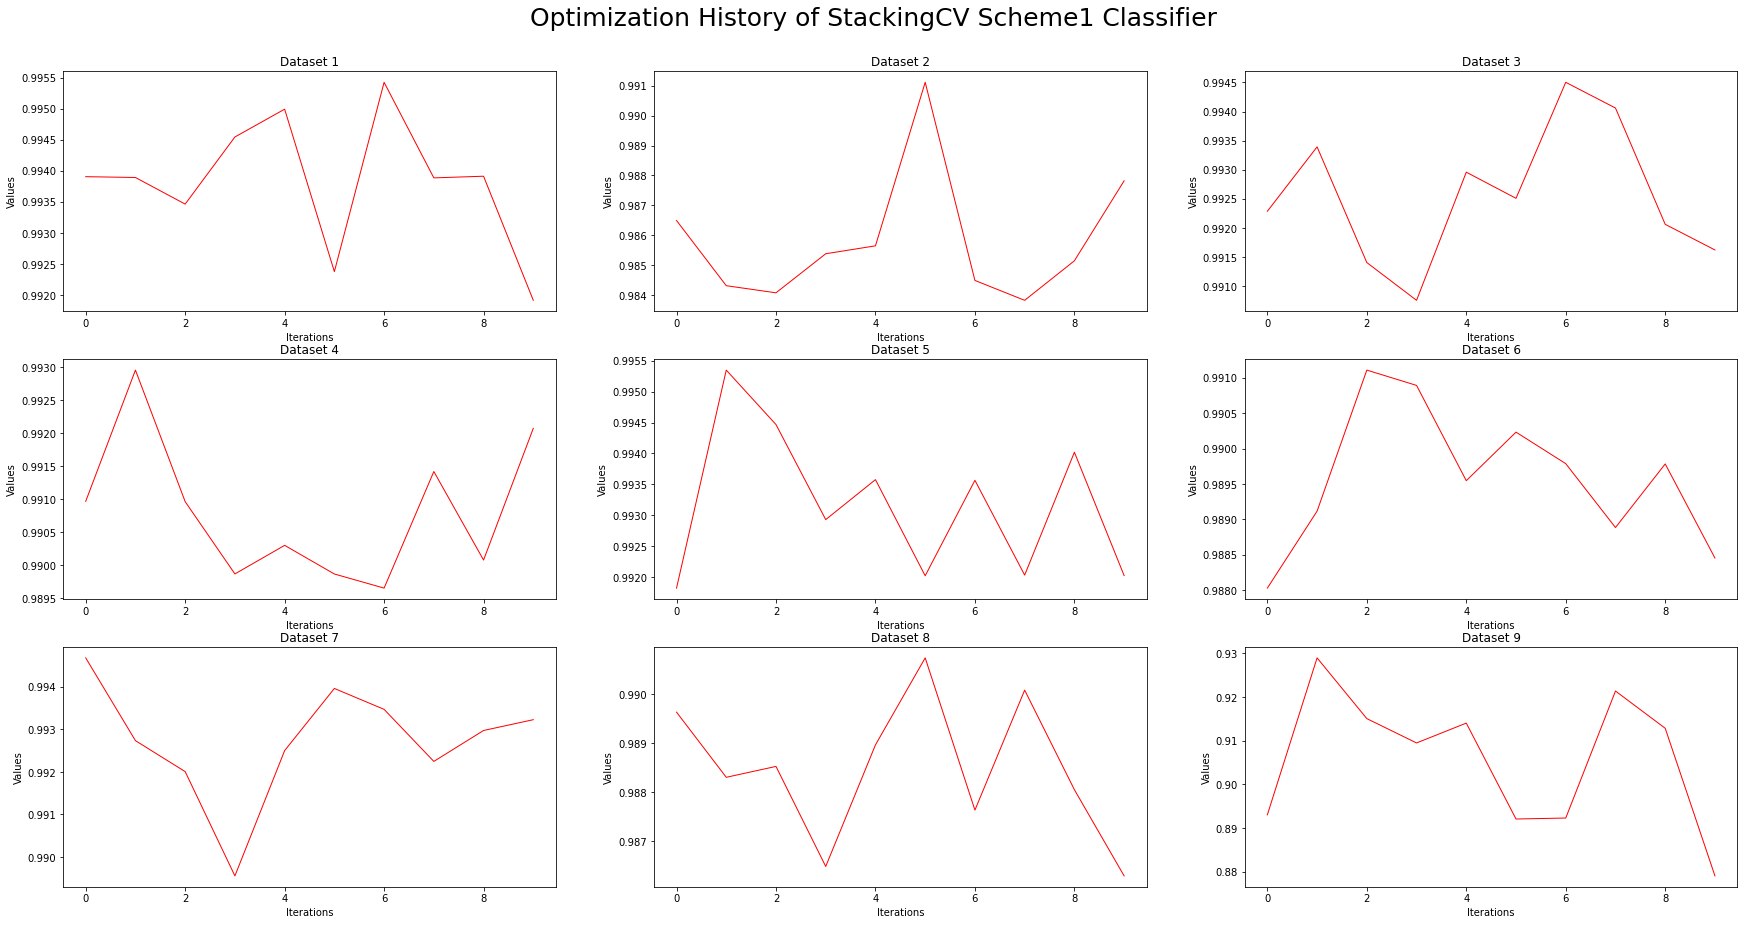

In [36]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'StackingCV Scheme1 Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

#### Feature Importance of Meta Learner

                      label_eqp_ADAGX100  label_eqp_ADCLA100  \
label_eqp_ADAGX100                   inf                0.00   
label_eqp_ADCLA100                  0.00                 inf   
label_eqp_ADCVD100                   NaN                 NaN   
label_eqp_ADCVD100_C               -0.00                0.01   
label_eqp_ADCVD100_D               -0.00                0.01   
...                                  ...                 ...   
N                                  -0.01               -0.16   
X                                   0.01                0.23   
L                                   0.01                0.23   
C                                   0.01                0.24   
GB                                  0.01               -0.16   

                      label_eqp_ADCVD100  label_eqp_ADCVD100_C  \
label_eqp_ADAGX100                   NaN                 -0.00   
label_eqp_ADCLA100                   NaN                  0.01   
label_eqp_ADCVD100               

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3020, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 6060, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498350 -> initscore=-0.006601
[LightGBM] [Info] Start training from score -0.006601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


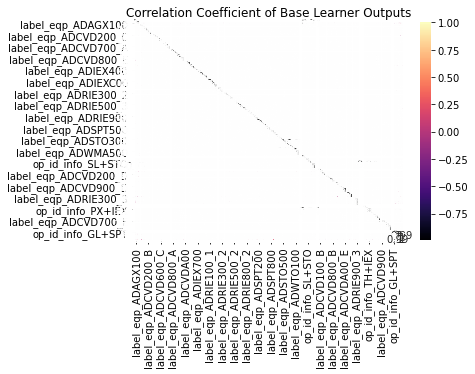

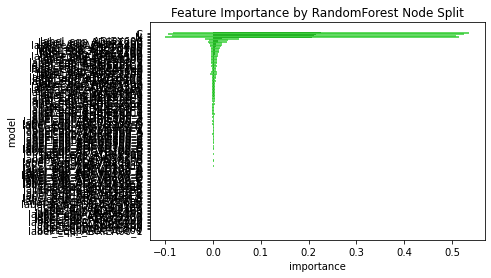

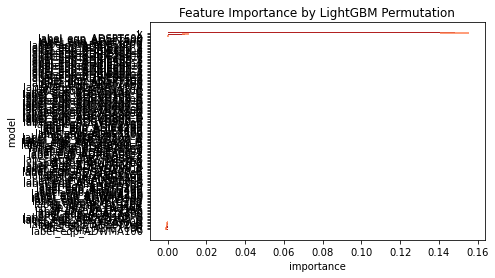

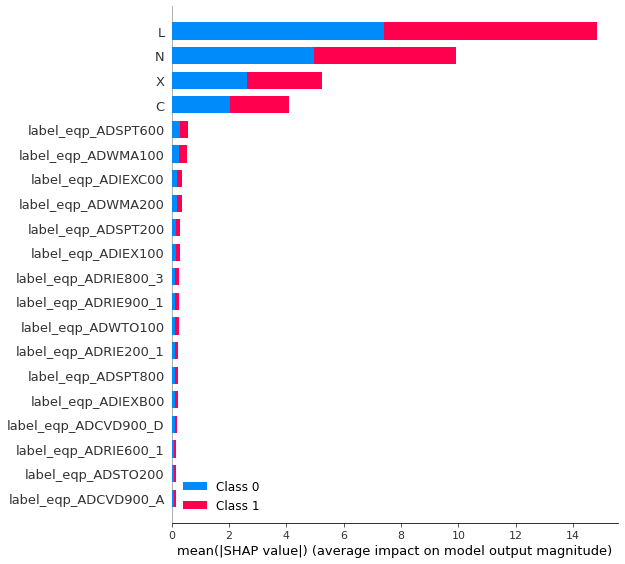

GLM  forest  permutation   SHAP  total_rank
L                       2.0     2.0          1.0    1.0         1.0
X                       1.0     4.0          2.0    3.0         2.0
label_eqp_ADSPT600     27.0    25.0          3.0    5.0         3.0
label_eqp_ADWMA400     11.0     8.0         64.5   30.0         4.0
label_eqp_ADIEX100     26.0    16.0         64.5   10.0         5.0
...                     ...     ...          ...    ...         ...
label_eqp_ADRIE300    122.0   121.5         64.5  103.5       122.0
label_eqp_ADCVD300    122.0   121.5         64.5  103.5       122.0
label_eqp_ADCVD900    122.0   121.5         64.5  103.5       122.0
label_eqp_ADCVD100    122.0   121.5         64.5  103.5       122.0
label_eqp_ADRIEA00_2  122.0   121.5         64.5  103.5       122.0

[131 rows x 5 columns]

In [9]:
target_set = 5
rank_importance(train_firstC[f'set{target_set}'], mode = 'C')

#### Classifier

0it [00:00, ?it/s]


 Dataset1:
Precision: 0.001435045317220544 
Recall: 0.37254901960784315 
Aging Rate: 0.27215359000184997

 Dataset2:
Precision: 0.0012401818933443572 
Recall: 0.5294117647058824 
Aging Rate: 0.44751176797056463

 Dataset3:
Precision: 0.0010833062506770664 
Recall: 0.5882352941176471 
Aging Rate: 0.569240888815803

 Dataset4:
Precision: 0.0011043215784436427 
Recall: 0.29411764705882354 
Aging Rate: 0.2792040946370943

 Dataset5:
Precision: 0.0015482054890921886 
Recall: 0.43137254901960786 
Aging Rate: 0.29209233488869246

 Dataset6:
Precision: 0.0012339331619537275 
Recall: 0.47058823529411764 
Aging Rate: 0.39980266809184156

 Dataset7:
Precision: 0.0012189459020199675 
Recall: 0.4117647058823529 
Aging Rate: 0.35412855351600236

 Dataset8:
Precision: 0.0011977840994160803 
Recall: 0.3137254901960784 
Aging Rate: 0.2745791280396308

 Dataset9:
Precision: 0.001237842617152962 
Recall: 0.27450980392156865 
Aging Rate: 0.2324816542991634


Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


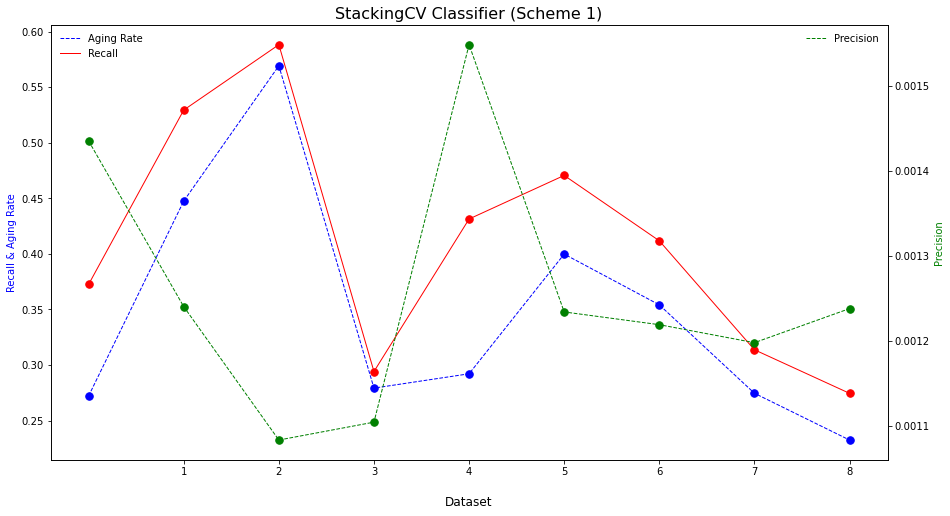

In [19]:
table_setC, coefC = runall_LR(train_firstC_x, test_firstC_x, train_firstC_y, test_firstC_y, best_paramC)
line_chart(table_setC, title = 'StackingCV Classifier (Scheme 1)')

In [20]:
table_setC

Balance Ratio  Train_OK  Train_NG    TP       FP    FN       TN  \
dataset1       1.000000    3067.0    3067.0  19.0  13221.0  32.0  35377.0   
dataset2       1.000000    3008.0    3008.0  27.0  21744.0  24.0  26854.0   
dataset3       1.000000    3038.0    3038.0  30.0  27663.0  21.0  20935.0   
dataset4       1.000000    3038.0    3038.0  15.0  13568.0  36.0  35030.0   
dataset5       1.006623    3040.0    3020.0  22.0  14188.0  29.0  34410.0   
dataset6       1.014348    3040.0    2997.0  24.0  19426.0  27.0  29172.0   
dataset7       1.000000    3040.0    3040.0  21.0  17207.0  30.0  31391.0   
dataset8       1.000000    3040.0    3040.0  16.0  13342.0  35.0  35256.0   
dataset9      10.000000    3040.0     304.0  14.0  11296.0  37.0  37302.0   

          Precision    Recall  Aging Rate  Efficiency  F1 Score     Score  
dataset1   0.001435  0.372549    0.272154    1.368893  0.001430  0.321295  
dataset2   0.001240  0.529412    0.447512    1.183012  0.001237  0.413315  
dataset3   0.001083  0.588235    0.569241    1.033368  0.001081  0.417467  
dataset4   0.001104  0.294118    0.279204    1.053415  0.001100  0.211619  
dataset5   0.001548  0.431373    0.292092    1.476836  0.001543  0.391247  
dataset6   0.001234  0.470588    0.399803    1.177051  0.001231  0.366104  
dataset7   0.001219  0.411765    0.354129    1.162755  0.001215  0.317628  
dataset8   0.001198  0.313725    0.274579    1.142569  0.001193  0.239061  
dataset9   0.001238  0.274510    0.232482    1.180780  0.001232  0.214031

### Full Experiment

In [ ]:
training_month = range(2, 5)
table_setC = full_stackingcv1(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 160
# over: 160
Size after Border: 39621

 Generating Dataset 2
Size after Undersampling: 1362
Size after Undersampling: (1362, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

In [ ]:
line_chart(table_setC, title = 'StackingCV Scheme 1 Classifier')
table_setC

### Export

In [ ]:
savedate = '20220419'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'StackingCV1_full'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'StackingCV1_full')